In [1]:
import os
import random
from dataclasses import dataclass
from typing import Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 可复现
seed = 123
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
csv_path = os.path.join(r'D:\历史python项目\机器学习\自编码器AutoEncoder\多变量时间序列的罕见事件分类案例\data', 'processminer-rare-event-mts - data.csv')
df = pd.read_csv(csv_path)
df

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,5/28/99 23:58,0,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242,0
18394,5/29/99 0:00,0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915698,0.010620,0.175348,-0.011235,0
18395,5/29/99 0:02,0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228,0
18396,5/29/99 0:04,0,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221,0


上述表格中，连续的行之间的间隔为2分钟。我们需要提前预测事件（y=1），那么它前后一定范围内的点也应被视为潜在的异常点，所以我们要将标签向前后移动来增加异常检测的宽容度。这样处理能够提高模型对异常点位置的容忍度，避免因标记不精确而导致的误判。

In [5]:
# 该函数用于控制数据标签的移动方向
def sign(x):
    return 1 if x >= 0 else -1

In [6]:
def curve_shift(df: pd.DataFrame, shift_by: int) -> pd.DataFrame:

    vector = df['y'].copy()
    # 通过将向量乘以 sign(shift_by) 来移动向量
    for _ in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by), fill_value=0)  # 将向量移动一个位置,并用0填充缺失值
        vector = vector + tmp   # 将原始 vector 与移动后的 tmp 相加，通过累加的方式，实现标签在多个时间步上的扩展
    labelcol = 'y'   # 原始标签列名
    df = df.copy()   
    df.insert(loc=0, column=labelcol + 'tmp', value=vector)   # 在数据框的第一列位置插入一个新的临时列'ytmp'
    df = df.drop(df[df[labelcol] == 1].index)                 # 删除原始标签为 1 的所有行
    df = df.drop(labelcol, axis=1)                            # 删除原始的标签列'y'
    df = df.rename(columns={labelcol + 'tmp': labelcol})      # 将临时列'ytmp'重命名为'y'，替换原来的标签列
    df.loc[df[labelcol] > 0, labelcol] = 1                    # 二值化处理：将所有大于0的值都设为1
    return df

In [7]:
df = curve_shift(df, shift_by=-2)
df

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,0,5/28/99 23:58,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,...,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242,0
18394,0,5/29/99 0:00,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,...,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915698,0.010620,0.175348,-0.011235,0
18395,0,5/29/99 0:02,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,...,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228,0
18396,0,5/29/99 0:04,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,...,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221,0


In [8]:
# 删除时间和分类列
drop_cols = [c for c in ['time', 'x28', 'x61'] if c in df.columns]
df = df.drop(drop_cols, axis=1)
df

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,0,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,-0.080108,...,29.984624,-0.773514,-0.752385,2.682413,6.944644,-37.795661,-0.860218,0.010220,0.895685,-0.011242
18394,0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,-0.080108,...,29.984624,-0.773514,-0.752385,2.683338,0.507755,-39.357199,-0.915698,0.010620,0.175348,-0.011235
18395,0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,-0.080108,...,29.984624,-0.773514,-0.752385,2.684263,2.809146,-39.357199,-1.409596,0.013323,0.621020,-0.011228
18396,0,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,-0.080108,...,29.984624,-0.773514,-0.752385,2.685189,2.164859,-39.357199,-0.860218,0.012888,1.390902,-0.011221


In [9]:
# 配置参数
SEED = 123
DATA_SPLIT_PCT = 0.2
BATCH_SIZE = 128
NB_EPOCH = 200
ENCODING_DIM = 32
HIDDEN_DIM = ENCODING_DIM // 2
L1_ACTIVITY_COEFF = 1e-3  
LR = 1e-3 
MODEL_PATH = "autoencoder_classifier_pytorch.pt"
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [10]:
# 将原始数据转换为tsfresh需要的时间序列格式
def create_time_series_data(df):
    rows = []
    for idx, row in df.iterrows():
        # 为每行数据创建一个时间序列，这里将每行的特征视为一个时间序列的不同时间点，每列特征作为一个时间点的值
        for col_idx, col_name in enumerate(df.columns):
            if col_name != 'y':  # 排除标签列
                rows.append({
                    'id': idx,
                    'time': col_idx,
                    'value': row[col_name],
                    'y': row['y']
                })
    return pd.DataFrame(rows)

In [11]:
# 将数据转换为时间序列格式
ts_data = create_time_series_data(df)
ts_data

,id,time,value,y
0,0,1,0.376665,0.0
1,0,2,-4.596435,0.0
2,0,3,-4.095756,0.0
3,0,4,13.497687,0.0
4,0,5,-0.118830,0.0
...,...,...,...,...
1078161,18397,55,-39.357199,0.0
1078162,18397,56,-0.732044,0.0
1078163,18397,57,0.012453,0.0
1078164,18397,58,0.418993,0.0


In [12]:
# 分离特征和标签
y = ts_data.groupby('id')['y'].first()
ts_data_features = ts_data[['id', 'time', 'value']]

In [13]:
# 使用tsfresh提取特征
X = extract_features(ts_data_features, 
                    column_id='id', 
                    column_sort='time', 
                    default_fc_parameters=EfficientFCParameters(),
                    n_jobs=0)  # 使用单进程以避免可能的多进程问题

Feature Extraction: 100%|████████████████████████████████████████████████████████| 18274/18274 [23:07<00:00, 13.17it/s]


In [15]:
X

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,1153.633008,1.870984e+06,66.189449,-0.006389,0.035315,-0.038189,...,1.352461,1.940152,3.308778,1.775446,3.053665,3.685842,3.963312,3.970292,NaN,256.446869
1,1.0,0.0,0.0,0.0,1174.240140,1.922968e+06,67.490408,-0.008097,0.034507,-0.014244,...,1.352461,1.940152,3.216358,1.732401,2.908409,3.531274,3.860623,3.944135,NaN,260.410399
2,1.0,0.0,0.0,0.0,1195.102401,1.917093e+06,67.386648,-0.006168,0.028165,-0.018352,...,1.352461,1.940152,3.170148,1.717979,2.903577,3.625917,3.911968,3.970292,NaN,260.406714
3,1.0,0.0,0.0,0.0,1187.764030,1.910711e+06,67.440435,-0.005095,0.022033,0.002075,...,1.349879,1.941862,3.262568,1.786663,3.062689,3.780485,3.937640,3.970292,NaN,260.496224
4,1.0,0.0,0.0,0.0,1178.978802,1.904140e+06,67.446863,-0.004474,0.031676,-0.018472,...,1.349879,1.954156,3.262568,1.756722,2.968499,3.670150,3.963312,3.970292,NaN,260.404709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,1.0,0.0,0.0,0.0,-3433.334520,1.327194e+07,141.690269,0.014934,-0.022551,-0.038189,...,0.146145,0.801747,2.748145,1.728300,2.953088,3.730074,3.963312,3.970292,NaN,568.637170
18394,1.0,0.0,0.0,0.0,-3400.539717,1.306753e+07,140.567001,0.014358,-0.014593,-0.038189,...,0.146145,0.811005,2.673167,1.728300,2.914157,3.720561,3.937640,3.970292,NaN,565.499590
18395,1.0,0.0,0.0,0.0,-3380.659309,1.285828e+07,139.110335,0.014057,-0.016745,-0.038189,...,0.146145,0.801747,2.811796,1.754063,2.977843,3.780485,3.963312,3.970292,NaN,560.287895
18396,1.0,0.0,0.0,0.0,-3354.406877,1.265304e+07,138.506608,0.013993,-0.023196,-0.028775,...,0.146145,0.801747,2.580747,1.754207,2.959156,3.745766,3.963312,3.970292,NaN,556.987022


In [16]:
# 填补缺失值
X = impute(X)

D:\Python\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__fft_coefficient__attr_"real"__coeff_30'
 'value__fft_coefficient__attr_"real"__coeff_31'
 'value__fft_coefficient__attr_"real"__coeff_32'
 'value__fft_coefficient__attr_"real"__coeff_33'
 'value__fft_coefficient__attr_"real"__coeff_34'
 'value__fft_coefficient__attr_"real"__coeff_35'
 'value__fft_coefficient__attr_"real"__coeff_36'
 'value__fft_coefficient__attr_"real"__coeff_37'
 'value__fft_coefficient__attr_"real"__coeff_38'
 'value__fft_coefficient__attr_"real"__coeff_39'
 'value__fft_coefficient__attr_"real"__coeff_40'
 'value__fft_coefficient__attr_"real"__coeff_41'
 'value__fft_coefficient__attr_"real"__coeff_42'
 'value__fft_coefficient__attr_"real"__coeff_43'
 'value__fft_coefficient__attr_"real"__coeff_44'
 'value__fft_coefficient__attr_"real"__coeff_45'
 'value__fft_coefficient__attr_"real"__coeff_46'
 'value__fft_coefficient__attr_"real"__coeff_47'
 'value__fft_coe

In [17]:
# 特征选择
X_selected = select_features(X, y)

In [18]:
# 将处理后的数据与标签合并
df_processed = X_selected.copy()
df_processed['y'] = y
print(f"原始特征数量: {len(df.columns) - 1}")  # -1 是因为要去掉标签列
print(f"tsfresh提取后的特征数量: {len(X.columns)}")
print(f"特征选择后的特征数量: {len(X_selected.columns)}")

原始特征数量: 59
tsfresh提取后的特征数量: 777
特征选择后的特征数量: 49


In [19]:
# 更新df为处理后的数据
df = df_processed
df

,"value__fft_coefficient__attr_""real""__coeff_13","value__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)",value__quantile__q_0.2,value__quantile__q_0.3,value__quantile__q_0.1,"value__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)",value__quantile__q_0.8,value__time_reversal_asymmetry_statistic__lag_2,value__quantile__q_0.9,value__quantile__q_0.7,...,value__range_count__max_1000000000000.0__min_0,value__count_above__t_0,value__ar_coefficient__coeff_9__k_10,"value__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","value__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","value__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)",value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,"value__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)","value__fft_coefficient__attr_""real""__coeff_11",y
0,-275.656648,-10.996753,-1.497431,-0.445163,-10.488792,-3.778286,3.234480,2.415294e+06,11.735661,0.169202,...,28.0,0.474576,-0.016043,-5.545996,9.170966e+01,0.009425,4.181717e-07,7.143799,427.753920,0.0
1,-267.749574,-10.409191,-1.611742,-0.525097,-10.488792,-3.652410,2.839840,2.553271e+06,13.273603,0.231849,...,28.0,0.474576,-0.016404,-5.913420,1.816018e+02,-0.749169,4.012538e-07,8.378534,432.753275,0.0
2,-272.650783,-9.628324,-0.995561,-0.359463,-9.652568,-2.639303,3.260115,2.567551e+06,14.496975,0.200965,...,29.0,0.491525,-0.016491,-5.471237,2.090569e+02,1.134465,5.316281e-07,6.900964,438.553457,0.0
3,-277.335132,-9.730415,-0.953955,-0.209881,-10.866871,-3.628059,4.514994,2.562584e+06,13.650991,0.341770,...,30.0,0.508475,-0.015630,-4.843320,2.292240e+02,-0.872303,4.572600e-07,6.650828,428.509214,0.0
4,-266.237335,-9.412611,-1.508695,-0.233173,-10.749418,-3.469913,3.285749,2.623166e+06,15.335097,0.151881,...,28.0,0.474576,-0.015374,-5.175941,2.619315e+02,-1.105848,3.630571e-07,7.482210,428.906872,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,130.707709,-5.282841,-0.812252,-0.546852,-3.945227,-3.985208,0.779901,-9.191305e+06,13.033155,0.118810,...,24.0,0.406780,-0.023304,-29.113987,2.893172e+06,-33.502419,2.073820e-08,69.986027,-1765.989005,0.0
18394,141.015796,-5.344514,-0.776218,-0.551865,-3.840679,-3.991444,0.590385,-8.985662e+06,10.703719,0.161742,...,25.0,0.423729,-0.023418,-28.759904,1.135936e+02,-33.069331,1.669825e-08,69.008850,-1758.596725,0.0
18395,128.151597,-6.063167,-0.798784,-0.610146,-3.982849,-2.979157,0.682831,-8.812349e+06,8.626786,0.151484,...,24.0,0.406780,-0.022770,-29.950545,8.504632e+01,-30.467839,1.472119e-08,69.891361,-1755.557950,0.0
18396,138.392903,-6.358447,-0.837793,-0.561890,-3.987646,-3.895779,1.014758,-8.794400e+06,8.849008,0.168915,...,26.0,0.440678,-0.022925,-29.817509,2.755508e+06,-32.462622,1.207919e-08,70.380021,-1735.560129,0.0


In [20]:
# 划分训练/验证/测试集
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [21]:
# 仅使用 y=0 训练自编码器
df_train_0 = df_train.loc[df_train['y'] == 0]   # 提取标签为0的正常样本
df_train_1 = df_train.loc[df_train['y'] == 1]   # 提取标签为1的异常样本
df_train_0_x = df_train_0.drop(['y'], axis=1)   # 正常样本的特征数据（无标签列）
df_train_1_x = df_train_1.drop(['y'], axis=1)   # 异常样本的特征数据（无标签列）

df_valid_0 = df_valid.loc[df_valid['y'] == 0]   # 提取验证集中的正常样本
df_valid_1 = df_valid.loc[df_valid['y'] == 1]   # 提取验证集中的异常样本
df_valid_0_x = df_valid_0.drop(['y'], axis=1)   # 验证集正常样本的特征数据（无标签列）
df_valid_1_x = df_valid_1.drop(['y'], axis=1)   # 验证集异常样本的特征数据（无标签列）

df_test_0 = df_test.loc[df_test['y'] == 0]   # 测试集中的正常样本
df_test_1 = df_test.loc[df_test['y'] == 1]   # 测试集中的异常样本
df_test_0_x = df_test_0.drop(['y'], axis=1)  # 测试集正常样本的特征数据（无标签列）
df_test_1_x = df_test_1.drop(['y'], axis=1)  # 测试集异常样本的特征数据（无标签列）

In [22]:
# 所有数据使用相同的均值和标准差进行标准化
scaler = StandardScaler().fit(df_train_0_x)   # 计算训练数据的均值(μ)和标准差(σ)
# 通过 (X - μ) / σ 标准化数据
df_train_0_x_rescaled = scaler.transform(df_train_0_x)   # 训练集
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)   # 验证集（仅包含正常样本）
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis=1))   # 验证集（包含正常和异常样本）
df_test_0_x_rescaled = scaler.transform(df_test_0_x)   # 测试集（仅包含正常样本）
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis=1))   # 测试集（包含正常和异常样本）

In [23]:
@dataclass
class Datasets:
    df_train_0_x_rescaled: np.ndarray   # 训练集中的正常样本（标签为 0）经过缩放处理后的特征矩阵
    df_valid_0_x_rescaled: np.ndarray   # 验证集中的正常样本（标签为 0）经过缩放处理后的特征矩阵
    df_valid_x_rescaled: np.ndarray     # 验证集中的所有样本（包含正常和异常样本）经过缩放处理后的特征矩阵
    df_test_0_x_rescaled: np.ndarray    # 测试集中的正常样本（标签为 0）经过缩放处理后的特征矩阵
    df_test_x_rescaled: np.ndarray      # 测试集中的所有样本（包含正常和异常样本）经过缩放处理后的特征矩阵
    error_df_valid_true: np.ndarray     # 验证集中样本的真实异常标签（用于评估模型性能）
    error_df_test_true: np.ndarray      # 测试集中样本的真实异常标签（用于评估模型性能）

In [24]:
# 保存真实的标签值用于后续的模型评估
error_df_valid_true = df_valid['y'].values
error_df_test_true = df_test['y'].values

In [25]:
ds_bundle = Datasets(
    df_train_0_x_rescaled=df_train_0_x_rescaled,
    df_valid_0_x_rescaled=df_valid_0_x_rescaled,
    df_valid_x_rescaled=df_valid_x_rescaled,
    df_test_0_x_rescaled=df_test_0_x_rescaled,
    df_test_x_rescaled=df_test_x_rescaled,
    error_df_valid_true=error_df_valid_true,
    error_df_test_true=error_df_test_true,
)

In [26]:
input_dim = df_train_0_x_rescaled.shape[1]

In [27]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim = ENCODING_DIM, hidden_dim = HIDDEN_DIM):
        super().__init__()
        # 编码器
        self.enc1 = nn.Linear(input_dim, encoding_dim)
        self.enc2 = nn.Linear(encoding_dim, hidden_dim)
        # 解码器
        self.dec1 = nn.Linear(hidden_dim, hidden_dim)
        self.dec2 = nn.Linear(hidden_dim, encoding_dim)
        self.out = nn.Linear(encoding_dim, input_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        # 前向传播
        z1 = self.act(self.enc1(x))
        z = self.act(self.enc2(z1))
        y = self.act(self.dec1(z))
        y = self.act(self.dec2(y))
        recon = self.out(y)  
        return recon, z1

In [29]:
model = Autoencoder(input_dim=input_dim, encoding_dim=ENCODING_DIM, hidden_dim=HIDDEN_DIM).to(device)
summary(model, input_size=(input_dim,))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [49]                      --
├─Linear: 1-1                            [32]                      1,600
├─ReLU: 1-2                              [32]                      --
├─Linear: 1-3                            [16]                      528
├─ReLU: 1-4                              [16]                      --
├─Linear: 1-5                            [16]                      272
├─ReLU: 1-6                              [16]                      --
├─Linear: 1-7                            [32]                      544
├─ReLU: 1-8                              [32]                      --
├─Linear: 1-9                            [49]                      1,617
Total params: 4,561
Trainable params: 4,561
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB)

In [30]:
def train_autoencoder_with_params(model, train_data, valid_data, device, lr, l1_coeff):
    """
    使用指定的超参数训练自编码器
    """
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    valid_tensor = torch.tensor(valid_data, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(TensorDataset(valid_tensor, valid_tensor), batch_size=BATCH_SIZE, shuffle=False)

    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 用于存储训练和验证损失的列表
    train_losses = []
    val_losses = []

    for epoch in range(1, NB_EPOCH + 1):
        # 训练
        model.train()
        train_loss_epoch = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NB_EPOCH} [Train]", leave=False)
        for xb, yb in train_pbar:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            recon, z1 = model(xb)
            mse_loss = criterion(recon, yb)
            l1_activity = torch.mean(torch.abs(z1))
            loss = mse_loss + l1_coeff * l1_activity
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item() * xb.size(0)
            train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
        train_loss_epoch /= len(train_loader.dataset)
        train_losses.append(train_loss_epoch)

        # 验证
        model.eval()
        val_loss_epoch = 0.0
        val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch}/{NB_EPOCH} [Valid]", leave=False)
        with torch.no_grad():
            for xb, yb in val_pbar:
                xb = xb.to(device)
                yb = yb.to(device)
                recon, z1 = model(xb)
                mse_loss = criterion(recon, yb)
                l1_activity = torch.mean(torch.abs(z1))
                loss = mse_loss + l1_coeff * l1_activity
                val_loss_epoch += loss.item() * xb.size(0)
                val_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
        val_loss_epoch /= len(valid_loader.dataset)
        val_losses.append(val_loss_epoch)

        print(f"Epoch {epoch:03d}/{NB_EPOCH} - train_loss: {train_loss_epoch:.6f} - val_loss: {val_loss_epoch:.6f}")
    
    # 返回训练后的模型
    return model

In [31]:
# 对输入数据进行重构
def reconstruct(model, x_np, device) :
    model.eval()
    x = torch.tensor(x_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        recon, _ = model(x)   # 在不计算梯度的情况下进行向前传播，获取重构结果
    return recon.cpu().numpy()

In [32]:
# 超参数优化循环
best_auc = 0.0
best_model_state = None
best_params = {}

# 定义要尝试的超参数组合
learning_rates = [1e-3, 5e-4, 1e-4]
encoding_dims = [16, 32, 64]
l1_coeffs = [1e-3, 1e-4, 1e-5]

In [33]:
# 根据评估指标找到最佳阈值
def find_best_threshold(y_true, recon_err):
    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(y_true, recon_err)
    
    # 计算AUC
    roc_auc = auc(fpr, tpr)

    f1_scores = []
    for threshold in thresholds:
        pred_y = (recon_err > threshold).astype(int)
        f1 = f1_score(y_true, pred_y, zero_division=0)
        f1_scores.append(f1)
    
    # 找到最佳阈值
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    return best_threshold, best_f1, roc_auc

In [37]:
for lr in learning_rates:
    for encoding_dim in encoding_dims:
        for l1_coeff in l1_coeffs:
            print(f"\n测试超参数组合: lr={lr}, encoding_dim={encoding_dim}, l1_coeff={l1_coeff}")

            # 创建新模型
            model = Autoencoder(input_dim=input_dim, encoding_dim=ENCODING_DIM, hidden_dim=HIDDEN_DIM).to(device)

            # 训练模型
            model = train_autoencoder_with_params(model, ds_bundle.df_train_0_x_rescaled, ds_bundle.df_valid_0_x_rescaled, device, lr, l1_coeff)

            # train_tensor = torch.tensor(ds_bundle.df_train_0_x_rescaled, dtype=torch.float32)   # 将训练数据转换为 PyTorch 张量
            # valid_tensor = torch.tensor(ds_bundle.df_valid_0_x_rescaled, dtype=torch.float32)   # 将验证数据转换为 PyTorch 张量
            # train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=BATCH_SIZE, shuffle=True)   # 创建训练数据加载器
            # valid_loader = DataLoader(TensorDataset(valid_tensor, valid_tensor), batch_size=BATCH_SIZE, shuffle=False)  # 创建验证数据加载器
            
            # criterion = nn.MSELoss(reduction='mean')   # 损失函数：均方误差
            # optimizer = optim.Adam(model.parameters(), lr=LR)   # 优化器：Adam
            
            # # best_val_loss = float('inf')   # 初始化一个变量来存储最佳验证损失，先赋值为正无穷大
            
            # # 创建空的列表，用于存储训练和验证损失
            # train_losses = []
            # val_losses = []

            # for epoch in range(1, NB_EPOCH + 1):
            #     # 训练
            #     model.train()
            #     train_loss_epoch = 0.0
            #     train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NB_EPOCH} [Train]", leave=False)
            #     for xb, yb in train_pbar:
            #         xb = xb.to(device)
            #         yb = yb.to(device)
            #         optimizer.zero_grad()
            #         recon, z1 = model(xb)
            #         mse_loss = criterion(recon, yb)
            #         l1_activity = torch.mean(torch.abs(z1))   # L1 活动正则化
            #         loss = mse_loss + L1_ACTIVITY_COEFF * l1_activity   # 总损失
            #         loss.backward()
            #         optimizer.step()
            #         train_loss_epoch += loss.item() * xb.size(0)
            #         train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
            #     train_loss_epoch /= len(train_loader.dataset)
            #     train_losses.append(train_loss_epoch)
            
            #     # 验证
            #     model.eval()
            #     val_loss_epoch = 0.0
            #     val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch}/{NB_EPOCH} [Valid]", leave=False)
            #     with torch.no_grad():
            #         for xb, yb in val_pbar:
            #             xb = xb.to(device)
            #             yb = yb.to(device)
            #             recon, z1 = model(xb)
            #             mse_loss = criterion(recon, yb)
            #             l1_activity = torch.mean(torch.abs(z1))
            #             loss = mse_loss + L1_ACTIVITY_COEFF * l1_activity
            #             val_loss_epoch += loss.item() * xb.size(0)
            #             val_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
            #     val_loss_epoch /= len(valid_loader.dataset)
            #     val_losses.append(val_loss_epoch)
            
                # print(f"Epoch {epoch:03d}/{NB_EPOCH} - train_loss: {train_loss_epoch:.6f} - val_loss: {val_loss_epoch:.6f}")
            
                # # 基于验证集的最小重构误差保存最佳模型
                # if val_loss_epoch < best_val_loss:
                #     best_val_loss = val_loss_epoch
                #     torch.save(model.state_dict(), MODEL_PATH)

            # 验证评估
            valid_recon = reconstruct(model, ds_bundle.df_valid_x_rescaled, device)
            valid_mse = np.mean(np.power(ds_bundle.df_valid_x_rescaled - valid_recon, 2), axis=1)

            # 基于评估指标找到最佳阈值
            best_thresh, best_f1, valid_auc = find_best_threshold(ds_bundle.error_df_valid_true, valid_mse)

            print(f"验证集结果: AUC={valid_auc:.4f}, Best F1={best_f1:.4f}, Best Threshold={best_thresh:.4f}")

            # 如果这是目前最好的模型，保存它
            if valid_auc > best_auc:
                best_auc = valid_auc
                best_model_state = model.state_dict().copy()
                best_params = {
                    'input_dim': input_dim,
                    'lr': lr,
                    'encoding_dim': encoding_dim,
                    'l1_coeff': l1_coeff
                }
                best_threshold = best_thresh
                print(f"发现更好的模型! AUC: {best_auc:.4f}")


测试超参数组合: lr=0.001, encoding_dim=16, l1_coeff=0.001


Epoch 001/200 - train_loss: 0.789916 - val_loss: 0.487487


Epoch 002/200 - train_loss: 0.396311 - val_loss: 0.334498


Epoch 003/200 - train_loss: 0.303481 - val_loss: 0.273239


Epoch 004/200 - train_loss: 0.252176 - val_loss: 0.229641


Epoch 005/200 - train_loss: 0.215771 - val_loss: 0.200094


Epoch 006/200 - train_loss: 0.189245 - val_loss: 0.177353


Epoch 007/200 - train_loss: 0.168207 - val_loss: 0.157325


Epoch 008/200 - train_loss: 0.151075 - val_loss: 0.140831


Epoch 009/200 - train_loss: 0.136868 - val_loss: 0.128034


Epoch 010/200 - train_loss: 0.126117 - val_loss: 0.121183


Epoch 011/200 - train_loss: 0.117804 - val_loss: 0.111893


Epoch 012/200 - train_loss: 0.111054 - val_loss: 0.105664


Epoch 013/200 - train_loss: 0.105580 - val_loss: 0.101297


Epoch 014/200 - train_loss: 0.101316 - val_loss: 0.096648


Epoch 015/200 - train_loss: 0.097324 - val_loss: 0.092907


Epoch 016/200 - train_loss: 0.093331 - val_loss: 0.090581


Epoch 017/200 - train_loss: 0.090157 - val_loss: 0.086930


Epoch 018/200 - train_loss: 0.086968 - val_loss: 0.084925


Epoch 019/200 - train_loss: 0.083994 - val_loss: 0.081653


Epoch 020/200 - train_loss: 0.081367 - val_loss: 0.080255


Epoch 021/200 - train_loss: 0.079347 - val_loss: 0.079051


Epoch 022/200 - train_loss: 0.077378 - val_loss: 0.076009


Epoch 023/200 - train_loss: 0.075159 - val_loss: 0.074792


Epoch 024/200 - train_loss: 0.073430 - val_loss: 0.073618


Epoch 025/200 - train_loss: 0.071324 - val_loss: 0.070758


Epoch 026/200 - train_loss: 0.069521 - val_loss: 0.069503


Epoch 027/200 - train_loss: 0.068078 - val_loss: 0.067294


Epoch 028/200 - train_loss: 0.066288 - val_loss: 0.065465


Epoch 029/200 - train_loss: 0.064569 - val_loss: 0.064912


Epoch 030/200 - train_loss: 0.063600 - val_loss: 0.062629


Epoch 031/200 - train_loss: 0.062118 - val_loss: 0.062074


Epoch 032/200 - train_loss: 0.060951 - val_loss: 0.060892


Epoch 033/200 - train_loss: 0.059429 - val_loss: 0.058951


Epoch 034/200 - train_loss: 0.058625 - val_loss: 0.058217


Epoch 035/200 - train_loss: 0.057443 - val_loss: 0.057427


Epoch 036/200 - train_loss: 0.056533 - val_loss: 0.056419


Epoch 037/200 - train_loss: 0.055773 - val_loss: 0.056059


Epoch 038/200 - train_loss: 0.054937 - val_loss: 0.056873


Epoch 039/200 - train_loss: 0.054379 - val_loss: 0.054877


Epoch 040/200 - train_loss: 0.053622 - val_loss: 0.053288


Epoch 041/200 - train_loss: 0.052876 - val_loss: 0.052673


Epoch 042/200 - train_loss: 0.052126 - val_loss: 0.052279


Epoch 043/200 - train_loss: 0.051652 - val_loss: 0.051779


Epoch 044/200 - train_loss: 0.051003 - val_loss: 0.050830


Epoch 045/200 - train_loss: 0.050764 - val_loss: 0.051400


Epoch 046/200 - train_loss: 0.050049 - val_loss: 0.050087


Epoch 047/200 - train_loss: 0.049834 - val_loss: 0.049232


Epoch 048/200 - train_loss: 0.049032 - val_loss: 0.049646


Epoch 049/200 - train_loss: 0.048805 - val_loss: 0.048852


Epoch 050/200 - train_loss: 0.048541 - val_loss: 0.049146


Epoch 051/200 - train_loss: 0.047944 - val_loss: 0.048176


Epoch 052/200 - train_loss: 0.047618 - val_loss: 0.047862


Epoch 053/200 - train_loss: 0.047502 - val_loss: 0.047281


Epoch 054/200 - train_loss: 0.046833 - val_loss: 0.046651


Epoch 055/200 - train_loss: 0.046684 - val_loss: 0.047511


Epoch 056/200 - train_loss: 0.046223 - val_loss: 0.054127


Epoch 057/200 - train_loss: 0.047709 - val_loss: 0.045417


Epoch 058/200 - train_loss: 0.045654 - val_loss: 0.046750


Epoch 059/200 - train_loss: 0.045490 - val_loss: 0.045754


Epoch 060/200 - train_loss: 0.045244 - val_loss: 0.045127


Epoch 061/200 - train_loss: 0.044854 - val_loss: 0.045067


Epoch 062/200 - train_loss: 0.044648 - val_loss: 0.044545


Epoch 063/200 - train_loss: 0.044599 - val_loss: 0.044179


Epoch 064/200 - train_loss: 0.043976 - val_loss: 0.044631


Epoch 065/200 - train_loss: 0.043792 - val_loss: 0.043718


Epoch 066/200 - train_loss: 0.043498 - val_loss: 0.043713


Epoch 067/200 - train_loss: 0.043363 - val_loss: 0.043196


Epoch 068/200 - train_loss: 0.042918 - val_loss: 0.042910


Epoch 069/200 - train_loss: 0.042809 - val_loss: 0.042786


Epoch 070/200 - train_loss: 0.042743 - val_loss: 0.042308


Epoch 071/200 - train_loss: 0.042303 - val_loss: 0.042850


Epoch 072/200 - train_loss: 0.042290 - val_loss: 0.042669


Epoch 073/200 - train_loss: 0.041817 - val_loss: 0.041842


Epoch 074/200 - train_loss: 0.041747 - val_loss: 0.042095


Epoch 075/200 - train_loss: 0.041720 - val_loss: 0.040868


Epoch 076/200 - train_loss: 0.041177 - val_loss: 0.042071


Epoch 077/200 - train_loss: 0.041328 - val_loss: 0.041551


Epoch 078/200 - train_loss: 0.041298 - val_loss: 0.042260


Epoch 079/200 - train_loss: 0.041593 - val_loss: 0.041138


Epoch 080/200 - train_loss: 0.040667 - val_loss: 0.040767


Epoch 081/200 - train_loss: 0.040663 - val_loss: 0.040324


Epoch 082/200 - train_loss: 0.040453 - val_loss: 0.040044


Epoch 083/200 - train_loss: 0.040116 - val_loss: 0.039938


Epoch 084/200 - train_loss: 0.040082 - val_loss: 0.039748


Epoch 085/200 - train_loss: 0.040100 - val_loss: 0.040864


Epoch 086/200 - train_loss: 0.039980 - val_loss: 0.039906


Epoch 087/200 - train_loss: 0.039635 - val_loss: 0.040325


Epoch 088/200 - train_loss: 0.039622 - val_loss: 0.039147


Epoch 089/200 - train_loss: 0.039234 - val_loss: 0.039778


Epoch 090/200 - train_loss: 0.039342 - val_loss: 0.039391


Epoch 091/200 - train_loss: 0.039250 - val_loss: 0.038805


Epoch 092/200 - train_loss: 0.038931 - val_loss: 0.038714


Epoch 093/200 - train_loss: 0.039018 - val_loss: 0.039845


Epoch 094/200 - train_loss: 0.038903 - val_loss: 0.038785


Epoch 095/200 - train_loss: 0.038825 - val_loss: 0.039550


Epoch 096/200 - train_loss: 0.038512 - val_loss: 0.039325


Epoch 097/200 - train_loss: 0.038727 - val_loss: 0.038537


Epoch 098/200 - train_loss: 0.038193 - val_loss: 0.038330


Epoch 099/200 - train_loss: 0.038263 - val_loss: 0.038493


Epoch 100/200 - train_loss: 0.038201 - val_loss: 0.038236


Epoch 101/200 - train_loss: 0.037879 - val_loss: 0.039355


Epoch 102/200 - train_loss: 0.037910 - val_loss: 0.038658


Epoch 103/200 - train_loss: 0.037771 - val_loss: 0.037871


Epoch 104/200 - train_loss: 0.037535 - val_loss: 0.037701


Epoch 105/200 - train_loss: 0.037477 - val_loss: 0.038465


Epoch 106/200 - train_loss: 0.037542 - val_loss: 0.036794


Epoch 107/200 - train_loss: 0.037121 - val_loss: 0.037084


Epoch 108/200 - train_loss: 0.036879 - val_loss: 0.036886


Epoch 109/200 - train_loss: 0.036896 - val_loss: 0.037124


Epoch 110/200 - train_loss: 0.036875 - val_loss: 0.037431


Epoch 111/200 - train_loss: 0.036707 - val_loss: 0.036793


Epoch 112/200 - train_loss: 0.036678 - val_loss: 0.038523


Epoch 113/200 - train_loss: 0.036749 - val_loss: 0.036249


Epoch 114/200 - train_loss: 0.036373 - val_loss: 0.036648


Epoch 115/200 - train_loss: 0.036137 - val_loss: 0.036512


Epoch 116/200 - train_loss: 0.035937 - val_loss: 0.035791


Epoch 117/200 - train_loss: 0.035832 - val_loss: 0.036214


Epoch 118/200 - train_loss: 0.035678 - val_loss: 0.035807


Epoch 119/200 - train_loss: 0.035762 - val_loss: 0.035548


Epoch 120/200 - train_loss: 0.035486 - val_loss: 0.036124


Epoch 121/200 - train_loss: 0.035554 - val_loss: 0.035096


Epoch 122/200 - train_loss: 0.034990 - val_loss: 0.035111


Epoch 123/200 - train_loss: 0.035076 - val_loss: 0.035577


Epoch 124/200 - train_loss: 0.034908 - val_loss: 0.035669


Epoch 125/200 - train_loss: 0.034906 - val_loss: 0.035227


Epoch 126/200 - train_loss: 0.034716 - val_loss: 0.034982


Epoch 127/200 - train_loss: 0.034502 - val_loss: 0.036058


Epoch 128/200 - train_loss: 0.034355 - val_loss: 0.034746


Epoch 129/200 - train_loss: 0.034387 - val_loss: 0.034125


Epoch 130/200 - train_loss: 0.034102 - val_loss: 0.034553


Epoch 131/200 - train_loss: 0.034045 - val_loss: 0.034086


Epoch 132/200 - train_loss: 0.033815 - val_loss: 0.035578


Epoch 133/200 - train_loss: 0.034167 - val_loss: 0.033596


Epoch 134/200 - train_loss: 0.033529 - val_loss: 0.034932


Epoch 135/200 - train_loss: 0.033664 - val_loss: 0.034022


Epoch 136/200 - train_loss: 0.033499 - val_loss: 0.033361


Epoch 137/200 - train_loss: 0.033266 - val_loss: 0.033818


Epoch 138/200 - train_loss: 0.033181 - val_loss: 0.033764


Epoch 139/200 - train_loss: 0.033228 - val_loss: 0.034487


Epoch 140/200 - train_loss: 0.033166 - val_loss: 0.033960


Epoch 141/200 - train_loss: 0.033093 - val_loss: 0.033289


Epoch 142/200 - train_loss: 0.032883 - val_loss: 0.033307


Epoch 143/200 - train_loss: 0.032750 - val_loss: 0.033727


Epoch 144/200 - train_loss: 0.032867 - val_loss: 0.033274


Epoch 145/200 - train_loss: 0.032669 - val_loss: 0.032813


Epoch 146/200 - train_loss: 0.032643 - val_loss: 0.032722


Epoch 147/200 - train_loss: 0.032367 - val_loss: 0.032685


Epoch 148/200 - train_loss: 0.032344 - val_loss: 0.032130


Epoch 149/200 - train_loss: 0.032144 - val_loss: 0.032975


Epoch 150/200 - train_loss: 0.032296 - val_loss: 0.032298


Epoch 151/200 - train_loss: 0.032335 - val_loss: 0.032058


Epoch 152/200 - train_loss: 0.031889 - val_loss: 0.032471


Epoch 153/200 - train_loss: 0.032045 - val_loss: 0.032461


Epoch 154/200 - train_loss: 0.031798 - val_loss: 0.031952


Epoch 155/200 - train_loss: 0.031842 - val_loss: 0.034611


Epoch 156/200 - train_loss: 0.031874 - val_loss: 0.032037


Epoch 157/200 - train_loss: 0.031980 - val_loss: 0.032218


Epoch 158/200 - train_loss: 0.031542 - val_loss: 0.032091


Epoch 159/200 - train_loss: 0.031644 - val_loss: 0.031792


Epoch 160/200 - train_loss: 0.031255 - val_loss: 0.031797


Epoch 161/200 - train_loss: 0.031456 - val_loss: 0.031628


Epoch 162/200 - train_loss: 0.031143 - val_loss: 0.032508


Epoch 163/200 - train_loss: 0.031208 - val_loss: 0.031565


Epoch 164/200 - train_loss: 0.031148 - val_loss: 0.031774


Epoch 165/200 - train_loss: 0.031239 - val_loss: 0.031295


Epoch 166/200 - train_loss: 0.031161 - val_loss: 0.031352


Epoch 167/200 - train_loss: 0.031069 - val_loss: 0.031338


Epoch 168/200 - train_loss: 0.030871 - val_loss: 0.035729


Epoch 169/200 - train_loss: 0.032924 - val_loss: 0.031993


Epoch 170/200 - train_loss: 0.030785 - val_loss: 0.031303


Epoch 171/200 - train_loss: 0.030698 - val_loss: 0.031162


Epoch 172/200 - train_loss: 0.030766 - val_loss: 0.031363


Epoch 173/200 - train_loss: 0.030709 - val_loss: 0.030869


Epoch 174/200 - train_loss: 0.030502 - val_loss: 0.031006


Epoch 175/200 - train_loss: 0.030509 - val_loss: 0.030914


Epoch 176/200 - train_loss: 0.030469 - val_loss: 0.031090


Epoch 177/200 - train_loss: 0.030433 - val_loss: 0.031439


Epoch 178/200 - train_loss: 0.030376 - val_loss: 0.031241


Epoch 179/200 - train_loss: 0.030297 - val_loss: 0.030634


Epoch 180/200 - train_loss: 0.030235 - val_loss: 0.030515


Epoch 181/200 - train_loss: 0.030146 - val_loss: 0.030601


Epoch 182/200 - train_loss: 0.030408 - val_loss: 0.030517


Epoch 183/200 - train_loss: 0.030326 - val_loss: 0.030997


Epoch 184/200 - train_loss: 0.030129 - val_loss: 0.030879


Epoch 185/200 - train_loss: 0.030127 - val_loss: 0.031705


Epoch 186/200 - train_loss: 0.030397 - val_loss: 0.030757


Epoch 187/200 - train_loss: 0.029939 - val_loss: 0.030269


Epoch 188/200 - train_loss: 0.029832 - val_loss: 0.030131


Epoch 189/200 - train_loss: 0.029805 - val_loss: 0.030894


Epoch 190/200 - train_loss: 0.030235 - val_loss: 0.029970


Epoch 191/200 - train_loss: 0.029921 - val_loss: 0.030683


Epoch 192/200 - train_loss: 0.029738 - val_loss: 0.030439


Epoch 193/200 - train_loss: 0.029670 - val_loss: 0.029964


Epoch 194/200 - train_loss: 0.029677 - val_loss: 0.030302


Epoch 195/200 - train_loss: 0.029656 - val_loss: 0.030317


Epoch 196/200 - train_loss: 0.029686 - val_loss: 0.030122


Epoch 197/200 - train_loss: 0.029829 - val_loss: 0.030547


Epoch 198/200 - train_loss: 0.029454 - val_loss: 0.031443


Epoch 199/200 - train_loss: 0.029619 - val_loss: 0.030445


Epoch 200/200 - train_loss: 0.029599 - val_loss: 0.029954
验证集结果: AUC=0.5358, Best F1=0.0472, Best Threshold=0.0678

测试超参数组合: lr=0.001, encoding_dim=16, l1_coeff=0.0001


Epoch 001/200 - train_loss: 0.810238 - val_loss: 0.540481


Epoch 002/200 - train_loss: 0.442668 - val_loss: 0.360555


Epoch 003/200 - train_loss: 0.313282 - val_loss: 0.267754


Epoch 004/200 - train_loss: 0.236240 - val_loss: 0.208477


Epoch 005/200 - train_loss: 0.193615 - val_loss: 0.174793


Epoch 006/200 - train_loss: 0.168161 - val_loss: 0.156127


Epoch 007/200 - train_loss: 0.152669 - val_loss: 0.142234


Epoch 008/200 - train_loss: 0.139673 - val_loss: 0.130767


Epoch 009/200 - train_loss: 0.129484 - val_loss: 0.121733


Epoch 010/200 - train_loss: 0.121721 - val_loss: 0.116577


Epoch 011/200 - train_loss: 0.115846 - val_loss: 0.111251


Epoch 012/200 - train_loss: 0.111021 - val_loss: 0.107236


Epoch 013/200 - train_loss: 0.107171 - val_loss: 0.105517


Epoch 014/200 - train_loss: 0.104214 - val_loss: 0.100400


Epoch 015/200 - train_loss: 0.100493 - val_loss: 0.097774


Epoch 016/200 - train_loss: 0.097609 - val_loss: 0.094015


Epoch 017/200 - train_loss: 0.094760 - val_loss: 0.091265


Epoch 018/200 - train_loss: 0.091470 - val_loss: 0.088180


Epoch 019/200 - train_loss: 0.089197 - val_loss: 0.086332


Epoch 020/200 - train_loss: 0.086388 - val_loss: 0.084317


Epoch 021/200 - train_loss: 0.084547 - val_loss: 0.081725


Epoch 022/200 - train_loss: 0.082504 - val_loss: 0.080325


Epoch 023/200 - train_loss: 0.080445 - val_loss: 0.080157


Epoch 024/200 - train_loss: 0.079271 - val_loss: 0.077051


Epoch 025/200 - train_loss: 0.077699 - val_loss: 0.075917


Epoch 026/200 - train_loss: 0.076318 - val_loss: 0.074709


Epoch 027/200 - train_loss: 0.075210 - val_loss: 0.073755


Epoch 028/200 - train_loss: 0.073885 - val_loss: 0.072595


Epoch 029/200 - train_loss: 0.072816 - val_loss: 0.071992


Epoch 030/200 - train_loss: 0.071689 - val_loss: 0.070242


Epoch 031/200 - train_loss: 0.070275 - val_loss: 0.069426


Epoch 032/200 - train_loss: 0.068925 - val_loss: 0.067914


Epoch 033/200 - train_loss: 0.067732 - val_loss: 0.066531


Epoch 034/200 - train_loss: 0.066217 - val_loss: 0.065437


Epoch 035/200 - train_loss: 0.065033 - val_loss: 0.065303


Epoch 036/200 - train_loss: 0.063857 - val_loss: 0.063265


Epoch 037/200 - train_loss: 0.062688 - val_loss: 0.061563


Epoch 038/200 - train_loss: 0.061229 - val_loss: 0.061263


Epoch 039/200 - train_loss: 0.060423 - val_loss: 0.060184


Epoch 040/200 - train_loss: 0.059284 - val_loss: 0.059329


Epoch 041/200 - train_loss: 0.058648 - val_loss: 0.058528


Epoch 042/200 - train_loss: 0.057805 - val_loss: 0.058043


Epoch 043/200 - train_loss: 0.057093 - val_loss: 0.056933


Epoch 044/200 - train_loss: 0.056093 - val_loss: 0.055840


Epoch 045/200 - train_loss: 0.055353 - val_loss: 0.055130


Epoch 046/200 - train_loss: 0.054701 - val_loss: 0.054880


Epoch 047/200 - train_loss: 0.053931 - val_loss: 0.054295


Epoch 048/200 - train_loss: 0.053453 - val_loss: 0.053667


Epoch 049/200 - train_loss: 0.052801 - val_loss: 0.053216


Epoch 050/200 - train_loss: 0.052184 - val_loss: 0.053283


Epoch 051/200 - train_loss: 0.051983 - val_loss: 0.052095


Epoch 052/200 - train_loss: 0.051144 - val_loss: 0.051228


Epoch 053/200 - train_loss: 0.050644 - val_loss: 0.050814


Epoch 054/200 - train_loss: 0.050246 - val_loss: 0.049871


Epoch 055/200 - train_loss: 0.049415 - val_loss: 0.049621


Epoch 056/200 - train_loss: 0.049257 - val_loss: 0.048381


Epoch 057/200 - train_loss: 0.048467 - val_loss: 0.048685


Epoch 058/200 - train_loss: 0.048180 - val_loss: 0.048426


Epoch 059/200 - train_loss: 0.047740 - val_loss: 0.047689


Epoch 060/200 - train_loss: 0.047133 - val_loss: 0.047316


Epoch 061/200 - train_loss: 0.046763 - val_loss: 0.047326


Epoch 062/200 - train_loss: 0.046492 - val_loss: 0.046242


Epoch 063/200 - train_loss: 0.045756 - val_loss: 0.045816


Epoch 064/200 - train_loss: 0.045619 - val_loss: 0.045454


Epoch 065/200 - train_loss: 0.044867 - val_loss: 0.045429


Epoch 066/200 - train_loss: 0.044316 - val_loss: 0.044717


Epoch 067/200 - train_loss: 0.043937 - val_loss: 0.044935


Epoch 068/200 - train_loss: 0.043787 - val_loss: 0.044708


Epoch 069/200 - train_loss: 0.043452 - val_loss: 0.043648


Epoch 070/200 - train_loss: 0.043013 - val_loss: 0.042723


Epoch 071/200 - train_loss: 0.042387 - val_loss: 0.042848


Epoch 072/200 - train_loss: 0.042229 - val_loss: 0.041815


Epoch 073/200 - train_loss: 0.041847 - val_loss: 0.042086


Epoch 074/200 - train_loss: 0.041668 - val_loss: 0.041381


Epoch 075/200 - train_loss: 0.041224 - val_loss: 0.040923


Epoch 076/200 - train_loss: 0.040889 - val_loss: 0.041041


Epoch 077/200 - train_loss: 0.040743 - val_loss: 0.041351


Epoch 078/200 - train_loss: 0.040591 - val_loss: 0.040485


Epoch 079/200 - train_loss: 0.040081 - val_loss: 0.039696


Epoch 080/200 - train_loss: 0.039942 - val_loss: 0.039461


Epoch 081/200 - train_loss: 0.039613 - val_loss: 0.039573


Epoch 082/200 - train_loss: 0.039356 - val_loss: 0.039450


Epoch 083/200 - train_loss: 0.039072 - val_loss: 0.039317


Epoch 084/200 - train_loss: 0.038809 - val_loss: 0.038568


Epoch 085/200 - train_loss: 0.038621 - val_loss: 0.038748


Epoch 086/200 - train_loss: 0.038383 - val_loss: 0.038692


Epoch 087/200 - train_loss: 0.038501 - val_loss: 0.037792


Epoch 088/200 - train_loss: 0.037808 - val_loss: 0.038502


Epoch 089/200 - train_loss: 0.037691 - val_loss: 0.038176


Epoch 090/200 - train_loss: 0.037647 - val_loss: 0.037336


Epoch 091/200 - train_loss: 0.036934 - val_loss: 0.037797


Epoch 092/200 - train_loss: 0.037003 - val_loss: 0.037732


Epoch 093/200 - train_loss: 0.036775 - val_loss: 0.036343


Epoch 094/200 - train_loss: 0.036320 - val_loss: 0.036217


Epoch 095/200 - train_loss: 0.036138 - val_loss: 0.036617


Epoch 096/200 - train_loss: 0.036049 - val_loss: 0.036127


Epoch 097/200 - train_loss: 0.035679 - val_loss: 0.035531


Epoch 098/200 - train_loss: 0.035379 - val_loss: 0.035019


Epoch 099/200 - train_loss: 0.034957 - val_loss: 0.035019


Epoch 100/200 - train_loss: 0.034694 - val_loss: 0.034865


Epoch 101/200 - train_loss: 0.034469 - val_loss: 0.035144


Epoch 102/200 - train_loss: 0.034315 - val_loss: 0.034341


Epoch 103/200 - train_loss: 0.034334 - val_loss: 0.034764


Epoch 104/200 - train_loss: 0.033930 - val_loss: 0.034290


Epoch 105/200 - train_loss: 0.033637 - val_loss: 0.034314


Epoch 106/200 - train_loss: 0.033504 - val_loss: 0.033620


Epoch 107/200 - train_loss: 0.033278 - val_loss: 0.033700


Epoch 108/200 - train_loss: 0.033082 - val_loss: 0.033412


Epoch 109/200 - train_loss: 0.032867 - val_loss: 0.033175


Epoch 110/200 - train_loss: 0.032788 - val_loss: 0.033100


Epoch 111/200 - train_loss: 0.032638 - val_loss: 0.032814


Epoch 112/200 - train_loss: 0.032504 - val_loss: 0.033096


Epoch 113/200 - train_loss: 0.032412 - val_loss: 0.033588


Epoch 114/200 - train_loss: 0.032375 - val_loss: 0.032865


Epoch 115/200 - train_loss: 0.032119 - val_loss: 0.033355


Epoch 116/200 - train_loss: 0.032078 - val_loss: 0.032517


Epoch 117/200 - train_loss: 0.031798 - val_loss: 0.032760


Epoch 118/200 - train_loss: 0.031860 - val_loss: 0.032154


Epoch 119/200 - train_loss: 0.031570 - val_loss: 0.031919


Epoch 120/200 - train_loss: 0.031495 - val_loss: 0.032293


Epoch 121/200 - train_loss: 0.031405 - val_loss: 0.031833


Epoch 122/200 - train_loss: 0.031382 - val_loss: 0.031877


Epoch 123/200 - train_loss: 0.031210 - val_loss: 0.032228


Epoch 124/200 - train_loss: 0.031148 - val_loss: 0.031787


Epoch 125/200 - train_loss: 0.031172 - val_loss: 0.031585


Epoch 126/200 - train_loss: 0.030954 - val_loss: 0.032058


Epoch 127/200 - train_loss: 0.031098 - val_loss: 0.031629


Epoch 128/200 - train_loss: 0.030782 - val_loss: 0.031699


Epoch 129/200 - train_loss: 0.030810 - val_loss: 0.031483


Epoch 130/200 - train_loss: 0.030709 - val_loss: 0.031093


Epoch 131/200 - train_loss: 0.030592 - val_loss: 0.030774


Epoch 132/200 - train_loss: 0.030511 - val_loss: 0.030720


Epoch 133/200 - train_loss: 0.030380 - val_loss: 0.030686


Epoch 134/200 - train_loss: 0.030299 - val_loss: 0.031021


Epoch 135/200 - train_loss: 0.030255 - val_loss: 0.030555


Epoch 136/200 - train_loss: 0.030121 - val_loss: 0.030291


Epoch 137/200 - train_loss: 0.030105 - val_loss: 0.030912


Epoch 138/200 - train_loss: 0.030364 - val_loss: 0.031692


Epoch 139/200 - train_loss: 0.029906 - val_loss: 0.030236


Epoch 140/200 - train_loss: 0.029799 - val_loss: 0.030964


Epoch 141/200 - train_loss: 0.029877 - val_loss: 0.030585


Epoch 142/200 - train_loss: 0.029847 - val_loss: 0.030435


Epoch 143/200 - train_loss: 0.029682 - val_loss: 0.031011


Epoch 144/200 - train_loss: 0.029942 - val_loss: 0.030070


Epoch 145/200 - train_loss: 0.029774 - val_loss: 0.031307


Epoch 146/200 - train_loss: 0.030023 - val_loss: 0.030090


Epoch 147/200 - train_loss: 0.029349 - val_loss: 0.038026


Epoch 148/200 - train_loss: 0.032127 - val_loss: 0.029908


Epoch 149/200 - train_loss: 0.029251 - val_loss: 0.029499


Epoch 150/200 - train_loss: 0.029220 - val_loss: 0.029939


Epoch 151/200 - train_loss: 0.029171 - val_loss: 0.029730


Epoch 152/200 - train_loss: 0.029143 - val_loss: 0.029485


Epoch 153/200 - train_loss: 0.029176 - val_loss: 0.029651


Epoch 154/200 - train_loss: 0.029000 - val_loss: 0.029969


Epoch 155/200 - train_loss: 0.029114 - val_loss: 0.029362


Epoch 156/200 - train_loss: 0.029120 - val_loss: 0.029869


Epoch 157/200 - train_loss: 0.029119 - val_loss: 0.029432


Epoch 158/200 - train_loss: 0.029022 - val_loss: 0.030555


Epoch 159/200 - train_loss: 0.029042 - val_loss: 0.029566


Epoch 160/200 - train_loss: 0.028882 - val_loss: 0.029503


Epoch 161/200 - train_loss: 0.028792 - val_loss: 0.029502


Epoch 162/200 - train_loss: 0.028859 - val_loss: 0.029758


Epoch 163/200 - train_loss: 0.028785 - val_loss: 0.029944


Epoch 164/200 - train_loss: 0.028868 - val_loss: 0.028866


Epoch 165/200 - train_loss: 0.028637 - val_loss: 0.028851


Epoch 166/200 - train_loss: 0.028636 - val_loss: 0.029272


Epoch 167/200 - train_loss: 0.028776 - val_loss: 0.029002


Epoch 168/200 - train_loss: 0.028739 - val_loss: 0.029269


Epoch 169/200 - train_loss: 0.028652 - val_loss: 0.028918


Epoch 170/200 - train_loss: 0.028533 - val_loss: 0.029130


Epoch 171/200 - train_loss: 0.028448 - val_loss: 0.028873


Epoch 172/200 - train_loss: 0.028446 - val_loss: 0.029071


Epoch 173/200 - train_loss: 0.028505 - val_loss: 0.029317


Epoch 174/200 - train_loss: 0.028320 - val_loss: 0.028781


Epoch 175/200 - train_loss: 0.028371 - val_loss: 0.028652


Epoch 176/200 - train_loss: 0.028182 - val_loss: 0.029116


Epoch 177/200 - train_loss: 0.028364 - val_loss: 0.028643


Epoch 178/200 - train_loss: 0.028326 - val_loss: 0.028745


Epoch 179/200 - train_loss: 0.028306 - val_loss: 0.028833


Epoch 180/200 - train_loss: 0.028290 - val_loss: 0.028566


Epoch 181/200 - train_loss: 0.028198 - val_loss: 0.028549


Epoch 182/200 - train_loss: 0.028217 - val_loss: 0.028643


Epoch 183/200 - train_loss: 0.028109 - val_loss: 0.028432


Epoch 184/200 - train_loss: 0.028169 - val_loss: 0.029267


Epoch 185/200 - train_loss: 0.028139 - val_loss: 0.028849


Epoch 186/200 - train_loss: 0.028188 - val_loss: 0.028710


Epoch 187/200 - train_loss: 0.027916 - val_loss: 0.028846


Epoch 188/200 - train_loss: 0.027808 - val_loss: 0.028312


Epoch 189/200 - train_loss: 0.027905 - val_loss: 0.028380


Epoch 190/200 - train_loss: 0.027774 - val_loss: 0.028399


Epoch 191/200 - train_loss: 0.027893 - val_loss: 0.028492


Epoch 192/200 - train_loss: 0.027683 - val_loss: 0.028840


Epoch 193/200 - train_loss: 0.027967 - val_loss: 0.028134


Epoch 194/200 - train_loss: 0.027759 - val_loss: 0.028033


Epoch 195/200 - train_loss: 0.027802 - val_loss: 0.027982


Epoch 196/200 - train_loss: 0.027760 - val_loss: 0.028204


Epoch 197/200 - train_loss: 0.027507 - val_loss: 0.028140


Epoch 198/200 - train_loss: 0.027909 - val_loss: 0.028071


Epoch 199/200 - train_loss: 0.027578 - val_loss: 0.027988


Epoch 200/200 - train_loss: 0.027568 - val_loss: 0.028380
验证集结果: AUC=0.5636, Best F1=0.0541, Best Threshold=0.0615

测试超参数组合: lr=0.001, encoding_dim=16, l1_coeff=1e-05


Epoch 001/200 - train_loss: 0.816186 - val_loss: 0.533486


Epoch 002/200 - train_loss: 0.401606 - val_loss: 0.312421


Epoch 003/200 - train_loss: 0.270526 - val_loss: 0.230699


Epoch 004/200 - train_loss: 0.215936 - val_loss: 0.196970


Epoch 005/200 - train_loss: 0.187162 - val_loss: 0.172186


Epoch 006/200 - train_loss: 0.167052 - val_loss: 0.156806


Epoch 007/200 - train_loss: 0.153714 - val_loss: 0.145548


Epoch 008/200 - train_loss: 0.141319 - val_loss: 0.132775


Epoch 009/200 - train_loss: 0.128911 - val_loss: 0.121020


Epoch 010/200 - train_loss: 0.118572 - val_loss: 0.112744


Epoch 011/200 - train_loss: 0.111231 - val_loss: 0.106814


Epoch 012/200 - train_loss: 0.106238 - val_loss: 0.102448


Epoch 013/200 - train_loss: 0.102474 - val_loss: 0.098549


Epoch 014/200 - train_loss: 0.099415 - val_loss: 0.096093


Epoch 015/200 - train_loss: 0.096231 - val_loss: 0.093466


Epoch 016/200 - train_loss: 0.093500 - val_loss: 0.090583


Epoch 017/200 - train_loss: 0.090798 - val_loss: 0.088031


Epoch 018/200 - train_loss: 0.088242 - val_loss: 0.086412


Epoch 019/200 - train_loss: 0.086214 - val_loss: 0.084225


Epoch 020/200 - train_loss: 0.084521 - val_loss: 0.082569


Epoch 021/200 - train_loss: 0.082659 - val_loss: 0.081743


Epoch 022/200 - train_loss: 0.080920 - val_loss: 0.078143


Epoch 023/200 - train_loss: 0.078298 - val_loss: 0.076375


Epoch 024/200 - train_loss: 0.076474 - val_loss: 0.074760


Epoch 025/200 - train_loss: 0.074820 - val_loss: 0.074270


Epoch 026/200 - train_loss: 0.073515 - val_loss: 0.072751


Epoch 027/200 - train_loss: 0.071775 - val_loss: 0.070768


Epoch 028/200 - train_loss: 0.070024 - val_loss: 0.069891


Epoch 029/200 - train_loss: 0.068573 - val_loss: 0.067989


Epoch 030/200 - train_loss: 0.066924 - val_loss: 0.066167


Epoch 031/200 - train_loss: 0.065278 - val_loss: 0.065397


Epoch 032/200 - train_loss: 0.064100 - val_loss: 0.063666


Epoch 033/200 - train_loss: 0.062795 - val_loss: 0.062967


Epoch 034/200 - train_loss: 0.061703 - val_loss: 0.062311


Epoch 035/200 - train_loss: 0.060983 - val_loss: 0.060615


Epoch 036/200 - train_loss: 0.059892 - val_loss: 0.059939


Epoch 037/200 - train_loss: 0.058849 - val_loss: 0.059145


Epoch 038/200 - train_loss: 0.058180 - val_loss: 0.058313


Epoch 039/200 - train_loss: 0.057384 - val_loss: 0.057260


Epoch 040/200 - train_loss: 0.056382 - val_loss: 0.061340


Epoch 041/200 - train_loss: 0.058771 - val_loss: 0.056406


Epoch 042/200 - train_loss: 0.055610 - val_loss: 0.055051


Epoch 043/200 - train_loss: 0.054718 - val_loss: 0.054932


Epoch 044/200 - train_loss: 0.054276 - val_loss: 0.054437


Epoch 045/200 - train_loss: 0.053974 - val_loss: 0.053628


Epoch 046/200 - train_loss: 0.053150 - val_loss: 0.053898


Epoch 047/200 - train_loss: 0.052746 - val_loss: 0.052537


Epoch 048/200 - train_loss: 0.052242 - val_loss: 0.053218


Epoch 049/200 - train_loss: 0.052157 - val_loss: 0.052044


Epoch 050/200 - train_loss: 0.051533 - val_loss: 0.051683


Epoch 051/200 - train_loss: 0.051129 - val_loss: 0.051596


Epoch 052/200 - train_loss: 0.050844 - val_loss: 0.051294


Epoch 053/200 - train_loss: 0.050110 - val_loss: 0.050243


Epoch 054/200 - train_loss: 0.049782 - val_loss: 0.049551


Epoch 055/200 - train_loss: 0.049484 - val_loss: 0.049553


Epoch 056/200 - train_loss: 0.048990 - val_loss: 0.049899


Epoch 057/200 - train_loss: 0.048577 - val_loss: 0.048665


Epoch 058/200 - train_loss: 0.048221 - val_loss: 0.048880


Epoch 059/200 - train_loss: 0.047890 - val_loss: 0.047694


Epoch 060/200 - train_loss: 0.047604 - val_loss: 0.049365


Epoch 061/200 - train_loss: 0.047856 - val_loss: 0.047659


Epoch 062/200 - train_loss: 0.046943 - val_loss: 0.047193


Epoch 063/200 - train_loss: 0.046388 - val_loss: 0.046564


Epoch 064/200 - train_loss: 0.046032 - val_loss: 0.046596


Epoch 065/200 - train_loss: 0.045954 - val_loss: 0.053866


Epoch 066/200 - train_loss: 0.049309 - val_loss: 0.045863


Epoch 067/200 - train_loss: 0.045136 - val_loss: 0.045486


Epoch 068/200 - train_loss: 0.044636 - val_loss: 0.045126


Epoch 069/200 - train_loss: 0.044434 - val_loss: 0.046592


Epoch 070/200 - train_loss: 0.044725 - val_loss: 0.044598


Epoch 071/200 - train_loss: 0.043989 - val_loss: 0.044805


Epoch 072/200 - train_loss: 0.043869 - val_loss: 0.044447


Epoch 073/200 - train_loss: 0.043702 - val_loss: 0.044350


Epoch 074/200 - train_loss: 0.043529 - val_loss: 0.044331


Epoch 075/200 - train_loss: 0.043215 - val_loss: 0.043895


Epoch 076/200 - train_loss: 0.043207 - val_loss: 0.043631


Epoch 077/200 - train_loss: 0.043035 - val_loss: 0.043867


Epoch 078/200 - train_loss: 0.042826 - val_loss: 0.043528


Epoch 079/200 - train_loss: 0.042753 - val_loss: 0.043435


Epoch 080/200 - train_loss: 0.042613 - val_loss: 0.043197


Epoch 081/200 - train_loss: 0.042843 - val_loss: 0.043220


Epoch 082/200 - train_loss: 0.042651 - val_loss: 0.043087


Epoch 083/200 - train_loss: 0.042135 - val_loss: 0.042619


Epoch 084/200 - train_loss: 0.041864 - val_loss: 0.042386


Epoch 085/200 - train_loss: 0.041886 - val_loss: 0.042517


Epoch 086/200 - train_loss: 0.041832 - val_loss: 0.042473


Epoch 087/200 - train_loss: 0.041819 - val_loss: 0.042119


Epoch 088/200 - train_loss: 0.041364 - val_loss: 0.041872


Epoch 089/200 - train_loss: 0.041380 - val_loss: 0.041725


Epoch 090/200 - train_loss: 0.041134 - val_loss: 0.041419


Epoch 091/200 - train_loss: 0.040844 - val_loss: 0.041631


Epoch 092/200 - train_loss: 0.040794 - val_loss: 0.041359


Epoch 093/200 - train_loss: 0.040870 - val_loss: 0.041207


Epoch 094/200 - train_loss: 0.040677 - val_loss: 0.041156


Epoch 095/200 - train_loss: 0.040589 - val_loss: 0.040855


Epoch 096/200 - train_loss: 0.040634 - val_loss: 0.041008


Epoch 097/200 - train_loss: 0.040693 - val_loss: 0.040778


Epoch 098/200 - train_loss: 0.040233 - val_loss: 0.043260


Epoch 099/200 - train_loss: 0.041354 - val_loss: 0.041063


Epoch 100/200 - train_loss: 0.039957 - val_loss: 0.040391


Epoch 101/200 - train_loss: 0.039929 - val_loss: 0.040299


Epoch 102/200 - train_loss: 0.039914 - val_loss: 0.040531


Epoch 103/200 - train_loss: 0.039988 - val_loss: 0.039877


Epoch 104/200 - train_loss: 0.039662 - val_loss: 0.040233


Epoch 105/200 - train_loss: 0.039766 - val_loss: 0.040845


Epoch 106/200 - train_loss: 0.039970 - val_loss: 0.040329


Epoch 107/200 - train_loss: 0.039527 - val_loss: 0.040273


Epoch 108/200 - train_loss: 0.039295 - val_loss: 0.040029


Epoch 109/200 - train_loss: 0.039305 - val_loss: 0.039798


Epoch 110/200 - train_loss: 0.039412 - val_loss: 0.039462


Epoch 111/200 - train_loss: 0.039351 - val_loss: 0.039439


Epoch 112/200 - train_loss: 0.039124 - val_loss: 0.039293


Epoch 113/200 - train_loss: 0.038912 - val_loss: 0.039342


Epoch 114/200 - train_loss: 0.039160 - val_loss: 0.039576


Epoch 115/200 - train_loss: 0.038977 - val_loss: 0.039581


Epoch 116/200 - train_loss: 0.038981 - val_loss: 0.038893


Epoch 117/200 - train_loss: 0.038541 - val_loss: 0.038916


Epoch 118/200 - train_loss: 0.038708 - val_loss: 0.039550


Epoch 119/200 - train_loss: 0.038646 - val_loss: 0.039227


Epoch 120/200 - train_loss: 0.038824 - val_loss: 0.042332


Epoch 121/200 - train_loss: 0.039863 - val_loss: 0.038837


Epoch 122/200 - train_loss: 0.038244 - val_loss: 0.038971


Epoch 123/200 - train_loss: 0.038315 - val_loss: 0.038819


Epoch 124/200 - train_loss: 0.038443 - val_loss: 0.039497


Epoch 125/200 - train_loss: 0.038370 - val_loss: 0.039285


Epoch 126/200 - train_loss: 0.038646 - val_loss: 0.038984


Epoch 127/200 - train_loss: 0.038039 - val_loss: 0.038658


Epoch 128/200 - train_loss: 0.038212 - val_loss: 0.038806


Epoch 129/200 - train_loss: 0.038077 - val_loss: 0.038735


Epoch 130/200 - train_loss: 0.038092 - val_loss: 0.038178


Epoch 131/200 - train_loss: 0.037924 - val_loss: 0.038334


Epoch 132/200 - train_loss: 0.037743 - val_loss: 0.038847


Epoch 133/200 - train_loss: 0.037620 - val_loss: 0.038347


Epoch 134/200 - train_loss: 0.037718 - val_loss: 0.038103


Epoch 135/200 - train_loss: 0.037622 - val_loss: 0.038141


Epoch 136/200 - train_loss: 0.037478 - val_loss: 0.038095


Epoch 137/200 - train_loss: 0.037548 - val_loss: 0.037969


Epoch 138/200 - train_loss: 0.037493 - val_loss: 0.037781


Epoch 139/200 - train_loss: 0.037237 - val_loss: 0.037607


Epoch 140/200 - train_loss: 0.037329 - val_loss: 0.037998


Epoch 141/200 - train_loss: 0.037512 - val_loss: 0.037955


Epoch 142/200 - train_loss: 0.037279 - val_loss: 0.037684


Epoch 143/200 - train_loss: 0.037046 - val_loss: 0.038020


Epoch 144/200 - train_loss: 0.037201 - val_loss: 0.037726


Epoch 145/200 - train_loss: 0.037230 - val_loss: 0.037606


Epoch 146/200 - train_loss: 0.037112 - val_loss: 0.037199


Epoch 147/200 - train_loss: 0.036814 - val_loss: 0.037856


Epoch 148/200 - train_loss: 0.036950 - val_loss: 0.037318


Epoch 149/200 - train_loss: 0.037087 - val_loss: 0.037583


Epoch 150/200 - train_loss: 0.036839 - val_loss: 0.038208


Epoch 151/200 - train_loss: 0.036842 - val_loss: 0.037343


Epoch 152/200 - train_loss: 0.036789 - val_loss: 0.037281


Epoch 153/200 - train_loss: 0.036758 - val_loss: 0.037110


Epoch 154/200 - train_loss: 0.036468 - val_loss: 0.036916


Epoch 155/200 - train_loss: 0.036460 - val_loss: 0.037008


Epoch 156/200 - train_loss: 0.036454 - val_loss: 0.036823


Epoch 157/200 - train_loss: 0.036333 - val_loss: 0.037275


Epoch 158/200 - train_loss: 0.036308 - val_loss: 0.037433


Epoch 159/200 - train_loss: 0.036518 - val_loss: 0.037120


Epoch 160/200 - train_loss: 0.036345 - val_loss: 0.041729


Epoch 161/200 - train_loss: 0.037779 - val_loss: 0.036661


Epoch 162/200 - train_loss: 0.036062 - val_loss: 0.036343


Epoch 163/200 - train_loss: 0.036002 - val_loss: 0.036627


Epoch 164/200 - train_loss: 0.035768 - val_loss: 0.036751


Epoch 165/200 - train_loss: 0.035925 - val_loss: 0.036102


Epoch 166/200 - train_loss: 0.035722 - val_loss: 0.036471


Epoch 167/200 - train_loss: 0.035593 - val_loss: 0.036187


Epoch 168/200 - train_loss: 0.035725 - val_loss: 0.035856


Epoch 169/200 - train_loss: 0.035702 - val_loss: 0.036279


Epoch 170/200 - train_loss: 0.035539 - val_loss: 0.036214


Epoch 171/200 - train_loss: 0.035459 - val_loss: 0.035740


Epoch 172/200 - train_loss: 0.035445 - val_loss: 0.036628


Epoch 173/200 - train_loss: 0.035384 - val_loss: 0.035911


Epoch 174/200 - train_loss: 0.035247 - val_loss: 0.036129


Epoch 175/200 - train_loss: 0.035516 - val_loss: 0.035617


Epoch 176/200 - train_loss: 0.035191 - val_loss: 0.036171


Epoch 177/200 - train_loss: 0.035360 - val_loss: 0.036431


Epoch 178/200 - train_loss: 0.035529 - val_loss: 0.035918


Epoch 179/200 - train_loss: 0.035231 - val_loss: 0.037532


Epoch 180/200 - train_loss: 0.035370 - val_loss: 0.036169


Epoch 181/200 - train_loss: 0.035055 - val_loss: 0.035640


Epoch 182/200 - train_loss: 0.035152 - val_loss: 0.035664


Epoch 183/200 - train_loss: 0.035293 - val_loss: 0.035421


Epoch 184/200 - train_loss: 0.035125 - val_loss: 0.035395


Epoch 185/200 - train_loss: 0.034901 - val_loss: 0.035390


Epoch 186/200 - train_loss: 0.035024 - val_loss: 0.035185


Epoch 187/200 - train_loss: 0.034902 - val_loss: 0.035489


Epoch 188/200 - train_loss: 0.034965 - val_loss: 0.035583


Epoch 189/200 - train_loss: 0.035033 - val_loss: 0.035456


Epoch 190/200 - train_loss: 0.034875 - val_loss: 0.035070


Epoch 191/200 - train_loss: 0.034834 - val_loss: 0.035089


Epoch 192/200 - train_loss: 0.034812 - val_loss: 0.035267


Epoch 193/200 - train_loss: 0.034796 - val_loss: 0.034915


Epoch 194/200 - train_loss: 0.034733 - val_loss: 0.035166


Epoch 195/200 - train_loss: 0.034729 - val_loss: 0.035293


Epoch 196/200 - train_loss: 0.034751 - val_loss: 0.034973


Epoch 197/200 - train_loss: 0.034504 - val_loss: 0.034757


Epoch 198/200 - train_loss: 0.034468 - val_loss: 0.034982


Epoch 199/200 - train_loss: 0.034560 - val_loss: 0.034855


Epoch 200/200 - train_loss: 0.034556 - val_loss: 0.035119
验证集结果: AUC=0.5488, Best F1=0.0400, Best Threshold=0.0776

测试超参数组合: lr=0.001, encoding_dim=32, l1_coeff=0.001


Epoch 001/200 - train_loss: 0.803933 - val_loss: 0.585420


Epoch 002/200 - train_loss: 0.451782 - val_loss: 0.343272


Epoch 003/200 - train_loss: 0.294469 - val_loss: 0.256973


Epoch 004/200 - train_loss: 0.241138 - val_loss: 0.221057


Epoch 005/200 - train_loss: 0.203034 - val_loss: 0.182213


Epoch 006/200 - train_loss: 0.170747 - val_loss: 0.156144


Epoch 007/200 - train_loss: 0.148852 - val_loss: 0.140078


Epoch 008/200 - train_loss: 0.133275 - val_loss: 0.123229


Epoch 009/200 - train_loss: 0.122398 - val_loss: 0.116860


Epoch 010/200 - train_loss: 0.115869 - val_loss: 0.110211


Epoch 011/200 - train_loss: 0.110861 - val_loss: 0.106414


Epoch 012/200 - train_loss: 0.106694 - val_loss: 0.101824


Epoch 013/200 - train_loss: 0.103051 - val_loss: 0.100348


Epoch 014/200 - train_loss: 0.100027 - val_loss: 0.095953


Epoch 015/200 - train_loss: 0.096959 - val_loss: 0.093267


Epoch 016/200 - train_loss: 0.093910 - val_loss: 0.091596


Epoch 017/200 - train_loss: 0.091400 - val_loss: 0.087797


Epoch 018/200 - train_loss: 0.088598 - val_loss: 0.087063


Epoch 019/200 - train_loss: 0.086726 - val_loss: 0.084063


Epoch 020/200 - train_loss: 0.084281 - val_loss: 0.082106


Epoch 021/200 - train_loss: 0.082182 - val_loss: 0.081052


Epoch 022/200 - train_loss: 0.080482 - val_loss: 0.080446


Epoch 023/200 - train_loss: 0.079516 - val_loss: 0.079018


Epoch 024/200 - train_loss: 0.077774 - val_loss: 0.077626


Epoch 025/200 - train_loss: 0.076732 - val_loss: 0.075811


Epoch 026/200 - train_loss: 0.075359 - val_loss: 0.074269


Epoch 027/200 - train_loss: 0.074202 - val_loss: 0.073510


Epoch 028/200 - train_loss: 0.073050 - val_loss: 0.072542


Epoch 029/200 - train_loss: 0.072018 - val_loss: 0.071851


Epoch 030/200 - train_loss: 0.071070 - val_loss: 0.070059


Epoch 031/200 - train_loss: 0.069824 - val_loss: 0.069819


Epoch 032/200 - train_loss: 0.068776 - val_loss: 0.068042


Epoch 033/200 - train_loss: 0.067729 - val_loss: 0.067414


Epoch 034/200 - train_loss: 0.066815 - val_loss: 0.066498


Epoch 035/200 - train_loss: 0.065542 - val_loss: 0.065419


Epoch 036/200 - train_loss: 0.064446 - val_loss: 0.063608


Epoch 037/200 - train_loss: 0.062993 - val_loss: 0.063035


Epoch 038/200 - train_loss: 0.062284 - val_loss: 0.063582


Epoch 039/200 - train_loss: 0.062076 - val_loss: 0.060867


Epoch 040/200 - train_loss: 0.060328 - val_loss: 0.060461


Epoch 041/200 - train_loss: 0.059726 - val_loss: 0.058846


Epoch 042/200 - train_loss: 0.058601 - val_loss: 0.058520


Epoch 043/200 - train_loss: 0.057948 - val_loss: 0.058185


Epoch 044/200 - train_loss: 0.057013 - val_loss: 0.056848


Epoch 045/200 - train_loss: 0.056558 - val_loss: 0.056451


Epoch 046/200 - train_loss: 0.055718 - val_loss: 0.055612


Epoch 047/200 - train_loss: 0.055131 - val_loss: 0.054796


Epoch 048/200 - train_loss: 0.054505 - val_loss: 0.054931


Epoch 049/200 - train_loss: 0.053971 - val_loss: 0.053550


Epoch 050/200 - train_loss: 0.053447 - val_loss: 0.053334


Epoch 051/200 - train_loss: 0.052648 - val_loss: 0.053166


Epoch 052/200 - train_loss: 0.052320 - val_loss: 0.051909


Epoch 053/200 - train_loss: 0.051493 - val_loss: 0.051984


Epoch 054/200 - train_loss: 0.051042 - val_loss: 0.051245


Epoch 055/200 - train_loss: 0.050526 - val_loss: 0.050501


Epoch 056/200 - train_loss: 0.050362 - val_loss: 0.050732


Epoch 057/200 - train_loss: 0.049578 - val_loss: 0.049997


Epoch 058/200 - train_loss: 0.049144 - val_loss: 0.052969


Epoch 059/200 - train_loss: 0.050605 - val_loss: 0.048738


Epoch 060/200 - train_loss: 0.048211 - val_loss: 0.048501


Epoch 061/200 - train_loss: 0.047964 - val_loss: 0.047871


Epoch 062/200 - train_loss: 0.047514 - val_loss: 0.047844


Epoch 063/200 - train_loss: 0.047303 - val_loss: 0.047052


Epoch 064/200 - train_loss: 0.046748 - val_loss: 0.047163


Epoch 065/200 - train_loss: 0.046534 - val_loss: 0.046472


Epoch 066/200 - train_loss: 0.046135 - val_loss: 0.046160


Epoch 067/200 - train_loss: 0.045763 - val_loss: 0.045686


Epoch 068/200 - train_loss: 0.045623 - val_loss: 0.045555


Epoch 069/200 - train_loss: 0.045077 - val_loss: 0.045649


Epoch 070/200 - train_loss: 0.044908 - val_loss: 0.045188


Epoch 071/200 - train_loss: 0.044677 - val_loss: 0.044622


Epoch 072/200 - train_loss: 0.044446 - val_loss: 0.044402


Epoch 073/200 - train_loss: 0.044169 - val_loss: 0.044370


Epoch 074/200 - train_loss: 0.043902 - val_loss: 0.044111


Epoch 075/200 - train_loss: 0.043620 - val_loss: 0.043535


Epoch 076/200 - train_loss: 0.043221 - val_loss: 0.043428


Epoch 077/200 - train_loss: 0.043202 - val_loss: 0.043478


Epoch 078/200 - train_loss: 0.042900 - val_loss: 0.042799


Epoch 079/200 - train_loss: 0.042507 - val_loss: 0.042410


Epoch 080/200 - train_loss: 0.042439 - val_loss: 0.042429


Epoch 081/200 - train_loss: 0.042272 - val_loss: 0.042732


Epoch 082/200 - train_loss: 0.041784 - val_loss: 0.041867


Epoch 083/200 - train_loss: 0.041774 - val_loss: 0.041864


Epoch 084/200 - train_loss: 0.041341 - val_loss: 0.041775


Epoch 085/200 - train_loss: 0.041338 - val_loss: 0.041398


Epoch 086/200 - train_loss: 0.041066 - val_loss: 0.041478


Epoch 087/200 - train_loss: 0.041010 - val_loss: 0.040573


Epoch 088/200 - train_loss: 0.040714 - val_loss: 0.040493


Epoch 089/200 - train_loss: 0.040550 - val_loss: 0.040828


Epoch 090/200 - train_loss: 0.040603 - val_loss: 0.040608


Epoch 091/200 - train_loss: 0.040360 - val_loss: 0.040608


Epoch 092/200 - train_loss: 0.040002 - val_loss: 0.040542


Epoch 093/200 - train_loss: 0.040028 - val_loss: 0.040155


Epoch 094/200 - train_loss: 0.039753 - val_loss: 0.040091


Epoch 095/200 - train_loss: 0.039560 - val_loss: 0.040338


Epoch 096/200 - train_loss: 0.039590 - val_loss: 0.039461


Epoch 097/200 - train_loss: 0.039389 - val_loss: 0.039284


Epoch 098/200 - train_loss: 0.039075 - val_loss: 0.039448


Epoch 099/200 - train_loss: 0.039186 - val_loss: 0.039256


Epoch 100/200 - train_loss: 0.038905 - val_loss: 0.039070


Epoch 101/200 - train_loss: 0.038811 - val_loss: 0.038632


Epoch 102/200 - train_loss: 0.038627 - val_loss: 0.039050


Epoch 103/200 - train_loss: 0.038597 - val_loss: 0.038632


Epoch 104/200 - train_loss: 0.038507 - val_loss: 0.038583


Epoch 105/200 - train_loss: 0.038394 - val_loss: 0.038573


Epoch 106/200 - train_loss: 0.038328 - val_loss: 0.037981


Epoch 107/200 - train_loss: 0.038111 - val_loss: 0.038989


Epoch 108/200 - train_loss: 0.038050 - val_loss: 0.037633


Epoch 109/200 - train_loss: 0.037885 - val_loss: 0.038284


Epoch 110/200 - train_loss: 0.037733 - val_loss: 0.037858


Epoch 111/200 - train_loss: 0.037656 - val_loss: 0.037465


Epoch 112/200 - train_loss: 0.037536 - val_loss: 0.037737


Epoch 113/200 - train_loss: 0.037393 - val_loss: 0.038906


Epoch 114/200 - train_loss: 0.038061 - val_loss: 0.037457


Epoch 115/200 - train_loss: 0.037084 - val_loss: 0.037571


Epoch 116/200 - train_loss: 0.037012 - val_loss: 0.037481


Epoch 117/200 - train_loss: 0.037213 - val_loss: 0.037114


Epoch 118/200 - train_loss: 0.036930 - val_loss: 0.036813


Epoch 119/200 - train_loss: 0.036754 - val_loss: 0.039031


Epoch 120/200 - train_loss: 0.037115 - val_loss: 0.036619


Epoch 121/200 - train_loss: 0.036472 - val_loss: 0.036649


Epoch 122/200 - train_loss: 0.036301 - val_loss: 0.036504


Epoch 123/200 - train_loss: 0.036304 - val_loss: 0.036014


Epoch 124/200 - train_loss: 0.036222 - val_loss: 0.036394


Epoch 125/200 - train_loss: 0.036212 - val_loss: 0.035790


Epoch 126/200 - train_loss: 0.035992 - val_loss: 0.036584


Epoch 127/200 - train_loss: 0.035976 - val_loss: 0.035830


Epoch 128/200 - train_loss: 0.035781 - val_loss: 0.035690


Epoch 129/200 - train_loss: 0.035559 - val_loss: 0.036226


Epoch 130/200 - train_loss: 0.035756 - val_loss: 0.035741


Epoch 131/200 - train_loss: 0.035525 - val_loss: 0.035909


Epoch 132/200 - train_loss: 0.035429 - val_loss: 0.035021


Epoch 133/200 - train_loss: 0.035135 - val_loss: 0.039322


Epoch 134/200 - train_loss: 0.036915 - val_loss: 0.035059


Epoch 135/200 - train_loss: 0.034796 - val_loss: 0.035373


Epoch 136/200 - train_loss: 0.034947 - val_loss: 0.035096


Epoch 137/200 - train_loss: 0.034474 - val_loss: 0.035142


Epoch 138/200 - train_loss: 0.034630 - val_loss: 0.034763


Epoch 139/200 - train_loss: 0.034451 - val_loss: 0.034515


Epoch 140/200 - train_loss: 0.034199 - val_loss: 0.034448


Epoch 141/200 - train_loss: 0.034178 - val_loss: 0.035192


Epoch 142/200 - train_loss: 0.034229 - val_loss: 0.034423


Epoch 143/200 - train_loss: 0.034143 - val_loss: 0.034845


Epoch 144/200 - train_loss: 0.034062 - val_loss: 0.034164


Epoch 145/200 - train_loss: 0.034036 - val_loss: 0.034065


Epoch 146/200 - train_loss: 0.033749 - val_loss: 0.033881


Epoch 147/200 - train_loss: 0.033765 - val_loss: 0.033909


Epoch 148/200 - train_loss: 0.033672 - val_loss: 0.033675


Epoch 149/200 - train_loss: 0.033541 - val_loss: 0.033597


Epoch 150/200 - train_loss: 0.033513 - val_loss: 0.033569


Epoch 151/200 - train_loss: 0.033416 - val_loss: 0.033661


Epoch 152/200 - train_loss: 0.033202 - val_loss: 0.034060


Epoch 153/200 - train_loss: 0.033369 - val_loss: 0.033373


Epoch 154/200 - train_loss: 0.033200 - val_loss: 0.033231


Epoch 155/200 - train_loss: 0.033116 - val_loss: 0.033076


Epoch 156/200 - train_loss: 0.033175 - val_loss: 0.033263


Epoch 157/200 - train_loss: 0.032991 - val_loss: 0.033324


Epoch 158/200 - train_loss: 0.032956 - val_loss: 0.032997


Epoch 159/200 - train_loss: 0.032840 - val_loss: 0.032774


Epoch 160/200 - train_loss: 0.032765 - val_loss: 0.033016


Epoch 161/200 - train_loss: 0.032941 - val_loss: 0.032920


Epoch 162/200 - train_loss: 0.032696 - val_loss: 0.033629


Epoch 163/200 - train_loss: 0.032797 - val_loss: 0.032928


Epoch 164/200 - train_loss: 0.032690 - val_loss: 0.033052


Epoch 165/200 - train_loss: 0.032559 - val_loss: 0.032929


Epoch 166/200 - train_loss: 0.032473 - val_loss: 0.032657


Epoch 167/200 - train_loss: 0.032334 - val_loss: 0.032914


Epoch 168/200 - train_loss: 0.032366 - val_loss: 0.032623


Epoch 169/200 - train_loss: 0.032245 - val_loss: 0.032836


Epoch 170/200 - train_loss: 0.032368 - val_loss: 0.033264


Epoch 171/200 - train_loss: 0.032343 - val_loss: 0.032455


Epoch 172/200 - train_loss: 0.032054 - val_loss: 0.032564


Epoch 173/200 - train_loss: 0.032057 - val_loss: 0.032212


Epoch 174/200 - train_loss: 0.032198 - val_loss: 0.032609


Epoch 175/200 - train_loss: 0.032038 - val_loss: 0.031864


Epoch 176/200 - train_loss: 0.031851 - val_loss: 0.031872


Epoch 177/200 - train_loss: 0.031829 - val_loss: 0.032639


Epoch 178/200 - train_loss: 0.032091 - val_loss: 0.031941


Epoch 179/200 - train_loss: 0.031779 - val_loss: 0.031877


Epoch 180/200 - train_loss: 0.031776 - val_loss: 0.031882


Epoch 181/200 - train_loss: 0.031726 - val_loss: 0.032701


Epoch 182/200 - train_loss: 0.031759 - val_loss: 0.031867


Epoch 183/200 - train_loss: 0.031476 - val_loss: 0.032065


Epoch 184/200 - train_loss: 0.031617 - val_loss: 0.031760


Epoch 185/200 - train_loss: 0.031496 - val_loss: 0.031766


Epoch 186/200 - train_loss: 0.031376 - val_loss: 0.032475


Epoch 187/200 - train_loss: 0.031738 - val_loss: 0.031350


Epoch 188/200 - train_loss: 0.031290 - val_loss: 0.031967


Epoch 189/200 - train_loss: 0.031459 - val_loss: 0.031448


Epoch 190/200 - train_loss: 0.031381 - val_loss: 0.031400


Epoch 191/200 - train_loss: 0.031295 - val_loss: 0.031379


Epoch 192/200 - train_loss: 0.031377 - val_loss: 0.031660


Epoch 193/200 - train_loss: 0.031284 - val_loss: 0.036324


Epoch 194/200 - train_loss: 0.032745 - val_loss: 0.031442


Epoch 195/200 - train_loss: 0.030985 - val_loss: 0.031085


Epoch 196/200 - train_loss: 0.031046 - val_loss: 0.031276


Epoch 197/200 - train_loss: 0.031103 - val_loss: 0.031009


Epoch 198/200 - train_loss: 0.030919 - val_loss: 0.031247


Epoch 199/200 - train_loss: 0.030966 - val_loss: 0.031370


Epoch 200/200 - train_loss: 0.031074 - val_loss: 0.031249
验证集结果: AUC=0.5554, Best F1=0.0473, Best Threshold=0.0772

测试超参数组合: lr=0.001, encoding_dim=32, l1_coeff=0.0001


Epoch 001/200 - train_loss: 0.817148 - val_loss: 0.608059


Epoch 002/200 - train_loss: 0.473857 - val_loss: 0.349117


Epoch 003/200 - train_loss: 0.293297 - val_loss: 0.245807


Epoch 004/200 - train_loss: 0.225133 - val_loss: 0.200476


Epoch 005/200 - train_loss: 0.185526 - val_loss: 0.166904


Epoch 006/200 - train_loss: 0.159450 - val_loss: 0.148625


Epoch 007/200 - train_loss: 0.145166 - val_loss: 0.137104


Epoch 008/200 - train_loss: 0.135343 - val_loss: 0.129143


Epoch 009/200 - train_loss: 0.127042 - val_loss: 0.120928


Epoch 010/200 - train_loss: 0.119932 - val_loss: 0.115001


Epoch 011/200 - train_loss: 0.113992 - val_loss: 0.109266


Epoch 012/200 - train_loss: 0.108591 - val_loss: 0.104617


Epoch 013/200 - train_loss: 0.104666 - val_loss: 0.101760


Epoch 014/200 - train_loss: 0.100991 - val_loss: 0.098607


Epoch 015/200 - train_loss: 0.097343 - val_loss: 0.094565


Epoch 016/200 - train_loss: 0.093741 - val_loss: 0.090136


Epoch 017/200 - train_loss: 0.090016 - val_loss: 0.086870


Epoch 018/200 - train_loss: 0.086969 - val_loss: 0.084180


Epoch 019/200 - train_loss: 0.083930 - val_loss: 0.080870


Epoch 020/200 - train_loss: 0.080834 - val_loss: 0.079433


Epoch 021/200 - train_loss: 0.078475 - val_loss: 0.076228


Epoch 022/200 - train_loss: 0.076120 - val_loss: 0.075799


Epoch 023/200 - train_loss: 0.074310 - val_loss: 0.072272


Epoch 024/200 - train_loss: 0.071633 - val_loss: 0.070353


Epoch 025/200 - train_loss: 0.069848 - val_loss: 0.069745


Epoch 026/200 - train_loss: 0.068135 - val_loss: 0.066823


Epoch 027/200 - train_loss: 0.066189 - val_loss: 0.065461


Epoch 028/200 - train_loss: 0.064496 - val_loss: 0.063690


Epoch 029/200 - train_loss: 0.062913 - val_loss: 0.062672


Epoch 030/200 - train_loss: 0.061717 - val_loss: 0.061548


Epoch 031/200 - train_loss: 0.060360 - val_loss: 0.059304


Epoch 032/200 - train_loss: 0.059046 - val_loss: 0.058280


Epoch 033/200 - train_loss: 0.057560 - val_loss: 0.056519


Epoch 034/200 - train_loss: 0.056299 - val_loss: 0.056873


Epoch 035/200 - train_loss: 0.055635 - val_loss: 0.054973


Epoch 036/200 - train_loss: 0.054619 - val_loss: 0.055027


Epoch 037/200 - train_loss: 0.053822 - val_loss: 0.053846


Epoch 038/200 - train_loss: 0.052943 - val_loss: 0.053183


Epoch 039/200 - train_loss: 0.052293 - val_loss: 0.052670


Epoch 040/200 - train_loss: 0.051715 - val_loss: 0.052030


Epoch 041/200 - train_loss: 0.050852 - val_loss: 0.050653


Epoch 042/200 - train_loss: 0.050179 - val_loss: 0.050549


Epoch 043/200 - train_loss: 0.049695 - val_loss: 0.049675


Epoch 044/200 - train_loss: 0.049082 - val_loss: 0.049069


Epoch 045/200 - train_loss: 0.048499 - val_loss: 0.049293


Epoch 046/200 - train_loss: 0.048303 - val_loss: 0.048121


Epoch 047/200 - train_loss: 0.047492 - val_loss: 0.047443


Epoch 048/200 - train_loss: 0.047004 - val_loss: 0.050555


Epoch 049/200 - train_loss: 0.049465 - val_loss: 0.046708


Epoch 050/200 - train_loss: 0.045999 - val_loss: 0.045767


Epoch 051/200 - train_loss: 0.045757 - val_loss: 0.045858


Epoch 052/200 - train_loss: 0.044886 - val_loss: 0.044756


Epoch 053/200 - train_loss: 0.044395 - val_loss: 0.044253


Epoch 054/200 - train_loss: 0.044069 - val_loss: 0.044425


Epoch 055/200 - train_loss: 0.043786 - val_loss: 0.043377


Epoch 056/200 - train_loss: 0.043298 - val_loss: 0.044148


Epoch 057/200 - train_loss: 0.042901 - val_loss: 0.042400


Epoch 058/200 - train_loss: 0.042327 - val_loss: 0.042426


Epoch 059/200 - train_loss: 0.042138 - val_loss: 0.041842


Epoch 060/200 - train_loss: 0.041521 - val_loss: 0.041275


Epoch 061/200 - train_loss: 0.041322 - val_loss: 0.041092


Epoch 062/200 - train_loss: 0.040998 - val_loss: 0.040896


Epoch 063/200 - train_loss: 0.040601 - val_loss: 0.040636


Epoch 064/200 - train_loss: 0.040154 - val_loss: 0.040208


Epoch 065/200 - train_loss: 0.040024 - val_loss: 0.040462


Epoch 066/200 - train_loss: 0.039632 - val_loss: 0.039198


Epoch 067/200 - train_loss: 0.039019 - val_loss: 0.039754


Epoch 068/200 - train_loss: 0.038826 - val_loss: 0.037989


Epoch 069/200 - train_loss: 0.038329 - val_loss: 0.038328


Epoch 070/200 - train_loss: 0.037981 - val_loss: 0.038538


Epoch 071/200 - train_loss: 0.038322 - val_loss: 0.037052


Epoch 072/200 - train_loss: 0.037484 - val_loss: 0.037502


Epoch 073/200 - train_loss: 0.036962 - val_loss: 0.036851


Epoch 074/200 - train_loss: 0.036584 - val_loss: 0.036450


Epoch 075/200 - train_loss: 0.036209 - val_loss: 0.037266


Epoch 076/200 - train_loss: 0.036187 - val_loss: 0.035782


Epoch 077/200 - train_loss: 0.035741 - val_loss: 0.036103


Epoch 078/200 - train_loss: 0.035581 - val_loss: 0.035134


Epoch 079/200 - train_loss: 0.035206 - val_loss: 0.034644


Epoch 080/200 - train_loss: 0.035008 - val_loss: 0.035041


Epoch 081/200 - train_loss: 0.034569 - val_loss: 0.034226


Epoch 082/200 - train_loss: 0.034725 - val_loss: 0.034233


Epoch 083/200 - train_loss: 0.034160 - val_loss: 0.033410


Epoch 084/200 - train_loss: 0.033984 - val_loss: 0.033362


Epoch 085/200 - train_loss: 0.033888 - val_loss: 0.033013


Epoch 086/200 - train_loss: 0.033320 - val_loss: 0.033160


Epoch 087/200 - train_loss: 0.033369 - val_loss: 0.033151


Epoch 088/200 - train_loss: 0.032890 - val_loss: 0.032372


Epoch 089/200 - train_loss: 0.032813 - val_loss: 0.032724


Epoch 090/200 - train_loss: 0.032756 - val_loss: 0.033095


Epoch 091/200 - train_loss: 0.032587 - val_loss: 0.032409


Epoch 092/200 - train_loss: 0.032572 - val_loss: 0.032126


Epoch 093/200 - train_loss: 0.032127 - val_loss: 0.038175


Epoch 094/200 - train_loss: 0.033837 - val_loss: 0.031683


Epoch 095/200 - train_loss: 0.031813 - val_loss: 0.031841


Epoch 096/200 - train_loss: 0.031776 - val_loss: 0.031597


Epoch 097/200 - train_loss: 0.031533 - val_loss: 0.031510


Epoch 098/200 - train_loss: 0.031408 - val_loss: 0.031100


Epoch 099/200 - train_loss: 0.031237 - val_loss: 0.031280


Epoch 100/200 - train_loss: 0.031220 - val_loss: 0.031500


Epoch 101/200 - train_loss: 0.031132 - val_loss: 0.030667


Epoch 102/200 - train_loss: 0.030844 - val_loss: 0.030923


Epoch 103/200 - train_loss: 0.030715 - val_loss: 0.031067


Epoch 104/200 - train_loss: 0.030710 - val_loss: 0.030354


Epoch 105/200 - train_loss: 0.030561 - val_loss: 0.030812


Epoch 106/200 - train_loss: 0.030549 - val_loss: 0.030398


Epoch 107/200 - train_loss: 0.030320 - val_loss: 0.030236


Epoch 108/200 - train_loss: 0.030144 - val_loss: 0.030814


Epoch 109/200 - train_loss: 0.030301 - val_loss: 0.030050


Epoch 110/200 - train_loss: 0.030101 - val_loss: 0.030345


Epoch 111/200 - train_loss: 0.030046 - val_loss: 0.029669


Epoch 112/200 - train_loss: 0.029899 - val_loss: 0.029355


Epoch 113/200 - train_loss: 0.029828 - val_loss: 0.029305


Epoch 114/200 - train_loss: 0.029735 - val_loss: 0.030085


Epoch 115/200 - train_loss: 0.029623 - val_loss: 0.029738


Epoch 116/200 - train_loss: 0.029607 - val_loss: 0.029531


Epoch 117/200 - train_loss: 0.029471 - val_loss: 0.029916


Epoch 118/200 - train_loss: 0.029512 - val_loss: 0.029383


Epoch 119/200 - train_loss: 0.029421 - val_loss: 0.029161


Epoch 120/200 - train_loss: 0.029325 - val_loss: 0.028995


Epoch 121/200 - train_loss: 0.029142 - val_loss: 0.029595


Epoch 122/200 - train_loss: 0.029208 - val_loss: 0.028790


Epoch 123/200 - train_loss: 0.029308 - val_loss: 0.028854


Epoch 124/200 - train_loss: 0.028968 - val_loss: 0.029062


Epoch 125/200 - train_loss: 0.028902 - val_loss: 0.028829


Epoch 126/200 - train_loss: 0.028867 - val_loss: 0.028701


Epoch 127/200 - train_loss: 0.028665 - val_loss: 0.029423


Epoch 128/200 - train_loss: 0.028742 - val_loss: 0.028917


Epoch 129/200 - train_loss: 0.028592 - val_loss: 0.028712


Epoch 130/200 - train_loss: 0.028614 - val_loss: 0.032868


Epoch 131/200 - train_loss: 0.029880 - val_loss: 0.028301


Epoch 132/200 - train_loss: 0.028533 - val_loss: 0.028032


Epoch 133/200 - train_loss: 0.028260 - val_loss: 0.028131


Epoch 134/200 - train_loss: 0.028352 - val_loss: 0.027910


Epoch 135/200 - train_loss: 0.028247 - val_loss: 0.028407


Epoch 136/200 - train_loss: 0.028148 - val_loss: 0.028850


Epoch 137/200 - train_loss: 0.028144 - val_loss: 0.029155


Epoch 138/200 - train_loss: 0.028328 - val_loss: 0.028097


Epoch 139/200 - train_loss: 0.027906 - val_loss: 0.031949


Epoch 140/200 - train_loss: 0.029075 - val_loss: 0.028009


Epoch 141/200 - train_loss: 0.028099 - val_loss: 0.028461


Epoch 142/200 - train_loss: 0.027843 - val_loss: 0.027787


Epoch 143/200 - train_loss: 0.027863 - val_loss: 0.027716


Epoch 144/200 - train_loss: 0.027688 - val_loss: 0.027839


Epoch 145/200 - train_loss: 0.027700 - val_loss: 0.028373


Epoch 146/200 - train_loss: 0.027804 - val_loss: 0.028335


Epoch 147/200 - train_loss: 0.027798 - val_loss: 0.027819


Epoch 148/200 - train_loss: 0.027818 - val_loss: 0.027395


Epoch 149/200 - train_loss: 0.027420 - val_loss: 0.027891


Epoch 150/200 - train_loss: 0.027530 - val_loss: 0.027418


Epoch 151/200 - train_loss: 0.027490 - val_loss: 0.027619


Epoch 152/200 - train_loss: 0.027398 - val_loss: 0.027448


Epoch 153/200 - train_loss: 0.027211 - val_loss: 0.027570


Epoch 154/200 - train_loss: 0.027404 - val_loss: 0.027978


Epoch 155/200 - train_loss: 0.027601 - val_loss: 0.027174


Epoch 156/200 - train_loss: 0.027431 - val_loss: 0.026887


Epoch 157/200 - train_loss: 0.027000 - val_loss: 0.027223


Epoch 158/200 - train_loss: 0.027280 - val_loss: 0.027604


Epoch 159/200 - train_loss: 0.027037 - val_loss: 0.027010


Epoch 160/200 - train_loss: 0.027121 - val_loss: 0.027551


Epoch 161/200 - train_loss: 0.027259 - val_loss: 0.027008


Epoch 162/200 - train_loss: 0.026977 - val_loss: 0.026982


Epoch 163/200 - train_loss: 0.026824 - val_loss: 0.028122


Epoch 164/200 - train_loss: 0.027103 - val_loss: 0.027265


Epoch 165/200 - train_loss: 0.026912 - val_loss: 0.026827


Epoch 166/200 - train_loss: 0.026877 - val_loss: 0.026866


Epoch 167/200 - train_loss: 0.026694 - val_loss: 0.027100


Epoch 168/200 - train_loss: 0.026726 - val_loss: 0.026910


Epoch 169/200 - train_loss: 0.026787 - val_loss: 0.026402


Epoch 170/200 - train_loss: 0.026639 - val_loss: 0.027831


Epoch 171/200 - train_loss: 0.026830 - val_loss: 0.027068


Epoch 172/200 - train_loss: 0.026652 - val_loss: 0.027206


Epoch 173/200 - train_loss: 0.026874 - val_loss: 0.026936


Epoch 174/200 - train_loss: 0.026533 - val_loss: 0.026880


Epoch 175/200 - train_loss: 0.026566 - val_loss: 0.026439


Epoch 176/200 - train_loss: 0.026571 - val_loss: 0.026623


Epoch 177/200 - train_loss: 0.026376 - val_loss: 0.026669


Epoch 178/200 - train_loss: 0.026411 - val_loss: 0.026869


Epoch 179/200 - train_loss: 0.026583 - val_loss: 0.026578


Epoch 180/200 - train_loss: 0.026344 - val_loss: 0.026770


Epoch 181/200 - train_loss: 0.026265 - val_loss: 0.026874


Epoch 182/200 - train_loss: 0.026288 - val_loss: 0.026334


Epoch 183/200 - train_loss: 0.026169 - val_loss: 0.026586


Epoch 184/200 - train_loss: 0.026310 - val_loss: 0.027526


Epoch 185/200 - train_loss: 0.026450 - val_loss: 0.025782


Epoch 186/200 - train_loss: 0.026166 - val_loss: 0.026099


Epoch 187/200 - train_loss: 0.026017 - val_loss: 0.027250


Epoch 188/200 - train_loss: 0.026015 - val_loss: 0.026442


Epoch 189/200 - train_loss: 0.026025 - val_loss: 0.026763


Epoch 190/200 - train_loss: 0.025989 - val_loss: 0.026248


Epoch 191/200 - train_loss: 0.025992 - val_loss: 0.026080


Epoch 192/200 - train_loss: 0.025989 - val_loss: 0.026745


Epoch 193/200 - train_loss: 0.026150 - val_loss: 0.026229


Epoch 194/200 - train_loss: 0.025875 - val_loss: 0.029443


Epoch 195/200 - train_loss: 0.026648 - val_loss: 0.026065


Epoch 196/200 - train_loss: 0.025835 - val_loss: 0.026046


Epoch 197/200 - train_loss: 0.025772 - val_loss: 0.025762


Epoch 198/200 - train_loss: 0.025663 - val_loss: 0.026158


Epoch 199/200 - train_loss: 0.025619 - val_loss: 0.026069


Epoch 200/200 - train_loss: 0.025727 - val_loss: 0.025710
验证集结果: AUC=0.5608, Best F1=0.0505, Best Threshold=0.0501

测试超参数组合: lr=0.001, encoding_dim=32, l1_coeff=1e-05


Epoch 001/200 - train_loss: 0.833892 - val_loss: 0.613977


Epoch 002/200 - train_loss: 0.465245 - val_loss: 0.364999


Epoch 003/200 - train_loss: 0.319925 - val_loss: 0.279961


Epoch 004/200 - train_loss: 0.257652 - val_loss: 0.236314


Epoch 005/200 - train_loss: 0.223992 - val_loss: 0.201260


Epoch 006/200 - train_loss: 0.186221 - val_loss: 0.170039


Epoch 007/200 - train_loss: 0.164239 - val_loss: 0.153827


Epoch 008/200 - train_loss: 0.148787 - val_loss: 0.138202


Epoch 009/200 - train_loss: 0.134832 - val_loss: 0.126505


Epoch 010/200 - train_loss: 0.124270 - val_loss: 0.117921


Epoch 011/200 - train_loss: 0.116561 - val_loss: 0.111175


Epoch 012/200 - train_loss: 0.111016 - val_loss: 0.106863


Epoch 013/200 - train_loss: 0.106380 - val_loss: 0.102842


Epoch 014/200 - train_loss: 0.102801 - val_loss: 0.099188


Epoch 015/200 - train_loss: 0.099895 - val_loss: 0.097590


Epoch 016/200 - train_loss: 0.097226 - val_loss: 0.094868


Epoch 017/200 - train_loss: 0.095121 - val_loss: 0.092926


Epoch 018/200 - train_loss: 0.092845 - val_loss: 0.089914


Epoch 019/200 - train_loss: 0.090849 - val_loss: 0.088390


Epoch 020/200 - train_loss: 0.088736 - val_loss: 0.086739


Epoch 021/200 - train_loss: 0.086909 - val_loss: 0.084553


Epoch 022/200 - train_loss: 0.085160 - val_loss: 0.082755


Epoch 023/200 - train_loss: 0.083264 - val_loss: 0.081001


Epoch 024/200 - train_loss: 0.081595 - val_loss: 0.080164


Epoch 025/200 - train_loss: 0.080261 - val_loss: 0.077420


Epoch 026/200 - train_loss: 0.078380 - val_loss: 0.076501


Epoch 027/200 - train_loss: 0.076960 - val_loss: 0.075169


Epoch 028/200 - train_loss: 0.076305 - val_loss: 0.073505


Epoch 029/200 - train_loss: 0.074271 - val_loss: 0.072384


Epoch 030/200 - train_loss: 0.073247 - val_loss: 0.071348


Epoch 031/200 - train_loss: 0.072262 - val_loss: 0.070806


Epoch 032/200 - train_loss: 0.071151 - val_loss: 0.069741


Epoch 033/200 - train_loss: 0.070125 - val_loss: 0.069451


Epoch 034/200 - train_loss: 0.069226 - val_loss: 0.067269


Epoch 035/200 - train_loss: 0.067851 - val_loss: 0.066207


Epoch 036/200 - train_loss: 0.067247 - val_loss: 0.065612


Epoch 037/200 - train_loss: 0.066491 - val_loss: 0.064929


Epoch 038/200 - train_loss: 0.065528 - val_loss: 0.063454


Epoch 039/200 - train_loss: 0.064750 - val_loss: 0.062937


Epoch 040/200 - train_loss: 0.063905 - val_loss: 0.062343


Epoch 041/200 - train_loss: 0.063294 - val_loss: 0.061291


Epoch 042/200 - train_loss: 0.062418 - val_loss: 0.061367


Epoch 043/200 - train_loss: 0.062320 - val_loss: 0.059929


Epoch 044/200 - train_loss: 0.060917 - val_loss: 0.058462


Epoch 045/200 - train_loss: 0.060125 - val_loss: 0.058654


Epoch 046/200 - train_loss: 0.059533 - val_loss: 0.058003


Epoch 047/200 - train_loss: 0.059111 - val_loss: 0.056605


Epoch 048/200 - train_loss: 0.058051 - val_loss: 0.055994


Epoch 049/200 - train_loss: 0.057070 - val_loss: 0.055696


Epoch 050/200 - train_loss: 0.056584 - val_loss: 0.055281


Epoch 051/200 - train_loss: 0.055823 - val_loss: 0.053840


Epoch 052/200 - train_loss: 0.055032 - val_loss: 0.053346


Epoch 053/200 - train_loss: 0.054496 - val_loss: 0.052917


Epoch 054/200 - train_loss: 0.053759 - val_loss: 0.055674


Epoch 055/200 - train_loss: 0.053927 - val_loss: 0.051392


Epoch 056/200 - train_loss: 0.052456 - val_loss: 0.051174


Epoch 057/200 - train_loss: 0.051991 - val_loss: 0.050754


Epoch 058/200 - train_loss: 0.051303 - val_loss: 0.049430


Epoch 059/200 - train_loss: 0.050664 - val_loss: 0.048945


Epoch 060/200 - train_loss: 0.050227 - val_loss: 0.048805


Epoch 061/200 - train_loss: 0.049639 - val_loss: 0.048675


Epoch 062/200 - train_loss: 0.049293 - val_loss: 0.049561


Epoch 063/200 - train_loss: 0.048883 - val_loss: 0.048385


Epoch 064/200 - train_loss: 0.048326 - val_loss: 0.046984


Epoch 065/200 - train_loss: 0.047577 - val_loss: 0.046685


Epoch 066/200 - train_loss: 0.047414 - val_loss: 0.046848


Epoch 067/200 - train_loss: 0.047275 - val_loss: 0.046165


Epoch 068/200 - train_loss: 0.046402 - val_loss: 0.045847


Epoch 069/200 - train_loss: 0.045852 - val_loss: 0.045218


Epoch 070/200 - train_loss: 0.045759 - val_loss: 0.044780


Epoch 071/200 - train_loss: 0.045172 - val_loss: 0.044817


Epoch 072/200 - train_loss: 0.045011 - val_loss: 0.045366


Epoch 073/200 - train_loss: 0.044743 - val_loss: 0.043734


Epoch 074/200 - train_loss: 0.043964 - val_loss: 0.043704


Epoch 075/200 - train_loss: 0.043607 - val_loss: 0.043201


Epoch 076/200 - train_loss: 0.043243 - val_loss: 0.043058


Epoch 077/200 - train_loss: 0.043126 - val_loss: 0.043509


Epoch 078/200 - train_loss: 0.042648 - val_loss: 0.042771


Epoch 079/200 - train_loss: 0.042396 - val_loss: 0.042058


Epoch 080/200 - train_loss: 0.041846 - val_loss: 0.041980


Epoch 081/200 - train_loss: 0.041885 - val_loss: 0.041898


Epoch 082/200 - train_loss: 0.041515 - val_loss: 0.042024


Epoch 083/200 - train_loss: 0.041077 - val_loss: 0.040824


Epoch 084/200 - train_loss: 0.040800 - val_loss: 0.040889


Epoch 085/200 - train_loss: 0.040529 - val_loss: 0.040508


Epoch 086/200 - train_loss: 0.040321 - val_loss: 0.040454


Epoch 087/200 - train_loss: 0.040080 - val_loss: 0.040423


Epoch 088/200 - train_loss: 0.039974 - val_loss: 0.039734


Epoch 089/200 - train_loss: 0.039599 - val_loss: 0.039640


Epoch 090/200 - train_loss: 0.039370 - val_loss: 0.039254


Epoch 091/200 - train_loss: 0.039026 - val_loss: 0.039502


Epoch 092/200 - train_loss: 0.038814 - val_loss: 0.038692


Epoch 093/200 - train_loss: 0.038598 - val_loss: 0.038356


Epoch 094/200 - train_loss: 0.038451 - val_loss: 0.038449


Epoch 095/200 - train_loss: 0.038157 - val_loss: 0.038230


Epoch 096/200 - train_loss: 0.037931 - val_loss: 0.037981


Epoch 097/200 - train_loss: 0.037684 - val_loss: 0.037454


Epoch 098/200 - train_loss: 0.037571 - val_loss: 0.037680


Epoch 099/200 - train_loss: 0.037307 - val_loss: 0.039665


Epoch 100/200 - train_loss: 0.037855 - val_loss: 0.036963


Epoch 101/200 - train_loss: 0.037114 - val_loss: 0.036805


Epoch 102/200 - train_loss: 0.036916 - val_loss: 0.036885


Epoch 103/200 - train_loss: 0.036652 - val_loss: 0.036801


Epoch 104/200 - train_loss: 0.036602 - val_loss: 0.036685


Epoch 105/200 - train_loss: 0.036680 - val_loss: 0.037243


Epoch 106/200 - train_loss: 0.036457 - val_loss: 0.036495


Epoch 107/200 - train_loss: 0.036167 - val_loss: 0.035999


Epoch 108/200 - train_loss: 0.035912 - val_loss: 0.036159


Epoch 109/200 - train_loss: 0.035885 - val_loss: 0.035874


Epoch 110/200 - train_loss: 0.035715 - val_loss: 0.035461


Epoch 111/200 - train_loss: 0.035573 - val_loss: 0.035945


Epoch 112/200 - train_loss: 0.035585 - val_loss: 0.035468


Epoch 113/200 - train_loss: 0.035422 - val_loss: 0.035468


Epoch 114/200 - train_loss: 0.035286 - val_loss: 0.035213


Epoch 115/200 - train_loss: 0.035242 - val_loss: 0.036163


Epoch 116/200 - train_loss: 0.035226 - val_loss: 0.036160


Epoch 117/200 - train_loss: 0.035051 - val_loss: 0.035765


Epoch 118/200 - train_loss: 0.034814 - val_loss: 0.035657


Epoch 119/200 - train_loss: 0.034911 - val_loss: 0.035414


Epoch 120/200 - train_loss: 0.034700 - val_loss: 0.034787


Epoch 121/200 - train_loss: 0.034882 - val_loss: 0.035053


Epoch 122/200 - train_loss: 0.034944 - val_loss: 0.034735


Epoch 123/200 - train_loss: 0.034529 - val_loss: 0.034435


Epoch 124/200 - train_loss: 0.034381 - val_loss: 0.035388


Epoch 125/200 - train_loss: 0.034757 - val_loss: 0.034417


Epoch 126/200 - train_loss: 0.034143 - val_loss: 0.034359


Epoch 127/200 - train_loss: 0.034151 - val_loss: 0.034793


Epoch 128/200 - train_loss: 0.034236 - val_loss: 0.034372


Epoch 129/200 - train_loss: 0.034101 - val_loss: 0.034019


Epoch 130/200 - train_loss: 0.033930 - val_loss: 0.033936


Epoch 131/200 - train_loss: 0.033887 - val_loss: 0.034158


Epoch 132/200 - train_loss: 0.033890 - val_loss: 0.033720


Epoch 133/200 - train_loss: 0.033774 - val_loss: 0.033889


Epoch 134/200 - train_loss: 0.033801 - val_loss: 0.033768


Epoch 135/200 - train_loss: 0.033416 - val_loss: 0.034230


Epoch 136/200 - train_loss: 0.033626 - val_loss: 0.033555


Epoch 137/200 - train_loss: 0.033705 - val_loss: 0.033965


Epoch 138/200 - train_loss: 0.033548 - val_loss: 0.033610


Epoch 139/200 - train_loss: 0.033508 - val_loss: 0.033471


Epoch 140/200 - train_loss: 0.033378 - val_loss: 0.033495


Epoch 141/200 - train_loss: 0.033292 - val_loss: 0.033242


Epoch 142/200 - train_loss: 0.033302 - val_loss: 0.033606


Epoch 143/200 - train_loss: 0.033332 - val_loss: 0.033396


Epoch 144/200 - train_loss: 0.033012 - val_loss: 0.033978


Epoch 145/200 - train_loss: 0.033265 - val_loss: 0.033366


Epoch 146/200 - train_loss: 0.033080 - val_loss: 0.033110


Epoch 147/200 - train_loss: 0.032830 - val_loss: 0.033119


Epoch 148/200 - train_loss: 0.032858 - val_loss: 0.033245


Epoch 149/200 - train_loss: 0.032812 - val_loss: 0.033105


Epoch 150/200 - train_loss: 0.032931 - val_loss: 0.033293


Epoch 151/200 - train_loss: 0.032857 - val_loss: 0.033674


Epoch 152/200 - train_loss: 0.032757 - val_loss: 0.032923


Epoch 153/200 - train_loss: 0.032703 - val_loss: 0.032764


Epoch 154/200 - train_loss: 0.032653 - val_loss: 0.033147


Epoch 155/200 - train_loss: 0.032654 - val_loss: 0.032826


Epoch 156/200 - train_loss: 0.032621 - val_loss: 0.032864


Epoch 157/200 - train_loss: 0.032544 - val_loss: 0.032312


Epoch 158/200 - train_loss: 0.032506 - val_loss: 0.032401


Epoch 159/200 - train_loss: 0.032392 - val_loss: 0.033108


Epoch 160/200 - train_loss: 0.032523 - val_loss: 0.032740


Epoch 161/200 - train_loss: 0.032382 - val_loss: 0.032625


Epoch 162/200 - train_loss: 0.032451 - val_loss: 0.032803


Epoch 163/200 - train_loss: 0.032450 - val_loss: 0.032543


Epoch 164/200 - train_loss: 0.032267 - val_loss: 0.032141


Epoch 165/200 - train_loss: 0.032161 - val_loss: 0.032231


Epoch 166/200 - train_loss: 0.032295 - val_loss: 0.032782


Epoch 167/200 - train_loss: 0.032715 - val_loss: 0.031918


Epoch 168/200 - train_loss: 0.032041 - val_loss: 0.032736


Epoch 169/200 - train_loss: 0.032144 - val_loss: 0.032304


Epoch 170/200 - train_loss: 0.032235 - val_loss: 0.032614


Epoch 171/200 - train_loss: 0.032051 - val_loss: 0.031861


Epoch 172/200 - train_loss: 0.032009 - val_loss: 0.031977


Epoch 173/200 - train_loss: 0.031955 - val_loss: 0.031644


Epoch 174/200 - train_loss: 0.031848 - val_loss: 0.031836


Epoch 175/200 - train_loss: 0.031789 - val_loss: 0.031902


Epoch 176/200 - train_loss: 0.031808 - val_loss: 0.031858


Epoch 177/200 - train_loss: 0.031804 - val_loss: 0.032317


Epoch 178/200 - train_loss: 0.031751 - val_loss: 0.032615


Epoch 179/200 - train_loss: 0.031922 - val_loss: 0.032013


Epoch 180/200 - train_loss: 0.031861 - val_loss: 0.031755


Epoch 181/200 - train_loss: 0.031632 - val_loss: 0.032037


Epoch 182/200 - train_loss: 0.031621 - val_loss: 0.031649


Epoch 183/200 - train_loss: 0.031724 - val_loss: 0.032424


Epoch 184/200 - train_loss: 0.031515 - val_loss: 0.031365


Epoch 185/200 - train_loss: 0.031441 - val_loss: 0.031642


Epoch 186/200 - train_loss: 0.031529 - val_loss: 0.031552


Epoch 187/200 - train_loss: 0.031493 - val_loss: 0.031839


Epoch 188/200 - train_loss: 0.031516 - val_loss: 0.031574


Epoch 189/200 - train_loss: 0.031379 - val_loss: 0.031730


Epoch 190/200 - train_loss: 0.031366 - val_loss: 0.031969


Epoch 191/200 - train_loss: 0.031531 - val_loss: 0.031678


Epoch 192/200 - train_loss: 0.031561 - val_loss: 0.031975


Epoch 193/200 - train_loss: 0.031423 - val_loss: 0.031799


Epoch 194/200 - train_loss: 0.031389 - val_loss: 0.031614


Epoch 195/200 - train_loss: 0.031226 - val_loss: 0.031344


Epoch 196/200 - train_loss: 0.031142 - val_loss: 0.031482


Epoch 197/200 - train_loss: 0.031310 - val_loss: 0.031509


Epoch 198/200 - train_loss: 0.031058 - val_loss: 0.031498


Epoch 199/200 - train_loss: 0.031223 - val_loss: 0.031601


Epoch 200/200 - train_loss: 0.031103 - val_loss: 0.031068
验证集结果: AUC=0.5745, Best F1=0.0518, Best Threshold=0.0695

测试超参数组合: lr=0.001, encoding_dim=64, l1_coeff=0.001


Epoch 001/200 - train_loss: 0.812306 - val_loss: 0.519132


Epoch 002/200 - train_loss: 0.432723 - val_loss: 0.365680


Epoch 003/200 - train_loss: 0.327104 - val_loss: 0.289098


Epoch 004/200 - train_loss: 0.259378 - val_loss: 0.222407


Epoch 005/200 - train_loss: 0.204296 - val_loss: 0.186675


Epoch 006/200 - train_loss: 0.176168 - val_loss: 0.164459


Epoch 007/200 - train_loss: 0.158408 - val_loss: 0.148167


Epoch 008/200 - train_loss: 0.144469 - val_loss: 0.136230


Epoch 009/200 - train_loss: 0.134374 - val_loss: 0.126063


Epoch 010/200 - train_loss: 0.125628 - val_loss: 0.118881


Epoch 011/200 - train_loss: 0.118211 - val_loss: 0.111954


Epoch 012/200 - train_loss: 0.112089 - val_loss: 0.107405


Epoch 013/200 - train_loss: 0.106995 - val_loss: 0.102255


Epoch 014/200 - train_loss: 0.102550 - val_loss: 0.097765


Epoch 015/200 - train_loss: 0.098603 - val_loss: 0.094499


Epoch 016/200 - train_loss: 0.094581 - val_loss: 0.089909


Epoch 017/200 - train_loss: 0.090654 - val_loss: 0.087910


Epoch 018/200 - train_loss: 0.087352 - val_loss: 0.083934


Epoch 019/200 - train_loss: 0.084717 - val_loss: 0.081569


Epoch 020/200 - train_loss: 0.081697 - val_loss: 0.079182


Epoch 021/200 - train_loss: 0.079004 - val_loss: 0.076075


Epoch 022/200 - train_loss: 0.076483 - val_loss: 0.075118


Epoch 023/200 - train_loss: 0.074393 - val_loss: 0.073244


Epoch 024/200 - train_loss: 0.072794 - val_loss: 0.071973


Epoch 025/200 - train_loss: 0.071114 - val_loss: 0.069757


Epoch 026/200 - train_loss: 0.069175 - val_loss: 0.068638


Epoch 027/200 - train_loss: 0.067793 - val_loss: 0.066745


Epoch 028/200 - train_loss: 0.066870 - val_loss: 0.066040


Epoch 029/200 - train_loss: 0.065232 - val_loss: 0.064640


Epoch 030/200 - train_loss: 0.064083 - val_loss: 0.063210


Epoch 031/200 - train_loss: 0.063143 - val_loss: 0.063325


Epoch 032/200 - train_loss: 0.061975 - val_loss: 0.061364


Epoch 033/200 - train_loss: 0.061106 - val_loss: 0.060927


Epoch 034/200 - train_loss: 0.060328 - val_loss: 0.059886


Epoch 035/200 - train_loss: 0.059286 - val_loss: 0.059186


Epoch 036/200 - train_loss: 0.058527 - val_loss: 0.058156


Epoch 037/200 - train_loss: 0.057862 - val_loss: 0.058414


Epoch 038/200 - train_loss: 0.057113 - val_loss: 0.057240


Epoch 039/200 - train_loss: 0.056293 - val_loss: 0.056617


Epoch 040/200 - train_loss: 0.055702 - val_loss: 0.056253


Epoch 041/200 - train_loss: 0.055216 - val_loss: 0.055980


Epoch 042/200 - train_loss: 0.054718 - val_loss: 0.054903


Epoch 043/200 - train_loss: 0.053828 - val_loss: 0.054171


Epoch 044/200 - train_loss: 0.053394 - val_loss: 0.053836


Epoch 045/200 - train_loss: 0.053078 - val_loss: 0.053869


Epoch 046/200 - train_loss: 0.052666 - val_loss: 0.052398


Epoch 047/200 - train_loss: 0.052081 - val_loss: 0.052791


Epoch 048/200 - train_loss: 0.051702 - val_loss: 0.051722


Epoch 049/200 - train_loss: 0.051325 - val_loss: 0.051315


Epoch 050/200 - train_loss: 0.050866 - val_loss: 0.051651


Epoch 051/200 - train_loss: 0.050544 - val_loss: 0.051380


Epoch 052/200 - train_loss: 0.050138 - val_loss: 0.050197


Epoch 053/200 - train_loss: 0.049993 - val_loss: 0.050696


Epoch 054/200 - train_loss: 0.049644 - val_loss: 0.050719


Epoch 055/200 - train_loss: 0.049342 - val_loss: 0.049792


Epoch 056/200 - train_loss: 0.048942 - val_loss: 0.049099


Epoch 057/200 - train_loss: 0.048657 - val_loss: 0.049922


Epoch 058/200 - train_loss: 0.048536 - val_loss: 0.049529


Epoch 059/200 - train_loss: 0.047984 - val_loss: 0.048743


Epoch 060/200 - train_loss: 0.047741 - val_loss: 0.048393


Epoch 061/200 - train_loss: 0.047508 - val_loss: 0.047532


Epoch 062/200 - train_loss: 0.047054 - val_loss: 0.048364


Epoch 063/200 - train_loss: 0.047089 - val_loss: 0.048016


Epoch 064/200 - train_loss: 0.047061 - val_loss: 0.047348


Epoch 065/200 - train_loss: 0.046644 - val_loss: 0.047385


Epoch 066/200 - train_loss: 0.046387 - val_loss: 0.046981


Epoch 067/200 - train_loss: 0.046106 - val_loss: 0.046285


Epoch 068/200 - train_loss: 0.046096 - val_loss: 0.046619


Epoch 069/200 - train_loss: 0.045969 - val_loss: 0.046026


Epoch 070/200 - train_loss: 0.045604 - val_loss: 0.045804


Epoch 071/200 - train_loss: 0.045142 - val_loss: 0.046407


Epoch 072/200 - train_loss: 0.045241 - val_loss: 0.045999


Epoch 073/200 - train_loss: 0.044924 - val_loss: 0.046823


Epoch 074/200 - train_loss: 0.044650 - val_loss: 0.045081


Epoch 075/200 - train_loss: 0.044854 - val_loss: 0.045247


Epoch 076/200 - train_loss: 0.044076 - val_loss: 0.044805


Epoch 077/200 - train_loss: 0.044083 - val_loss: 0.045364


Epoch 078/200 - train_loss: 0.044152 - val_loss: 0.044266


Epoch 079/200 - train_loss: 0.043685 - val_loss: 0.044335


Epoch 080/200 - train_loss: 0.043286 - val_loss: 0.045019


Epoch 081/200 - train_loss: 0.043400 - val_loss: 0.043845


Epoch 082/200 - train_loss: 0.043440 - val_loss: 0.043436


Epoch 083/200 - train_loss: 0.042772 - val_loss: 0.043613


Epoch 084/200 - train_loss: 0.042706 - val_loss: 0.044023


Epoch 085/200 - train_loss: 0.042575 - val_loss: 0.042743


Epoch 086/200 - train_loss: 0.042305 - val_loss: 0.042615


Epoch 087/200 - train_loss: 0.042003 - val_loss: 0.042992


Epoch 088/200 - train_loss: 0.042231 - val_loss: 0.043147


Epoch 089/200 - train_loss: 0.041991 - val_loss: 0.042945


Epoch 090/200 - train_loss: 0.041365 - val_loss: 0.042566


Epoch 091/200 - train_loss: 0.041256 - val_loss: 0.042313


Epoch 092/200 - train_loss: 0.041022 - val_loss: 0.041836


Epoch 093/200 - train_loss: 0.040992 - val_loss: 0.041408


Epoch 094/200 - train_loss: 0.040578 - val_loss: 0.040811


Epoch 095/200 - train_loss: 0.040492 - val_loss: 0.043975


Epoch 096/200 - train_loss: 0.040596 - val_loss: 0.041153


Epoch 097/200 - train_loss: 0.040045 - val_loss: 0.040309


Epoch 098/200 - train_loss: 0.039819 - val_loss: 0.040686


Epoch 099/200 - train_loss: 0.039877 - val_loss: 0.040287


Epoch 100/200 - train_loss: 0.039617 - val_loss: 0.040120


Epoch 101/200 - train_loss: 0.039412 - val_loss: 0.040476


Epoch 102/200 - train_loss: 0.039125 - val_loss: 0.040619


Epoch 103/200 - train_loss: 0.039144 - val_loss: 0.039796


Epoch 104/200 - train_loss: 0.038877 - val_loss: 0.039227


Epoch 105/200 - train_loss: 0.038827 - val_loss: 0.039364


Epoch 106/200 - train_loss: 0.038617 - val_loss: 0.039696


Epoch 107/200 - train_loss: 0.038461 - val_loss: 0.039330


Epoch 108/200 - train_loss: 0.038614 - val_loss: 0.039149


Epoch 109/200 - train_loss: 0.038203 - val_loss: 0.038536


Epoch 110/200 - train_loss: 0.038056 - val_loss: 0.039064


Epoch 111/200 - train_loss: 0.038042 - val_loss: 0.038411


Epoch 112/200 - train_loss: 0.037830 - val_loss: 0.038512


Epoch 113/200 - train_loss: 0.038090 - val_loss: 0.038563


Epoch 114/200 - train_loss: 0.037727 - val_loss: 0.038359


Epoch 115/200 - train_loss: 0.037548 - val_loss: 0.038418


Epoch 116/200 - train_loss: 0.037514 - val_loss: 0.037834


Epoch 117/200 - train_loss: 0.037099 - val_loss: 0.037352


Epoch 118/200 - train_loss: 0.037149 - val_loss: 0.037592


Epoch 119/200 - train_loss: 0.037299 - val_loss: 0.037401


Epoch 120/200 - train_loss: 0.036843 - val_loss: 0.037007


Epoch 121/200 - train_loss: 0.036560 - val_loss: 0.037354


Epoch 122/200 - train_loss: 0.036582 - val_loss: 0.038112


Epoch 123/200 - train_loss: 0.036510 - val_loss: 0.037011


Epoch 124/200 - train_loss: 0.036437 - val_loss: 0.037558


Epoch 125/200 - train_loss: 0.036200 - val_loss: 0.037041


Epoch 126/200 - train_loss: 0.036057 - val_loss: 0.036358


Epoch 127/200 - train_loss: 0.035905 - val_loss: 0.036499


Epoch 128/200 - train_loss: 0.035797 - val_loss: 0.036141


Epoch 129/200 - train_loss: 0.035834 - val_loss: 0.036234


Epoch 130/200 - train_loss: 0.035444 - val_loss: 0.036458


Epoch 131/200 - train_loss: 0.035620 - val_loss: 0.036262


Epoch 132/200 - train_loss: 0.035449 - val_loss: 0.035906


Epoch 133/200 - train_loss: 0.035369 - val_loss: 0.035571


Epoch 134/200 - train_loss: 0.035279 - val_loss: 0.035972


Epoch 135/200 - train_loss: 0.035031 - val_loss: 0.035180


Epoch 136/200 - train_loss: 0.034941 - val_loss: 0.039141


Epoch 137/200 - train_loss: 0.035045 - val_loss: 0.035158


Epoch 138/200 - train_loss: 0.034576 - val_loss: 0.035116


Epoch 139/200 - train_loss: 0.034402 - val_loss: 0.035502


Epoch 140/200 - train_loss: 0.034469 - val_loss: 0.040593


Epoch 141/200 - train_loss: 0.036468 - val_loss: 0.036393


Epoch 142/200 - train_loss: 0.034307 - val_loss: 0.034509


Epoch 143/200 - train_loss: 0.034083 - val_loss: 0.034233


Epoch 144/200 - train_loss: 0.033846 - val_loss: 0.034228


Epoch 145/200 - train_loss: 0.033677 - val_loss: 0.035033


Epoch 146/200 - train_loss: 0.034074 - val_loss: 0.034023


Epoch 147/200 - train_loss: 0.033556 - val_loss: 0.034085


Epoch 148/200 - train_loss: 0.033529 - val_loss: 0.034527


Epoch 149/200 - train_loss: 0.033633 - val_loss: 0.034035


Epoch 150/200 - train_loss: 0.033411 - val_loss: 0.034001


Epoch 151/200 - train_loss: 0.033159 - val_loss: 0.033692


Epoch 152/200 - train_loss: 0.033165 - val_loss: 0.033917


Epoch 153/200 - train_loss: 0.033063 - val_loss: 0.033605


Epoch 154/200 - train_loss: 0.033132 - val_loss: 0.034195


Epoch 155/200 - train_loss: 0.032863 - val_loss: 0.033425


Epoch 156/200 - train_loss: 0.032761 - val_loss: 0.032930


Epoch 157/200 - train_loss: 0.032720 - val_loss: 0.033837


Epoch 158/200 - train_loss: 0.032640 - val_loss: 0.033048


Epoch 159/200 - train_loss: 0.032751 - val_loss: 0.033103


Epoch 160/200 - train_loss: 0.032556 - val_loss: 0.032976


Epoch 161/200 - train_loss: 0.032438 - val_loss: 0.033314


Epoch 162/200 - train_loss: 0.032337 - val_loss: 0.032655


Epoch 163/200 - train_loss: 0.032287 - val_loss: 0.035769


Epoch 164/200 - train_loss: 0.032797 - val_loss: 0.032560


Epoch 165/200 - train_loss: 0.032021 - val_loss: 0.033187


Epoch 166/200 - train_loss: 0.032394 - val_loss: 0.032618


Epoch 167/200 - train_loss: 0.031802 - val_loss: 0.033305


Epoch 168/200 - train_loss: 0.032142 - val_loss: 0.032599


Epoch 169/200 - train_loss: 0.031900 - val_loss: 0.032520


Epoch 170/200 - train_loss: 0.031691 - val_loss: 0.032411


Epoch 171/200 - train_loss: 0.031516 - val_loss: 0.034158


Epoch 172/200 - train_loss: 0.031841 - val_loss: 0.032121


Epoch 173/200 - train_loss: 0.031520 - val_loss: 0.031823


Epoch 174/200 - train_loss: 0.031677 - val_loss: 0.031700


Epoch 175/200 - train_loss: 0.031702 - val_loss: 0.032213


Epoch 176/200 - train_loss: 0.031228 - val_loss: 0.031406


Epoch 177/200 - train_loss: 0.031115 - val_loss: 0.032429


Epoch 178/200 - train_loss: 0.031135 - val_loss: 0.032058


Epoch 179/200 - train_loss: 0.031268 - val_loss: 0.031510


Epoch 180/200 - train_loss: 0.031105 - val_loss: 0.032064


Epoch 181/200 - train_loss: 0.031416 - val_loss: 0.031330


Epoch 182/200 - train_loss: 0.030944 - val_loss: 0.031590


Epoch 183/200 - train_loss: 0.030943 - val_loss: 0.031665


Epoch 184/200 - train_loss: 0.031006 - val_loss: 0.031430


Epoch 185/200 - train_loss: 0.030909 - val_loss: 0.031759


Epoch 186/200 - train_loss: 0.030766 - val_loss: 0.032316


Epoch 187/200 - train_loss: 0.031111 - val_loss: 0.031731


Epoch 188/200 - train_loss: 0.030639 - val_loss: 0.031054


Epoch 189/200 - train_loss: 0.030736 - val_loss: 0.031404


Epoch 190/200 - train_loss: 0.030428 - val_loss: 0.030884


Epoch 191/200 - train_loss: 0.030430 - val_loss: 0.030928


Epoch 192/200 - train_loss: 0.030277 - val_loss: 0.030711


Epoch 193/200 - train_loss: 0.030167 - val_loss: 0.031041


Epoch 194/200 - train_loss: 0.030235 - val_loss: 0.030745


Epoch 195/200 - train_loss: 0.030251 - val_loss: 0.030528


Epoch 196/200 - train_loss: 0.030181 - val_loss: 0.030919


Epoch 197/200 - train_loss: 0.029989 - val_loss: 0.030317


Epoch 198/200 - train_loss: 0.030107 - val_loss: 0.030289


Epoch 199/200 - train_loss: 0.029912 - val_loss: 0.031319


Epoch 200/200 - train_loss: 0.029967 - val_loss: 0.030304
验证集结果: AUC=0.4916, Best F1=0.0500, Best Threshold=0.0916

测试超参数组合: lr=0.001, encoding_dim=64, l1_coeff=0.0001


Epoch 001/200 - train_loss: 0.808375 - val_loss: 0.572575


Epoch 002/200 - train_loss: 0.475416 - val_loss: 0.380425


Epoch 003/200 - train_loss: 0.335481 - val_loss: 0.279991


Epoch 004/200 - train_loss: 0.248358 - val_loss: 0.219693


Epoch 005/200 - train_loss: 0.202153 - val_loss: 0.178976


Epoch 006/200 - train_loss: 0.170989 - val_loss: 0.157540


Epoch 007/200 - train_loss: 0.152177 - val_loss: 0.141742


Epoch 008/200 - train_loss: 0.139678 - val_loss: 0.133581


Epoch 009/200 - train_loss: 0.131733 - val_loss: 0.125393


Epoch 010/200 - train_loss: 0.124314 - val_loss: 0.119040


Epoch 011/200 - train_loss: 0.118632 - val_loss: 0.113330


Epoch 012/200 - train_loss: 0.113853 - val_loss: 0.109852


Epoch 013/200 - train_loss: 0.110183 - val_loss: 0.106562


Epoch 014/200 - train_loss: 0.107200 - val_loss: 0.103902


Epoch 015/200 - train_loss: 0.104169 - val_loss: 0.101330


Epoch 016/200 - train_loss: 0.101380 - val_loss: 0.099347


Epoch 017/200 - train_loss: 0.098869 - val_loss: 0.095916


Epoch 018/200 - train_loss: 0.095895 - val_loss: 0.094481


Epoch 019/200 - train_loss: 0.092979 - val_loss: 0.090895


Epoch 020/200 - train_loss: 0.090359 - val_loss: 0.088238


Epoch 021/200 - train_loss: 0.087525 - val_loss: 0.085879


Epoch 022/200 - train_loss: 0.084635 - val_loss: 0.083323


Epoch 023/200 - train_loss: 0.082059 - val_loss: 0.081154


Epoch 024/200 - train_loss: 0.080059 - val_loss: 0.079327


Epoch 025/200 - train_loss: 0.078522 - val_loss: 0.077306


Epoch 026/200 - train_loss: 0.075889 - val_loss: 0.075305


Epoch 027/200 - train_loss: 0.074417 - val_loss: 0.074095


Epoch 028/200 - train_loss: 0.072933 - val_loss: 0.072903


Epoch 029/200 - train_loss: 0.071803 - val_loss: 0.071148


Epoch 030/200 - train_loss: 0.070404 - val_loss: 0.070898


Epoch 031/200 - train_loss: 0.069618 - val_loss: 0.069124


Epoch 032/200 - train_loss: 0.068165 - val_loss: 0.069830


Epoch 033/200 - train_loss: 0.067658 - val_loss: 0.067258


Epoch 034/200 - train_loss: 0.066088 - val_loss: 0.065931


Epoch 035/200 - train_loss: 0.065366 - val_loss: 0.065189


Epoch 036/200 - train_loss: 0.064185 - val_loss: 0.064558


Epoch 037/200 - train_loss: 0.063591 - val_loss: 0.063993


Epoch 038/200 - train_loss: 0.062613 - val_loss: 0.062836


Epoch 039/200 - train_loss: 0.061885 - val_loss: 0.062032


Epoch 040/200 - train_loss: 0.060735 - val_loss: 0.061304


Epoch 041/200 - train_loss: 0.059973 - val_loss: 0.059960


Epoch 042/200 - train_loss: 0.059251 - val_loss: 0.059878


Epoch 043/200 - train_loss: 0.058537 - val_loss: 0.058884


Epoch 044/200 - train_loss: 0.058137 - val_loss: 0.058548


Epoch 045/200 - train_loss: 0.057475 - val_loss: 0.057849


Epoch 046/200 - train_loss: 0.056636 - val_loss: 0.056827


Epoch 047/200 - train_loss: 0.056522 - val_loss: 0.056658


Epoch 048/200 - train_loss: 0.055757 - val_loss: 0.056438


Epoch 049/200 - train_loss: 0.055080 - val_loss: 0.055028


Epoch 050/200 - train_loss: 0.054677 - val_loss: 0.054768


Epoch 051/200 - train_loss: 0.054360 - val_loss: 0.055411


Epoch 052/200 - train_loss: 0.054002 - val_loss: 0.053906


Epoch 053/200 - train_loss: 0.053304 - val_loss: 0.055024


Epoch 054/200 - train_loss: 0.053016 - val_loss: 0.053320


Epoch 055/200 - train_loss: 0.052642 - val_loss: 0.053465


Epoch 056/200 - train_loss: 0.052243 - val_loss: 0.052876


Epoch 057/200 - train_loss: 0.051886 - val_loss: 0.052550


Epoch 058/200 - train_loss: 0.051783 - val_loss: 0.052207


Epoch 059/200 - train_loss: 0.051085 - val_loss: 0.051900


Epoch 060/200 - train_loss: 0.050839 - val_loss: 0.051357


Epoch 061/200 - train_loss: 0.050547 - val_loss: 0.050946


Epoch 062/200 - train_loss: 0.050335 - val_loss: 0.050684


Epoch 063/200 - train_loss: 0.050131 - val_loss: 0.051617


Epoch 064/200 - train_loss: 0.049640 - val_loss: 0.050258


Epoch 065/200 - train_loss: 0.049483 - val_loss: 0.050609


Epoch 066/200 - train_loss: 0.049596 - val_loss: 0.049629


Epoch 067/200 - train_loss: 0.048835 - val_loss: 0.049105


Epoch 068/200 - train_loss: 0.048550 - val_loss: 0.049184


Epoch 069/200 - train_loss: 0.048197 - val_loss: 0.048642


Epoch 070/200 - train_loss: 0.047829 - val_loss: 0.048373


Epoch 071/200 - train_loss: 0.047696 - val_loss: 0.047807


Epoch 072/200 - train_loss: 0.047253 - val_loss: 0.048281


Epoch 073/200 - train_loss: 0.046884 - val_loss: 0.047724


Epoch 074/200 - train_loss: 0.046903 - val_loss: 0.047606


Epoch 075/200 - train_loss: 0.046511 - val_loss: 0.047073


Epoch 076/200 - train_loss: 0.046341 - val_loss: 0.047189


Epoch 077/200 - train_loss: 0.046009 - val_loss: 0.047581


Epoch 078/200 - train_loss: 0.045944 - val_loss: 0.046983


Epoch 079/200 - train_loss: 0.045466 - val_loss: 0.046625


Epoch 080/200 - train_loss: 0.045263 - val_loss: 0.045916


Epoch 081/200 - train_loss: 0.044980 - val_loss: 0.046561


Epoch 082/200 - train_loss: 0.044940 - val_loss: 0.046916


Epoch 083/200 - train_loss: 0.044940 - val_loss: 0.046055


Epoch 084/200 - train_loss: 0.044223 - val_loss: 0.044970


Epoch 085/200 - train_loss: 0.043846 - val_loss: 0.044965


Epoch 086/200 - train_loss: 0.043893 - val_loss: 0.045038


Epoch 087/200 - train_loss: 0.043599 - val_loss: 0.044902


Epoch 088/200 - train_loss: 0.043581 - val_loss: 0.044932


Epoch 089/200 - train_loss: 0.043223 - val_loss: 0.044222


Epoch 090/200 - train_loss: 0.043118 - val_loss: 0.044127


Epoch 091/200 - train_loss: 0.043064 - val_loss: 0.043949


Epoch 092/200 - train_loss: 0.042597 - val_loss: 0.043509


Epoch 093/200 - train_loss: 0.042358 - val_loss: 0.043788


Epoch 094/200 - train_loss: 0.042287 - val_loss: 0.043097


Epoch 095/200 - train_loss: 0.042050 - val_loss: 0.042764


Epoch 096/200 - train_loss: 0.041638 - val_loss: 0.043537


Epoch 097/200 - train_loss: 0.041741 - val_loss: 0.042799


Epoch 098/200 - train_loss: 0.041377 - val_loss: 0.042130


Epoch 099/200 - train_loss: 0.041205 - val_loss: 0.041822


Epoch 100/200 - train_loss: 0.040910 - val_loss: 0.041543


Epoch 101/200 - train_loss: 0.040784 - val_loss: 0.042372


Epoch 102/200 - train_loss: 0.040650 - val_loss: 0.042162


Epoch 103/200 - train_loss: 0.040584 - val_loss: 0.041030


Epoch 104/200 - train_loss: 0.040135 - val_loss: 0.041601


Epoch 105/200 - train_loss: 0.040201 - val_loss: 0.041379


Epoch 106/200 - train_loss: 0.040180 - val_loss: 0.041057


Epoch 107/200 - train_loss: 0.039880 - val_loss: 0.041040


Epoch 108/200 - train_loss: 0.039660 - val_loss: 0.040788


Epoch 109/200 - train_loss: 0.039766 - val_loss: 0.041237


Epoch 110/200 - train_loss: 0.039306 - val_loss: 0.039967


Epoch 111/200 - train_loss: 0.039095 - val_loss: 0.040858


Epoch 112/200 - train_loss: 0.039108 - val_loss: 0.040883


Epoch 113/200 - train_loss: 0.039359 - val_loss: 0.039489


Epoch 114/200 - train_loss: 0.038532 - val_loss: 0.040157


Epoch 115/200 - train_loss: 0.038523 - val_loss: 0.039754


Epoch 116/200 - train_loss: 0.038783 - val_loss: 0.039229


Epoch 117/200 - train_loss: 0.038319 - val_loss: 0.039524


Epoch 118/200 - train_loss: 0.037930 - val_loss: 0.039222


Epoch 119/200 - train_loss: 0.037970 - val_loss: 0.038885


Epoch 120/200 - train_loss: 0.037832 - val_loss: 0.039222


Epoch 121/200 - train_loss: 0.037941 - val_loss: 0.038622


Epoch 122/200 - train_loss: 0.037764 - val_loss: 0.039396


Epoch 123/200 - train_loss: 0.037703 - val_loss: 0.038370


Epoch 124/200 - train_loss: 0.037555 - val_loss: 0.042346


Epoch 125/200 - train_loss: 0.038600 - val_loss: 0.038550


Epoch 126/200 - train_loss: 0.037371 - val_loss: 0.038169


Epoch 127/200 - train_loss: 0.037051 - val_loss: 0.037939


Epoch 128/200 - train_loss: 0.036968 - val_loss: 0.037859


Epoch 129/200 - train_loss: 0.036948 - val_loss: 0.038045


Epoch 130/200 - train_loss: 0.036933 - val_loss: 0.040127


Epoch 131/200 - train_loss: 0.038076 - val_loss: 0.037958


Epoch 132/200 - train_loss: 0.036643 - val_loss: 0.038613


Epoch 133/200 - train_loss: 0.036490 - val_loss: 0.037934


Epoch 134/200 - train_loss: 0.036676 - val_loss: 0.037594


Epoch 135/200 - train_loss: 0.036236 - val_loss: 0.039032


Epoch 136/200 - train_loss: 0.036845 - val_loss: 0.037696


Epoch 137/200 - train_loss: 0.036147 - val_loss: 0.037947


Epoch 138/200 - train_loss: 0.036150 - val_loss: 0.037247


Epoch 139/200 - train_loss: 0.036146 - val_loss: 0.037698


Epoch 140/200 - train_loss: 0.035892 - val_loss: 0.037374


Epoch 141/200 - train_loss: 0.036005 - val_loss: 0.037635


Epoch 142/200 - train_loss: 0.035747 - val_loss: 0.037322


Epoch 143/200 - train_loss: 0.035733 - val_loss: 0.037735


Epoch 144/200 - train_loss: 0.035890 - val_loss: 0.036880


Epoch 145/200 - train_loss: 0.035588 - val_loss: 0.036614


Epoch 146/200 - train_loss: 0.035794 - val_loss: 0.036764


Epoch 147/200 - train_loss: 0.035527 - val_loss: 0.037120


Epoch 148/200 - train_loss: 0.035947 - val_loss: 0.037161


Epoch 149/200 - train_loss: 0.035494 - val_loss: 0.036720


Epoch 150/200 - train_loss: 0.035031 - val_loss: 0.036613


Epoch 151/200 - train_loss: 0.035308 - val_loss: 0.036334


Epoch 152/200 - train_loss: 0.035072 - val_loss: 0.036086


Epoch 153/200 - train_loss: 0.035082 - val_loss: 0.036956


Epoch 154/200 - train_loss: 0.035347 - val_loss: 0.036551


Epoch 155/200 - train_loss: 0.035245 - val_loss: 0.036099


Epoch 156/200 - train_loss: 0.034946 - val_loss: 0.035705


Epoch 157/200 - train_loss: 0.034974 - val_loss: 0.035847


Epoch 158/200 - train_loss: 0.034655 - val_loss: 0.036436


Epoch 159/200 - train_loss: 0.034628 - val_loss: 0.036489


Epoch 160/200 - train_loss: 0.035082 - val_loss: 0.035830


Epoch 161/200 - train_loss: 0.034519 - val_loss: 0.035603


Epoch 162/200 - train_loss: 0.034367 - val_loss: 0.035546


Epoch 163/200 - train_loss: 0.035106 - val_loss: 0.035978


Epoch 164/200 - train_loss: 0.034371 - val_loss: 0.035740


Epoch 165/200 - train_loss: 0.034400 - val_loss: 0.035328


Epoch 166/200 - train_loss: 0.034166 - val_loss: 0.035654


Epoch 167/200 - train_loss: 0.034233 - val_loss: 0.035143


Epoch 168/200 - train_loss: 0.034117 - val_loss: 0.035182


Epoch 169/200 - train_loss: 0.033907 - val_loss: 0.035607


Epoch 170/200 - train_loss: 0.034937 - val_loss: 0.034810


Epoch 171/200 - train_loss: 0.033832 - val_loss: 0.035007


Epoch 172/200 - train_loss: 0.033926 - val_loss: 0.035268


Epoch 173/200 - train_loss: 0.033939 - val_loss: 0.035268


Epoch 174/200 - train_loss: 0.033620 - val_loss: 0.034926


Epoch 175/200 - train_loss: 0.033633 - val_loss: 0.034590


Epoch 176/200 - train_loss: 0.033541 - val_loss: 0.034636


Epoch 177/200 - train_loss: 0.033610 - val_loss: 0.035247


Epoch 178/200 - train_loss: 0.033637 - val_loss: 0.034614


Epoch 179/200 - train_loss: 0.033421 - val_loss: 0.034742


Epoch 180/200 - train_loss: 0.033535 - val_loss: 0.034411


Epoch 181/200 - train_loss: 0.033541 - val_loss: 0.034293


Epoch 182/200 - train_loss: 0.033209 - val_loss: 0.034379


Epoch 183/200 - train_loss: 0.033248 - val_loss: 0.034238


Epoch 184/200 - train_loss: 0.033262 - val_loss: 0.034043


Epoch 185/200 - train_loss: 0.033096 - val_loss: 0.034343


Epoch 186/200 - train_loss: 0.033099 - val_loss: 0.034236


Epoch 187/200 - train_loss: 0.032988 - val_loss: 0.034495


Epoch 188/200 - train_loss: 0.033263 - val_loss: 0.033965


Epoch 189/200 - train_loss: 0.032966 - val_loss: 0.033804


Epoch 190/200 - train_loss: 0.032856 - val_loss: 0.033786


Epoch 191/200 - train_loss: 0.032918 - val_loss: 0.034046


Epoch 192/200 - train_loss: 0.032950 - val_loss: 0.033984


Epoch 193/200 - train_loss: 0.032656 - val_loss: 0.033986


Epoch 194/200 - train_loss: 0.032900 - val_loss: 0.034144


Epoch 195/200 - train_loss: 0.032795 - val_loss: 0.034326


Epoch 196/200 - train_loss: 0.032864 - val_loss: 0.033769


Epoch 197/200 - train_loss: 0.032823 - val_loss: 0.033492


Epoch 198/200 - train_loss: 0.032485 - val_loss: 0.034480


Epoch 199/200 - train_loss: 0.032570 - val_loss: 0.033478


Epoch 200/200 - train_loss: 0.032403 - val_loss: 0.033571
验证集结果: AUC=0.5843, Best F1=0.0414, Best Threshold=0.0378

测试超参数组合: lr=0.001, encoding_dim=64, l1_coeff=1e-05


Epoch 001/200 - train_loss: 0.822019 - val_loss: 0.536453


Epoch 002/200 - train_loss: 0.417427 - val_loss: 0.352764


Epoch 003/200 - train_loss: 0.306206 - val_loss: 0.261204


Epoch 004/200 - train_loss: 0.239473 - val_loss: 0.218503


Epoch 005/200 - train_loss: 0.206699 - val_loss: 0.191839


Epoch 006/200 - train_loss: 0.181276 - val_loss: 0.169102


Epoch 007/200 - train_loss: 0.160385 - val_loss: 0.151091


Epoch 008/200 - train_loss: 0.146475 - val_loss: 0.138835


Epoch 009/200 - train_loss: 0.136282 - val_loss: 0.128753


Epoch 010/200 - train_loss: 0.127899 - val_loss: 0.120184


Epoch 011/200 - train_loss: 0.120230 - val_loss: 0.117045


Epoch 012/200 - train_loss: 0.115518 - val_loss: 0.109927


Epoch 013/200 - train_loss: 0.110290 - val_loss: 0.105104


Epoch 014/200 - train_loss: 0.105686 - val_loss: 0.101909


Epoch 015/200 - train_loss: 0.102142 - val_loss: 0.098482


Epoch 016/200 - train_loss: 0.099129 - val_loss: 0.095679


Epoch 017/200 - train_loss: 0.096197 - val_loss: 0.094196


Epoch 018/200 - train_loss: 0.093845 - val_loss: 0.092622


Epoch 019/200 - train_loss: 0.092037 - val_loss: 0.089669


Epoch 020/200 - train_loss: 0.090183 - val_loss: 0.087637


Epoch 021/200 - train_loss: 0.088130 - val_loss: 0.086292


Epoch 022/200 - train_loss: 0.086657 - val_loss: 0.084994


Epoch 023/200 - train_loss: 0.085426 - val_loss: 0.084567


Epoch 024/200 - train_loss: 0.084178 - val_loss: 0.082321


Epoch 025/200 - train_loss: 0.083065 - val_loss: 0.081733


Epoch 026/200 - train_loss: 0.081986 - val_loss: 0.080335


Epoch 027/200 - train_loss: 0.080444 - val_loss: 0.079599


Epoch 028/200 - train_loss: 0.079546 - val_loss: 0.078864


Epoch 029/200 - train_loss: 0.078761 - val_loss: 0.077928


Epoch 030/200 - train_loss: 0.078212 - val_loss: 0.077092


Epoch 031/200 - train_loss: 0.076956 - val_loss: 0.076240


Epoch 032/200 - train_loss: 0.076127 - val_loss: 0.075612


Epoch 033/200 - train_loss: 0.075279 - val_loss: 0.074950


Epoch 034/200 - train_loss: 0.074559 - val_loss: 0.073808


Epoch 035/200 - train_loss: 0.073584 - val_loss: 0.072593


Epoch 036/200 - train_loss: 0.072734 - val_loss: 0.072403


Epoch 037/200 - train_loss: 0.071896 - val_loss: 0.071604


Epoch 038/200 - train_loss: 0.070913 - val_loss: 0.070307


Epoch 039/200 - train_loss: 0.069848 - val_loss: 0.070038


Epoch 040/200 - train_loss: 0.069177 - val_loss: 0.068369


Epoch 041/200 - train_loss: 0.068045 - val_loss: 0.067578


Epoch 042/200 - train_loss: 0.066985 - val_loss: 0.066908


Epoch 043/200 - train_loss: 0.066819 - val_loss: 0.066578


Epoch 044/200 - train_loss: 0.064996 - val_loss: 0.064748


Epoch 045/200 - train_loss: 0.064296 - val_loss: 0.064579


Epoch 046/200 - train_loss: 0.063239 - val_loss: 0.065889


Epoch 047/200 - train_loss: 0.062595 - val_loss: 0.062659


Epoch 048/200 - train_loss: 0.062282 - val_loss: 0.062602


Epoch 049/200 - train_loss: 0.061602 - val_loss: 0.061977


Epoch 050/200 - train_loss: 0.060588 - val_loss: 0.061076


Epoch 051/200 - train_loss: 0.059974 - val_loss: 0.062906


Epoch 052/200 - train_loss: 0.060320 - val_loss: 0.060043


Epoch 053/200 - train_loss: 0.058885 - val_loss: 0.060286


Epoch 054/200 - train_loss: 0.058484 - val_loss: 0.058592


Epoch 055/200 - train_loss: 0.057612 - val_loss: 0.058161


Epoch 056/200 - train_loss: 0.056986 - val_loss: 0.057971


Epoch 057/200 - train_loss: 0.056523 - val_loss: 0.057011


Epoch 058/200 - train_loss: 0.055931 - val_loss: 0.057365


Epoch 059/200 - train_loss: 0.055257 - val_loss: 0.055668


Epoch 060/200 - train_loss: 0.054412 - val_loss: 0.055082


Epoch 061/200 - train_loss: 0.053692 - val_loss: 0.053977


Epoch 062/200 - train_loss: 0.053022 - val_loss: 0.054629


Epoch 063/200 - train_loss: 0.052465 - val_loss: 0.052868


Epoch 064/200 - train_loss: 0.052083 - val_loss: 0.051892


Epoch 065/200 - train_loss: 0.051201 - val_loss: 0.052917


Epoch 066/200 - train_loss: 0.051161 - val_loss: 0.052168


Epoch 067/200 - train_loss: 0.050399 - val_loss: 0.052482


Epoch 068/200 - train_loss: 0.050217 - val_loss: 0.050272


Epoch 069/200 - train_loss: 0.049643 - val_loss: 0.050489


Epoch 070/200 - train_loss: 0.049432 - val_loss: 0.049720


Epoch 071/200 - train_loss: 0.048900 - val_loss: 0.049437


Epoch 072/200 - train_loss: 0.048534 - val_loss: 0.049511


Epoch 073/200 - train_loss: 0.047981 - val_loss: 0.048913


Epoch 074/200 - train_loss: 0.047609 - val_loss: 0.048685


Epoch 075/200 - train_loss: 0.047344 - val_loss: 0.047265


Epoch 076/200 - train_loss: 0.046542 - val_loss: 0.047146


Epoch 077/200 - train_loss: 0.046125 - val_loss: 0.046788


Epoch 078/200 - train_loss: 0.045737 - val_loss: 0.046751


Epoch 079/200 - train_loss: 0.045516 - val_loss: 0.045933


Epoch 080/200 - train_loss: 0.045087 - val_loss: 0.045624


Epoch 081/200 - train_loss: 0.044887 - val_loss: 0.044958


Epoch 082/200 - train_loss: 0.044294 - val_loss: 0.044584


Epoch 083/200 - train_loss: 0.043917 - val_loss: 0.044965


Epoch 084/200 - train_loss: 0.043144 - val_loss: 0.044554


Epoch 085/200 - train_loss: 0.042998 - val_loss: 0.044308


Epoch 086/200 - train_loss: 0.042577 - val_loss: 0.043296


Epoch 087/200 - train_loss: 0.042292 - val_loss: 0.043389


Epoch 088/200 - train_loss: 0.042099 - val_loss: 0.043736


Epoch 089/200 - train_loss: 0.041867 - val_loss: 0.042124


Epoch 090/200 - train_loss: 0.041309 - val_loss: 0.041675


Epoch 091/200 - train_loss: 0.040971 - val_loss: 0.043067


Epoch 092/200 - train_loss: 0.041053 - val_loss: 0.041721


Epoch 093/200 - train_loss: 0.040490 - val_loss: 0.041276


Epoch 094/200 - train_loss: 0.040423 - val_loss: 0.041588


Epoch 095/200 - train_loss: 0.040330 - val_loss: 0.040945


Epoch 096/200 - train_loss: 0.039825 - val_loss: 0.040949


Epoch 097/200 - train_loss: 0.039516 - val_loss: 0.040582


Epoch 098/200 - train_loss: 0.039259 - val_loss: 0.040679


Epoch 099/200 - train_loss: 0.039546 - val_loss: 0.040831


Epoch 100/200 - train_loss: 0.039116 - val_loss: 0.039411


Epoch 101/200 - train_loss: 0.038656 - val_loss: 0.039636


Epoch 102/200 - train_loss: 0.038910 - val_loss: 0.039835


Epoch 103/200 - train_loss: 0.038429 - val_loss: 0.039103


Epoch 104/200 - train_loss: 0.038307 - val_loss: 0.039319


Epoch 105/200 - train_loss: 0.038052 - val_loss: 0.040071


Epoch 106/200 - train_loss: 0.037904 - val_loss: 0.038772


Epoch 107/200 - train_loss: 0.038457 - val_loss: 0.038793


Epoch 108/200 - train_loss: 0.037572 - val_loss: 0.039358


Epoch 109/200 - train_loss: 0.037879 - val_loss: 0.037989


Epoch 110/200 - train_loss: 0.037364 - val_loss: 0.038241


Epoch 111/200 - train_loss: 0.037108 - val_loss: 0.040424


Epoch 112/200 - train_loss: 0.037970 - val_loss: 0.038126


Epoch 113/200 - train_loss: 0.036806 - val_loss: 0.039241


Epoch 114/200 - train_loss: 0.037003 - val_loss: 0.038273


Epoch 115/200 - train_loss: 0.036927 - val_loss: 0.037736


Epoch 116/200 - train_loss: 0.036817 - val_loss: 0.038127


Epoch 117/200 - train_loss: 0.036434 - val_loss: 0.037602


Epoch 118/200 - train_loss: 0.036489 - val_loss: 0.037699


Epoch 119/200 - train_loss: 0.036508 - val_loss: 0.037054


Epoch 120/200 - train_loss: 0.036117 - val_loss: 0.038016


Epoch 121/200 - train_loss: 0.036016 - val_loss: 0.036744


Epoch 122/200 - train_loss: 0.035887 - val_loss: 0.036598


Epoch 123/200 - train_loss: 0.035878 - val_loss: 0.036872


Epoch 124/200 - train_loss: 0.036675 - val_loss: 0.036633


Epoch 125/200 - train_loss: 0.035822 - val_loss: 0.036212


Epoch 126/200 - train_loss: 0.035545 - val_loss: 0.036742


Epoch 127/200 - train_loss: 0.035440 - val_loss: 0.035628


Epoch 128/200 - train_loss: 0.035275 - val_loss: 0.035944


Epoch 129/200 - train_loss: 0.035435 - val_loss: 0.035427


Epoch 130/200 - train_loss: 0.034976 - val_loss: 0.036746


Epoch 131/200 - train_loss: 0.035058 - val_loss: 0.035692


Epoch 132/200 - train_loss: 0.035126 - val_loss: 0.035837


Epoch 133/200 - train_loss: 0.034866 - val_loss: 0.035896


Epoch 134/200 - train_loss: 0.034873 - val_loss: 0.037174


Epoch 135/200 - train_loss: 0.034749 - val_loss: 0.036058


Epoch 136/200 - train_loss: 0.034708 - val_loss: 0.035285


Epoch 137/200 - train_loss: 0.034738 - val_loss: 0.035433


Epoch 138/200 - train_loss: 0.034843 - val_loss: 0.035206


Epoch 139/200 - train_loss: 0.034424 - val_loss: 0.034882


Epoch 140/200 - train_loss: 0.034092 - val_loss: 0.034628


Epoch 141/200 - train_loss: 0.034137 - val_loss: 0.035039


Epoch 142/200 - train_loss: 0.034041 - val_loss: 0.034625


Epoch 143/200 - train_loss: 0.034227 - val_loss: 0.034208


Epoch 144/200 - train_loss: 0.034064 - val_loss: 0.036571


Epoch 145/200 - train_loss: 0.034145 - val_loss: 0.034472


Epoch 146/200 - train_loss: 0.034041 - val_loss: 0.034365


Epoch 147/200 - train_loss: 0.034084 - val_loss: 0.034379


Epoch 148/200 - train_loss: 0.033661 - val_loss: 0.034863


Epoch 149/200 - train_loss: 0.033735 - val_loss: 0.034453


Epoch 150/200 - train_loss: 0.033530 - val_loss: 0.034446


Epoch 151/200 - train_loss: 0.033460 - val_loss: 0.033554


Epoch 152/200 - train_loss: 0.033092 - val_loss: 0.034180


Epoch 153/200 - train_loss: 0.033791 - val_loss: 0.033998


Epoch 154/200 - train_loss: 0.033489 - val_loss: 0.034017


Epoch 155/200 - train_loss: 0.033325 - val_loss: 0.033835


Epoch 156/200 - train_loss: 0.033116 - val_loss: 0.033500


Epoch 157/200 - train_loss: 0.033181 - val_loss: 0.034004


Epoch 158/200 - train_loss: 0.033087 - val_loss: 0.033973


Epoch 159/200 - train_loss: 0.032998 - val_loss: 0.034259


Epoch 160/200 - train_loss: 0.032673 - val_loss: 0.033072


Epoch 161/200 - train_loss: 0.032990 - val_loss: 0.033808


Epoch 162/200 - train_loss: 0.032751 - val_loss: 0.033843


Epoch 163/200 - train_loss: 0.033176 - val_loss: 0.032829


Epoch 164/200 - train_loss: 0.032631 - val_loss: 0.033701


Epoch 165/200 - train_loss: 0.032616 - val_loss: 0.033095


Epoch 166/200 - train_loss: 0.032524 - val_loss: 0.033232


Epoch 167/200 - train_loss: 0.032560 - val_loss: 0.032421


Epoch 168/200 - train_loss: 0.032252 - val_loss: 0.033574


Epoch 169/200 - train_loss: 0.032559 - val_loss: 0.033102


Epoch 170/200 - train_loss: 0.031988 - val_loss: 0.033377


Epoch 171/200 - train_loss: 0.032392 - val_loss: 0.034075


Epoch 172/200 - train_loss: 0.032431 - val_loss: 0.032800


Epoch 173/200 - train_loss: 0.032378 - val_loss: 0.032593


Epoch 174/200 - train_loss: 0.031741 - val_loss: 0.032071


Epoch 175/200 - train_loss: 0.031595 - val_loss: 0.031964


Epoch 176/200 - train_loss: 0.031682 - val_loss: 0.032202


Epoch 177/200 - train_loss: 0.031613 - val_loss: 0.031819


Epoch 178/200 - train_loss: 0.031726 - val_loss: 0.031687


Epoch 179/200 - train_loss: 0.031508 - val_loss: 0.033134


Epoch 180/200 - train_loss: 0.031586 - val_loss: 0.031734


Epoch 181/200 - train_loss: 0.031223 - val_loss: 0.031521


Epoch 182/200 - train_loss: 0.031142 - val_loss: 0.034648


Epoch 183/200 - train_loss: 0.032385 - val_loss: 0.031668


Epoch 184/200 - train_loss: 0.031191 - val_loss: 0.031107


Epoch 185/200 - train_loss: 0.030973 - val_loss: 0.031909


Epoch 186/200 - train_loss: 0.031022 - val_loss: 0.031180


Epoch 187/200 - train_loss: 0.030950 - val_loss: 0.030923


Epoch 188/200 - train_loss: 0.030873 - val_loss: 0.032002


Epoch 189/200 - train_loss: 0.030970 - val_loss: 0.031448


Epoch 190/200 - train_loss: 0.030844 - val_loss: 0.030918


Epoch 191/200 - train_loss: 0.030597 - val_loss: 0.031033


Epoch 192/200 - train_loss: 0.030510 - val_loss: 0.031014


Epoch 193/200 - train_loss: 0.030942 - val_loss: 0.031669


Epoch 194/200 - train_loss: 0.030850 - val_loss: 0.031555


Epoch 195/200 - train_loss: 0.030931 - val_loss: 0.031172


Epoch 196/200 - train_loss: 0.030394 - val_loss: 0.030625


Epoch 197/200 - train_loss: 0.030871 - val_loss: 0.030873


Epoch 198/200 - train_loss: 0.030169 - val_loss: 0.031065


Epoch 199/200 - train_loss: 0.030142 - val_loss: 0.030399


Epoch 200/200 - train_loss: 0.030190 - val_loss: 0.031061
验证集结果: AUC=0.5309, Best F1=0.0431, Best Threshold=0.0685

测试超参数组合: lr=0.0005, encoding_dim=16, l1_coeff=0.001


Epoch 001/200 - train_loss: 0.945136 - val_loss: 0.741181


Epoch 002/200 - train_loss: 0.582506 - val_loss: 0.484279


Epoch 003/200 - train_loss: 0.448972 - val_loss: 0.404482


Epoch 004/200 - train_loss: 0.370238 - val_loss: 0.334511


Epoch 005/200 - train_loss: 0.311068 - val_loss: 0.286995


Epoch 006/200 - train_loss: 0.274973 - val_loss: 0.255168


Epoch 007/200 - train_loss: 0.238108 - val_loss: 0.216668


Epoch 008/200 - train_loss: 0.208460 - val_loss: 0.192787


Epoch 009/200 - train_loss: 0.187342 - val_loss: 0.173814


Epoch 010/200 - train_loss: 0.171957 - val_loss: 0.161319


Epoch 011/200 - train_loss: 0.161156 - val_loss: 0.152566


Epoch 012/200 - train_loss: 0.153246 - val_loss: 0.145703


Epoch 013/200 - train_loss: 0.146294 - val_loss: 0.139133


Epoch 014/200 - train_loss: 0.140005 - val_loss: 0.133286


Epoch 015/200 - train_loss: 0.133964 - val_loss: 0.128626


Epoch 016/200 - train_loss: 0.129435 - val_loss: 0.123079


Epoch 017/200 - train_loss: 0.124188 - val_loss: 0.119215


Epoch 018/200 - train_loss: 0.120204 - val_loss: 0.115705


Epoch 019/200 - train_loss: 0.116685 - val_loss: 0.112701


Epoch 020/200 - train_loss: 0.113879 - val_loss: 0.109672


Epoch 021/200 - train_loss: 0.111105 - val_loss: 0.108850


Epoch 022/200 - train_loss: 0.110730 - val_loss: 0.104915


Epoch 023/200 - train_loss: 0.106731 - val_loss: 0.103644


Epoch 024/200 - train_loss: 0.104625 - val_loss: 0.101606


Epoch 025/200 - train_loss: 0.102890 - val_loss: 0.100391


Epoch 026/200 - train_loss: 0.101347 - val_loss: 0.098743


Epoch 027/200 - train_loss: 0.100131 - val_loss: 0.097406


Epoch 028/200 - train_loss: 0.098534 - val_loss: 0.096340


Epoch 029/200 - train_loss: 0.097223 - val_loss: 0.094881


Epoch 030/200 - train_loss: 0.095740 - val_loss: 0.094690


Epoch 031/200 - train_loss: 0.094675 - val_loss: 0.092643


Epoch 032/200 - train_loss: 0.093402 - val_loss: 0.091295


Epoch 033/200 - train_loss: 0.092181 - val_loss: 0.089783


Epoch 034/200 - train_loss: 0.090876 - val_loss: 0.088314


Epoch 035/200 - train_loss: 0.089529 - val_loss: 0.087129


Epoch 036/200 - train_loss: 0.088289 - val_loss: 0.086151


Epoch 037/200 - train_loss: 0.087048 - val_loss: 0.086415


Epoch 038/200 - train_loss: 0.086609 - val_loss: 0.083615


Epoch 039/200 - train_loss: 0.084423 - val_loss: 0.082410


Epoch 040/200 - train_loss: 0.083308 - val_loss: 0.081406


Epoch 041/200 - train_loss: 0.081912 - val_loss: 0.080040


Epoch 042/200 - train_loss: 0.080573 - val_loss: 0.078723


Epoch 043/200 - train_loss: 0.079438 - val_loss: 0.077885


Epoch 044/200 - train_loss: 0.078072 - val_loss: 0.076619


Epoch 045/200 - train_loss: 0.076988 - val_loss: 0.075840


Epoch 046/200 - train_loss: 0.076064 - val_loss: 0.074574


Epoch 047/200 - train_loss: 0.074687 - val_loss: 0.073775


Epoch 048/200 - train_loss: 0.073791 - val_loss: 0.073008


Epoch 049/200 - train_loss: 0.072610 - val_loss: 0.071618


Epoch 050/200 - train_loss: 0.071704 - val_loss: 0.070921


Epoch 051/200 - train_loss: 0.070662 - val_loss: 0.070430


Epoch 052/200 - train_loss: 0.069814 - val_loss: 0.069661


Epoch 053/200 - train_loss: 0.069198 - val_loss: 0.069116


Epoch 054/200 - train_loss: 0.068480 - val_loss: 0.067712


Epoch 055/200 - train_loss: 0.067465 - val_loss: 0.067494


Epoch 056/200 - train_loss: 0.066792 - val_loss: 0.066346


Epoch 057/200 - train_loss: 0.066026 - val_loss: 0.065731


Epoch 058/200 - train_loss: 0.065416 - val_loss: 0.064839


Epoch 059/200 - train_loss: 0.064500 - val_loss: 0.064892


Epoch 060/200 - train_loss: 0.064155 - val_loss: 0.063478


Epoch 061/200 - train_loss: 0.063036 - val_loss: 0.063070


Epoch 062/200 - train_loss: 0.062415 - val_loss: 0.062274


Epoch 063/200 - train_loss: 0.061871 - val_loss: 0.061335


Epoch 064/200 - train_loss: 0.061125 - val_loss: 0.060849


Epoch 065/200 - train_loss: 0.060432 - val_loss: 0.060343


Epoch 066/200 - train_loss: 0.059906 - val_loss: 0.059690


Epoch 067/200 - train_loss: 0.059328 - val_loss: 0.060075


Epoch 068/200 - train_loss: 0.058712 - val_loss: 0.058540


Epoch 069/200 - train_loss: 0.057914 - val_loss: 0.058057


Epoch 070/200 - train_loss: 0.057380 - val_loss: 0.057799


Epoch 071/200 - train_loss: 0.056967 - val_loss: 0.056601


Epoch 072/200 - train_loss: 0.056257 - val_loss: 0.056088


Epoch 073/200 - train_loss: 0.055852 - val_loss: 0.057416


Epoch 074/200 - train_loss: 0.056692 - val_loss: 0.055068


Epoch 075/200 - train_loss: 0.054866 - val_loss: 0.054743


Epoch 076/200 - train_loss: 0.054301 - val_loss: 0.053942


Epoch 077/200 - train_loss: 0.053911 - val_loss: 0.054637


Epoch 078/200 - train_loss: 0.053690 - val_loss: 0.053480


Epoch 079/200 - train_loss: 0.053048 - val_loss: 0.052947


Epoch 080/200 - train_loss: 0.052666 - val_loss: 0.052333


Epoch 081/200 - train_loss: 0.052235 - val_loss: 0.052282


Epoch 082/200 - train_loss: 0.052025 - val_loss: 0.052225


Epoch 083/200 - train_loss: 0.051546 - val_loss: 0.051409


Epoch 084/200 - train_loss: 0.051162 - val_loss: 0.051692


Epoch 085/200 - train_loss: 0.050802 - val_loss: 0.050743


Epoch 086/200 - train_loss: 0.050592 - val_loss: 0.050708


Epoch 087/200 - train_loss: 0.050274 - val_loss: 0.050131


Epoch 088/200 - train_loss: 0.049989 - val_loss: 0.050439


Epoch 089/200 - train_loss: 0.049604 - val_loss: 0.049962


Epoch 090/200 - train_loss: 0.049361 - val_loss: 0.049267


Epoch 091/200 - train_loss: 0.049188 - val_loss: 0.048815


Epoch 092/200 - train_loss: 0.048836 - val_loss: 0.048567


Epoch 093/200 - train_loss: 0.048549 - val_loss: 0.048397


Epoch 094/200 - train_loss: 0.048349 - val_loss: 0.047958


Epoch 095/200 - train_loss: 0.048135 - val_loss: 0.047774


Epoch 096/200 - train_loss: 0.047814 - val_loss: 0.048026


Epoch 097/200 - train_loss: 0.047728 - val_loss: 0.047458


Epoch 098/200 - train_loss: 0.047329 - val_loss: 0.047467


Epoch 099/200 - train_loss: 0.047266 - val_loss: 0.046936


Epoch 100/200 - train_loss: 0.047086 - val_loss: 0.046571


Epoch 101/200 - train_loss: 0.046753 - val_loss: 0.046894


Epoch 102/200 - train_loss: 0.046694 - val_loss: 0.046106


Epoch 103/200 - train_loss: 0.046409 - val_loss: 0.046153


Epoch 104/200 - train_loss: 0.046360 - val_loss: 0.045957


Epoch 105/200 - train_loss: 0.046039 - val_loss: 0.045651


Epoch 106/200 - train_loss: 0.045923 - val_loss: 0.045558


Epoch 107/200 - train_loss: 0.045863 - val_loss: 0.045579


Epoch 108/200 - train_loss: 0.045553 - val_loss: 0.045481


Epoch 109/200 - train_loss: 0.045484 - val_loss: 0.045193


Epoch 110/200 - train_loss: 0.045342 - val_loss: 0.045029


Epoch 111/200 - train_loss: 0.045147 - val_loss: 0.045216


Epoch 112/200 - train_loss: 0.045063 - val_loss: 0.044797


Epoch 113/200 - train_loss: 0.044960 - val_loss: 0.044680


Epoch 114/200 - train_loss: 0.044826 - val_loss: 0.044356


Epoch 115/200 - train_loss: 0.044746 - val_loss: 0.044360


Epoch 116/200 - train_loss: 0.044522 - val_loss: 0.044278


Epoch 117/200 - train_loss: 0.044367 - val_loss: 0.044067


Epoch 118/200 - train_loss: 0.044245 - val_loss: 0.044241


Epoch 119/200 - train_loss: 0.044305 - val_loss: 0.044120


Epoch 120/200 - train_loss: 0.044093 - val_loss: 0.043707


Epoch 121/200 - train_loss: 0.044004 - val_loss: 0.043803


Epoch 122/200 - train_loss: 0.043873 - val_loss: 0.043702


Epoch 123/200 - train_loss: 0.043880 - val_loss: 0.043526


Epoch 124/200 - train_loss: 0.043705 - val_loss: 0.043208


Epoch 125/200 - train_loss: 0.043488 - val_loss: 0.043248


Epoch 126/200 - train_loss: 0.043415 - val_loss: 0.043117


Epoch 127/200 - train_loss: 0.043375 - val_loss: 0.043369


Epoch 128/200 - train_loss: 0.043460 - val_loss: 0.042818


Epoch 129/200 - train_loss: 0.043123 - val_loss: 0.044211


Epoch 130/200 - train_loss: 0.043982 - val_loss: 0.042703


Epoch 131/200 - train_loss: 0.042928 - val_loss: 0.042891


Epoch 132/200 - train_loss: 0.042974 - val_loss: 0.042818


Epoch 133/200 - train_loss: 0.042834 - val_loss: 0.042391


Epoch 134/200 - train_loss: 0.042652 - val_loss: 0.042117


Epoch 135/200 - train_loss: 0.042544 - val_loss: 0.042166


Epoch 136/200 - train_loss: 0.042425 - val_loss: 0.042160


Epoch 137/200 - train_loss: 0.042422 - val_loss: 0.042325


Epoch 138/200 - train_loss: 0.042487 - val_loss: 0.042175


Epoch 139/200 - train_loss: 0.042189 - val_loss: 0.042039


Epoch 140/200 - train_loss: 0.042138 - val_loss: 0.041789


Epoch 141/200 - train_loss: 0.041998 - val_loss: 0.041603


Epoch 142/200 - train_loss: 0.041860 - val_loss: 0.041411


Epoch 143/200 - train_loss: 0.041760 - val_loss: 0.041398


Epoch 144/200 - train_loss: 0.041672 - val_loss: 0.041920


Epoch 145/200 - train_loss: 0.041627 - val_loss: 0.041342


Epoch 146/200 - train_loss: 0.041632 - val_loss: 0.041139


Epoch 147/200 - train_loss: 0.041269 - val_loss: 0.041246


Epoch 148/200 - train_loss: 0.041149 - val_loss: 0.040820


Epoch 149/200 - train_loss: 0.041119 - val_loss: 0.041012


Epoch 150/200 - train_loss: 0.041158 - val_loss: 0.040922


Epoch 151/200 - train_loss: 0.040844 - val_loss: 0.040468


Epoch 152/200 - train_loss: 0.040921 - val_loss: 0.040184


Epoch 153/200 - train_loss: 0.040620 - val_loss: 0.040498


Epoch 154/200 - train_loss: 0.040630 - val_loss: 0.040283


Epoch 155/200 - train_loss: 0.040445 - val_loss: 0.040030


Epoch 156/200 - train_loss: 0.040349 - val_loss: 0.040253


Epoch 157/200 - train_loss: 0.040166 - val_loss: 0.039833


Epoch 158/200 - train_loss: 0.039931 - val_loss: 0.039796


Epoch 159/200 - train_loss: 0.039900 - val_loss: 0.039838


Epoch 160/200 - train_loss: 0.039817 - val_loss: 0.039534


Epoch 161/200 - train_loss: 0.039600 - val_loss: 0.039625


Epoch 162/200 - train_loss: 0.039598 - val_loss: 0.039707


Epoch 163/200 - train_loss: 0.039486 - val_loss: 0.038998


Epoch 164/200 - train_loss: 0.039110 - val_loss: 0.039140


Epoch 165/200 - train_loss: 0.039270 - val_loss: 0.038712


Epoch 166/200 - train_loss: 0.038954 - val_loss: 0.038704


Epoch 167/200 - train_loss: 0.038761 - val_loss: 0.038469


Epoch 168/200 - train_loss: 0.038521 - val_loss: 0.038261


Epoch 169/200 - train_loss: 0.038476 - val_loss: 0.038179


Epoch 170/200 - train_loss: 0.038267 - val_loss: 0.037939


Epoch 171/200 - train_loss: 0.038113 - val_loss: 0.038103


Epoch 172/200 - train_loss: 0.038019 - val_loss: 0.037744


Epoch 173/200 - train_loss: 0.037841 - val_loss: 0.038405


Epoch 174/200 - train_loss: 0.038079 - val_loss: 0.037513


Epoch 175/200 - train_loss: 0.037531 - val_loss: 0.037773


Epoch 176/200 - train_loss: 0.037626 - val_loss: 0.037157


Epoch 177/200 - train_loss: 0.037414 - val_loss: 0.037559


Epoch 178/200 - train_loss: 0.037258 - val_loss: 0.037209


Epoch 179/200 - train_loss: 0.037327 - val_loss: 0.037100


Epoch 180/200 - train_loss: 0.037196 - val_loss: 0.036994


Epoch 181/200 - train_loss: 0.036980 - val_loss: 0.036879


Epoch 182/200 - train_loss: 0.036943 - val_loss: 0.036620


Epoch 183/200 - train_loss: 0.036877 - val_loss: 0.036719


Epoch 184/200 - train_loss: 0.036751 - val_loss: 0.037003


Epoch 185/200 - train_loss: 0.036715 - val_loss: 0.036375


Epoch 186/200 - train_loss: 0.036552 - val_loss: 0.036354


Epoch 187/200 - train_loss: 0.036488 - val_loss: 0.036547


Epoch 188/200 - train_loss: 0.036512 - val_loss: 0.036292


Epoch 189/200 - train_loss: 0.036369 - val_loss: 0.036098


Epoch 190/200 - train_loss: 0.036418 - val_loss: 0.036585


Epoch 191/200 - train_loss: 0.036442 - val_loss: 0.036044


Epoch 192/200 - train_loss: 0.036131 - val_loss: 0.035872


Epoch 193/200 - train_loss: 0.036129 - val_loss: 0.036192


Epoch 194/200 - train_loss: 0.036212 - val_loss: 0.036097


Epoch 195/200 - train_loss: 0.036091 - val_loss: 0.035809


Epoch 196/200 - train_loss: 0.036035 - val_loss: 0.035604


Epoch 197/200 - train_loss: 0.035911 - val_loss: 0.035980


Epoch 198/200 - train_loss: 0.036051 - val_loss: 0.035890


Epoch 199/200 - train_loss: 0.035817 - val_loss: 0.035633


Epoch 200/200 - train_loss: 0.035817 - val_loss: 0.035889
验证集结果: AUC=0.5807, Best F1=0.0401, Best Threshold=0.0454

测试超参数组合: lr=0.0005, encoding_dim=16, l1_coeff=0.0001


Epoch 001/200 - train_loss: 0.922372 - val_loss: 0.704253


Epoch 002/200 - train_loss: 0.642709 - val_loss: 0.580100


Epoch 003/200 - train_loss: 0.523166 - val_loss: 0.461712


Epoch 004/200 - train_loss: 0.410390 - val_loss: 0.357906


Epoch 005/200 - train_loss: 0.334475 - val_loss: 0.316792


Epoch 006/200 - train_loss: 0.301163 - val_loss: 0.285489


Epoch 007/200 - train_loss: 0.269002 - val_loss: 0.250878


Epoch 008/200 - train_loss: 0.234812 - val_loss: 0.219386


Epoch 009/200 - train_loss: 0.210542 - val_loss: 0.199770


Epoch 010/200 - train_loss: 0.193626 - val_loss: 0.184884


Epoch 011/200 - train_loss: 0.180338 - val_loss: 0.172589


Epoch 012/200 - train_loss: 0.168610 - val_loss: 0.161789


Epoch 013/200 - train_loss: 0.158861 - val_loss: 0.152458


Epoch 014/200 - train_loss: 0.150643 - val_loss: 0.144625


Epoch 015/200 - train_loss: 0.143235 - val_loss: 0.138316


Epoch 016/200 - train_loss: 0.137114 - val_loss: 0.131864


Epoch 017/200 - train_loss: 0.131740 - val_loss: 0.126411


Epoch 018/200 - train_loss: 0.126733 - val_loss: 0.122117


Epoch 019/200 - train_loss: 0.122899 - val_loss: 0.118392


Epoch 020/200 - train_loss: 0.119644 - val_loss: 0.115106


Epoch 021/200 - train_loss: 0.116600 - val_loss: 0.112326


Epoch 022/200 - train_loss: 0.113862 - val_loss: 0.109828


Epoch 023/200 - train_loss: 0.111485 - val_loss: 0.107907


Epoch 024/200 - train_loss: 0.109410 - val_loss: 0.105220


Epoch 025/200 - train_loss: 0.107141 - val_loss: 0.103712


Epoch 026/200 - train_loss: 0.105088 - val_loss: 0.102537


Epoch 027/200 - train_loss: 0.103461 - val_loss: 0.099982


Epoch 028/200 - train_loss: 0.101799 - val_loss: 0.098631


Epoch 029/200 - train_loss: 0.100290 - val_loss: 0.096829


Epoch 030/200 - train_loss: 0.098590 - val_loss: 0.095829


Epoch 031/200 - train_loss: 0.097463 - val_loss: 0.094402


Epoch 032/200 - train_loss: 0.096116 - val_loss: 0.093468


Epoch 033/200 - train_loss: 0.094874 - val_loss: 0.092366


Epoch 034/200 - train_loss: 0.093825 - val_loss: 0.091309


Epoch 035/200 - train_loss: 0.092787 - val_loss: 0.090381


Epoch 036/200 - train_loss: 0.091822 - val_loss: 0.089943


Epoch 037/200 - train_loss: 0.090839 - val_loss: 0.088815


Epoch 038/200 - train_loss: 0.090165 - val_loss: 0.087746


Epoch 039/200 - train_loss: 0.089135 - val_loss: 0.087140


Epoch 040/200 - train_loss: 0.088187 - val_loss: 0.086292


Epoch 041/200 - train_loss: 0.087464 - val_loss: 0.085171


Epoch 042/200 - train_loss: 0.086628 - val_loss: 0.084783


Epoch 043/200 - train_loss: 0.085935 - val_loss: 0.083928


Epoch 044/200 - train_loss: 0.085072 - val_loss: 0.083338


Epoch 045/200 - train_loss: 0.084098 - val_loss: 0.082300


Epoch 046/200 - train_loss: 0.083202 - val_loss: 0.081877


Epoch 047/200 - train_loss: 0.082328 - val_loss: 0.080985


Epoch 048/200 - train_loss: 0.081576 - val_loss: 0.080261


Epoch 049/200 - train_loss: 0.080497 - val_loss: 0.079064


Epoch 050/200 - train_loss: 0.079472 - val_loss: 0.078147


Epoch 051/200 - train_loss: 0.078582 - val_loss: 0.077420


Epoch 052/200 - train_loss: 0.077451 - val_loss: 0.076419


Epoch 053/200 - train_loss: 0.076465 - val_loss: 0.075693


Epoch 054/200 - train_loss: 0.075408 - val_loss: 0.074391


Epoch 055/200 - train_loss: 0.074251 - val_loss: 0.073381


Epoch 056/200 - train_loss: 0.073060 - val_loss: 0.072335


Epoch 057/200 - train_loss: 0.071862 - val_loss: 0.071347


Epoch 058/200 - train_loss: 0.070865 - val_loss: 0.070407


Epoch 059/200 - train_loss: 0.069874 - val_loss: 0.069612


Epoch 060/200 - train_loss: 0.068742 - val_loss: 0.068249


Epoch 061/200 - train_loss: 0.067637 - val_loss: 0.067299


Epoch 062/200 - train_loss: 0.066769 - val_loss: 0.066510


Epoch 063/200 - train_loss: 0.065902 - val_loss: 0.066286


Epoch 064/200 - train_loss: 0.065136 - val_loss: 0.065388


Epoch 065/200 - train_loss: 0.064420 - val_loss: 0.064405


Epoch 066/200 - train_loss: 0.063714 - val_loss: 0.063538


Epoch 067/200 - train_loss: 0.062893 - val_loss: 0.063081


Epoch 068/200 - train_loss: 0.062239 - val_loss: 0.062097


Epoch 069/200 - train_loss: 0.061642 - val_loss: 0.061901


Epoch 070/200 - train_loss: 0.061225 - val_loss: 0.060836


Epoch 071/200 - train_loss: 0.060584 - val_loss: 0.060222


Epoch 072/200 - train_loss: 0.059866 - val_loss: 0.060924


Epoch 073/200 - train_loss: 0.059419 - val_loss: 0.059786


Epoch 074/200 - train_loss: 0.058944 - val_loss: 0.059141


Epoch 075/200 - train_loss: 0.058348 - val_loss: 0.058280


Epoch 076/200 - train_loss: 0.057811 - val_loss: 0.057909


Epoch 077/200 - train_loss: 0.057377 - val_loss: 0.057216


Epoch 078/200 - train_loss: 0.056894 - val_loss: 0.056668


Epoch 079/200 - train_loss: 0.056388 - val_loss: 0.056918


Epoch 080/200 - train_loss: 0.056048 - val_loss: 0.056243


Epoch 081/200 - train_loss: 0.055546 - val_loss: 0.055492


Epoch 082/200 - train_loss: 0.055152 - val_loss: 0.055523


Epoch 083/200 - train_loss: 0.054788 - val_loss: 0.054714


Epoch 084/200 - train_loss: 0.054362 - val_loss: 0.054585


Epoch 085/200 - train_loss: 0.053946 - val_loss: 0.055415


Epoch 086/200 - train_loss: 0.053843 - val_loss: 0.054197


Epoch 087/200 - train_loss: 0.053221 - val_loss: 0.053350


Epoch 088/200 - train_loss: 0.052986 - val_loss: 0.052881


Epoch 089/200 - train_loss: 0.052626 - val_loss: 0.052735


Epoch 090/200 - train_loss: 0.052204 - val_loss: 0.052426


Epoch 091/200 - train_loss: 0.051829 - val_loss: 0.052504


Epoch 092/200 - train_loss: 0.051505 - val_loss: 0.051793


Epoch 093/200 - train_loss: 0.051330 - val_loss: 0.051356


Epoch 094/200 - train_loss: 0.050996 - val_loss: 0.051538


Epoch 095/200 - train_loss: 0.050885 - val_loss: 0.050895


Epoch 096/200 - train_loss: 0.050411 - val_loss: 0.050594


Epoch 097/200 - train_loss: 0.050219 - val_loss: 0.050221


Epoch 098/200 - train_loss: 0.049977 - val_loss: 0.050089


Epoch 099/200 - train_loss: 0.049588 - val_loss: 0.049841


Epoch 100/200 - train_loss: 0.049503 - val_loss: 0.049922


Epoch 101/200 - train_loss: 0.049247 - val_loss: 0.049511


Epoch 102/200 - train_loss: 0.049021 - val_loss: 0.049083


Epoch 103/200 - train_loss: 0.048731 - val_loss: 0.048821


Epoch 104/200 - train_loss: 0.048503 - val_loss: 0.049052


Epoch 105/200 - train_loss: 0.048321 - val_loss: 0.048613


Epoch 106/200 - train_loss: 0.048151 - val_loss: 0.048404


Epoch 107/200 - train_loss: 0.047950 - val_loss: 0.048121


Epoch 108/200 - train_loss: 0.047678 - val_loss: 0.047886


Epoch 109/200 - train_loss: 0.047482 - val_loss: 0.048341


Epoch 110/200 - train_loss: 0.047441 - val_loss: 0.047431


Epoch 111/200 - train_loss: 0.047037 - val_loss: 0.047330


Epoch 112/200 - train_loss: 0.046892 - val_loss: 0.047395


Epoch 113/200 - train_loss: 0.046765 - val_loss: 0.046865


Epoch 114/200 - train_loss: 0.046644 - val_loss: 0.046730


Epoch 115/200 - train_loss: 0.046349 - val_loss: 0.046482


Epoch 116/200 - train_loss: 0.046190 - val_loss: 0.046623


Epoch 117/200 - train_loss: 0.045964 - val_loss: 0.046263


Epoch 118/200 - train_loss: 0.046060 - val_loss: 0.046347


Epoch 119/200 - train_loss: 0.045706 - val_loss: 0.045912


Epoch 120/200 - train_loss: 0.045513 - val_loss: 0.045893


Epoch 121/200 - train_loss: 0.045234 - val_loss: 0.045862


Epoch 122/200 - train_loss: 0.045226 - val_loss: 0.045723


Epoch 123/200 - train_loss: 0.045102 - val_loss: 0.045267


Epoch 124/200 - train_loss: 0.044930 - val_loss: 0.045309


Epoch 125/200 - train_loss: 0.044810 - val_loss: 0.045239


Epoch 126/200 - train_loss: 0.044686 - val_loss: 0.045077


Epoch 127/200 - train_loss: 0.044517 - val_loss: 0.045477


Epoch 128/200 - train_loss: 0.044473 - val_loss: 0.044889


Epoch 129/200 - train_loss: 0.044335 - val_loss: 0.044770


Epoch 130/200 - train_loss: 0.044072 - val_loss: 0.044575


Epoch 131/200 - train_loss: 0.044045 - val_loss: 0.044491


Epoch 132/200 - train_loss: 0.043791 - val_loss: 0.044342


Epoch 133/200 - train_loss: 0.043826 - val_loss: 0.044169


Epoch 134/200 - train_loss: 0.043723 - val_loss: 0.044301


Epoch 135/200 - train_loss: 0.043545 - val_loss: 0.044085


Epoch 136/200 - train_loss: 0.043554 - val_loss: 0.044005


Epoch 137/200 - train_loss: 0.043419 - val_loss: 0.043820


Epoch 138/200 - train_loss: 0.043222 - val_loss: 0.043869


Epoch 139/200 - train_loss: 0.043222 - val_loss: 0.043553


Epoch 140/200 - train_loss: 0.043057 - val_loss: 0.043907


Epoch 141/200 - train_loss: 0.042993 - val_loss: 0.043436


Epoch 142/200 - train_loss: 0.042813 - val_loss: 0.043291


Epoch 143/200 - train_loss: 0.042774 - val_loss: 0.043324


Epoch 144/200 - train_loss: 0.042678 - val_loss: 0.043257


Epoch 145/200 - train_loss: 0.042531 - val_loss: 0.043279


Epoch 146/200 - train_loss: 0.042437 - val_loss: 0.043526


Epoch 147/200 - train_loss: 0.042465 - val_loss: 0.042726


Epoch 148/200 - train_loss: 0.042236 - val_loss: 0.042763


Epoch 149/200 - train_loss: 0.042215 - val_loss: 0.042537


Epoch 150/200 - train_loss: 0.042053 - val_loss: 0.042856


Epoch 151/200 - train_loss: 0.042040 - val_loss: 0.042516


Epoch 152/200 - train_loss: 0.041931 - val_loss: 0.043150


Epoch 153/200 - train_loss: 0.042337 - val_loss: 0.042382


Epoch 154/200 - train_loss: 0.041836 - val_loss: 0.042338


Epoch 155/200 - train_loss: 0.041705 - val_loss: 0.041987


Epoch 156/200 - train_loss: 0.041680 - val_loss: 0.042425


Epoch 157/200 - train_loss: 0.041567 - val_loss: 0.042156


Epoch 158/200 - train_loss: 0.041594 - val_loss: 0.042110


Epoch 159/200 - train_loss: 0.041490 - val_loss: 0.041828


Epoch 160/200 - train_loss: 0.041370 - val_loss: 0.041720


Epoch 161/200 - train_loss: 0.041413 - val_loss: 0.042156


Epoch 162/200 - train_loss: 0.041321 - val_loss: 0.041994


Epoch 163/200 - train_loss: 0.041124 - val_loss: 0.041811


Epoch 164/200 - train_loss: 0.041176 - val_loss: 0.041786


Epoch 165/200 - train_loss: 0.041140 - val_loss: 0.041633


Epoch 166/200 - train_loss: 0.041077 - val_loss: 0.041899


Epoch 167/200 - train_loss: 0.040988 - val_loss: 0.041568


Epoch 168/200 - train_loss: 0.040898 - val_loss: 0.041638


Epoch 169/200 - train_loss: 0.040881 - val_loss: 0.041183


Epoch 170/200 - train_loss: 0.040879 - val_loss: 0.041414


Epoch 171/200 - train_loss: 0.040793 - val_loss: 0.041480


Epoch 172/200 - train_loss: 0.040722 - val_loss: 0.041064


Epoch 173/200 - train_loss: 0.040546 - val_loss: 0.041193


Epoch 174/200 - train_loss: 0.040516 - val_loss: 0.041178


Epoch 175/200 - train_loss: 0.040613 - val_loss: 0.041024


Epoch 176/200 - train_loss: 0.040506 - val_loss: 0.041166


Epoch 177/200 - train_loss: 0.040498 - val_loss: 0.040907


Epoch 178/200 - train_loss: 0.040372 - val_loss: 0.041025


Epoch 179/200 - train_loss: 0.040374 - val_loss: 0.040870


Epoch 180/200 - train_loss: 0.040347 - val_loss: 0.041338


Epoch 181/200 - train_loss: 0.040366 - val_loss: 0.041201


Epoch 182/200 - train_loss: 0.040206 - val_loss: 0.040909


Epoch 183/200 - train_loss: 0.040103 - val_loss: 0.040755


Epoch 184/200 - train_loss: 0.040093 - val_loss: 0.040612


Epoch 185/200 - train_loss: 0.039985 - val_loss: 0.041004


Epoch 186/200 - train_loss: 0.040030 - val_loss: 0.040985


Epoch 187/200 - train_loss: 0.040025 - val_loss: 0.040710


Epoch 188/200 - train_loss: 0.039993 - val_loss: 0.040613


Epoch 189/200 - train_loss: 0.039920 - val_loss: 0.040372


Epoch 190/200 - train_loss: 0.039838 - val_loss: 0.040607


Epoch 191/200 - train_loss: 0.039842 - val_loss: 0.040436


Epoch 192/200 - train_loss: 0.039882 - val_loss: 0.040493


Epoch 193/200 - train_loss: 0.039737 - val_loss: 0.040157


Epoch 194/200 - train_loss: 0.039726 - val_loss: 0.040423


Epoch 195/200 - train_loss: 0.039657 - val_loss: 0.040440


Epoch 196/200 - train_loss: 0.039683 - val_loss: 0.040411


Epoch 197/200 - train_loss: 0.039738 - val_loss: 0.040374


Epoch 198/200 - train_loss: 0.039530 - val_loss: 0.040047


Epoch 199/200 - train_loss: 0.039449 - val_loss: 0.040276


Epoch 200/200 - train_loss: 0.039431 - val_loss: 0.040423
验证集结果: AUC=0.5743, Best F1=0.0444, Best Threshold=0.0954

测试超参数组合: lr=0.0005, encoding_dim=16, l1_coeff=1e-05


Epoch 001/200 - train_loss: 0.952290 - val_loss: 0.758236


Epoch 002/200 - train_loss: 0.593102 - val_loss: 0.473499


Epoch 003/200 - train_loss: 0.423515 - val_loss: 0.371120


Epoch 004/200 - train_loss: 0.330057 - val_loss: 0.285770


Epoch 005/200 - train_loss: 0.266285 - val_loss: 0.246506


Epoch 006/200 - train_loss: 0.240246 - val_loss: 0.230172


Epoch 007/200 - train_loss: 0.226714 - val_loss: 0.218462


Epoch 008/200 - train_loss: 0.214642 - val_loss: 0.206896


Epoch 009/200 - train_loss: 0.202389 - val_loss: 0.194837


Epoch 010/200 - train_loss: 0.191451 - val_loss: 0.184695


Epoch 011/200 - train_loss: 0.181347 - val_loss: 0.175088


Epoch 012/200 - train_loss: 0.172269 - val_loss: 0.166060


Epoch 013/200 - train_loss: 0.164090 - val_loss: 0.159786


Epoch 014/200 - train_loss: 0.157675 - val_loss: 0.152554


Epoch 015/200 - train_loss: 0.151467 - val_loss: 0.146515


Epoch 016/200 - train_loss: 0.146258 - val_loss: 0.141056


Epoch 017/200 - train_loss: 0.140680 - val_loss: 0.136831


Epoch 018/200 - train_loss: 0.136179 - val_loss: 0.131947


Epoch 019/200 - train_loss: 0.131888 - val_loss: 0.127958


Epoch 020/200 - train_loss: 0.127838 - val_loss: 0.123070


Epoch 021/200 - train_loss: 0.124024 - val_loss: 0.120643


Epoch 022/200 - train_loss: 0.120322 - val_loss: 0.116997


Epoch 023/200 - train_loss: 0.116695 - val_loss: 0.112766


Epoch 024/200 - train_loss: 0.113057 - val_loss: 0.109264


Epoch 025/200 - train_loss: 0.109552 - val_loss: 0.105623


Epoch 026/200 - train_loss: 0.106371 - val_loss: 0.102320


Epoch 027/200 - train_loss: 0.103404 - val_loss: 0.100039


Epoch 028/200 - train_loss: 0.101056 - val_loss: 0.097002


Epoch 029/200 - train_loss: 0.098738 - val_loss: 0.094769


Epoch 030/200 - train_loss: 0.096303 - val_loss: 0.093063


Epoch 031/200 - train_loss: 0.094668 - val_loss: 0.091502


Epoch 032/200 - train_loss: 0.092983 - val_loss: 0.089548


Epoch 033/200 - train_loss: 0.091261 - val_loss: 0.088273


Epoch 034/200 - train_loss: 0.089992 - val_loss: 0.086603


Epoch 035/200 - train_loss: 0.088610 - val_loss: 0.086249


Epoch 036/200 - train_loss: 0.087552 - val_loss: 0.084963


Epoch 037/200 - train_loss: 0.086326 - val_loss: 0.083690


Epoch 038/200 - train_loss: 0.085569 - val_loss: 0.082993


Epoch 039/200 - train_loss: 0.084394 - val_loss: 0.081574


Epoch 040/200 - train_loss: 0.083359 - val_loss: 0.081341


Epoch 041/200 - train_loss: 0.082690 - val_loss: 0.081117


Epoch 042/200 - train_loss: 0.081979 - val_loss: 0.080042


Epoch 043/200 - train_loss: 0.081203 - val_loss: 0.078775


Epoch 044/200 - train_loss: 0.080489 - val_loss: 0.078412


Epoch 045/200 - train_loss: 0.079907 - val_loss: 0.077334


Epoch 046/200 - train_loss: 0.079116 - val_loss: 0.076794


Epoch 047/200 - train_loss: 0.078536 - val_loss: 0.076444


Epoch 048/200 - train_loss: 0.077809 - val_loss: 0.075543


Epoch 049/200 - train_loss: 0.077259 - val_loss: 0.075386


Epoch 050/200 - train_loss: 0.076627 - val_loss: 0.074375


Epoch 051/200 - train_loss: 0.075934 - val_loss: 0.073903


Epoch 052/200 - train_loss: 0.075323 - val_loss: 0.073613


Epoch 053/200 - train_loss: 0.074738 - val_loss: 0.072589


Epoch 054/200 - train_loss: 0.074287 - val_loss: 0.071812


Epoch 055/200 - train_loss: 0.073575 - val_loss: 0.071580


Epoch 056/200 - train_loss: 0.073015 - val_loss: 0.071270


Epoch 057/200 - train_loss: 0.072297 - val_loss: 0.070907


Epoch 058/200 - train_loss: 0.071915 - val_loss: 0.070076


Epoch 059/200 - train_loss: 0.071012 - val_loss: 0.069868


Epoch 060/200 - train_loss: 0.070529 - val_loss: 0.069307


Epoch 061/200 - train_loss: 0.069998 - val_loss: 0.069186


Epoch 062/200 - train_loss: 0.069366 - val_loss: 0.068841


Epoch 063/200 - train_loss: 0.068999 - val_loss: 0.067938


Epoch 064/200 - train_loss: 0.068472 - val_loss: 0.067206


Epoch 065/200 - train_loss: 0.067901 - val_loss: 0.067164


Epoch 066/200 - train_loss: 0.067289 - val_loss: 0.066375


Epoch 067/200 - train_loss: 0.066813 - val_loss: 0.065980


Epoch 068/200 - train_loss: 0.066509 - val_loss: 0.065233


Epoch 069/200 - train_loss: 0.065609 - val_loss: 0.065305


Epoch 070/200 - train_loss: 0.065340 - val_loss: 0.064247


Epoch 071/200 - train_loss: 0.064584 - val_loss: 0.063841


Epoch 072/200 - train_loss: 0.063552 - val_loss: 0.063300


Epoch 073/200 - train_loss: 0.063092 - val_loss: 0.062989


Epoch 074/200 - train_loss: 0.062818 - val_loss: 0.062579


Epoch 075/200 - train_loss: 0.062220 - val_loss: 0.062246


Epoch 076/200 - train_loss: 0.061796 - val_loss: 0.061414


Epoch 077/200 - train_loss: 0.061389 - val_loss: 0.061374


Epoch 078/200 - train_loss: 0.060871 - val_loss: 0.060680


Epoch 079/200 - train_loss: 0.060423 - val_loss: 0.060476


Epoch 080/200 - train_loss: 0.060094 - val_loss: 0.059270


Epoch 081/200 - train_loss: 0.059611 - val_loss: 0.059132


Epoch 082/200 - train_loss: 0.059110 - val_loss: 0.058614


Epoch 083/200 - train_loss: 0.058637 - val_loss: 0.058249


Epoch 084/200 - train_loss: 0.058330 - val_loss: 0.058073


Epoch 085/200 - train_loss: 0.058010 - val_loss: 0.057987


Epoch 086/200 - train_loss: 0.057651 - val_loss: 0.057372


Epoch 087/200 - train_loss: 0.057148 - val_loss: 0.056747


Epoch 088/200 - train_loss: 0.056838 - val_loss: 0.057354


Epoch 089/200 - train_loss: 0.056520 - val_loss: 0.056054


Epoch 090/200 - train_loss: 0.056203 - val_loss: 0.055869


Epoch 091/200 - train_loss: 0.055854 - val_loss: 0.056392


Epoch 092/200 - train_loss: 0.055715 - val_loss: 0.055807


Epoch 093/200 - train_loss: 0.055400 - val_loss: 0.055283


Epoch 094/200 - train_loss: 0.055258 - val_loss: 0.054887


Epoch 095/200 - train_loss: 0.054955 - val_loss: 0.054872


Epoch 096/200 - train_loss: 0.054746 - val_loss: 0.054616


Epoch 097/200 - train_loss: 0.054587 - val_loss: 0.054210


Epoch 098/200 - train_loss: 0.054343 - val_loss: 0.054162


Epoch 099/200 - train_loss: 0.054097 - val_loss: 0.053961


Epoch 100/200 - train_loss: 0.053861 - val_loss: 0.053799


Epoch 101/200 - train_loss: 0.053689 - val_loss: 0.053294


Epoch 102/200 - train_loss: 0.053519 - val_loss: 0.053561


Epoch 103/200 - train_loss: 0.053387 - val_loss: 0.053467


Epoch 104/200 - train_loss: 0.053140 - val_loss: 0.053157


Epoch 105/200 - train_loss: 0.052830 - val_loss: 0.052901


Epoch 106/200 - train_loss: 0.052811 - val_loss: 0.052884


Epoch 107/200 - train_loss: 0.052590 - val_loss: 0.056284


Epoch 108/200 - train_loss: 0.053874 - val_loss: 0.052150


Epoch 109/200 - train_loss: 0.052159 - val_loss: 0.051921


Epoch 110/200 - train_loss: 0.052007 - val_loss: 0.051764


Epoch 111/200 - train_loss: 0.051822 - val_loss: 0.051600


Epoch 112/200 - train_loss: 0.051717 - val_loss: 0.051421


Epoch 113/200 - train_loss: 0.051551 - val_loss: 0.051607


Epoch 114/200 - train_loss: 0.051460 - val_loss: 0.051193


Epoch 115/200 - train_loss: 0.051194 - val_loss: 0.051223


Epoch 116/200 - train_loss: 0.051083 - val_loss: 0.050786


Epoch 117/200 - train_loss: 0.051043 - val_loss: 0.050993


Epoch 118/200 - train_loss: 0.050750 - val_loss: 0.050598


Epoch 119/200 - train_loss: 0.050679 - val_loss: 0.050535


Epoch 120/200 - train_loss: 0.050493 - val_loss: 0.050299


Epoch 121/200 - train_loss: 0.050283 - val_loss: 0.050114


Epoch 122/200 - train_loss: 0.050062 - val_loss: 0.050021


Epoch 123/200 - train_loss: 0.049903 - val_loss: 0.050173


Epoch 124/200 - train_loss: 0.049707 - val_loss: 0.049439


Epoch 125/200 - train_loss: 0.049630 - val_loss: 0.049551


Epoch 126/200 - train_loss: 0.049412 - val_loss: 0.049077


Epoch 127/200 - train_loss: 0.049201 - val_loss: 0.049002


Epoch 128/200 - train_loss: 0.049031 - val_loss: 0.048958


Epoch 129/200 - train_loss: 0.048695 - val_loss: 0.048486


Epoch 130/200 - train_loss: 0.048755 - val_loss: 0.048488


Epoch 131/200 - train_loss: 0.048356 - val_loss: 0.048774


Epoch 132/200 - train_loss: 0.048423 - val_loss: 0.048324


Epoch 133/200 - train_loss: 0.047928 - val_loss: 0.048514


Epoch 134/200 - train_loss: 0.047869 - val_loss: 0.047910


Epoch 135/200 - train_loss: 0.047655 - val_loss: 0.047326


Epoch 136/200 - train_loss: 0.047263 - val_loss: 0.047370


Epoch 137/200 - train_loss: 0.047158 - val_loss: 0.047043


Epoch 138/200 - train_loss: 0.046924 - val_loss: 0.047086


Epoch 139/200 - train_loss: 0.046893 - val_loss: 0.046697


Epoch 140/200 - train_loss: 0.046467 - val_loss: 0.050417


Epoch 141/200 - train_loss: 0.047208 - val_loss: 0.046532


Epoch 142/200 - train_loss: 0.046173 - val_loss: 0.046240


Epoch 143/200 - train_loss: 0.045857 - val_loss: 0.046421


Epoch 144/200 - train_loss: 0.045818 - val_loss: 0.045966


Epoch 145/200 - train_loss: 0.045534 - val_loss: 0.045823


Epoch 146/200 - train_loss: 0.045398 - val_loss: 0.045441


Epoch 147/200 - train_loss: 0.045155 - val_loss: 0.045644


Epoch 148/200 - train_loss: 0.045303 - val_loss: 0.045312


Epoch 149/200 - train_loss: 0.044751 - val_loss: 0.045064


Epoch 150/200 - train_loss: 0.044751 - val_loss: 0.044682


Epoch 151/200 - train_loss: 0.044521 - val_loss: 0.044932


Epoch 152/200 - train_loss: 0.044444 - val_loss: 0.044744


Epoch 153/200 - train_loss: 0.044365 - val_loss: 0.044406


Epoch 154/200 - train_loss: 0.044065 - val_loss: 0.044406


Epoch 155/200 - train_loss: 0.044008 - val_loss: 0.044293


Epoch 156/200 - train_loss: 0.043910 - val_loss: 0.043868


Epoch 157/200 - train_loss: 0.043751 - val_loss: 0.043660


Epoch 158/200 - train_loss: 0.043529 - val_loss: 0.043968


Epoch 159/200 - train_loss: 0.043539 - val_loss: 0.043609


Epoch 160/200 - train_loss: 0.043428 - val_loss: 0.043884


Epoch 161/200 - train_loss: 0.043438 - val_loss: 0.043515


Epoch 162/200 - train_loss: 0.043198 - val_loss: 0.043393


Epoch 163/200 - train_loss: 0.043099 - val_loss: 0.042931


Epoch 164/200 - train_loss: 0.042898 - val_loss: 0.042967


Epoch 165/200 - train_loss: 0.042944 - val_loss: 0.042904


Epoch 166/200 - train_loss: 0.042799 - val_loss: 0.043112


Epoch 167/200 - train_loss: 0.042795 - val_loss: 0.042903


Epoch 168/200 - train_loss: 0.042610 - val_loss: 0.042897


Epoch 169/200 - train_loss: 0.042636 - val_loss: 0.043001


Epoch 170/200 - train_loss: 0.042506 - val_loss: 0.042344


Epoch 171/200 - train_loss: 0.042381 - val_loss: 0.042360


Epoch 172/200 - train_loss: 0.042421 - val_loss: 0.042759


Epoch 173/200 - train_loss: 0.042302 - val_loss: 0.042247


Epoch 174/200 - train_loss: 0.042192 - val_loss: 0.042733


Epoch 175/200 - train_loss: 0.042196 - val_loss: 0.042016


Epoch 176/200 - train_loss: 0.042074 - val_loss: 0.043017


Epoch 177/200 - train_loss: 0.042104 - val_loss: 0.042127


Epoch 178/200 - train_loss: 0.041942 - val_loss: 0.041871


Epoch 179/200 - train_loss: 0.041838 - val_loss: 0.042015


Epoch 180/200 - train_loss: 0.041883 - val_loss: 0.042841


Epoch 181/200 - train_loss: 0.042113 - val_loss: 0.042049


Epoch 182/200 - train_loss: 0.041724 - val_loss: 0.042114


Epoch 183/200 - train_loss: 0.041592 - val_loss: 0.041757


Epoch 184/200 - train_loss: 0.041619 - val_loss: 0.041690


Epoch 185/200 - train_loss: 0.041523 - val_loss: 0.041474


Epoch 186/200 - train_loss: 0.041390 - val_loss: 0.041429


Epoch 187/200 - train_loss: 0.041197 - val_loss: 0.042218


Epoch 188/200 - train_loss: 0.041465 - val_loss: 0.041320


Epoch 189/200 - train_loss: 0.041218 - val_loss: 0.041599


Epoch 190/200 - train_loss: 0.041160 - val_loss: 0.041183


Epoch 191/200 - train_loss: 0.041170 - val_loss: 0.041471


Epoch 192/200 - train_loss: 0.041267 - val_loss: 0.041245


Epoch 193/200 - train_loss: 0.040957 - val_loss: 0.041016


Epoch 194/200 - train_loss: 0.040894 - val_loss: 0.041124


Epoch 195/200 - train_loss: 0.040917 - val_loss: 0.040820


Epoch 196/200 - train_loss: 0.040830 - val_loss: 0.041102


Epoch 197/200 - train_loss: 0.040717 - val_loss: 0.040705


Epoch 198/200 - train_loss: 0.040732 - val_loss: 0.040676


Epoch 199/200 - train_loss: 0.040712 - val_loss: 0.040429


Epoch 200/200 - train_loss: 0.040545 - val_loss: 0.040608
验证集结果: AUC=0.5600, Best F1=0.0469, Best Threshold=0.0880

测试超参数组合: lr=0.0005, encoding_dim=32, l1_coeff=0.001


Epoch 001/200 - train_loss: 0.936907 - val_loss: 0.726427


Epoch 002/200 - train_loss: 0.572726 - val_loss: 0.449238


Epoch 003/200 - train_loss: 0.398946 - val_loss: 0.363748


Epoch 004/200 - train_loss: 0.344721 - val_loss: 0.325599


Epoch 005/200 - train_loss: 0.303720 - val_loss: 0.280208


Epoch 006/200 - train_loss: 0.263694 - val_loss: 0.248010


Epoch 007/200 - train_loss: 0.238146 - val_loss: 0.226047


Epoch 008/200 - train_loss: 0.217931 - val_loss: 0.205556


Epoch 009/200 - train_loss: 0.198430 - val_loss: 0.187870


Epoch 010/200 - train_loss: 0.183577 - val_loss: 0.174686


Epoch 011/200 - train_loss: 0.172490 - val_loss: 0.165076


Epoch 012/200 - train_loss: 0.163062 - val_loss: 0.156441


Epoch 013/200 - train_loss: 0.154641 - val_loss: 0.148576


Epoch 014/200 - train_loss: 0.147636 - val_loss: 0.142114


Epoch 015/200 - train_loss: 0.141348 - val_loss: 0.136502


Epoch 016/200 - train_loss: 0.135656 - val_loss: 0.130412


Epoch 017/200 - train_loss: 0.130547 - val_loss: 0.126269


Epoch 018/200 - train_loss: 0.125940 - val_loss: 0.121278


Epoch 019/200 - train_loss: 0.122201 - val_loss: 0.117698


Epoch 020/200 - train_loss: 0.118726 - val_loss: 0.115761


Epoch 021/200 - train_loss: 0.116258 - val_loss: 0.112175


Epoch 022/200 - train_loss: 0.113579 - val_loss: 0.110135


Epoch 023/200 - train_loss: 0.111549 - val_loss: 0.109000


Epoch 024/200 - train_loss: 0.109905 - val_loss: 0.106689


Epoch 025/200 - train_loss: 0.108077 - val_loss: 0.105121


Epoch 026/200 - train_loss: 0.106476 - val_loss: 0.104319


Epoch 027/200 - train_loss: 0.105213 - val_loss: 0.101957


Epoch 028/200 - train_loss: 0.103603 - val_loss: 0.101189


Epoch 029/200 - train_loss: 0.102125 - val_loss: 0.099352


Epoch 030/200 - train_loss: 0.100644 - val_loss: 0.098166


Epoch 031/200 - train_loss: 0.099341 - val_loss: 0.096966


Epoch 032/200 - train_loss: 0.097895 - val_loss: 0.095478


Epoch 033/200 - train_loss: 0.096794 - val_loss: 0.094680


Epoch 034/200 - train_loss: 0.095110 - val_loss: 0.093733


Epoch 035/200 - train_loss: 0.093683 - val_loss: 0.092258


Epoch 036/200 - train_loss: 0.092023 - val_loss: 0.090514


Epoch 037/200 - train_loss: 0.090518 - val_loss: 0.089008


Epoch 038/200 - train_loss: 0.089097 - val_loss: 0.087529


Epoch 039/200 - train_loss: 0.087517 - val_loss: 0.085865


Epoch 040/200 - train_loss: 0.085916 - val_loss: 0.084787


Epoch 041/200 - train_loss: 0.084306 - val_loss: 0.082829


Epoch 042/200 - train_loss: 0.082635 - val_loss: 0.081693


Epoch 043/200 - train_loss: 0.081333 - val_loss: 0.080341


Epoch 044/200 - train_loss: 0.079733 - val_loss: 0.078987


Epoch 045/200 - train_loss: 0.078462 - val_loss: 0.078213


Epoch 046/200 - train_loss: 0.077242 - val_loss: 0.076663


Epoch 047/200 - train_loss: 0.076127 - val_loss: 0.076240


Epoch 048/200 - train_loss: 0.074868 - val_loss: 0.074471


Epoch 049/200 - train_loss: 0.073922 - val_loss: 0.073247


Epoch 050/200 - train_loss: 0.072725 - val_loss: 0.072471


Epoch 051/200 - train_loss: 0.071767 - val_loss: 0.071582


Epoch 052/200 - train_loss: 0.070739 - val_loss: 0.070480


Epoch 053/200 - train_loss: 0.069803 - val_loss: 0.070147


Epoch 054/200 - train_loss: 0.068868 - val_loss: 0.068915


Epoch 055/200 - train_loss: 0.067794 - val_loss: 0.067502


Epoch 056/200 - train_loss: 0.067092 - val_loss: 0.067201


Epoch 057/200 - train_loss: 0.066218 - val_loss: 0.065821


Epoch 058/200 - train_loss: 0.065383 - val_loss: 0.064965


Epoch 059/200 - train_loss: 0.064809 - val_loss: 0.065006


Epoch 060/200 - train_loss: 0.064528 - val_loss: 0.063543


Epoch 061/200 - train_loss: 0.063367 - val_loss: 0.063112


Epoch 062/200 - train_loss: 0.062728 - val_loss: 0.062220


Epoch 063/200 - train_loss: 0.062019 - val_loss: 0.061907


Epoch 064/200 - train_loss: 0.061548 - val_loss: 0.061398


Epoch 065/200 - train_loss: 0.061052 - val_loss: 0.061040


Epoch 066/200 - train_loss: 0.060580 - val_loss: 0.060239


Epoch 067/200 - train_loss: 0.060176 - val_loss: 0.060196


Epoch 068/200 - train_loss: 0.059510 - val_loss: 0.060258


Epoch 069/200 - train_loss: 0.058997 - val_loss: 0.059123


Epoch 070/200 - train_loss: 0.058657 - val_loss: 0.058607


Epoch 071/200 - train_loss: 0.058208 - val_loss: 0.058384


Epoch 072/200 - train_loss: 0.057867 - val_loss: 0.057879


Epoch 073/200 - train_loss: 0.057303 - val_loss: 0.057642


Epoch 074/200 - train_loss: 0.056900 - val_loss: 0.057410


Epoch 075/200 - train_loss: 0.056584 - val_loss: 0.056802


Epoch 076/200 - train_loss: 0.056216 - val_loss: 0.056433


Epoch 077/200 - train_loss: 0.055879 - val_loss: 0.056386


Epoch 078/200 - train_loss: 0.055426 - val_loss: 0.055680


Epoch 079/200 - train_loss: 0.055064 - val_loss: 0.055345


Epoch 080/200 - train_loss: 0.054727 - val_loss: 0.055172


Epoch 081/200 - train_loss: 0.054361 - val_loss: 0.054363


Epoch 082/200 - train_loss: 0.054119 - val_loss: 0.054496


Epoch 083/200 - train_loss: 0.053852 - val_loss: 0.053939


Epoch 084/200 - train_loss: 0.053302 - val_loss: 0.053819


Epoch 085/200 - train_loss: 0.053108 - val_loss: 0.053355


Epoch 086/200 - train_loss: 0.052835 - val_loss: 0.053334


Epoch 087/200 - train_loss: 0.052689 - val_loss: 0.052758


Epoch 088/200 - train_loss: 0.052318 - val_loss: 0.052444


Epoch 089/200 - train_loss: 0.051918 - val_loss: 0.052384


Epoch 090/200 - train_loss: 0.051693 - val_loss: 0.052446


Epoch 091/200 - train_loss: 0.051459 - val_loss: 0.052092


Epoch 092/200 - train_loss: 0.051128 - val_loss: 0.051455


Epoch 093/200 - train_loss: 0.050950 - val_loss: 0.051375


Epoch 094/200 - train_loss: 0.050663 - val_loss: 0.051153


Epoch 095/200 - train_loss: 0.050397 - val_loss: 0.050601


Epoch 096/200 - train_loss: 0.050175 - val_loss: 0.050355


Epoch 097/200 - train_loss: 0.049882 - val_loss: 0.050270


Epoch 098/200 - train_loss: 0.049488 - val_loss: 0.050009


Epoch 099/200 - train_loss: 0.049438 - val_loss: 0.049903


Epoch 100/200 - train_loss: 0.049266 - val_loss: 0.050083


Epoch 101/200 - train_loss: 0.049097 - val_loss: 0.049637


Epoch 102/200 - train_loss: 0.048890 - val_loss: 0.049247


Epoch 103/200 - train_loss: 0.048541 - val_loss: 0.048797


Epoch 104/200 - train_loss: 0.048248 - val_loss: 0.048742


Epoch 105/200 - train_loss: 0.048088 - val_loss: 0.048264


Epoch 106/200 - train_loss: 0.047749 - val_loss: 0.048333


Epoch 107/200 - train_loss: 0.047805 - val_loss: 0.048438


Epoch 108/200 - train_loss: 0.047659 - val_loss: 0.048031


Epoch 109/200 - train_loss: 0.047271 - val_loss: 0.047840


Epoch 110/200 - train_loss: 0.046927 - val_loss: 0.047684


Epoch 111/200 - train_loss: 0.046805 - val_loss: 0.047205


Epoch 112/200 - train_loss: 0.046669 - val_loss: 0.046915


Epoch 113/200 - train_loss: 0.046378 - val_loss: 0.047455


Epoch 114/200 - train_loss: 0.046324 - val_loss: 0.046585


Epoch 115/200 - train_loss: 0.046162 - val_loss: 0.046206


Epoch 116/200 - train_loss: 0.045722 - val_loss: 0.046530


Epoch 117/200 - train_loss: 0.045597 - val_loss: 0.046153


Epoch 118/200 - train_loss: 0.045415 - val_loss: 0.045665


Epoch 119/200 - train_loss: 0.045110 - val_loss: 0.045648


Epoch 120/200 - train_loss: 0.045020 - val_loss: 0.045591


Epoch 121/200 - train_loss: 0.044761 - val_loss: 0.044987


Epoch 122/200 - train_loss: 0.044347 - val_loss: 0.045505


Epoch 123/200 - train_loss: 0.044398 - val_loss: 0.045102


Epoch 124/200 - train_loss: 0.044035 - val_loss: 0.044715


Epoch 125/200 - train_loss: 0.043887 - val_loss: 0.044441


Epoch 126/200 - train_loss: 0.043491 - val_loss: 0.044210


Epoch 127/200 - train_loss: 0.043601 - val_loss: 0.044646


Epoch 128/200 - train_loss: 0.043597 - val_loss: 0.043625


Epoch 129/200 - train_loss: 0.043050 - val_loss: 0.043257


Epoch 130/200 - train_loss: 0.042711 - val_loss: 0.043649


Epoch 131/200 - train_loss: 0.042633 - val_loss: 0.043301


Epoch 132/200 - train_loss: 0.042386 - val_loss: 0.043364


Epoch 133/200 - train_loss: 0.042179 - val_loss: 0.042697


Epoch 134/200 - train_loss: 0.042066 - val_loss: 0.042899


Epoch 135/200 - train_loss: 0.041919 - val_loss: 0.042572


Epoch 136/200 - train_loss: 0.041647 - val_loss: 0.041978


Epoch 137/200 - train_loss: 0.041462 - val_loss: 0.041951


Epoch 138/200 - train_loss: 0.041207 - val_loss: 0.042021


Epoch 139/200 - train_loss: 0.041113 - val_loss: 0.041542


Epoch 140/200 - train_loss: 0.040943 - val_loss: 0.042940


Epoch 141/200 - train_loss: 0.041780 - val_loss: 0.041318


Epoch 142/200 - train_loss: 0.040533 - val_loss: 0.041875


Epoch 143/200 - train_loss: 0.040619 - val_loss: 0.041242


Epoch 144/200 - train_loss: 0.040271 - val_loss: 0.040976


Epoch 145/200 - train_loss: 0.039953 - val_loss: 0.040454


Epoch 146/200 - train_loss: 0.039880 - val_loss: 0.040295


Epoch 147/200 - train_loss: 0.039642 - val_loss: 0.040468


Epoch 148/200 - train_loss: 0.039544 - val_loss: 0.040233


Epoch 149/200 - train_loss: 0.039434 - val_loss: 0.039732


Epoch 150/200 - train_loss: 0.039203 - val_loss: 0.039942


Epoch 151/200 - train_loss: 0.039017 - val_loss: 0.039808


Epoch 152/200 - train_loss: 0.038910 - val_loss: 0.039665


Epoch 153/200 - train_loss: 0.038684 - val_loss: 0.039499


Epoch 154/200 - train_loss: 0.038627 - val_loss: 0.039154


Epoch 155/200 - train_loss: 0.038421 - val_loss: 0.039315


Epoch 156/200 - train_loss: 0.038211 - val_loss: 0.038965


Epoch 157/200 - train_loss: 0.038071 - val_loss: 0.039648


Epoch 158/200 - train_loss: 0.038108 - val_loss: 0.038897


Epoch 159/200 - train_loss: 0.037692 - val_loss: 0.038736


Epoch 160/200 - train_loss: 0.037720 - val_loss: 0.038901


Epoch 161/200 - train_loss: 0.037512 - val_loss: 0.037989


Epoch 162/200 - train_loss: 0.037283 - val_loss: 0.037970


Epoch 163/200 - train_loss: 0.037086 - val_loss: 0.037922


Epoch 164/200 - train_loss: 0.037006 - val_loss: 0.037500


Epoch 165/200 - train_loss: 0.036738 - val_loss: 0.037552


Epoch 166/200 - train_loss: 0.036605 - val_loss: 0.037582


Epoch 167/200 - train_loss: 0.036516 - val_loss: 0.037378


Epoch 168/200 - train_loss: 0.036286 - val_loss: 0.037429


Epoch 169/200 - train_loss: 0.036312 - val_loss: 0.036826


Epoch 170/200 - train_loss: 0.036000 - val_loss: 0.036645


Epoch 171/200 - train_loss: 0.035791 - val_loss: 0.036510


Epoch 172/200 - train_loss: 0.035776 - val_loss: 0.036482


Epoch 173/200 - train_loss: 0.035591 - val_loss: 0.036588


Epoch 174/200 - train_loss: 0.035475 - val_loss: 0.036222


Epoch 175/200 - train_loss: 0.035366 - val_loss: 0.036192


Epoch 176/200 - train_loss: 0.035169 - val_loss: 0.036319


Epoch 177/200 - train_loss: 0.035479 - val_loss: 0.036182


Epoch 178/200 - train_loss: 0.034949 - val_loss: 0.035798


Epoch 179/200 - train_loss: 0.034886 - val_loss: 0.035789


Epoch 180/200 - train_loss: 0.034792 - val_loss: 0.035583


Epoch 181/200 - train_loss: 0.034705 - val_loss: 0.035722


Epoch 182/200 - train_loss: 0.034595 - val_loss: 0.035391


Epoch 183/200 - train_loss: 0.034601 - val_loss: 0.035427


Epoch 184/200 - train_loss: 0.034491 - val_loss: 0.035994


Epoch 185/200 - train_loss: 0.034559 - val_loss: 0.035511


Epoch 186/200 - train_loss: 0.034332 - val_loss: 0.035045


Epoch 187/200 - train_loss: 0.034225 - val_loss: 0.035386


Epoch 188/200 - train_loss: 0.034143 - val_loss: 0.035037


Epoch 189/200 - train_loss: 0.034121 - val_loss: 0.035087


Epoch 190/200 - train_loss: 0.033957 - val_loss: 0.034775


Epoch 191/200 - train_loss: 0.033868 - val_loss: 0.034547


Epoch 192/200 - train_loss: 0.033794 - val_loss: 0.035216


Epoch 193/200 - train_loss: 0.033881 - val_loss: 0.034591


Epoch 194/200 - train_loss: 0.033643 - val_loss: 0.034508


Epoch 195/200 - train_loss: 0.033627 - val_loss: 0.034487


Epoch 196/200 - train_loss: 0.033623 - val_loss: 0.034697


Epoch 197/200 - train_loss: 0.033578 - val_loss: 0.034415


Epoch 198/200 - train_loss: 0.033425 - val_loss: 0.034151


Epoch 199/200 - train_loss: 0.033411 - val_loss: 0.034019


Epoch 200/200 - train_loss: 0.033262 - val_loss: 0.034314
验证集结果: AUC=0.5758, Best F1=0.0597, Best Threshold=0.0934

测试超参数组合: lr=0.0005, encoding_dim=32, l1_coeff=0.0001


Epoch 001/200 - train_loss: 0.926229 - val_loss: 0.715119


Epoch 002/200 - train_loss: 0.628764 - val_loss: 0.514692


Epoch 003/200 - train_loss: 0.424562 - val_loss: 0.357465


Epoch 004/200 - train_loss: 0.327607 - val_loss: 0.303873


Epoch 005/200 - train_loss: 0.287558 - val_loss: 0.272962


Epoch 006/200 - train_loss: 0.260630 - val_loss: 0.247730


Epoch 007/200 - train_loss: 0.236156 - val_loss: 0.223069


Epoch 008/200 - train_loss: 0.209758 - val_loss: 0.193549


Epoch 009/200 - train_loss: 0.183849 - val_loss: 0.169997


Epoch 010/200 - train_loss: 0.165033 - val_loss: 0.154931


Epoch 011/200 - train_loss: 0.151876 - val_loss: 0.143350


Epoch 012/200 - train_loss: 0.142527 - val_loss: 0.135833


Epoch 013/200 - train_loss: 0.135570 - val_loss: 0.129944


Epoch 014/200 - train_loss: 0.130045 - val_loss: 0.124585


Epoch 015/200 - train_loss: 0.125839 - val_loss: 0.120947


Epoch 016/200 - train_loss: 0.122075 - val_loss: 0.117652


Epoch 017/200 - train_loss: 0.118967 - val_loss: 0.115005


Epoch 018/200 - train_loss: 0.115773 - val_loss: 0.111542


Epoch 019/200 - train_loss: 0.112919 - val_loss: 0.108697


Epoch 020/200 - train_loss: 0.110450 - val_loss: 0.106794


Epoch 021/200 - train_loss: 0.108139 - val_loss: 0.104293


Epoch 022/200 - train_loss: 0.105841 - val_loss: 0.102933


Epoch 023/200 - train_loss: 0.103813 - val_loss: 0.100142


Epoch 024/200 - train_loss: 0.101496 - val_loss: 0.098264


Epoch 025/200 - train_loss: 0.099701 - val_loss: 0.096181


Epoch 026/200 - train_loss: 0.097620 - val_loss: 0.094268


Epoch 027/200 - train_loss: 0.095592 - val_loss: 0.092314


Epoch 028/200 - train_loss: 0.093641 - val_loss: 0.090629


Epoch 029/200 - train_loss: 0.092002 - val_loss: 0.089408


Epoch 030/200 - train_loss: 0.090340 - val_loss: 0.087388


Epoch 031/200 - train_loss: 0.088719 - val_loss: 0.085645


Epoch 032/200 - train_loss: 0.087316 - val_loss: 0.085337


Epoch 033/200 - train_loss: 0.085963 - val_loss: 0.083496


Epoch 034/200 - train_loss: 0.084442 - val_loss: 0.081971


Epoch 035/200 - train_loss: 0.083508 - val_loss: 0.081004


Epoch 036/200 - train_loss: 0.082301 - val_loss: 0.080223


Epoch 037/200 - train_loss: 0.081126 - val_loss: 0.078912


Epoch 038/200 - train_loss: 0.079990 - val_loss: 0.077843


Epoch 039/200 - train_loss: 0.078988 - val_loss: 0.077487


Epoch 040/200 - train_loss: 0.077948 - val_loss: 0.076353


Epoch 041/200 - train_loss: 0.076952 - val_loss: 0.075646


Epoch 042/200 - train_loss: 0.075925 - val_loss: 0.075277


Epoch 043/200 - train_loss: 0.075073 - val_loss: 0.073819


Epoch 044/200 - train_loss: 0.074229 - val_loss: 0.073753


Epoch 045/200 - train_loss: 0.073213 - val_loss: 0.072499


Epoch 046/200 - train_loss: 0.072487 - val_loss: 0.071929


Epoch 047/200 - train_loss: 0.071949 - val_loss: 0.071195


Epoch 048/200 - train_loss: 0.070982 - val_loss: 0.070471


Epoch 049/200 - train_loss: 0.070447 - val_loss: 0.070274


Epoch 050/200 - train_loss: 0.069792 - val_loss: 0.069512


Epoch 051/200 - train_loss: 0.069174 - val_loss: 0.068868


Epoch 052/200 - train_loss: 0.068776 - val_loss: 0.068417


Epoch 053/200 - train_loss: 0.067983 - val_loss: 0.068388


Epoch 054/200 - train_loss: 0.067582 - val_loss: 0.067342


Epoch 055/200 - train_loss: 0.066874 - val_loss: 0.066972


Epoch 056/200 - train_loss: 0.066430 - val_loss: 0.066635


Epoch 057/200 - train_loss: 0.065914 - val_loss: 0.066956


Epoch 058/200 - train_loss: 0.065586 - val_loss: 0.065072


Epoch 059/200 - train_loss: 0.065015 - val_loss: 0.066061


Epoch 060/200 - train_loss: 0.064623 - val_loss: 0.064624


Epoch 061/200 - train_loss: 0.064276 - val_loss: 0.064031


Epoch 062/200 - train_loss: 0.063574 - val_loss: 0.064076


Epoch 063/200 - train_loss: 0.063395 - val_loss: 0.063465


Epoch 064/200 - train_loss: 0.063046 - val_loss: 0.063376


Epoch 065/200 - train_loss: 0.062585 - val_loss: 0.063231


Epoch 066/200 - train_loss: 0.062274 - val_loss: 0.062483


Epoch 067/200 - train_loss: 0.061802 - val_loss: 0.062164


Epoch 068/200 - train_loss: 0.061556 - val_loss: 0.061862


Epoch 069/200 - train_loss: 0.061155 - val_loss: 0.062814


Epoch 070/200 - train_loss: 0.061405 - val_loss: 0.061357


Epoch 071/200 - train_loss: 0.060784 - val_loss: 0.060853


Epoch 072/200 - train_loss: 0.060343 - val_loss: 0.061037


Epoch 073/200 - train_loss: 0.059951 - val_loss: 0.060602


Epoch 074/200 - train_loss: 0.059720 - val_loss: 0.060090


Epoch 075/200 - train_loss: 0.059545 - val_loss: 0.060146


Epoch 076/200 - train_loss: 0.059203 - val_loss: 0.059521


Epoch 077/200 - train_loss: 0.058857 - val_loss: 0.059416


Epoch 078/200 - train_loss: 0.058572 - val_loss: 0.059290


Epoch 079/200 - train_loss: 0.058321 - val_loss: 0.058797


Epoch 080/200 - train_loss: 0.058150 - val_loss: 0.058599


Epoch 081/200 - train_loss: 0.057750 - val_loss: 0.058421


Epoch 082/200 - train_loss: 0.057609 - val_loss: 0.058391


Epoch 083/200 - train_loss: 0.057481 - val_loss: 0.058737


Epoch 084/200 - train_loss: 0.057059 - val_loss: 0.057859


Epoch 085/200 - train_loss: 0.056627 - val_loss: 0.057527


Epoch 086/200 - train_loss: 0.056469 - val_loss: 0.057296


Epoch 087/200 - train_loss: 0.056159 - val_loss: 0.057104


Epoch 088/200 - train_loss: 0.056015 - val_loss: 0.056765


Epoch 089/200 - train_loss: 0.055677 - val_loss: 0.056280


Epoch 090/200 - train_loss: 0.055460 - val_loss: 0.055745


Epoch 091/200 - train_loss: 0.055245 - val_loss: 0.055864


Epoch 092/200 - train_loss: 0.054991 - val_loss: 0.055634


Epoch 093/200 - train_loss: 0.054664 - val_loss: 0.055227


Epoch 094/200 - train_loss: 0.054409 - val_loss: 0.055298


Epoch 095/200 - train_loss: 0.054200 - val_loss: 0.054598


Epoch 096/200 - train_loss: 0.053841 - val_loss: 0.054780


Epoch 097/200 - train_loss: 0.053572 - val_loss: 0.053941


Epoch 098/200 - train_loss: 0.053123 - val_loss: 0.053988


Epoch 099/200 - train_loss: 0.053126 - val_loss: 0.053834


Epoch 100/200 - train_loss: 0.052924 - val_loss: 0.053355


Epoch 101/200 - train_loss: 0.052445 - val_loss: 0.053168


Epoch 102/200 - train_loss: 0.052255 - val_loss: 0.052852


Epoch 103/200 - train_loss: 0.051965 - val_loss: 0.053156


Epoch 104/200 - train_loss: 0.051775 - val_loss: 0.052464


Epoch 105/200 - train_loss: 0.051411 - val_loss: 0.052368


Epoch 106/200 - train_loss: 0.051265 - val_loss: 0.052096


Epoch 107/200 - train_loss: 0.050851 - val_loss: 0.052298


Epoch 108/200 - train_loss: 0.050721 - val_loss: 0.051922


Epoch 109/200 - train_loss: 0.050531 - val_loss: 0.051718


Epoch 110/200 - train_loss: 0.050099 - val_loss: 0.050978


Epoch 111/200 - train_loss: 0.049891 - val_loss: 0.050718


Epoch 112/200 - train_loss: 0.049608 - val_loss: 0.050635


Epoch 113/200 - train_loss: 0.049356 - val_loss: 0.050656


Epoch 114/200 - train_loss: 0.049246 - val_loss: 0.050244


Epoch 115/200 - train_loss: 0.048939 - val_loss: 0.049990


Epoch 116/200 - train_loss: 0.048571 - val_loss: 0.050276


Epoch 117/200 - train_loss: 0.048617 - val_loss: 0.049247


Epoch 118/200 - train_loss: 0.048180 - val_loss: 0.049435


Epoch 119/200 - train_loss: 0.047893 - val_loss: 0.049229


Epoch 120/200 - train_loss: 0.047585 - val_loss: 0.049236


Epoch 121/200 - train_loss: 0.047479 - val_loss: 0.048831


Epoch 122/200 - train_loss: 0.047157 - val_loss: 0.051068


Epoch 123/200 - train_loss: 0.048271 - val_loss: 0.047926


Epoch 124/200 - train_loss: 0.046575 - val_loss: 0.048078


Epoch 125/200 - train_loss: 0.046476 - val_loss: 0.047826


Epoch 126/200 - train_loss: 0.046400 - val_loss: 0.047270


Epoch 127/200 - train_loss: 0.046029 - val_loss: 0.047912


Epoch 128/200 - train_loss: 0.046144 - val_loss: 0.047040


Epoch 129/200 - train_loss: 0.045592 - val_loss: 0.046886


Epoch 130/200 - train_loss: 0.045523 - val_loss: 0.046449


Epoch 131/200 - train_loss: 0.045230 - val_loss: 0.046693


Epoch 132/200 - train_loss: 0.045133 - val_loss: 0.046197


Epoch 133/200 - train_loss: 0.044938 - val_loss: 0.046853


Epoch 134/200 - train_loss: 0.044774 - val_loss: 0.045650


Epoch 135/200 - train_loss: 0.044447 - val_loss: 0.045962


Epoch 136/200 - train_loss: 0.044436 - val_loss: 0.045325


Epoch 137/200 - train_loss: 0.044190 - val_loss: 0.045155


Epoch 138/200 - train_loss: 0.044086 - val_loss: 0.045246


Epoch 139/200 - train_loss: 0.043784 - val_loss: 0.044835


Epoch 140/200 - train_loss: 0.043733 - val_loss: 0.044614


Epoch 141/200 - train_loss: 0.043526 - val_loss: 0.044722


Epoch 142/200 - train_loss: 0.043264 - val_loss: 0.044557


Epoch 143/200 - train_loss: 0.043286 - val_loss: 0.044634


Epoch 144/200 - train_loss: 0.043128 - val_loss: 0.044380


Epoch 145/200 - train_loss: 0.043071 - val_loss: 0.043981


Epoch 146/200 - train_loss: 0.042807 - val_loss: 0.043652


Epoch 147/200 - train_loss: 0.042707 - val_loss: 0.044070


Epoch 148/200 - train_loss: 0.042600 - val_loss: 0.043261


Epoch 149/200 - train_loss: 0.042266 - val_loss: 0.043378


Epoch 150/200 - train_loss: 0.042226 - val_loss: 0.043254


Epoch 151/200 - train_loss: 0.042119 - val_loss: 0.043146


Epoch 152/200 - train_loss: 0.041928 - val_loss: 0.042831


Epoch 153/200 - train_loss: 0.041848 - val_loss: 0.042781


Epoch 154/200 - train_loss: 0.041647 - val_loss: 0.042416


Epoch 155/200 - train_loss: 0.041439 - val_loss: 0.042372


Epoch 156/200 - train_loss: 0.041412 - val_loss: 0.042358


Epoch 157/200 - train_loss: 0.041310 - val_loss: 0.042439


Epoch 158/200 - train_loss: 0.041249 - val_loss: 0.041955


Epoch 159/200 - train_loss: 0.041055 - val_loss: 0.041904


Epoch 160/200 - train_loss: 0.040963 - val_loss: 0.041850


Epoch 161/200 - train_loss: 0.040737 - val_loss: 0.041363


Epoch 162/200 - train_loss: 0.040699 - val_loss: 0.042152


Epoch 163/200 - train_loss: 0.040643 - val_loss: 0.041450


Epoch 164/200 - train_loss: 0.040544 - val_loss: 0.041358


Epoch 165/200 - train_loss: 0.040442 - val_loss: 0.041645


Epoch 166/200 - train_loss: 0.040581 - val_loss: 0.040923


Epoch 167/200 - train_loss: 0.040232 - val_loss: 0.040784


Epoch 168/200 - train_loss: 0.040036 - val_loss: 0.041298


Epoch 169/200 - train_loss: 0.040060 - val_loss: 0.040550


Epoch 170/200 - train_loss: 0.039863 - val_loss: 0.040945


Epoch 171/200 - train_loss: 0.039911 - val_loss: 0.040447


Epoch 172/200 - train_loss: 0.039742 - val_loss: 0.040618


Epoch 173/200 - train_loss: 0.039533 - val_loss: 0.040476


Epoch 174/200 - train_loss: 0.039575 - val_loss: 0.040414


Epoch 175/200 - train_loss: 0.039358 - val_loss: 0.040627


Epoch 176/200 - train_loss: 0.039434 - val_loss: 0.040415


Epoch 177/200 - train_loss: 0.039406 - val_loss: 0.040219


Epoch 178/200 - train_loss: 0.039191 - val_loss: 0.039816


Epoch 179/200 - train_loss: 0.039155 - val_loss: 0.039705


Epoch 180/200 - train_loss: 0.039035 - val_loss: 0.040007


Epoch 181/200 - train_loss: 0.039208 - val_loss: 0.039637


Epoch 182/200 - train_loss: 0.038926 - val_loss: 0.039515


Epoch 183/200 - train_loss: 0.038802 - val_loss: 0.039229


Epoch 184/200 - train_loss: 0.038787 - val_loss: 0.039416


Epoch 185/200 - train_loss: 0.038564 - val_loss: 0.039838


Epoch 186/200 - train_loss: 0.038677 - val_loss: 0.039214


Epoch 187/200 - train_loss: 0.038537 - val_loss: 0.038888


Epoch 188/200 - train_loss: 0.038515 - val_loss: 0.038984


Epoch 189/200 - train_loss: 0.038353 - val_loss: 0.039452


Epoch 190/200 - train_loss: 0.038321 - val_loss: 0.039036


Epoch 191/200 - train_loss: 0.038439 - val_loss: 0.038802


Epoch 192/200 - train_loss: 0.038175 - val_loss: 0.038449


Epoch 193/200 - train_loss: 0.037986 - val_loss: 0.038790


Epoch 194/200 - train_loss: 0.037994 - val_loss: 0.038393


Epoch 195/200 - train_loss: 0.037831 - val_loss: 0.038077


Epoch 196/200 - train_loss: 0.037664 - val_loss: 0.038184


Epoch 197/200 - train_loss: 0.037638 - val_loss: 0.038111


Epoch 198/200 - train_loss: 0.037466 - val_loss: 0.038084


Epoch 199/200 - train_loss: 0.037408 - val_loss: 0.038240


Epoch 200/200 - train_loss: 0.037270 - val_loss: 0.037766
验证集结果: AUC=0.5571, Best F1=0.0533, Best Threshold=0.0944

测试超参数组合: lr=0.0005, encoding_dim=32, l1_coeff=1e-05


Epoch 001/200 - train_loss: 0.926220 - val_loss: 0.728477


Epoch 002/200 - train_loss: 0.652198 - val_loss: 0.563599


Epoch 003/200 - train_loss: 0.478267 - val_loss: 0.396165


Epoch 004/200 - train_loss: 0.354028 - val_loss: 0.313385


Epoch 005/200 - train_loss: 0.296678 - val_loss: 0.275619


Epoch 006/200 - train_loss: 0.265625 - val_loss: 0.251447


Epoch 007/200 - train_loss: 0.246086 - val_loss: 0.234664


Epoch 008/200 - train_loss: 0.229228 - val_loss: 0.217571


Epoch 009/200 - train_loss: 0.211291 - val_loss: 0.199580


Epoch 010/200 - train_loss: 0.194378 - val_loss: 0.185027


Epoch 011/200 - train_loss: 0.181157 - val_loss: 0.173846


Epoch 012/200 - train_loss: 0.170713 - val_loss: 0.164054


Epoch 013/200 - train_loss: 0.161862 - val_loss: 0.154797


Epoch 014/200 - train_loss: 0.154218 - val_loss: 0.148052


Epoch 015/200 - train_loss: 0.148032 - val_loss: 0.142511


Epoch 016/200 - train_loss: 0.143212 - val_loss: 0.137929


Epoch 017/200 - train_loss: 0.138679 - val_loss: 0.133621


Epoch 018/200 - train_loss: 0.134072 - val_loss: 0.127050


Epoch 019/200 - train_loss: 0.126779 - val_loss: 0.120016


Epoch 020/200 - train_loss: 0.120631 - val_loss: 0.115482


Epoch 021/200 - train_loss: 0.117119 - val_loss: 0.112674


Epoch 022/200 - train_loss: 0.114110 - val_loss: 0.110432


Epoch 023/200 - train_loss: 0.111240 - val_loss: 0.107673


Epoch 024/200 - train_loss: 0.108643 - val_loss: 0.104864


Epoch 025/200 - train_loss: 0.106174 - val_loss: 0.102931


Epoch 026/200 - train_loss: 0.104033 - val_loss: 0.101036


Epoch 027/200 - train_loss: 0.102072 - val_loss: 0.099853


Epoch 028/200 - train_loss: 0.100560 - val_loss: 0.097823


Epoch 029/200 - train_loss: 0.099003 - val_loss: 0.096625


Epoch 030/200 - train_loss: 0.097509 - val_loss: 0.095481


Epoch 031/200 - train_loss: 0.096100 - val_loss: 0.094188


Epoch 032/200 - train_loss: 0.094965 - val_loss: 0.093339


Epoch 033/200 - train_loss: 0.093641 - val_loss: 0.091906


Epoch 034/200 - train_loss: 0.092225 - val_loss: 0.090944


Epoch 035/200 - train_loss: 0.090782 - val_loss: 0.089894


Epoch 036/200 - train_loss: 0.089552 - val_loss: 0.088276


Epoch 037/200 - train_loss: 0.088191 - val_loss: 0.086949


Epoch 038/200 - train_loss: 0.086583 - val_loss: 0.085565


Epoch 039/200 - train_loss: 0.085285 - val_loss: 0.084494


Epoch 040/200 - train_loss: 0.083810 - val_loss: 0.083481


Epoch 041/200 - train_loss: 0.082730 - val_loss: 0.081933


Epoch 042/200 - train_loss: 0.081113 - val_loss: 0.081026


Epoch 043/200 - train_loss: 0.079955 - val_loss: 0.079802


Epoch 044/200 - train_loss: 0.078803 - val_loss: 0.078792


Epoch 045/200 - train_loss: 0.077868 - val_loss: 0.077916


Epoch 046/200 - train_loss: 0.076837 - val_loss: 0.077205


Epoch 047/200 - train_loss: 0.075871 - val_loss: 0.075835


Epoch 048/200 - train_loss: 0.074786 - val_loss: 0.074914


Epoch 049/200 - train_loss: 0.074054 - val_loss: 0.074551


Epoch 050/200 - train_loss: 0.073523 - val_loss: 0.073390


Epoch 051/200 - train_loss: 0.072720 - val_loss: 0.072673


Epoch 052/200 - train_loss: 0.071959 - val_loss: 0.071821


Epoch 053/200 - train_loss: 0.071393 - val_loss: 0.071496


Epoch 054/200 - train_loss: 0.070589 - val_loss: 0.071008


Epoch 055/200 - train_loss: 0.070035 - val_loss: 0.070489


Epoch 056/200 - train_loss: 0.069431 - val_loss: 0.070072


Epoch 057/200 - train_loss: 0.068879 - val_loss: 0.069234


Epoch 058/200 - train_loss: 0.068271 - val_loss: 0.068317


Epoch 059/200 - train_loss: 0.067667 - val_loss: 0.067795


Epoch 060/200 - train_loss: 0.067145 - val_loss: 0.067948


Epoch 061/200 - train_loss: 0.066497 - val_loss: 0.066614


Epoch 062/200 - train_loss: 0.065799 - val_loss: 0.065896


Epoch 063/200 - train_loss: 0.065192 - val_loss: 0.065365


Epoch 064/200 - train_loss: 0.064590 - val_loss: 0.064518


Epoch 065/200 - train_loss: 0.063857 - val_loss: 0.064220


Epoch 066/200 - train_loss: 0.063192 - val_loss: 0.063239


Epoch 067/200 - train_loss: 0.062427 - val_loss: 0.062438


Epoch 068/200 - train_loss: 0.061697 - val_loss: 0.062103


Epoch 069/200 - train_loss: 0.061071 - val_loss: 0.060984


Epoch 070/200 - train_loss: 0.060451 - val_loss: 0.060494


Epoch 071/200 - train_loss: 0.059705 - val_loss: 0.059912


Epoch 072/200 - train_loss: 0.058990 - val_loss: 0.058921


Epoch 073/200 - train_loss: 0.058410 - val_loss: 0.058816


Epoch 074/200 - train_loss: 0.057867 - val_loss: 0.057737


Epoch 075/200 - train_loss: 0.057334 - val_loss: 0.057375


Epoch 076/200 - train_loss: 0.056654 - val_loss: 0.056403


Epoch 077/200 - train_loss: 0.056079 - val_loss: 0.056174


Epoch 078/200 - train_loss: 0.055609 - val_loss: 0.055782


Epoch 079/200 - train_loss: 0.055463 - val_loss: 0.055634


Epoch 080/200 - train_loss: 0.054734 - val_loss: 0.054835


Epoch 081/200 - train_loss: 0.054236 - val_loss: 0.054100


Epoch 082/200 - train_loss: 0.053790 - val_loss: 0.053763


Epoch 083/200 - train_loss: 0.053398 - val_loss: 0.053484


Epoch 084/200 - train_loss: 0.052927 - val_loss: 0.053093


Epoch 085/200 - train_loss: 0.052533 - val_loss: 0.052491


Epoch 086/200 - train_loss: 0.052221 - val_loss: 0.052046


Epoch 087/200 - train_loss: 0.051709 - val_loss: 0.052070


Epoch 088/200 - train_loss: 0.051345 - val_loss: 0.051898


Epoch 089/200 - train_loss: 0.051225 - val_loss: 0.050973


Epoch 090/200 - train_loss: 0.050537 - val_loss: 0.050636


Epoch 091/200 - train_loss: 0.050288 - val_loss: 0.050354


Epoch 092/200 - train_loss: 0.050055 - val_loss: 0.050246


Epoch 093/200 - train_loss: 0.049765 - val_loss: 0.049835


Epoch 094/200 - train_loss: 0.049370 - val_loss: 0.049374


Epoch 095/200 - train_loss: 0.049192 - val_loss: 0.049253


Epoch 096/200 - train_loss: 0.048793 - val_loss: 0.048995


Epoch 097/200 - train_loss: 0.048392 - val_loss: 0.048487


Epoch 098/200 - train_loss: 0.048125 - val_loss: 0.048313


Epoch 099/200 - train_loss: 0.047751 - val_loss: 0.048409


Epoch 100/200 - train_loss: 0.047590 - val_loss: 0.047820


Epoch 101/200 - train_loss: 0.047162 - val_loss: 0.047160


Epoch 102/200 - train_loss: 0.046902 - val_loss: 0.046703


Epoch 103/200 - train_loss: 0.046421 - val_loss: 0.046384


Epoch 104/200 - train_loss: 0.046131 - val_loss: 0.046139


Epoch 105/200 - train_loss: 0.045790 - val_loss: 0.046137


Epoch 106/200 - train_loss: 0.045556 - val_loss: 0.045798


Epoch 107/200 - train_loss: 0.045227 - val_loss: 0.045272


Epoch 108/200 - train_loss: 0.045001 - val_loss: 0.045273


Epoch 109/200 - train_loss: 0.044692 - val_loss: 0.044630


Epoch 110/200 - train_loss: 0.044286 - val_loss: 0.044717


Epoch 111/200 - train_loss: 0.044087 - val_loss: 0.044434


Epoch 112/200 - train_loss: 0.043960 - val_loss: 0.043846


Epoch 113/200 - train_loss: 0.043560 - val_loss: 0.043902


Epoch 114/200 - train_loss: 0.043425 - val_loss: 0.043547


Epoch 115/200 - train_loss: 0.043259 - val_loss: 0.043181


Epoch 116/200 - train_loss: 0.042945 - val_loss: 0.043145


Epoch 117/200 - train_loss: 0.042764 - val_loss: 0.043283


Epoch 118/200 - train_loss: 0.042568 - val_loss: 0.042723


Epoch 119/200 - train_loss: 0.042292 - val_loss: 0.042573


Epoch 120/200 - train_loss: 0.041998 - val_loss: 0.042494


Epoch 121/200 - train_loss: 0.041978 - val_loss: 0.041868


Epoch 122/200 - train_loss: 0.041695 - val_loss: 0.041926


Epoch 123/200 - train_loss: 0.041552 - val_loss: 0.041681


Epoch 124/200 - train_loss: 0.041286 - val_loss: 0.041455


Epoch 125/200 - train_loss: 0.041168 - val_loss: 0.041394


Epoch 126/200 - train_loss: 0.041048 - val_loss: 0.041058


Epoch 127/200 - train_loss: 0.040713 - val_loss: 0.041413


Epoch 128/200 - train_loss: 0.040766 - val_loss: 0.040869


Epoch 129/200 - train_loss: 0.040547 - val_loss: 0.040887


Epoch 130/200 - train_loss: 0.040328 - val_loss: 0.040507


Epoch 131/200 - train_loss: 0.040120 - val_loss: 0.040333


Epoch 132/200 - train_loss: 0.040024 - val_loss: 0.040371


Epoch 133/200 - train_loss: 0.039878 - val_loss: 0.040081


Epoch 134/200 - train_loss: 0.039830 - val_loss: 0.039770


Epoch 135/200 - train_loss: 0.039603 - val_loss: 0.039780


Epoch 136/200 - train_loss: 0.039469 - val_loss: 0.039629


Epoch 137/200 - train_loss: 0.039427 - val_loss: 0.039592


Epoch 138/200 - train_loss: 0.039268 - val_loss: 0.039291


Epoch 139/200 - train_loss: 0.039192 - val_loss: 0.039343


Epoch 140/200 - train_loss: 0.039031 - val_loss: 0.039124


Epoch 141/200 - train_loss: 0.038867 - val_loss: 0.039012


Epoch 142/200 - train_loss: 0.038768 - val_loss: 0.039147


Epoch 143/200 - train_loss: 0.038682 - val_loss: 0.039202


Epoch 144/200 - train_loss: 0.038702 - val_loss: 0.038729


Epoch 145/200 - train_loss: 0.038419 - val_loss: 0.038843


Epoch 146/200 - train_loss: 0.038379 - val_loss: 0.038901


Epoch 147/200 - train_loss: 0.038489 - val_loss: 0.038355


Epoch 148/200 - train_loss: 0.038081 - val_loss: 0.038354


Epoch 149/200 - train_loss: 0.038055 - val_loss: 0.038210


Epoch 150/200 - train_loss: 0.037993 - val_loss: 0.038029


Epoch 151/200 - train_loss: 0.037902 - val_loss: 0.038041


Epoch 152/200 - train_loss: 0.037820 - val_loss: 0.037752


Epoch 153/200 - train_loss: 0.037688 - val_loss: 0.037772


Epoch 154/200 - train_loss: 0.037536 - val_loss: 0.037823


Epoch 155/200 - train_loss: 0.037618 - val_loss: 0.037820


Epoch 156/200 - train_loss: 0.037440 - val_loss: 0.037425


Epoch 157/200 - train_loss: 0.037370 - val_loss: 0.037307


Epoch 158/200 - train_loss: 0.037216 - val_loss: 0.037668


Epoch 159/200 - train_loss: 0.037206 - val_loss: 0.037481


Epoch 160/200 - train_loss: 0.037202 - val_loss: 0.037131


Epoch 161/200 - train_loss: 0.036992 - val_loss: 0.037129


Epoch 162/200 - train_loss: 0.037032 - val_loss: 0.037077


Epoch 163/200 - train_loss: 0.036887 - val_loss: 0.036979


Epoch 164/200 - train_loss: 0.036746 - val_loss: 0.036763


Epoch 165/200 - train_loss: 0.036644 - val_loss: 0.036564


Epoch 166/200 - train_loss: 0.036561 - val_loss: 0.036706


Epoch 167/200 - train_loss: 0.036557 - val_loss: 0.036347


Epoch 168/200 - train_loss: 0.036356 - val_loss: 0.036416


Epoch 169/200 - train_loss: 0.036432 - val_loss: 0.036237


Epoch 170/200 - train_loss: 0.036242 - val_loss: 0.036109


Epoch 171/200 - train_loss: 0.036054 - val_loss: 0.036079


Epoch 172/200 - train_loss: 0.036182 - val_loss: 0.036105


Epoch 173/200 - train_loss: 0.036053 - val_loss: 0.035816


Epoch 174/200 - train_loss: 0.035925 - val_loss: 0.035839


Epoch 175/200 - train_loss: 0.035859 - val_loss: 0.035689


Epoch 176/200 - train_loss: 0.035788 - val_loss: 0.035693


Epoch 177/200 - train_loss: 0.035738 - val_loss: 0.035804


Epoch 178/200 - train_loss: 0.035727 - val_loss: 0.035635


Epoch 179/200 - train_loss: 0.035704 - val_loss: 0.035414


Epoch 180/200 - train_loss: 0.035533 - val_loss: 0.035308


Epoch 181/200 - train_loss: 0.035401 - val_loss: 0.035254


Epoch 182/200 - train_loss: 0.035359 - val_loss: 0.035397


Epoch 183/200 - train_loss: 0.035340 - val_loss: 0.035161


Epoch 184/200 - train_loss: 0.035243 - val_loss: 0.035207


Epoch 185/200 - train_loss: 0.035189 - val_loss: 0.034890


Epoch 186/200 - train_loss: 0.035074 - val_loss: 0.035451


Epoch 187/200 - train_loss: 0.035086 - val_loss: 0.034926


Epoch 188/200 - train_loss: 0.034970 - val_loss: 0.034615


Epoch 189/200 - train_loss: 0.034937 - val_loss: 0.034706


Epoch 190/200 - train_loss: 0.034848 - val_loss: 0.034854


Epoch 191/200 - train_loss: 0.034855 - val_loss: 0.034725


Epoch 192/200 - train_loss: 0.034641 - val_loss: 0.034613


Epoch 193/200 - train_loss: 0.034679 - val_loss: 0.034726


Epoch 194/200 - train_loss: 0.034622 - val_loss: 0.034231


Epoch 195/200 - train_loss: 0.034561 - val_loss: 0.034395


Epoch 196/200 - train_loss: 0.034428 - val_loss: 0.034411


Epoch 197/200 - train_loss: 0.034352 - val_loss: 0.034310


Epoch 198/200 - train_loss: 0.034370 - val_loss: 0.034179


Epoch 199/200 - train_loss: 0.034331 - val_loss: 0.034050


Epoch 200/200 - train_loss: 0.034263 - val_loss: 0.033974
验证集结果: AUC=0.5663, Best F1=0.0441, Best Threshold=0.0559

测试超参数组合: lr=0.0005, encoding_dim=64, l1_coeff=0.001


Epoch 001/200 - train_loss: 0.966146 - val_loss: 0.781255


Epoch 002/200 - train_loss: 0.588181 - val_loss: 0.478852


Epoch 003/200 - train_loss: 0.443693 - val_loss: 0.393982


Epoch 004/200 - train_loss: 0.344485 - val_loss: 0.302827


Epoch 005/200 - train_loss: 0.284047 - val_loss: 0.265899


Epoch 006/200 - train_loss: 0.256738 - val_loss: 0.246445


Epoch 007/200 - train_loss: 0.239869 - val_loss: 0.231141


Epoch 008/200 - train_loss: 0.224680 - val_loss: 0.215000


Epoch 009/200 - train_loss: 0.209774 - val_loss: 0.200024


Epoch 010/200 - train_loss: 0.196209 - val_loss: 0.187801


Epoch 011/200 - train_loss: 0.185120 - val_loss: 0.177756


Epoch 012/200 - train_loss: 0.174579 - val_loss: 0.166341


Epoch 013/200 - train_loss: 0.164953 - val_loss: 0.157332


Epoch 014/200 - train_loss: 0.155645 - val_loss: 0.148588


Epoch 015/200 - train_loss: 0.147773 - val_loss: 0.140500


Epoch 016/200 - train_loss: 0.140752 - val_loss: 0.134105


Epoch 017/200 - train_loss: 0.134254 - val_loss: 0.127332


Epoch 018/200 - train_loss: 0.128724 - val_loss: 0.122244


Epoch 019/200 - train_loss: 0.123633 - val_loss: 0.117827


Epoch 020/200 - train_loss: 0.119091 - val_loss: 0.113569


Epoch 021/200 - train_loss: 0.115373 - val_loss: 0.110327


Epoch 022/200 - train_loss: 0.112158 - val_loss: 0.107399


Epoch 023/200 - train_loss: 0.109294 - val_loss: 0.104332


Epoch 024/200 - train_loss: 0.106608 - val_loss: 0.102163


Epoch 025/200 - train_loss: 0.104015 - val_loss: 0.100424


Epoch 026/200 - train_loss: 0.101764 - val_loss: 0.097511


Epoch 027/200 - train_loss: 0.099484 - val_loss: 0.095549


Epoch 028/200 - train_loss: 0.097430 - val_loss: 0.093482


Epoch 029/200 - train_loss: 0.095202 - val_loss: 0.091895


Epoch 030/200 - train_loss: 0.093612 - val_loss: 0.090183


Epoch 031/200 - train_loss: 0.091704 - val_loss: 0.088786


Epoch 032/200 - train_loss: 0.090123 - val_loss: 0.087288


Epoch 033/200 - train_loss: 0.088870 - val_loss: 0.085845


Epoch 034/200 - train_loss: 0.087495 - val_loss: 0.084530


Epoch 035/200 - train_loss: 0.086071 - val_loss: 0.083802


Epoch 036/200 - train_loss: 0.084990 - val_loss: 0.082675


Epoch 037/200 - train_loss: 0.083767 - val_loss: 0.081549


Epoch 038/200 - train_loss: 0.082554 - val_loss: 0.080369


Epoch 039/200 - train_loss: 0.081364 - val_loss: 0.079761


Epoch 040/200 - train_loss: 0.080271 - val_loss: 0.078014


Epoch 041/200 - train_loss: 0.078952 - val_loss: 0.077442


Epoch 042/200 - train_loss: 0.077766 - val_loss: 0.076016


Epoch 043/200 - train_loss: 0.076745 - val_loss: 0.075374


Epoch 044/200 - train_loss: 0.075496 - val_loss: 0.074376


Epoch 045/200 - train_loss: 0.074564 - val_loss: 0.073314


Epoch 046/200 - train_loss: 0.073499 - val_loss: 0.072703


Epoch 047/200 - train_loss: 0.072591 - val_loss: 0.071309


Epoch 048/200 - train_loss: 0.071496 - val_loss: 0.070454


Epoch 049/200 - train_loss: 0.070765 - val_loss: 0.069829


Epoch 050/200 - train_loss: 0.069992 - val_loss: 0.069305


Epoch 051/200 - train_loss: 0.069036 - val_loss: 0.068774


Epoch 052/200 - train_loss: 0.068340 - val_loss: 0.069164


Epoch 053/200 - train_loss: 0.068399 - val_loss: 0.067946


Epoch 054/200 - train_loss: 0.067121 - val_loss: 0.066431


Epoch 055/200 - train_loss: 0.066384 - val_loss: 0.066124


Epoch 056/200 - train_loss: 0.065833 - val_loss: 0.065980


Epoch 057/200 - train_loss: 0.065437 - val_loss: 0.064957


Epoch 058/200 - train_loss: 0.064650 - val_loss: 0.065254


Epoch 059/200 - train_loss: 0.064371 - val_loss: 0.064356


Epoch 060/200 - train_loss: 0.063779 - val_loss: 0.063621


Epoch 061/200 - train_loss: 0.063313 - val_loss: 0.063512


Epoch 062/200 - train_loss: 0.062875 - val_loss: 0.063595


Epoch 063/200 - train_loss: 0.062708 - val_loss: 0.062435


Epoch 064/200 - train_loss: 0.062021 - val_loss: 0.062559


Epoch 065/200 - train_loss: 0.061644 - val_loss: 0.061758


Epoch 066/200 - train_loss: 0.061211 - val_loss: 0.061455


Epoch 067/200 - train_loss: 0.060911 - val_loss: 0.061056


Epoch 068/200 - train_loss: 0.060520 - val_loss: 0.060722


Epoch 069/200 - train_loss: 0.060153 - val_loss: 0.060244


Epoch 070/200 - train_loss: 0.059587 - val_loss: 0.060089


Epoch 071/200 - train_loss: 0.059254 - val_loss: 0.059782


Epoch 072/200 - train_loss: 0.058952 - val_loss: 0.059304


Epoch 073/200 - train_loss: 0.058579 - val_loss: 0.059172


Epoch 074/200 - train_loss: 0.058180 - val_loss: 0.058240


Epoch 075/200 - train_loss: 0.057805 - val_loss: 0.058204


Epoch 076/200 - train_loss: 0.057474 - val_loss: 0.057902


Epoch 077/200 - train_loss: 0.057016 - val_loss: 0.057716


Epoch 078/200 - train_loss: 0.056753 - val_loss: 0.056854


Epoch 079/200 - train_loss: 0.056115 - val_loss: 0.056801


Epoch 080/200 - train_loss: 0.055791 - val_loss: 0.056445


Epoch 081/200 - train_loss: 0.055451 - val_loss: 0.055646


Epoch 082/200 - train_loss: 0.055157 - val_loss: 0.055836


Epoch 083/200 - train_loss: 0.054698 - val_loss: 0.055697


Epoch 084/200 - train_loss: 0.054375 - val_loss: 0.054922


Epoch 085/200 - train_loss: 0.053909 - val_loss: 0.054726


Epoch 086/200 - train_loss: 0.053693 - val_loss: 0.054205


Epoch 087/200 - train_loss: 0.053141 - val_loss: 0.054062


Epoch 088/200 - train_loss: 0.052920 - val_loss: 0.053433


Epoch 089/200 - train_loss: 0.052449 - val_loss: 0.052979


Epoch 090/200 - train_loss: 0.052197 - val_loss: 0.052614


Epoch 091/200 - train_loss: 0.051817 - val_loss: 0.052365


Epoch 092/200 - train_loss: 0.051494 - val_loss: 0.052320


Epoch 093/200 - train_loss: 0.051037 - val_loss: 0.051631


Epoch 094/200 - train_loss: 0.050950 - val_loss: 0.051429


Epoch 095/200 - train_loss: 0.050663 - val_loss: 0.051561


Epoch 096/200 - train_loss: 0.050337 - val_loss: 0.050984


Epoch 097/200 - train_loss: 0.049986 - val_loss: 0.050863


Epoch 098/200 - train_loss: 0.049705 - val_loss: 0.050123


Epoch 099/200 - train_loss: 0.049237 - val_loss: 0.049965


Epoch 100/200 - train_loss: 0.049302 - val_loss: 0.049919


Epoch 101/200 - train_loss: 0.048796 - val_loss: 0.049804


Epoch 102/200 - train_loss: 0.048700 - val_loss: 0.049361


Epoch 103/200 - train_loss: 0.048326 - val_loss: 0.049156


Epoch 104/200 - train_loss: 0.048060 - val_loss: 0.048649


Epoch 105/200 - train_loss: 0.047746 - val_loss: 0.048409


Epoch 106/200 - train_loss: 0.047529 - val_loss: 0.048031


Epoch 107/200 - train_loss: 0.047392 - val_loss: 0.047871


Epoch 108/200 - train_loss: 0.047085 - val_loss: 0.048088


Epoch 109/200 - train_loss: 0.046959 - val_loss: 0.047663


Epoch 110/200 - train_loss: 0.046748 - val_loss: 0.047163


Epoch 111/200 - train_loss: 0.046380 - val_loss: 0.047112


Epoch 112/200 - train_loss: 0.046106 - val_loss: 0.046586


Epoch 113/200 - train_loss: 0.046008 - val_loss: 0.046885


Epoch 114/200 - train_loss: 0.046008 - val_loss: 0.046781


Epoch 115/200 - train_loss: 0.045608 - val_loss: 0.046592


Epoch 116/200 - train_loss: 0.045373 - val_loss: 0.046608


Epoch 117/200 - train_loss: 0.045311 - val_loss: 0.046152


Epoch 118/200 - train_loss: 0.044960 - val_loss: 0.045687


Epoch 119/200 - train_loss: 0.044767 - val_loss: 0.045656


Epoch 120/200 - train_loss: 0.044808 - val_loss: 0.045083


Epoch 121/200 - train_loss: 0.044361 - val_loss: 0.044906


Epoch 122/200 - train_loss: 0.044167 - val_loss: 0.044890


Epoch 123/200 - train_loss: 0.044038 - val_loss: 0.044284


Epoch 124/200 - train_loss: 0.043768 - val_loss: 0.044591


Epoch 125/200 - train_loss: 0.043673 - val_loss: 0.044190


Epoch 126/200 - train_loss: 0.043649 - val_loss: 0.044225


Epoch 127/200 - train_loss: 0.043501 - val_loss: 0.043785


Epoch 128/200 - train_loss: 0.043202 - val_loss: 0.044010


Epoch 129/200 - train_loss: 0.043127 - val_loss: 0.043896


Epoch 130/200 - train_loss: 0.042947 - val_loss: 0.043635


Epoch 131/200 - train_loss: 0.042787 - val_loss: 0.043457


Epoch 132/200 - train_loss: 0.042665 - val_loss: 0.043066


Epoch 133/200 - train_loss: 0.042418 - val_loss: 0.043137


Epoch 134/200 - train_loss: 0.042379 - val_loss: 0.042897


Epoch 135/200 - train_loss: 0.042312 - val_loss: 0.042525


Epoch 136/200 - train_loss: 0.042115 - val_loss: 0.042504


Epoch 137/200 - train_loss: 0.041881 - val_loss: 0.042264


Epoch 138/200 - train_loss: 0.041745 - val_loss: 0.042035


Epoch 139/200 - train_loss: 0.041618 - val_loss: 0.041804


Epoch 140/200 - train_loss: 0.041497 - val_loss: 0.042080


Epoch 141/200 - train_loss: 0.041516 - val_loss: 0.041977


Epoch 142/200 - train_loss: 0.041336 - val_loss: 0.041733


Epoch 143/200 - train_loss: 0.041315 - val_loss: 0.041408


Epoch 144/200 - train_loss: 0.041144 - val_loss: 0.041526


Epoch 145/200 - train_loss: 0.041005 - val_loss: 0.041283


Epoch 146/200 - train_loss: 0.040982 - val_loss: 0.041552


Epoch 147/200 - train_loss: 0.040724 - val_loss: 0.041524


Epoch 148/200 - train_loss: 0.040650 - val_loss: 0.040925


Epoch 149/200 - train_loss: 0.040488 - val_loss: 0.040792


Epoch 150/200 - train_loss: 0.040547 - val_loss: 0.040624


Epoch 151/200 - train_loss: 0.040325 - val_loss: 0.040540


Epoch 152/200 - train_loss: 0.040183 - val_loss: 0.040429


Epoch 153/200 - train_loss: 0.039990 - val_loss: 0.040169


Epoch 154/200 - train_loss: 0.039949 - val_loss: 0.039983


Epoch 155/200 - train_loss: 0.039766 - val_loss: 0.040453


Epoch 156/200 - train_loss: 0.039775 - val_loss: 0.040107


Epoch 157/200 - train_loss: 0.039726 - val_loss: 0.039809


Epoch 158/200 - train_loss: 0.039568 - val_loss: 0.040465


Epoch 159/200 - train_loss: 0.039642 - val_loss: 0.039774


Epoch 160/200 - train_loss: 0.039334 - val_loss: 0.039313


Epoch 161/200 - train_loss: 0.039211 - val_loss: 0.039410


Epoch 162/200 - train_loss: 0.039220 - val_loss: 0.039633


Epoch 163/200 - train_loss: 0.039199 - val_loss: 0.039306


Epoch 164/200 - train_loss: 0.038963 - val_loss: 0.038972


Epoch 165/200 - train_loss: 0.038997 - val_loss: 0.038912


Epoch 166/200 - train_loss: 0.038768 - val_loss: 0.038834


Epoch 167/200 - train_loss: 0.038722 - val_loss: 0.038767


Epoch 168/200 - train_loss: 0.038528 - val_loss: 0.038929


Epoch 169/200 - train_loss: 0.038401 - val_loss: 0.038740


Epoch 170/200 - train_loss: 0.038367 - val_loss: 0.038399


Epoch 171/200 - train_loss: 0.038251 - val_loss: 0.038283


Epoch 172/200 - train_loss: 0.038189 - val_loss: 0.038093


Epoch 173/200 - train_loss: 0.038088 - val_loss: 0.038279


Epoch 174/200 - train_loss: 0.038013 - val_loss: 0.038352


Epoch 175/200 - train_loss: 0.037894 - val_loss: 0.038537


Epoch 176/200 - train_loss: 0.037900 - val_loss: 0.038053


Epoch 177/200 - train_loss: 0.037793 - val_loss: 0.037853


Epoch 178/200 - train_loss: 0.037648 - val_loss: 0.037592


Epoch 179/200 - train_loss: 0.037535 - val_loss: 0.037551


Epoch 180/200 - train_loss: 0.037357 - val_loss: 0.037282


Epoch 181/200 - train_loss: 0.037306 - val_loss: 0.037334


Epoch 182/200 - train_loss: 0.037174 - val_loss: 0.037204


Epoch 183/200 - train_loss: 0.037184 - val_loss: 0.037352


Epoch 184/200 - train_loss: 0.037048 - val_loss: 0.036854


Epoch 185/200 - train_loss: 0.036907 - val_loss: 0.036853


Epoch 186/200 - train_loss: 0.036882 - val_loss: 0.037673


Epoch 187/200 - train_loss: 0.036970 - val_loss: 0.036795


Epoch 188/200 - train_loss: 0.036701 - val_loss: 0.036721


Epoch 189/200 - train_loss: 0.036630 - val_loss: 0.036769


Epoch 190/200 - train_loss: 0.036466 - val_loss: 0.036731


Epoch 191/200 - train_loss: 0.036504 - val_loss: 0.036694


Epoch 192/200 - train_loss: 0.036350 - val_loss: 0.036293


Epoch 193/200 - train_loss: 0.036280 - val_loss: 0.036652


Epoch 194/200 - train_loss: 0.036208 - val_loss: 0.036938


Epoch 195/200 - train_loss: 0.036219 - val_loss: 0.036414


Epoch 196/200 - train_loss: 0.036100 - val_loss: 0.036124


Epoch 197/200 - train_loss: 0.035907 - val_loss: 0.035891


Epoch 198/200 - train_loss: 0.035846 - val_loss: 0.035992


Epoch 199/200 - train_loss: 0.035765 - val_loss: 0.035868


Epoch 200/200 - train_loss: 0.035605 - val_loss: 0.035929
验证集结果: AUC=0.5847, Best F1=0.0515, Best Threshold=0.0806

测试超参数组合: lr=0.0005, encoding_dim=64, l1_coeff=0.0001


Epoch 001/200 - train_loss: 0.964201 - val_loss: 0.810391


Epoch 002/200 - train_loss: 0.622912 - val_loss: 0.503087


Epoch 003/200 - train_loss: 0.432542 - val_loss: 0.369773


Epoch 004/200 - train_loss: 0.346158 - val_loss: 0.323589


Epoch 005/200 - train_loss: 0.309644 - val_loss: 0.291047


Epoch 006/200 - train_loss: 0.276559 - val_loss: 0.257827


Epoch 007/200 - train_loss: 0.244927 - val_loss: 0.225253


Epoch 008/200 - train_loss: 0.217564 - val_loss: 0.201167


Epoch 009/200 - train_loss: 0.196724 - val_loss: 0.183012


Epoch 010/200 - train_loss: 0.181659 - val_loss: 0.169968


Epoch 011/200 - train_loss: 0.169140 - val_loss: 0.158749


Epoch 012/200 - train_loss: 0.158113 - val_loss: 0.148913


Epoch 013/200 - train_loss: 0.148488 - val_loss: 0.140280


Epoch 014/200 - train_loss: 0.140276 - val_loss: 0.133218


Epoch 015/200 - train_loss: 0.133324 - val_loss: 0.126606


Epoch 016/200 - train_loss: 0.127359 - val_loss: 0.121348


Epoch 017/200 - train_loss: 0.122250 - val_loss: 0.116903


Epoch 018/200 - train_loss: 0.118365 - val_loss: 0.113311


Epoch 019/200 - train_loss: 0.114722 - val_loss: 0.110489


Epoch 020/200 - train_loss: 0.111846 - val_loss: 0.107981


Epoch 021/200 - train_loss: 0.109333 - val_loss: 0.105609


Epoch 022/200 - train_loss: 0.107238 - val_loss: 0.103710


Epoch 023/200 - train_loss: 0.105132 - val_loss: 0.102112


Epoch 024/200 - train_loss: 0.103326 - val_loss: 0.100019


Epoch 025/200 - train_loss: 0.101209 - val_loss: 0.097933


Epoch 026/200 - train_loss: 0.099450 - val_loss: 0.096521


Epoch 027/200 - train_loss: 0.097663 - val_loss: 0.095181


Epoch 028/200 - train_loss: 0.095846 - val_loss: 0.093379


Epoch 029/200 - train_loss: 0.094574 - val_loss: 0.092074


Epoch 030/200 - train_loss: 0.093130 - val_loss: 0.091291


Epoch 031/200 - train_loss: 0.091902 - val_loss: 0.091016


Epoch 032/200 - train_loss: 0.091544 - val_loss: 0.088501


Epoch 033/200 - train_loss: 0.089712 - val_loss: 0.087529


Epoch 034/200 - train_loss: 0.088648 - val_loss: 0.086405


Epoch 035/200 - train_loss: 0.087458 - val_loss: 0.085188


Epoch 036/200 - train_loss: 0.086521 - val_loss: 0.084387


Epoch 037/200 - train_loss: 0.084912 - val_loss: 0.082741


Epoch 038/200 - train_loss: 0.083623 - val_loss: 0.081453


Epoch 039/200 - train_loss: 0.082307 - val_loss: 0.080241


Epoch 040/200 - train_loss: 0.080851 - val_loss: 0.079380


Epoch 041/200 - train_loss: 0.079525 - val_loss: 0.077761


Epoch 042/200 - train_loss: 0.078164 - val_loss: 0.076408


Epoch 043/200 - train_loss: 0.076887 - val_loss: 0.075390


Epoch 044/200 - train_loss: 0.075753 - val_loss: 0.074375


Epoch 045/200 - train_loss: 0.074513 - val_loss: 0.072828


Epoch 046/200 - train_loss: 0.073432 - val_loss: 0.072360


Epoch 047/200 - train_loss: 0.072474 - val_loss: 0.071131


Epoch 048/200 - train_loss: 0.071388 - val_loss: 0.070233


Epoch 049/200 - train_loss: 0.070545 - val_loss: 0.069476


Epoch 050/200 - train_loss: 0.069546 - val_loss: 0.068623


Epoch 051/200 - train_loss: 0.068831 - val_loss: 0.067968


Epoch 052/200 - train_loss: 0.068321 - val_loss: 0.067138


Epoch 053/200 - train_loss: 0.067459 - val_loss: 0.066327


Epoch 054/200 - train_loss: 0.066684 - val_loss: 0.066114


Epoch 055/200 - train_loss: 0.066103 - val_loss: 0.065438


Epoch 056/200 - train_loss: 0.065519 - val_loss: 0.064908


Epoch 057/200 - train_loss: 0.064872 - val_loss: 0.064157


Epoch 058/200 - train_loss: 0.064320 - val_loss: 0.063627


Epoch 059/200 - train_loss: 0.063786 - val_loss: 0.063212


Epoch 060/200 - train_loss: 0.063243 - val_loss: 0.062776


Epoch 061/200 - train_loss: 0.062611 - val_loss: 0.061885


Epoch 062/200 - train_loss: 0.062023 - val_loss: 0.061489


Epoch 063/200 - train_loss: 0.061352 - val_loss: 0.060972


Epoch 064/200 - train_loss: 0.060885 - val_loss: 0.060398


Epoch 065/200 - train_loss: 0.060347 - val_loss: 0.060039


Epoch 066/200 - train_loss: 0.059959 - val_loss: 0.059232


Epoch 067/200 - train_loss: 0.059181 - val_loss: 0.058899


Epoch 068/200 - train_loss: 0.058644 - val_loss: 0.058596


Epoch 069/200 - train_loss: 0.058057 - val_loss: 0.057736


Epoch 070/200 - train_loss: 0.057565 - val_loss: 0.057210


Epoch 071/200 - train_loss: 0.057074 - val_loss: 0.056650


Epoch 072/200 - train_loss: 0.056449 - val_loss: 0.056289


Epoch 073/200 - train_loss: 0.055847 - val_loss: 0.055556


Epoch 074/200 - train_loss: 0.055172 - val_loss: 0.055294


Epoch 075/200 - train_loss: 0.054836 - val_loss: 0.054471


Epoch 076/200 - train_loss: 0.054261 - val_loss: 0.054173


Epoch 077/200 - train_loss: 0.053621 - val_loss: 0.053523


Epoch 078/200 - train_loss: 0.053129 - val_loss: 0.053201


Epoch 079/200 - train_loss: 0.052554 - val_loss: 0.052459


Epoch 080/200 - train_loss: 0.051993 - val_loss: 0.052045


Epoch 081/200 - train_loss: 0.051483 - val_loss: 0.051230


Epoch 082/200 - train_loss: 0.051089 - val_loss: 0.051598


Epoch 083/200 - train_loss: 0.050632 - val_loss: 0.050643


Epoch 084/200 - train_loss: 0.050161 - val_loss: 0.050294


Epoch 085/200 - train_loss: 0.049810 - val_loss: 0.050012


Epoch 086/200 - train_loss: 0.049323 - val_loss: 0.049373


Epoch 087/200 - train_loss: 0.048897 - val_loss: 0.049086


Epoch 088/200 - train_loss: 0.048565 - val_loss: 0.048860


Epoch 089/200 - train_loss: 0.048205 - val_loss: 0.048321


Epoch 090/200 - train_loss: 0.047844 - val_loss: 0.048056


Epoch 091/200 - train_loss: 0.047621 - val_loss: 0.047635


Epoch 092/200 - train_loss: 0.047298 - val_loss: 0.047855


Epoch 093/200 - train_loss: 0.047121 - val_loss: 0.047005


Epoch 094/200 - train_loss: 0.046732 - val_loss: 0.046981


Epoch 095/200 - train_loss: 0.046351 - val_loss: 0.047085


Epoch 096/200 - train_loss: 0.046217 - val_loss: 0.046562


Epoch 097/200 - train_loss: 0.046141 - val_loss: 0.046768


Epoch 098/200 - train_loss: 0.046053 - val_loss: 0.046288


Epoch 099/200 - train_loss: 0.045694 - val_loss: 0.046154


Epoch 100/200 - train_loss: 0.045544 - val_loss: 0.045866


Epoch 101/200 - train_loss: 0.045306 - val_loss: 0.045460


Epoch 102/200 - train_loss: 0.044928 - val_loss: 0.045651


Epoch 103/200 - train_loss: 0.044814 - val_loss: 0.045588


Epoch 104/200 - train_loss: 0.044686 - val_loss: 0.045049


Epoch 105/200 - train_loss: 0.044583 - val_loss: 0.044778


Epoch 106/200 - train_loss: 0.044153 - val_loss: 0.044723


Epoch 107/200 - train_loss: 0.044122 - val_loss: 0.044574


Epoch 108/200 - train_loss: 0.044037 - val_loss: 0.045249


Epoch 109/200 - train_loss: 0.043944 - val_loss: 0.044036


Epoch 110/200 - train_loss: 0.043567 - val_loss: 0.044003


Epoch 111/200 - train_loss: 0.043368 - val_loss: 0.044996


Epoch 112/200 - train_loss: 0.043677 - val_loss: 0.044309


Epoch 113/200 - train_loss: 0.043253 - val_loss: 0.044109


Epoch 114/200 - train_loss: 0.043027 - val_loss: 0.043542


Epoch 115/200 - train_loss: 0.042778 - val_loss: 0.043448


Epoch 116/200 - train_loss: 0.042729 - val_loss: 0.043271


Epoch 117/200 - train_loss: 0.042703 - val_loss: 0.043102


Epoch 118/200 - train_loss: 0.042392 - val_loss: 0.043606


Epoch 119/200 - train_loss: 0.042304 - val_loss: 0.042921


Epoch 120/200 - train_loss: 0.042230 - val_loss: 0.042780


Epoch 121/200 - train_loss: 0.042151 - val_loss: 0.042519


Epoch 122/200 - train_loss: 0.041863 - val_loss: 0.042540


Epoch 123/200 - train_loss: 0.041892 - val_loss: 0.042351


Epoch 124/200 - train_loss: 0.041567 - val_loss: 0.042549


Epoch 125/200 - train_loss: 0.041646 - val_loss: 0.042845


Epoch 126/200 - train_loss: 0.041550 - val_loss: 0.042125


Epoch 127/200 - train_loss: 0.041342 - val_loss: 0.042002


Epoch 128/200 - train_loss: 0.041221 - val_loss: 0.041989


Epoch 129/200 - train_loss: 0.041170 - val_loss: 0.041847


Epoch 130/200 - train_loss: 0.040932 - val_loss: 0.041752


Epoch 131/200 - train_loss: 0.040859 - val_loss: 0.041225


Epoch 132/200 - train_loss: 0.040714 - val_loss: 0.042124


Epoch 133/200 - train_loss: 0.040918 - val_loss: 0.041066


Epoch 134/200 - train_loss: 0.040657 - val_loss: 0.041347


Epoch 135/200 - train_loss: 0.040403 - val_loss: 0.043492


Epoch 136/200 - train_loss: 0.041811 - val_loss: 0.041134


Epoch 137/200 - train_loss: 0.040286 - val_loss: 0.040636


Epoch 138/200 - train_loss: 0.040057 - val_loss: 0.040467


Epoch 139/200 - train_loss: 0.039891 - val_loss: 0.040548


Epoch 140/200 - train_loss: 0.039787 - val_loss: 0.040631


Epoch 141/200 - train_loss: 0.039849 - val_loss: 0.040304


Epoch 142/200 - train_loss: 0.039698 - val_loss: 0.040605


Epoch 143/200 - train_loss: 0.039564 - val_loss: 0.040282


Epoch 144/200 - train_loss: 0.039509 - val_loss: 0.040236


Epoch 145/200 - train_loss: 0.039508 - val_loss: 0.040073


Epoch 146/200 - train_loss: 0.039342 - val_loss: 0.040385


Epoch 147/200 - train_loss: 0.039298 - val_loss: 0.040143


Epoch 148/200 - train_loss: 0.039320 - val_loss: 0.039945


Epoch 149/200 - train_loss: 0.039124 - val_loss: 0.039611


Epoch 150/200 - train_loss: 0.038986 - val_loss: 0.039609


Epoch 151/200 - train_loss: 0.038940 - val_loss: 0.039615


Epoch 152/200 - train_loss: 0.038788 - val_loss: 0.039700


Epoch 153/200 - train_loss: 0.038743 - val_loss: 0.039345


Epoch 154/200 - train_loss: 0.038601 - val_loss: 0.039120


Epoch 155/200 - train_loss: 0.038400 - val_loss: 0.039753


Epoch 156/200 - train_loss: 0.038560 - val_loss: 0.039153


Epoch 157/200 - train_loss: 0.038417 - val_loss: 0.039216


Epoch 158/200 - train_loss: 0.038339 - val_loss: 0.039685


Epoch 159/200 - train_loss: 0.038493 - val_loss: 0.038995


Epoch 160/200 - train_loss: 0.038244 - val_loss: 0.038739


Epoch 161/200 - train_loss: 0.038288 - val_loss: 0.038556


Epoch 162/200 - train_loss: 0.037977 - val_loss: 0.038630


Epoch 163/200 - train_loss: 0.037963 - val_loss: 0.038517


Epoch 164/200 - train_loss: 0.037985 - val_loss: 0.038397


Epoch 165/200 - train_loss: 0.037778 - val_loss: 0.038280


Epoch 166/200 - train_loss: 0.037725 - val_loss: 0.038686


Epoch 167/200 - train_loss: 0.037875 - val_loss: 0.038191


Epoch 168/200 - train_loss: 0.037525 - val_loss: 0.038430


Epoch 169/200 - train_loss: 0.037558 - val_loss: 0.038634


Epoch 170/200 - train_loss: 0.037478 - val_loss: 0.037885


Epoch 171/200 - train_loss: 0.037306 - val_loss: 0.038038


Epoch 172/200 - train_loss: 0.037233 - val_loss: 0.041582


Epoch 173/200 - train_loss: 0.038750 - val_loss: 0.038043


Epoch 174/200 - train_loss: 0.037143 - val_loss: 0.037677


Epoch 175/200 - train_loss: 0.037059 - val_loss: 0.037668


Epoch 176/200 - train_loss: 0.036832 - val_loss: 0.037670


Epoch 177/200 - train_loss: 0.036910 - val_loss: 0.037577


Epoch 178/200 - train_loss: 0.036870 - val_loss: 0.037260


Epoch 179/200 - train_loss: 0.036760 - val_loss: 0.037744


Epoch 180/200 - train_loss: 0.036791 - val_loss: 0.037339


Epoch 181/200 - train_loss: 0.036637 - val_loss: 0.037329


Epoch 182/200 - train_loss: 0.036536 - val_loss: 0.037415


Epoch 183/200 - train_loss: 0.036471 - val_loss: 0.037098


Epoch 184/200 - train_loss: 0.036439 - val_loss: 0.037065


Epoch 185/200 - train_loss: 0.036309 - val_loss: 0.037312


Epoch 186/200 - train_loss: 0.036401 - val_loss: 0.036752


Epoch 187/200 - train_loss: 0.036080 - val_loss: 0.036952


Epoch 188/200 - train_loss: 0.036246 - val_loss: 0.036922


Epoch 189/200 - train_loss: 0.036151 - val_loss: 0.036712


Epoch 190/200 - train_loss: 0.036034 - val_loss: 0.036655


Epoch 191/200 - train_loss: 0.035889 - val_loss: 0.037195


Epoch 192/200 - train_loss: 0.036022 - val_loss: 0.036386


Epoch 193/200 - train_loss: 0.035815 - val_loss: 0.036451


Epoch 194/200 - train_loss: 0.035725 - val_loss: 0.036412


Epoch 195/200 - train_loss: 0.035782 - val_loss: 0.036529


Epoch 196/200 - train_loss: 0.035596 - val_loss: 0.036786


Epoch 197/200 - train_loss: 0.035852 - val_loss: 0.036491


Epoch 198/200 - train_loss: 0.035673 - val_loss: 0.036055


Epoch 199/200 - train_loss: 0.035486 - val_loss: 0.036696


Epoch 200/200 - train_loss: 0.035523 - val_loss: 0.036128
验证集结果: AUC=0.5733, Best F1=0.0414, Best Threshold=0.0999

测试超参数组合: lr=0.0005, encoding_dim=64, l1_coeff=1e-05


Epoch 001/200 - train_loss: 0.945726 - val_loss: 0.719675


Epoch 002/200 - train_loss: 0.587741 - val_loss: 0.494893


Epoch 003/200 - train_loss: 0.467697 - val_loss: 0.428569


Epoch 004/200 - train_loss: 0.390330 - val_loss: 0.346977


Epoch 005/200 - train_loss: 0.321597 - val_loss: 0.292866


Epoch 006/200 - train_loss: 0.276571 - val_loss: 0.258460


Epoch 007/200 - train_loss: 0.250607 - val_loss: 0.240285


Epoch 008/200 - train_loss: 0.234956 - val_loss: 0.227129


Epoch 009/200 - train_loss: 0.221787 - val_loss: 0.215032


Epoch 010/200 - train_loss: 0.209065 - val_loss: 0.201607


Epoch 011/200 - train_loss: 0.195572 - val_loss: 0.188287


Epoch 012/200 - train_loss: 0.181983 - val_loss: 0.174549


Epoch 013/200 - train_loss: 0.169743 - val_loss: 0.163204


Epoch 014/200 - train_loss: 0.159105 - val_loss: 0.153350


Epoch 015/200 - train_loss: 0.150830 - val_loss: 0.146465


Epoch 016/200 - train_loss: 0.144644 - val_loss: 0.141556


Epoch 017/200 - train_loss: 0.139688 - val_loss: 0.135855


Epoch 018/200 - train_loss: 0.135105 - val_loss: 0.131264


Epoch 019/200 - train_loss: 0.130989 - val_loss: 0.128944


Epoch 020/200 - train_loss: 0.127122 - val_loss: 0.123737


Epoch 021/200 - train_loss: 0.123681 - val_loss: 0.120089


Epoch 022/200 - train_loss: 0.119887 - val_loss: 0.117260


Epoch 023/200 - train_loss: 0.116959 - val_loss: 0.114154


Epoch 024/200 - train_loss: 0.114186 - val_loss: 0.111142


Epoch 025/200 - train_loss: 0.111349 - val_loss: 0.108646


Epoch 026/200 - train_loss: 0.108076 - val_loss: 0.105332


Epoch 027/200 - train_loss: 0.104871 - val_loss: 0.101988


Epoch 028/200 - train_loss: 0.102106 - val_loss: 0.099763


Epoch 029/200 - train_loss: 0.099722 - val_loss: 0.097685


Epoch 030/200 - train_loss: 0.097157 - val_loss: 0.095569


Epoch 031/200 - train_loss: 0.095059 - val_loss: 0.092755


Epoch 032/200 - train_loss: 0.092846 - val_loss: 0.091018


Epoch 033/200 - train_loss: 0.090869 - val_loss: 0.089450


Epoch 034/200 - train_loss: 0.089210 - val_loss: 0.087440


Epoch 035/200 - train_loss: 0.087435 - val_loss: 0.086076


Epoch 036/200 - train_loss: 0.086065 - val_loss: 0.084336


Epoch 037/200 - train_loss: 0.084529 - val_loss: 0.083778


Epoch 038/200 - train_loss: 0.083424 - val_loss: 0.081691


Epoch 039/200 - train_loss: 0.082052 - val_loss: 0.080484


Epoch 040/200 - train_loss: 0.080874 - val_loss: 0.080243


Epoch 041/200 - train_loss: 0.079694 - val_loss: 0.078646


Epoch 042/200 - train_loss: 0.078672 - val_loss: 0.078433


Epoch 043/200 - train_loss: 0.077885 - val_loss: 0.076528


Epoch 044/200 - train_loss: 0.076893 - val_loss: 0.076181


Epoch 045/200 - train_loss: 0.075873 - val_loss: 0.075152


Epoch 046/200 - train_loss: 0.074867 - val_loss: 0.074012


Epoch 047/200 - train_loss: 0.074247 - val_loss: 0.073389


Epoch 048/200 - train_loss: 0.073218 - val_loss: 0.072473


Epoch 049/200 - train_loss: 0.072294 - val_loss: 0.071829


Epoch 050/200 - train_loss: 0.071615 - val_loss: 0.071377


Epoch 051/200 - train_loss: 0.070774 - val_loss: 0.070471


Epoch 052/200 - train_loss: 0.070012 - val_loss: 0.069725


Epoch 053/200 - train_loss: 0.069336 - val_loss: 0.069089


Epoch 054/200 - train_loss: 0.068625 - val_loss: 0.068528


Epoch 055/200 - train_loss: 0.068004 - val_loss: 0.067665


Epoch 056/200 - train_loss: 0.067350 - val_loss: 0.066801


Epoch 057/200 - train_loss: 0.066592 - val_loss: 0.066748


Epoch 058/200 - train_loss: 0.066257 - val_loss: 0.066432


Epoch 059/200 - train_loss: 0.065524 - val_loss: 0.065563


Epoch 060/200 - train_loss: 0.065061 - val_loss: 0.064946


Epoch 061/200 - train_loss: 0.064517 - val_loss: 0.064380


Epoch 062/200 - train_loss: 0.064158 - val_loss: 0.064181


Epoch 063/200 - train_loss: 0.063680 - val_loss: 0.063892


Epoch 064/200 - train_loss: 0.063306 - val_loss: 0.062940


Epoch 065/200 - train_loss: 0.062665 - val_loss: 0.063082


Epoch 066/200 - train_loss: 0.062367 - val_loss: 0.062563


Epoch 067/200 - train_loss: 0.061874 - val_loss: 0.061919


Epoch 068/200 - train_loss: 0.061565 - val_loss: 0.061581


Epoch 069/200 - train_loss: 0.061232 - val_loss: 0.061198


Epoch 070/200 - train_loss: 0.060799 - val_loss: 0.060797


Epoch 071/200 - train_loss: 0.060305 - val_loss: 0.060537


Epoch 072/200 - train_loss: 0.060060 - val_loss: 0.060356


Epoch 073/200 - train_loss: 0.059616 - val_loss: 0.059959


Epoch 074/200 - train_loss: 0.059339 - val_loss: 0.059527


Epoch 075/200 - train_loss: 0.058982 - val_loss: 0.060227


Epoch 076/200 - train_loss: 0.058963 - val_loss: 0.058952


Epoch 077/200 - train_loss: 0.058236 - val_loss: 0.058961


Epoch 078/200 - train_loss: 0.058246 - val_loss: 0.058389


Epoch 079/200 - train_loss: 0.057786 - val_loss: 0.057753


Epoch 080/200 - train_loss: 0.057462 - val_loss: 0.057553


Epoch 081/200 - train_loss: 0.057165 - val_loss: 0.057496


Epoch 082/200 - train_loss: 0.056793 - val_loss: 0.056942


Epoch 083/200 - train_loss: 0.056537 - val_loss: 0.056737


Epoch 084/200 - train_loss: 0.056202 - val_loss: 0.056188


Epoch 085/200 - train_loss: 0.055873 - val_loss: 0.055874


Epoch 086/200 - train_loss: 0.055711 - val_loss: 0.055933


Epoch 087/200 - train_loss: 0.055309 - val_loss: 0.055958


Epoch 088/200 - train_loss: 0.055085 - val_loss: 0.055627


Epoch 089/200 - train_loss: 0.055017 - val_loss: 0.056813


Epoch 090/200 - train_loss: 0.056169 - val_loss: 0.054808


Epoch 091/200 - train_loss: 0.054334 - val_loss: 0.054478


Epoch 092/200 - train_loss: 0.053981 - val_loss: 0.054024


Epoch 093/200 - train_loss: 0.053633 - val_loss: 0.054232


Epoch 094/200 - train_loss: 0.053416 - val_loss: 0.053775


Epoch 095/200 - train_loss: 0.053284 - val_loss: 0.053448


Epoch 096/200 - train_loss: 0.052892 - val_loss: 0.053425


Epoch 097/200 - train_loss: 0.052827 - val_loss: 0.053057


Epoch 098/200 - train_loss: 0.052420 - val_loss: 0.052615


Epoch 099/200 - train_loss: 0.052139 - val_loss: 0.052453


Epoch 100/200 - train_loss: 0.051841 - val_loss: 0.052004


Epoch 101/200 - train_loss: 0.051688 - val_loss: 0.052068


Epoch 102/200 - train_loss: 0.051515 - val_loss: 0.051595


Epoch 103/200 - train_loss: 0.051162 - val_loss: 0.051535


Epoch 104/200 - train_loss: 0.050970 - val_loss: 0.051011


Epoch 105/200 - train_loss: 0.050684 - val_loss: 0.050905


Epoch 106/200 - train_loss: 0.050455 - val_loss: 0.050920


Epoch 107/200 - train_loss: 0.050204 - val_loss: 0.050453


Epoch 108/200 - train_loss: 0.050053 - val_loss: 0.050271


Epoch 109/200 - train_loss: 0.049858 - val_loss: 0.049868


Epoch 110/200 - train_loss: 0.049537 - val_loss: 0.049655


Epoch 111/200 - train_loss: 0.049340 - val_loss: 0.049489


Epoch 112/200 - train_loss: 0.048986 - val_loss: 0.049018


Epoch 113/200 - train_loss: 0.048877 - val_loss: 0.048998


Epoch 114/200 - train_loss: 0.048645 - val_loss: 0.049176


Epoch 115/200 - train_loss: 0.048457 - val_loss: 0.048726


Epoch 116/200 - train_loss: 0.048317 - val_loss: 0.048575


Epoch 117/200 - train_loss: 0.048025 - val_loss: 0.048137


Epoch 118/200 - train_loss: 0.047778 - val_loss: 0.048385


Epoch 119/200 - train_loss: 0.047618 - val_loss: 0.047564


Epoch 120/200 - train_loss: 0.047341 - val_loss: 0.048006


Epoch 121/200 - train_loss: 0.047194 - val_loss: 0.047335


Epoch 122/200 - train_loss: 0.047091 - val_loss: 0.047002


Epoch 123/200 - train_loss: 0.046673 - val_loss: 0.047086


Epoch 124/200 - train_loss: 0.046621 - val_loss: 0.046768


Epoch 125/200 - train_loss: 0.046451 - val_loss: 0.046920


Epoch 126/200 - train_loss: 0.046408 - val_loss: 0.046595


Epoch 127/200 - train_loss: 0.046026 - val_loss: 0.046331


Epoch 128/200 - train_loss: 0.045779 - val_loss: 0.046602


Epoch 129/200 - train_loss: 0.045848 - val_loss: 0.045954


Epoch 130/200 - train_loss: 0.045455 - val_loss: 0.045954


Epoch 131/200 - train_loss: 0.045348 - val_loss: 0.045632


Epoch 132/200 - train_loss: 0.045228 - val_loss: 0.045529


Epoch 133/200 - train_loss: 0.044932 - val_loss: 0.045325


Epoch 134/200 - train_loss: 0.044766 - val_loss: 0.045372


Epoch 135/200 - train_loss: 0.044545 - val_loss: 0.044767


Epoch 136/200 - train_loss: 0.044407 - val_loss: 0.044766


Epoch 137/200 - train_loss: 0.044345 - val_loss: 0.044496


Epoch 138/200 - train_loss: 0.044036 - val_loss: 0.044561


Epoch 139/200 - train_loss: 0.043974 - val_loss: 0.044436


Epoch 140/200 - train_loss: 0.043687 - val_loss: 0.044302


Epoch 141/200 - train_loss: 0.043617 - val_loss: 0.043979


Epoch 142/200 - train_loss: 0.043411 - val_loss: 0.046301


Epoch 143/200 - train_loss: 0.044761 - val_loss: 0.043577


Epoch 144/200 - train_loss: 0.043027 - val_loss: 0.043587


Epoch 145/200 - train_loss: 0.042968 - val_loss: 0.043601


Epoch 146/200 - train_loss: 0.042762 - val_loss: 0.043520


Epoch 147/200 - train_loss: 0.042579 - val_loss: 0.042944


Epoch 148/200 - train_loss: 0.042448 - val_loss: 0.042599


Epoch 149/200 - train_loss: 0.042338 - val_loss: 0.042827


Epoch 150/200 - train_loss: 0.042225 - val_loss: 0.042715


Epoch 151/200 - train_loss: 0.042014 - val_loss: 0.042122


Epoch 152/200 - train_loss: 0.041867 - val_loss: 0.042307


Epoch 153/200 - train_loss: 0.041817 - val_loss: 0.042355


Epoch 154/200 - train_loss: 0.041612 - val_loss: 0.041729


Epoch 155/200 - train_loss: 0.041394 - val_loss: 0.041904


Epoch 156/200 - train_loss: 0.041392 - val_loss: 0.041575


Epoch 157/200 - train_loss: 0.041235 - val_loss: 0.041510


Epoch 158/200 - train_loss: 0.041236 - val_loss: 0.041369


Epoch 159/200 - train_loss: 0.041032 - val_loss: 0.041491


Epoch 160/200 - train_loss: 0.040853 - val_loss: 0.042574


Epoch 161/200 - train_loss: 0.041308 - val_loss: 0.040939


Epoch 162/200 - train_loss: 0.040587 - val_loss: 0.040945


Epoch 163/200 - train_loss: 0.040437 - val_loss: 0.040792


Epoch 164/200 - train_loss: 0.040276 - val_loss: 0.040691


Epoch 165/200 - train_loss: 0.040125 - val_loss: 0.040809


Epoch 166/200 - train_loss: 0.040001 - val_loss: 0.040845


Epoch 167/200 - train_loss: 0.039945 - val_loss: 0.040225


Epoch 168/200 - train_loss: 0.039744 - val_loss: 0.040378


Epoch 169/200 - train_loss: 0.039638 - val_loss: 0.040224


Epoch 170/200 - train_loss: 0.039509 - val_loss: 0.039939


Epoch 171/200 - train_loss: 0.039420 - val_loss: 0.039739


Epoch 172/200 - train_loss: 0.039191 - val_loss: 0.039535


Epoch 173/200 - train_loss: 0.039153 - val_loss: 0.039659


Epoch 174/200 - train_loss: 0.039115 - val_loss: 0.039684


Epoch 175/200 - train_loss: 0.038894 - val_loss: 0.039435


Epoch 176/200 - train_loss: 0.038793 - val_loss: 0.039200


Epoch 177/200 - train_loss: 0.038730 - val_loss: 0.039072


Epoch 178/200 - train_loss: 0.038491 - val_loss: 0.038957


Epoch 179/200 - train_loss: 0.038361 - val_loss: 0.038995


Epoch 180/200 - train_loss: 0.038357 - val_loss: 0.038959


Epoch 181/200 - train_loss: 0.038279 - val_loss: 0.038864


Epoch 182/200 - train_loss: 0.038222 - val_loss: 0.038657


Epoch 183/200 - train_loss: 0.037991 - val_loss: 0.038501


Epoch 184/200 - train_loss: 0.037961 - val_loss: 0.038516


Epoch 185/200 - train_loss: 0.037949 - val_loss: 0.038213


Epoch 186/200 - train_loss: 0.037697 - val_loss: 0.038241


Epoch 187/200 - train_loss: 0.037701 - val_loss: 0.037864


Epoch 188/200 - train_loss: 0.037476 - val_loss: 0.038081


Epoch 189/200 - train_loss: 0.037390 - val_loss: 0.038000


Epoch 190/200 - train_loss: 0.037316 - val_loss: 0.037683


Epoch 191/200 - train_loss: 0.037214 - val_loss: 0.037428


Epoch 192/200 - train_loss: 0.037003 - val_loss: 0.037517


Epoch 193/200 - train_loss: 0.037026 - val_loss: 0.037399


Epoch 194/200 - train_loss: 0.036877 - val_loss: 0.037533


Epoch 195/200 - train_loss: 0.036915 - val_loss: 0.037174


Epoch 196/200 - train_loss: 0.036615 - val_loss: 0.037242


Epoch 197/200 - train_loss: 0.036681 - val_loss: 0.037148


Epoch 198/200 - train_loss: 0.036503 - val_loss: 0.036966


Epoch 199/200 - train_loss: 0.036463 - val_loss: 0.036933


Epoch 200/200 - train_loss: 0.036420 - val_loss: 0.036587
验证集结果: AUC=0.5757, Best F1=0.0536, Best Threshold=0.1255

测试超参数组合: lr=0.0001, encoding_dim=16, l1_coeff=0.001


Epoch 001/200 - train_loss: 1.010040 - val_loss: 0.985065


Epoch 002/200 - train_loss: 0.990035 - val_loss: 0.951313


Epoch 003/200 - train_loss: 0.921451 - val_loss: 0.841996


Epoch 004/200 - train_loss: 0.783023 - val_loss: 0.709900


Epoch 005/200 - train_loss: 0.679627 - val_loss: 0.640208


Epoch 006/200 - train_loss: 0.623599 - val_loss: 0.592448


Epoch 007/200 - train_loss: 0.575883 - val_loss: 0.546111


Epoch 008/200 - train_loss: 0.534267 - val_loss: 0.509445


Epoch 009/200 - train_loss: 0.500706 - val_loss: 0.480621


Epoch 010/200 - train_loss: 0.475316 - val_loss: 0.459261


Epoch 011/200 - train_loss: 0.454337 - val_loss: 0.439872


Epoch 012/200 - train_loss: 0.434991 - val_loss: 0.422089


Epoch 013/200 - train_loss: 0.417455 - val_loss: 0.405961


Epoch 014/200 - train_loss: 0.401670 - val_loss: 0.390862


Epoch 015/200 - train_loss: 0.385969 - val_loss: 0.375581


Epoch 016/200 - train_loss: 0.369724 - val_loss: 0.359694


Epoch 017/200 - train_loss: 0.353833 - val_loss: 0.344039


Epoch 018/200 - train_loss: 0.338506 - val_loss: 0.329427


Epoch 019/200 - train_loss: 0.324240 - val_loss: 0.316127


Epoch 020/200 - train_loss: 0.311623 - val_loss: 0.304041


Epoch 021/200 - train_loss: 0.300537 - val_loss: 0.293636


Epoch 022/200 - train_loss: 0.290802 - val_loss: 0.284244


Epoch 023/200 - train_loss: 0.282116 - val_loss: 0.275737


Epoch 024/200 - train_loss: 0.274186 - val_loss: 0.267956


Epoch 025/200 - train_loss: 0.266800 - val_loss: 0.260658


Epoch 026/200 - train_loss: 0.260001 - val_loss: 0.253804


Epoch 027/200 - train_loss: 0.253338 - val_loss: 0.247553


Epoch 028/200 - train_loss: 0.247348 - val_loss: 0.241578


Epoch 029/200 - train_loss: 0.241649 - val_loss: 0.236096


Epoch 030/200 - train_loss: 0.236334 - val_loss: 0.230765


Epoch 031/200 - train_loss: 0.231141 - val_loss: 0.225721


Epoch 032/200 - train_loss: 0.226443 - val_loss: 0.221010


Epoch 033/200 - train_loss: 0.221824 - val_loss: 0.216426


Epoch 034/200 - train_loss: 0.217395 - val_loss: 0.212179


Epoch 035/200 - train_loss: 0.213026 - val_loss: 0.207915


Epoch 036/200 - train_loss: 0.208830 - val_loss: 0.203591


Epoch 037/200 - train_loss: 0.204731 - val_loss: 0.199470


Epoch 038/200 - train_loss: 0.200853 - val_loss: 0.195729


Epoch 039/200 - train_loss: 0.197172 - val_loss: 0.192097


Epoch 040/200 - train_loss: 0.193666 - val_loss: 0.188748


Epoch 041/200 - train_loss: 0.190466 - val_loss: 0.185277


Epoch 042/200 - train_loss: 0.187189 - val_loss: 0.182160


Epoch 043/200 - train_loss: 0.184186 - val_loss: 0.179246


Epoch 044/200 - train_loss: 0.181368 - val_loss: 0.176385


Epoch 045/200 - train_loss: 0.178528 - val_loss: 0.173503


Epoch 046/200 - train_loss: 0.175734 - val_loss: 0.170654


Epoch 047/200 - train_loss: 0.173004 - val_loss: 0.167988


Epoch 048/200 - train_loss: 0.170401 - val_loss: 0.165485


Epoch 049/200 - train_loss: 0.167749 - val_loss: 0.163023


Epoch 050/200 - train_loss: 0.165173 - val_loss: 0.160362


Epoch 051/200 - train_loss: 0.162741 - val_loss: 0.157756


Epoch 052/200 - train_loss: 0.160260 - val_loss: 0.155432


Epoch 053/200 - train_loss: 0.157987 - val_loss: 0.153234


Epoch 054/200 - train_loss: 0.155571 - val_loss: 0.150898


Epoch 055/200 - train_loss: 0.153396 - val_loss: 0.148701


Epoch 056/200 - train_loss: 0.151236 - val_loss: 0.146492


Epoch 057/200 - train_loss: 0.149175 - val_loss: 0.144465


Epoch 058/200 - train_loss: 0.147025 - val_loss: 0.142536


Epoch 059/200 - train_loss: 0.145146 - val_loss: 0.140552


Epoch 060/200 - train_loss: 0.143195 - val_loss: 0.138753


Epoch 061/200 - train_loss: 0.141411 - val_loss: 0.136919


Epoch 062/200 - train_loss: 0.139661 - val_loss: 0.135062


Epoch 063/200 - train_loss: 0.138024 - val_loss: 0.133595


Epoch 064/200 - train_loss: 0.136330 - val_loss: 0.131996


Epoch 065/200 - train_loss: 0.134802 - val_loss: 0.130647


Epoch 066/200 - train_loss: 0.133377 - val_loss: 0.129132


Epoch 067/200 - train_loss: 0.131883 - val_loss: 0.127653


Epoch 068/200 - train_loss: 0.130577 - val_loss: 0.126486


Epoch 069/200 - train_loss: 0.129251 - val_loss: 0.125208


Epoch 070/200 - train_loss: 0.128008 - val_loss: 0.123989


Epoch 071/200 - train_loss: 0.126766 - val_loss: 0.122853


Epoch 072/200 - train_loss: 0.125603 - val_loss: 0.121907


Epoch 073/200 - train_loss: 0.124556 - val_loss: 0.120893


Epoch 074/200 - train_loss: 0.123436 - val_loss: 0.119784


Epoch 075/200 - train_loss: 0.122525 - val_loss: 0.118896


Epoch 076/200 - train_loss: 0.121491 - val_loss: 0.117945


Epoch 077/200 - train_loss: 0.120602 - val_loss: 0.117050


Epoch 078/200 - train_loss: 0.119723 - val_loss: 0.116189


Epoch 079/200 - train_loss: 0.118920 - val_loss: 0.115539


Epoch 080/200 - train_loss: 0.118102 - val_loss: 0.114780


Epoch 081/200 - train_loss: 0.117232 - val_loss: 0.114094


Epoch 082/200 - train_loss: 0.116502 - val_loss: 0.113317


Epoch 083/200 - train_loss: 0.115778 - val_loss: 0.112542


Epoch 084/200 - train_loss: 0.115071 - val_loss: 0.111994


Epoch 085/200 - train_loss: 0.114408 - val_loss: 0.111236


Epoch 086/200 - train_loss: 0.113634 - val_loss: 0.110862


Epoch 087/200 - train_loss: 0.112970 - val_loss: 0.110070


Epoch 088/200 - train_loss: 0.112264 - val_loss: 0.109578


Epoch 089/200 - train_loss: 0.111675 - val_loss: 0.108833


Epoch 090/200 - train_loss: 0.111042 - val_loss: 0.108131


Epoch 091/200 - train_loss: 0.110367 - val_loss: 0.107581


Epoch 092/200 - train_loss: 0.109698 - val_loss: 0.107098


Epoch 093/200 - train_loss: 0.109082 - val_loss: 0.106516


Epoch 094/200 - train_loss: 0.108462 - val_loss: 0.105934


Epoch 095/200 - train_loss: 0.107888 - val_loss: 0.105300


Epoch 096/200 - train_loss: 0.107221 - val_loss: 0.104657


Epoch 097/200 - train_loss: 0.106615 - val_loss: 0.104186


Epoch 098/200 - train_loss: 0.105984 - val_loss: 0.103675


Epoch 099/200 - train_loss: 0.105391 - val_loss: 0.103012


Epoch 100/200 - train_loss: 0.104760 - val_loss: 0.102459


Epoch 101/200 - train_loss: 0.104221 - val_loss: 0.101968


Epoch 102/200 - train_loss: 0.103622 - val_loss: 0.101326


Epoch 103/200 - train_loss: 0.103055 - val_loss: 0.100752


Epoch 104/200 - train_loss: 0.102433 - val_loss: 0.100354


Epoch 105/200 - train_loss: 0.101892 - val_loss: 0.099917


Epoch 106/200 - train_loss: 0.101346 - val_loss: 0.099482


Epoch 107/200 - train_loss: 0.100844 - val_loss: 0.098811


Epoch 108/200 - train_loss: 0.100301 - val_loss: 0.098399


Epoch 109/200 - train_loss: 0.099742 - val_loss: 0.097756


Epoch 110/200 - train_loss: 0.099205 - val_loss: 0.097261


Epoch 111/200 - train_loss: 0.098697 - val_loss: 0.096722


Epoch 112/200 - train_loss: 0.098220 - val_loss: 0.096241


Epoch 113/200 - train_loss: 0.097703 - val_loss: 0.095833


Epoch 114/200 - train_loss: 0.097211 - val_loss: 0.095447


Epoch 115/200 - train_loss: 0.096727 - val_loss: 0.094847


Epoch 116/200 - train_loss: 0.096261 - val_loss: 0.094458


Epoch 117/200 - train_loss: 0.095802 - val_loss: 0.094038


Epoch 118/200 - train_loss: 0.095315 - val_loss: 0.093794


Epoch 119/200 - train_loss: 0.094917 - val_loss: 0.093169


Epoch 120/200 - train_loss: 0.094479 - val_loss: 0.092757


Epoch 121/200 - train_loss: 0.093972 - val_loss: 0.092377


Epoch 122/200 - train_loss: 0.093564 - val_loss: 0.092072


Epoch 123/200 - train_loss: 0.093150 - val_loss: 0.091710


Epoch 124/200 - train_loss: 0.092734 - val_loss: 0.091315


Epoch 125/200 - train_loss: 0.092283 - val_loss: 0.090953


Epoch 126/200 - train_loss: 0.091839 - val_loss: 0.090640


Epoch 127/200 - train_loss: 0.091418 - val_loss: 0.090135


Epoch 128/200 - train_loss: 0.091062 - val_loss: 0.089740


Epoch 129/200 - train_loss: 0.090592 - val_loss: 0.089402


Epoch 130/200 - train_loss: 0.090174 - val_loss: 0.089127


Epoch 131/200 - train_loss: 0.089768 - val_loss: 0.088647


Epoch 132/200 - train_loss: 0.089381 - val_loss: 0.088346


Epoch 133/200 - train_loss: 0.088986 - val_loss: 0.087892


Epoch 134/200 - train_loss: 0.088592 - val_loss: 0.087606


Epoch 135/200 - train_loss: 0.088589 - val_loss: 0.087248


Epoch 136/200 - train_loss: 0.087849 - val_loss: 0.086905


Epoch 137/200 - train_loss: 0.087441 - val_loss: 0.086665


Epoch 138/200 - train_loss: 0.087101 - val_loss: 0.086126


Epoch 139/200 - train_loss: 0.086739 - val_loss: 0.085810


Epoch 140/200 - train_loss: 0.086326 - val_loss: 0.085514


Epoch 141/200 - train_loss: 0.085984 - val_loss: 0.085240


Epoch 142/200 - train_loss: 0.085644 - val_loss: 0.085009


Epoch 143/200 - train_loss: 0.085292 - val_loss: 0.084569


Epoch 144/200 - train_loss: 0.084951 - val_loss: 0.084500


Epoch 145/200 - train_loss: 0.084609 - val_loss: 0.083959


Epoch 146/200 - train_loss: 0.084289 - val_loss: 0.083602


Epoch 147/200 - train_loss: 0.083908 - val_loss: 0.083346


Epoch 148/200 - train_loss: 0.083664 - val_loss: 0.083159


Epoch 149/200 - train_loss: 0.083303 - val_loss: 0.082732


Epoch 150/200 - train_loss: 0.082919 - val_loss: 0.082591


Epoch 151/200 - train_loss: 0.082571 - val_loss: 0.082201


Epoch 152/200 - train_loss: 0.082320 - val_loss: 0.081985


Epoch 153/200 - train_loss: 0.082011 - val_loss: 0.081645


Epoch 154/200 - train_loss: 0.081713 - val_loss: 0.081473


Epoch 155/200 - train_loss: 0.081358 - val_loss: 0.081112


Epoch 156/200 - train_loss: 0.081036 - val_loss: 0.080691


Epoch 157/200 - train_loss: 0.080752 - val_loss: 0.080346


Epoch 158/200 - train_loss: 0.080477 - val_loss: 0.080111


Epoch 159/200 - train_loss: 0.080232 - val_loss: 0.080007


Epoch 160/200 - train_loss: 0.079881 - val_loss: 0.079615


Epoch 161/200 - train_loss: 0.079597 - val_loss: 0.079406


Epoch 162/200 - train_loss: 0.079326 - val_loss: 0.079278


Epoch 163/200 - train_loss: 0.079049 - val_loss: 0.079016


Epoch 164/200 - train_loss: 0.078761 - val_loss: 0.078680


Epoch 165/200 - train_loss: 0.078488 - val_loss: 0.078349


Epoch 166/200 - train_loss: 0.078212 - val_loss: 0.078137


Epoch 167/200 - train_loss: 0.077971 - val_loss: 0.077801


Epoch 168/200 - train_loss: 0.077674 - val_loss: 0.077630


Epoch 169/200 - train_loss: 0.077429 - val_loss: 0.077397


Epoch 170/200 - train_loss: 0.077175 - val_loss: 0.077155


Epoch 171/200 - train_loss: 0.076913 - val_loss: 0.076918


Epoch 172/200 - train_loss: 0.076635 - val_loss: 0.076657


Epoch 173/200 - train_loss: 0.076421 - val_loss: 0.076500


Epoch 174/200 - train_loss: 0.076160 - val_loss: 0.076301


Epoch 175/200 - train_loss: 0.075978 - val_loss: 0.076070


Epoch 176/200 - train_loss: 0.075690 - val_loss: 0.075732


Epoch 177/200 - train_loss: 0.075416 - val_loss: 0.075600


Epoch 178/200 - train_loss: 0.075188 - val_loss: 0.075302


Epoch 179/200 - train_loss: 0.074962 - val_loss: 0.075109


Epoch 180/200 - train_loss: 0.074753 - val_loss: 0.074876


Epoch 181/200 - train_loss: 0.074534 - val_loss: 0.074726


Epoch 182/200 - train_loss: 0.074278 - val_loss: 0.074664


Epoch 183/200 - train_loss: 0.074102 - val_loss: 0.074235


Epoch 184/200 - train_loss: 0.073889 - val_loss: 0.074199


Epoch 185/200 - train_loss: 0.073638 - val_loss: 0.073924


Epoch 186/200 - train_loss: 0.073459 - val_loss: 0.073751


Epoch 187/200 - train_loss: 0.073246 - val_loss: 0.073446


Epoch 188/200 - train_loss: 0.072972 - val_loss: 0.073365


Epoch 189/200 - train_loss: 0.072873 - val_loss: 0.073047


Epoch 190/200 - train_loss: 0.072591 - val_loss: 0.072939


Epoch 191/200 - train_loss: 0.072423 - val_loss: 0.072802


Epoch 192/200 - train_loss: 0.072215 - val_loss: 0.072562


Epoch 193/200 - train_loss: 0.072033 - val_loss: 0.072264


Epoch 194/200 - train_loss: 0.071803 - val_loss: 0.072148


Epoch 195/200 - train_loss: 0.071625 - val_loss: 0.072235


Epoch 196/200 - train_loss: 0.071422 - val_loss: 0.071730


Epoch 197/200 - train_loss: 0.071220 - val_loss: 0.071694


Epoch 198/200 - train_loss: 0.071031 - val_loss: 0.071365


Epoch 199/200 - train_loss: 0.070888 - val_loss: 0.071150


Epoch 200/200 - train_loss: 0.070638 - val_loss: 0.071029
验证集结果: AUC=0.6055, Best F1=0.0472, Best Threshold=0.1144

测试超参数组合: lr=0.0001, encoding_dim=16, l1_coeff=0.0001


Epoch 001/200 - train_loss: 1.008404 - val_loss: 0.982316


Epoch 002/200 - train_loss: 0.986012 - val_loss: 0.942795


Epoch 003/200 - train_loss: 0.902884 - val_loss: 0.816956


Epoch 004/200 - train_loss: 0.760120 - val_loss: 0.695638


Epoch 005/200 - train_loss: 0.676720 - val_loss: 0.650040


Epoch 006/200 - train_loss: 0.643518 - val_loss: 0.626066


Epoch 007/200 - train_loss: 0.618215 - val_loss: 0.600306


Epoch 008/200 - train_loss: 0.587480 - val_loss: 0.565762


Epoch 009/200 - train_loss: 0.550081 - val_loss: 0.526655


Epoch 010/200 - train_loss: 0.511356 - val_loss: 0.491236


Epoch 011/200 - train_loss: 0.479158 - val_loss: 0.463360


Epoch 012/200 - train_loss: 0.453410 - val_loss: 0.440650


Epoch 013/200 - train_loss: 0.431854 - val_loss: 0.420995


Epoch 014/200 - train_loss: 0.412770 - val_loss: 0.403048


Epoch 015/200 - train_loss: 0.395156 - val_loss: 0.386560


Epoch 016/200 - train_loss: 0.379564 - val_loss: 0.371925


Epoch 017/200 - train_loss: 0.365538 - val_loss: 0.359378


Epoch 018/200 - train_loss: 0.353266 - val_loss: 0.347995


Epoch 019/200 - train_loss: 0.341961 - val_loss: 0.337162


Epoch 020/200 - train_loss: 0.331134 - val_loss: 0.326031


Epoch 021/200 - train_loss: 0.320539 - val_loss: 0.315625


Epoch 022/200 - train_loss: 0.310283 - val_loss: 0.305464


Epoch 023/200 - train_loss: 0.300280 - val_loss: 0.295375


Epoch 024/200 - train_loss: 0.290789 - val_loss: 0.285830


Epoch 025/200 - train_loss: 0.281425 - val_loss: 0.276413


Epoch 026/200 - train_loss: 0.272033 - val_loss: 0.266781


Epoch 027/200 - train_loss: 0.262794 - val_loss: 0.257497


Epoch 028/200 - train_loss: 0.254144 - val_loss: 0.249308


Epoch 029/200 - train_loss: 0.246492 - val_loss: 0.242066


Epoch 030/200 - train_loss: 0.240019 - val_loss: 0.235936


Epoch 031/200 - train_loss: 0.234422 - val_loss: 0.230780


Epoch 032/200 - train_loss: 0.229244 - val_loss: 0.225866


Epoch 033/200 - train_loss: 0.224588 - val_loss: 0.221435


Epoch 034/200 - train_loss: 0.220256 - val_loss: 0.217071


Epoch 035/200 - train_loss: 0.216023 - val_loss: 0.212878


Epoch 036/200 - train_loss: 0.211977 - val_loss: 0.208800


Epoch 037/200 - train_loss: 0.207937 - val_loss: 0.204828


Epoch 038/200 - train_loss: 0.204041 - val_loss: 0.200776


Epoch 039/200 - train_loss: 0.200127 - val_loss: 0.196810


Epoch 040/200 - train_loss: 0.195756 - val_loss: 0.191840


Epoch 041/200 - train_loss: 0.190884 - val_loss: 0.187458


Epoch 042/200 - train_loss: 0.186699 - val_loss: 0.183625


Epoch 043/200 - train_loss: 0.183115 - val_loss: 0.180049


Epoch 044/200 - train_loss: 0.179932 - val_loss: 0.177145


Epoch 045/200 - train_loss: 0.177026 - val_loss: 0.174259


Epoch 046/200 - train_loss: 0.174398 - val_loss: 0.171755


Epoch 047/200 - train_loss: 0.172040 - val_loss: 0.169498


Epoch 048/200 - train_loss: 0.169771 - val_loss: 0.167325


Epoch 049/200 - train_loss: 0.167695 - val_loss: 0.165295


Epoch 050/200 - train_loss: 0.165652 - val_loss: 0.163364


Epoch 051/200 - train_loss: 0.163761 - val_loss: 0.161393


Epoch 052/200 - train_loss: 0.161807 - val_loss: 0.159710


Epoch 053/200 - train_loss: 0.159987 - val_loss: 0.157673


Epoch 054/200 - train_loss: 0.158162 - val_loss: 0.156010


Epoch 055/200 - train_loss: 0.156302 - val_loss: 0.154179


Epoch 056/200 - train_loss: 0.154544 - val_loss: 0.152352


Epoch 057/200 - train_loss: 0.152730 - val_loss: 0.150428


Epoch 058/200 - train_loss: 0.150826 - val_loss: 0.148669


Epoch 059/200 - train_loss: 0.149121 - val_loss: 0.146960


Epoch 060/200 - train_loss: 0.147312 - val_loss: 0.144988


Epoch 061/200 - train_loss: 0.145478 - val_loss: 0.143325


Epoch 062/200 - train_loss: 0.143610 - val_loss: 0.141506


Epoch 063/200 - train_loss: 0.141952 - val_loss: 0.139727


Epoch 064/200 - train_loss: 0.140172 - val_loss: 0.138180


Epoch 065/200 - train_loss: 0.138838 - val_loss: 0.136447


Epoch 066/200 - train_loss: 0.137091 - val_loss: 0.134956


Epoch 067/200 - train_loss: 0.135509 - val_loss: 0.133425


Epoch 068/200 - train_loss: 0.134015 - val_loss: 0.132138


Epoch 069/200 - train_loss: 0.132629 - val_loss: 0.130709


Epoch 070/200 - train_loss: 0.131302 - val_loss: 0.129374


Epoch 071/200 - train_loss: 0.130204 - val_loss: 0.128293


Epoch 072/200 - train_loss: 0.128910 - val_loss: 0.127119


Epoch 073/200 - train_loss: 0.127728 - val_loss: 0.125942


Epoch 074/200 - train_loss: 0.126683 - val_loss: 0.124867


Epoch 075/200 - train_loss: 0.125606 - val_loss: 0.123699


Epoch 076/200 - train_loss: 0.124550 - val_loss: 0.122821


Epoch 077/200 - train_loss: 0.123581 - val_loss: 0.121726


Epoch 078/200 - train_loss: 0.122569 - val_loss: 0.120837


Epoch 079/200 - train_loss: 0.121663 - val_loss: 0.119791


Epoch 080/200 - train_loss: 0.120782 - val_loss: 0.118926


Epoch 081/200 - train_loss: 0.119846 - val_loss: 0.118050


Epoch 082/200 - train_loss: 0.118961 - val_loss: 0.117286


Epoch 083/200 - train_loss: 0.118127 - val_loss: 0.116432


Epoch 084/200 - train_loss: 0.117291 - val_loss: 0.115625


Epoch 085/200 - train_loss: 0.116431 - val_loss: 0.114711


Epoch 086/200 - train_loss: 0.115638 - val_loss: 0.113903


Epoch 087/200 - train_loss: 0.114810 - val_loss: 0.113122


Epoch 088/200 - train_loss: 0.114098 - val_loss: 0.112515


Epoch 089/200 - train_loss: 0.113310 - val_loss: 0.111611


Epoch 090/200 - train_loss: 0.112614 - val_loss: 0.111031


Epoch 091/200 - train_loss: 0.111847 - val_loss: 0.110268


Epoch 092/200 - train_loss: 0.111177 - val_loss: 0.109552


Epoch 093/200 - train_loss: 0.110435 - val_loss: 0.108826


Epoch 094/200 - train_loss: 0.109745 - val_loss: 0.108539


Epoch 095/200 - train_loss: 0.109109 - val_loss: 0.107586


Epoch 096/200 - train_loss: 0.108558 - val_loss: 0.107001


Epoch 097/200 - train_loss: 0.107844 - val_loss: 0.106438


Epoch 098/200 - train_loss: 0.107267 - val_loss: 0.105747


Epoch 099/200 - train_loss: 0.106580 - val_loss: 0.105254


Epoch 100/200 - train_loss: 0.106046 - val_loss: 0.104548


Epoch 101/200 - train_loss: 0.105430 - val_loss: 0.104025


Epoch 102/200 - train_loss: 0.104907 - val_loss: 0.103316


Epoch 103/200 - train_loss: 0.104347 - val_loss: 0.102782


Epoch 104/200 - train_loss: 0.103738 - val_loss: 0.102270


Epoch 105/200 - train_loss: 0.103210 - val_loss: 0.101893


Epoch 106/200 - train_loss: 0.102676 - val_loss: 0.101334


Epoch 107/200 - train_loss: 0.102150 - val_loss: 0.100890


Epoch 108/200 - train_loss: 0.101665 - val_loss: 0.100209


Epoch 109/200 - train_loss: 0.101055 - val_loss: 0.099763


Epoch 110/200 - train_loss: 0.100584 - val_loss: 0.099289


Epoch 111/200 - train_loss: 0.100048 - val_loss: 0.098936


Epoch 112/200 - train_loss: 0.099535 - val_loss: 0.098302


Epoch 113/200 - train_loss: 0.099078 - val_loss: 0.097784


Epoch 114/200 - train_loss: 0.098546 - val_loss: 0.097238


Epoch 115/200 - train_loss: 0.098046 - val_loss: 0.096644


Epoch 116/200 - train_loss: 0.097580 - val_loss: 0.096222


Epoch 117/200 - train_loss: 0.097065 - val_loss: 0.095889


Epoch 118/200 - train_loss: 0.096708 - val_loss: 0.095485


Epoch 119/200 - train_loss: 0.096117 - val_loss: 0.094872


Epoch 120/200 - train_loss: 0.095587 - val_loss: 0.094447


Epoch 121/200 - train_loss: 0.095147 - val_loss: 0.093980


Epoch 122/200 - train_loss: 0.094668 - val_loss: 0.093610


Epoch 123/200 - train_loss: 0.094187 - val_loss: 0.092951


Epoch 124/200 - train_loss: 0.093731 - val_loss: 0.092571


Epoch 125/200 - train_loss: 0.093236 - val_loss: 0.092087


Epoch 126/200 - train_loss: 0.092848 - val_loss: 0.091549


Epoch 127/200 - train_loss: 0.092338 - val_loss: 0.091313


Epoch 128/200 - train_loss: 0.091930 - val_loss: 0.090778


Epoch 129/200 - train_loss: 0.091534 - val_loss: 0.090551


Epoch 130/200 - train_loss: 0.091000 - val_loss: 0.089910


Epoch 131/200 - train_loss: 0.090553 - val_loss: 0.089482


Epoch 132/200 - train_loss: 0.090164 - val_loss: 0.089342


Epoch 133/200 - train_loss: 0.089743 - val_loss: 0.088728


Epoch 134/200 - train_loss: 0.089312 - val_loss: 0.088282


Epoch 135/200 - train_loss: 0.088924 - val_loss: 0.087699


Epoch 136/200 - train_loss: 0.088488 - val_loss: 0.087362


Epoch 137/200 - train_loss: 0.088026 - val_loss: 0.087073


Epoch 138/200 - train_loss: 0.087569 - val_loss: 0.086591


Epoch 139/200 - train_loss: 0.087263 - val_loss: 0.086084


Epoch 140/200 - train_loss: 0.086886 - val_loss: 0.085794


Epoch 141/200 - train_loss: 0.086441 - val_loss: 0.085323


Epoch 142/200 - train_loss: 0.086062 - val_loss: 0.085217


Epoch 143/200 - train_loss: 0.085647 - val_loss: 0.084650


Epoch 144/200 - train_loss: 0.085227 - val_loss: 0.084396


Epoch 145/200 - train_loss: 0.084883 - val_loss: 0.083830


Epoch 146/200 - train_loss: 0.084511 - val_loss: 0.083441


Epoch 147/200 - train_loss: 0.084175 - val_loss: 0.083125


Epoch 148/200 - train_loss: 0.083797 - val_loss: 0.082815


Epoch 149/200 - train_loss: 0.083456 - val_loss: 0.082367


Epoch 150/200 - train_loss: 0.083140 - val_loss: 0.082160


Epoch 151/200 - train_loss: 0.082720 - val_loss: 0.082071


Epoch 152/200 - train_loss: 0.082393 - val_loss: 0.081462


Epoch 153/200 - train_loss: 0.082132 - val_loss: 0.081199


Epoch 154/200 - train_loss: 0.081762 - val_loss: 0.081067


Epoch 155/200 - train_loss: 0.081496 - val_loss: 0.080657


Epoch 156/200 - train_loss: 0.081221 - val_loss: 0.080319


Epoch 157/200 - train_loss: 0.080962 - val_loss: 0.080125


Epoch 158/200 - train_loss: 0.080690 - val_loss: 0.079741


Epoch 159/200 - train_loss: 0.080422 - val_loss: 0.079356


Epoch 160/200 - train_loss: 0.080069 - val_loss: 0.079356


Epoch 161/200 - train_loss: 0.079845 - val_loss: 0.079067


Epoch 162/200 - train_loss: 0.079612 - val_loss: 0.078669


Epoch 163/200 - train_loss: 0.079327 - val_loss: 0.078320


Epoch 164/200 - train_loss: 0.079080 - val_loss: 0.078256


Epoch 165/200 - train_loss: 0.078807 - val_loss: 0.077843


Epoch 166/200 - train_loss: 0.078545 - val_loss: 0.077694


Epoch 167/200 - train_loss: 0.078276 - val_loss: 0.077428


Epoch 168/200 - train_loss: 0.078146 - val_loss: 0.077187


Epoch 169/200 - train_loss: 0.077865 - val_loss: 0.077158


Epoch 170/200 - train_loss: 0.077624 - val_loss: 0.076729


Epoch 171/200 - train_loss: 0.077393 - val_loss: 0.076522


Epoch 172/200 - train_loss: 0.077220 - val_loss: 0.076334


Epoch 173/200 - train_loss: 0.076971 - val_loss: 0.076151


Epoch 174/200 - train_loss: 0.076781 - val_loss: 0.075960


Epoch 175/200 - train_loss: 0.076590 - val_loss: 0.075642


Epoch 176/200 - train_loss: 0.076335 - val_loss: 0.075642


Epoch 177/200 - train_loss: 0.076122 - val_loss: 0.075385


Epoch 178/200 - train_loss: 0.075916 - val_loss: 0.075215


Epoch 179/200 - train_loss: 0.075720 - val_loss: 0.074845


Epoch 180/200 - train_loss: 0.075495 - val_loss: 0.074834


Epoch 181/200 - train_loss: 0.075372 - val_loss: 0.074546


Epoch 182/200 - train_loss: 0.075081 - val_loss: 0.074419


Epoch 183/200 - train_loss: 0.074963 - val_loss: 0.074198


Epoch 184/200 - train_loss: 0.074740 - val_loss: 0.074009


Epoch 185/200 - train_loss: 0.074591 - val_loss: 0.073850


Epoch 186/200 - train_loss: 0.074395 - val_loss: 0.073707


Epoch 187/200 - train_loss: 0.074175 - val_loss: 0.073544


Epoch 188/200 - train_loss: 0.074065 - val_loss: 0.073239


Epoch 189/200 - train_loss: 0.073781 - val_loss: 0.073231


Epoch 190/200 - train_loss: 0.073613 - val_loss: 0.073019


Epoch 191/200 - train_loss: 0.073427 - val_loss: 0.072779


Epoch 192/200 - train_loss: 0.073238 - val_loss: 0.072733


Epoch 193/200 - train_loss: 0.073065 - val_loss: 0.072394


Epoch 194/200 - train_loss: 0.072862 - val_loss: 0.072259


Epoch 195/200 - train_loss: 0.072717 - val_loss: 0.072368


Epoch 196/200 - train_loss: 0.072562 - val_loss: 0.072075


Epoch 197/200 - train_loss: 0.072348 - val_loss: 0.071765


Epoch 198/200 - train_loss: 0.072141 - val_loss: 0.071611


Epoch 199/200 - train_loss: 0.072004 - val_loss: 0.071468


Epoch 200/200 - train_loss: 0.071803 - val_loss: 0.071272
验证集结果: AUC=0.5740, Best F1=0.0442, Best Threshold=0.1518

测试超参数组合: lr=0.0001, encoding_dim=16, l1_coeff=1e-05


Epoch 001/200 - train_loss: 1.010478 - val_loss: 0.985338


Epoch 002/200 - train_loss: 0.992595 - val_loss: 0.959081


Epoch 003/200 - train_loss: 0.942321 - val_loss: 0.876012


Epoch 004/200 - train_loss: 0.829288 - val_loss: 0.753362


Epoch 005/200 - train_loss: 0.718653 - val_loss: 0.668000


Epoch 006/200 - train_loss: 0.653424 - val_loss: 0.625011


Epoch 007/200 - train_loss: 0.616016 - val_loss: 0.592689


Epoch 008/200 - train_loss: 0.584315 - val_loss: 0.563438


Epoch 009/200 - train_loss: 0.557086 - val_loss: 0.537883


Epoch 010/200 - train_loss: 0.532259 - val_loss: 0.513360


Epoch 011/200 - train_loss: 0.508490 - val_loss: 0.489958


Epoch 012/200 - train_loss: 0.484356 - val_loss: 0.465600


Epoch 013/200 - train_loss: 0.459776 - val_loss: 0.441633


Epoch 014/200 - train_loss: 0.434926 - val_loss: 0.417704


Epoch 015/200 - train_loss: 0.410599 - val_loss: 0.395515


Epoch 016/200 - train_loss: 0.388901 - val_loss: 0.375663


Epoch 017/200 - train_loss: 0.370388 - val_loss: 0.359676


Epoch 018/200 - train_loss: 0.355299 - val_loss: 0.346787


Epoch 019/200 - train_loss: 0.343622 - val_loss: 0.336410


Epoch 020/200 - train_loss: 0.333767 - val_loss: 0.327110


Epoch 021/200 - train_loss: 0.324673 - val_loss: 0.318633


Epoch 022/200 - train_loss: 0.316290 - val_loss: 0.310570


Epoch 023/200 - train_loss: 0.308052 - val_loss: 0.302708


Epoch 024/200 - train_loss: 0.300432 - val_loss: 0.294978


Epoch 025/200 - train_loss: 0.292726 - val_loss: 0.287829


Epoch 026/200 - train_loss: 0.285639 - val_loss: 0.281131


Epoch 027/200 - train_loss: 0.278939 - val_loss: 0.274626


Epoch 028/200 - train_loss: 0.272689 - val_loss: 0.268589


Epoch 029/200 - train_loss: 0.266613 - val_loss: 0.262649


Epoch 030/200 - train_loss: 0.260459 - val_loss: 0.256721


Epoch 031/200 - train_loss: 0.254644 - val_loss: 0.250787


Epoch 032/200 - train_loss: 0.248557 - val_loss: 0.245151


Epoch 033/200 - train_loss: 0.242874 - val_loss: 0.239163


Epoch 034/200 - train_loss: 0.237076 - val_loss: 0.233288


Epoch 035/200 - train_loss: 0.231399 - val_loss: 0.227702


Epoch 036/200 - train_loss: 0.225943 - val_loss: 0.222351


Epoch 037/200 - train_loss: 0.220839 - val_loss: 0.217367


Epoch 038/200 - train_loss: 0.215989 - val_loss: 0.212516


Epoch 039/200 - train_loss: 0.211475 - val_loss: 0.207953


Epoch 040/200 - train_loss: 0.207044 - val_loss: 0.203447


Epoch 041/200 - train_loss: 0.203057 - val_loss: 0.199548


Epoch 042/200 - train_loss: 0.199185 - val_loss: 0.195801


Epoch 043/200 - train_loss: 0.195703 - val_loss: 0.192371


Epoch 044/200 - train_loss: 0.192368 - val_loss: 0.189119


Epoch 045/200 - train_loss: 0.189199 - val_loss: 0.185857


Epoch 046/200 - train_loss: 0.186178 - val_loss: 0.182788


Epoch 047/200 - train_loss: 0.183368 - val_loss: 0.179994


Epoch 048/200 - train_loss: 0.180636 - val_loss: 0.177324


Epoch 049/200 - train_loss: 0.177985 - val_loss: 0.174646


Epoch 050/200 - train_loss: 0.175430 - val_loss: 0.172205


Epoch 051/200 - train_loss: 0.173119 - val_loss: 0.169690


Epoch 052/200 - train_loss: 0.170722 - val_loss: 0.167350


Epoch 053/200 - train_loss: 0.168481 - val_loss: 0.165096


Epoch 054/200 - train_loss: 0.166334 - val_loss: 0.162978


Epoch 055/200 - train_loss: 0.164597 - val_loss: 0.160663


Epoch 056/200 - train_loss: 0.162187 - val_loss: 0.158563


Epoch 057/200 - train_loss: 0.160200 - val_loss: 0.156413


Epoch 058/200 - train_loss: 0.158229 - val_loss: 0.154641


Epoch 059/200 - train_loss: 0.156376 - val_loss: 0.152698


Epoch 060/200 - train_loss: 0.154643 - val_loss: 0.151000


Epoch 061/200 - train_loss: 0.152821 - val_loss: 0.149012


Epoch 062/200 - train_loss: 0.151171 - val_loss: 0.147381


Epoch 063/200 - train_loss: 0.149498 - val_loss: 0.145828


Epoch 064/200 - train_loss: 0.147985 - val_loss: 0.144291


Epoch 065/200 - train_loss: 0.146531 - val_loss: 0.142934


Epoch 066/200 - train_loss: 0.145169 - val_loss: 0.141596


Epoch 067/200 - train_loss: 0.143855 - val_loss: 0.140184


Epoch 068/200 - train_loss: 0.142556 - val_loss: 0.138883


Epoch 069/200 - train_loss: 0.141370 - val_loss: 0.137680


Epoch 070/200 - train_loss: 0.140116 - val_loss: 0.136708


Epoch 071/200 - train_loss: 0.139009 - val_loss: 0.135452


Epoch 072/200 - train_loss: 0.137835 - val_loss: 0.134570


Epoch 073/200 - train_loss: 0.136817 - val_loss: 0.133318


Epoch 074/200 - train_loss: 0.135781 - val_loss: 0.132337


Epoch 075/200 - train_loss: 0.134722 - val_loss: 0.131208


Epoch 076/200 - train_loss: 0.133691 - val_loss: 0.130264


Epoch 077/200 - train_loss: 0.132747 - val_loss: 0.129304


Epoch 078/200 - train_loss: 0.131891 - val_loss: 0.128282


Epoch 079/200 - train_loss: 0.130805 - val_loss: 0.127505


Epoch 080/200 - train_loss: 0.129968 - val_loss: 0.126566


Epoch 081/200 - train_loss: 0.129104 - val_loss: 0.125671


Epoch 082/200 - train_loss: 0.128276 - val_loss: 0.124909


Epoch 083/200 - train_loss: 0.127424 - val_loss: 0.124135


Epoch 084/200 - train_loss: 0.126679 - val_loss: 0.123327


Epoch 085/200 - train_loss: 0.125874 - val_loss: 0.122549


Epoch 086/200 - train_loss: 0.125167 - val_loss: 0.121879


Epoch 087/200 - train_loss: 0.124412 - val_loss: 0.121106


Epoch 088/200 - train_loss: 0.123703 - val_loss: 0.120418


Epoch 089/200 - train_loss: 0.123026 - val_loss: 0.119736


Epoch 090/200 - train_loss: 0.122384 - val_loss: 0.119296


Epoch 091/200 - train_loss: 0.121750 - val_loss: 0.118604


Epoch 092/200 - train_loss: 0.121107 - val_loss: 0.118060


Epoch 093/200 - train_loss: 0.120561 - val_loss: 0.117373


Epoch 094/200 - train_loss: 0.119974 - val_loss: 0.116908


Epoch 095/200 - train_loss: 0.119334 - val_loss: 0.116287


Epoch 096/200 - train_loss: 0.118830 - val_loss: 0.115903


Epoch 097/200 - train_loss: 0.118284 - val_loss: 0.115223


Epoch 098/200 - train_loss: 0.117781 - val_loss: 0.114858


Epoch 099/200 - train_loss: 0.117216 - val_loss: 0.114182


Epoch 100/200 - train_loss: 0.116723 - val_loss: 0.113881


Epoch 101/200 - train_loss: 0.116275 - val_loss: 0.113332


Epoch 102/200 - train_loss: 0.115799 - val_loss: 0.112567


Epoch 103/200 - train_loss: 0.115245 - val_loss: 0.112218


Epoch 104/200 - train_loss: 0.114819 - val_loss: 0.111914


Epoch 105/200 - train_loss: 0.114339 - val_loss: 0.111274


Epoch 106/200 - train_loss: 0.113827 - val_loss: 0.110875


Epoch 107/200 - train_loss: 0.113441 - val_loss: 0.110400


Epoch 108/200 - train_loss: 0.112940 - val_loss: 0.110164


Epoch 109/200 - train_loss: 0.112539 - val_loss: 0.109553


Epoch 110/200 - train_loss: 0.112123 - val_loss: 0.109092


Epoch 111/200 - train_loss: 0.111668 - val_loss: 0.108713


Epoch 112/200 - train_loss: 0.111132 - val_loss: 0.108278


Epoch 113/200 - train_loss: 0.110749 - val_loss: 0.107762


Epoch 114/200 - train_loss: 0.110337 - val_loss: 0.107481


Epoch 115/200 - train_loss: 0.109872 - val_loss: 0.107086


Epoch 116/200 - train_loss: 0.109429 - val_loss: 0.106860


Epoch 117/200 - train_loss: 0.108970 - val_loss: 0.106331


Epoch 118/200 - train_loss: 0.108543 - val_loss: 0.105667


Epoch 119/200 - train_loss: 0.108145 - val_loss: 0.105543


Epoch 120/200 - train_loss: 0.107719 - val_loss: 0.105067


Epoch 121/200 - train_loss: 0.107372 - val_loss: 0.104435


Epoch 122/200 - train_loss: 0.106871 - val_loss: 0.104019


Epoch 123/200 - train_loss: 0.106492 - val_loss: 0.103674


Epoch 124/200 - train_loss: 0.106070 - val_loss: 0.103237


Epoch 125/200 - train_loss: 0.105635 - val_loss: 0.102900


Epoch 126/200 - train_loss: 0.105307 - val_loss: 0.102703


Epoch 127/200 - train_loss: 0.104851 - val_loss: 0.102129


Epoch 128/200 - train_loss: 0.104495 - val_loss: 0.101753


Epoch 129/200 - train_loss: 0.103990 - val_loss: 0.101273


Epoch 130/200 - train_loss: 0.103662 - val_loss: 0.100950


Epoch 131/200 - train_loss: 0.103237 - val_loss: 0.100421


Epoch 132/200 - train_loss: 0.102827 - val_loss: 0.100195


Epoch 133/200 - train_loss: 0.102447 - val_loss: 0.099993


Epoch 134/200 - train_loss: 0.102116 - val_loss: 0.099556


Epoch 135/200 - train_loss: 0.101738 - val_loss: 0.099153


Epoch 136/200 - train_loss: 0.101315 - val_loss: 0.098934


Epoch 137/200 - train_loss: 0.100991 - val_loss: 0.098332


Epoch 138/200 - train_loss: 0.100634 - val_loss: 0.097904


Epoch 139/200 - train_loss: 0.100286 - val_loss: 0.097587


Epoch 140/200 - train_loss: 0.099948 - val_loss: 0.097280


Epoch 141/200 - train_loss: 0.099526 - val_loss: 0.097024


Epoch 142/200 - train_loss: 0.099192 - val_loss: 0.096535


Epoch 143/200 - train_loss: 0.098879 - val_loss: 0.096268


Epoch 144/200 - train_loss: 0.098501 - val_loss: 0.095958


Epoch 145/200 - train_loss: 0.098068 - val_loss: 0.095516


Epoch 146/200 - train_loss: 0.097724 - val_loss: 0.095188


Epoch 147/200 - train_loss: 0.097464 - val_loss: 0.095112


Epoch 148/200 - train_loss: 0.097089 - val_loss: 0.094582


Epoch 149/200 - train_loss: 0.096796 - val_loss: 0.094445


Epoch 150/200 - train_loss: 0.096440 - val_loss: 0.093934


Epoch 151/200 - train_loss: 0.096137 - val_loss: 0.093673


Epoch 152/200 - train_loss: 0.095734 - val_loss: 0.093370


Epoch 153/200 - train_loss: 0.095428 - val_loss: 0.092915


Epoch 154/200 - train_loss: 0.095061 - val_loss: 0.092583


Epoch 155/200 - train_loss: 0.094801 - val_loss: 0.092334


Epoch 156/200 - train_loss: 0.094345 - val_loss: 0.092035


Epoch 157/200 - train_loss: 0.094071 - val_loss: 0.091689


Epoch 158/200 - train_loss: 0.093814 - val_loss: 0.091337


Epoch 159/200 - train_loss: 0.093422 - val_loss: 0.091108


Epoch 160/200 - train_loss: 0.093103 - val_loss: 0.090847


Epoch 161/200 - train_loss: 0.092802 - val_loss: 0.090346


Epoch 162/200 - train_loss: 0.092531 - val_loss: 0.090100


Epoch 163/200 - train_loss: 0.092283 - val_loss: 0.089959


Epoch 164/200 - train_loss: 0.091803 - val_loss: 0.089448


Epoch 165/200 - train_loss: 0.091498 - val_loss: 0.089125


Epoch 166/200 - train_loss: 0.091212 - val_loss: 0.088849


Epoch 167/200 - train_loss: 0.090916 - val_loss: 0.088447


Epoch 168/200 - train_loss: 0.090578 - val_loss: 0.088339


Epoch 169/200 - train_loss: 0.090271 - val_loss: 0.087985


Epoch 170/200 - train_loss: 0.090030 - val_loss: 0.087588


Epoch 171/200 - train_loss: 0.089645 - val_loss: 0.087358


Epoch 172/200 - train_loss: 0.089333 - val_loss: 0.087178


Epoch 173/200 - train_loss: 0.089027 - val_loss: 0.086641


Epoch 174/200 - train_loss: 0.088677 - val_loss: 0.086448


Epoch 175/200 - train_loss: 0.088408 - val_loss: 0.086053


Epoch 176/200 - train_loss: 0.088078 - val_loss: 0.085816


Epoch 177/200 - train_loss: 0.087766 - val_loss: 0.085388


Epoch 178/200 - train_loss: 0.087487 - val_loss: 0.085235


Epoch 179/200 - train_loss: 0.087187 - val_loss: 0.084879


Epoch 180/200 - train_loss: 0.086825 - val_loss: 0.084666


Epoch 181/200 - train_loss: 0.086601 - val_loss: 0.084252


Epoch 182/200 - train_loss: 0.086287 - val_loss: 0.083972


Epoch 183/200 - train_loss: 0.086012 - val_loss: 0.083833


Epoch 184/200 - train_loss: 0.085732 - val_loss: 0.083386


Epoch 185/200 - train_loss: 0.085411 - val_loss: 0.083145


Epoch 186/200 - train_loss: 0.085122 - val_loss: 0.083001


Epoch 187/200 - train_loss: 0.084800 - val_loss: 0.082513


Epoch 188/200 - train_loss: 0.084555 - val_loss: 0.082321


Epoch 189/200 - train_loss: 0.084263 - val_loss: 0.082068


Epoch 190/200 - train_loss: 0.083985 - val_loss: 0.081684


Epoch 191/200 - train_loss: 0.083716 - val_loss: 0.081455


Epoch 192/200 - train_loss: 0.083414 - val_loss: 0.081250


Epoch 193/200 - train_loss: 0.083152 - val_loss: 0.080967


Epoch 194/200 - train_loss: 0.082803 - val_loss: 0.080740


Epoch 195/200 - train_loss: 0.082593 - val_loss: 0.080334


Epoch 196/200 - train_loss: 0.082251 - val_loss: 0.080199


Epoch 197/200 - train_loss: 0.082038 - val_loss: 0.079787


Epoch 198/200 - train_loss: 0.081748 - val_loss: 0.079670


Epoch 199/200 - train_loss: 0.081521 - val_loss: 0.079276


Epoch 200/200 - train_loss: 0.081249 - val_loss: 0.079069
验证集结果: AUC=0.5810, Best F1=0.0485, Best Threshold=0.1186

测试超参数组合: lr=0.0001, encoding_dim=32, l1_coeff=0.001


Epoch 001/200 - train_loss: 1.011263 - val_loss: 0.986366


Epoch 002/200 - train_loss: 0.997629 - val_loss: 0.967999


Epoch 003/200 - train_loss: 0.965143 - val_loss: 0.914483


Epoch 004/200 - train_loss: 0.877419 - val_loss: 0.795058


Epoch 005/200 - train_loss: 0.746711 - val_loss: 0.672466


Epoch 006/200 - train_loss: 0.635623 - val_loss: 0.576542


Epoch 007/200 - train_loss: 0.552133 - val_loss: 0.516425


Epoch 008/200 - train_loss: 0.506467 - val_loss: 0.485945


Epoch 009/200 - train_loss: 0.480331 - val_loss: 0.464405


Epoch 010/200 - train_loss: 0.458226 - val_loss: 0.444049


Epoch 011/200 - train_loss: 0.437280 - val_loss: 0.423707


Epoch 012/200 - train_loss: 0.417434 - val_loss: 0.405734


Epoch 013/200 - train_loss: 0.401522 - val_loss: 0.391691


Epoch 014/200 - train_loss: 0.388313 - val_loss: 0.380496


Epoch 015/200 - train_loss: 0.377220 - val_loss: 0.370298


Epoch 016/200 - train_loss: 0.367844 - val_loss: 0.362212


Epoch 017/200 - train_loss: 0.359711 - val_loss: 0.354488


Epoch 018/200 - train_loss: 0.352189 - val_loss: 0.347397


Epoch 019/200 - train_loss: 0.345215 - val_loss: 0.340614


Epoch 020/200 - train_loss: 0.338249 - val_loss: 0.333679


Epoch 021/200 - train_loss: 0.330958 - val_loss: 0.325911


Epoch 022/200 - train_loss: 0.323005 - val_loss: 0.317781


Epoch 023/200 - train_loss: 0.314403 - val_loss: 0.308420


Epoch 024/200 - train_loss: 0.304910 - val_loss: 0.298690


Epoch 025/200 - train_loss: 0.295001 - val_loss: 0.288622


Epoch 026/200 - train_loss: 0.285189 - val_loss: 0.279034


Epoch 027/200 - train_loss: 0.276165 - val_loss: 0.270014


Epoch 028/200 - train_loss: 0.267675 - val_loss: 0.261997


Epoch 029/200 - train_loss: 0.259906 - val_loss: 0.254638


Epoch 030/200 - train_loss: 0.252659 - val_loss: 0.247146


Epoch 031/200 - train_loss: 0.245353 - val_loss: 0.240083


Epoch 032/200 - train_loss: 0.238284 - val_loss: 0.232735


Epoch 033/200 - train_loss: 0.231524 - val_loss: 0.226165


Epoch 034/200 - train_loss: 0.225254 - val_loss: 0.220123


Epoch 035/200 - train_loss: 0.219442 - val_loss: 0.214564


Epoch 036/200 - train_loss: 0.214386 - val_loss: 0.209744


Epoch 037/200 - train_loss: 0.209806 - val_loss: 0.205509


Epoch 038/200 - train_loss: 0.205739 - val_loss: 0.201514


Epoch 039/200 - train_loss: 0.201999 - val_loss: 0.198126


Epoch 040/200 - train_loss: 0.198495 - val_loss: 0.194568


Epoch 041/200 - train_loss: 0.195353 - val_loss: 0.191504


Epoch 042/200 - train_loss: 0.192123 - val_loss: 0.188373


Epoch 043/200 - train_loss: 0.189197 - val_loss: 0.185544


Epoch 044/200 - train_loss: 0.186459 - val_loss: 0.182896


Epoch 045/200 - train_loss: 0.183771 - val_loss: 0.180380


Epoch 046/200 - train_loss: 0.181268 - val_loss: 0.177953


Epoch 047/200 - train_loss: 0.178836 - val_loss: 0.175811


Epoch 048/200 - train_loss: 0.176530 - val_loss: 0.173383


Epoch 049/200 - train_loss: 0.174396 - val_loss: 0.171193


Epoch 050/200 - train_loss: 0.172227 - val_loss: 0.169397


Epoch 051/200 - train_loss: 0.170199 - val_loss: 0.167489


Epoch 052/200 - train_loss: 0.168324 - val_loss: 0.165374


Epoch 053/200 - train_loss: 0.166495 - val_loss: 0.163624


Epoch 054/200 - train_loss: 0.164621 - val_loss: 0.162204


Epoch 055/200 - train_loss: 0.162975 - val_loss: 0.160337


Epoch 056/200 - train_loss: 0.161209 - val_loss: 0.158699


Epoch 057/200 - train_loss: 0.159475 - val_loss: 0.157056


Epoch 058/200 - train_loss: 0.157800 - val_loss: 0.155466


Epoch 059/200 - train_loss: 0.156173 - val_loss: 0.153659


Epoch 060/200 - train_loss: 0.154413 - val_loss: 0.152106


Epoch 061/200 - train_loss: 0.152799 - val_loss: 0.150346


Epoch 062/200 - train_loss: 0.151139 - val_loss: 0.148870


Epoch 063/200 - train_loss: 0.149519 - val_loss: 0.147017


Epoch 064/200 - train_loss: 0.147800 - val_loss: 0.145632


Epoch 065/200 - train_loss: 0.146210 - val_loss: 0.143962


Epoch 066/200 - train_loss: 0.144637 - val_loss: 0.142536


Epoch 067/200 - train_loss: 0.142979 - val_loss: 0.140976


Epoch 068/200 - train_loss: 0.141481 - val_loss: 0.139073


Epoch 069/200 - train_loss: 0.139866 - val_loss: 0.137376


Epoch 070/200 - train_loss: 0.138321 - val_loss: 0.135935


Epoch 071/200 - train_loss: 0.136817 - val_loss: 0.134409


Epoch 072/200 - train_loss: 0.135339 - val_loss: 0.133140


Epoch 073/200 - train_loss: 0.133845 - val_loss: 0.131834


Epoch 074/200 - train_loss: 0.132473 - val_loss: 0.130275


Epoch 075/200 - train_loss: 0.131234 - val_loss: 0.128888


Epoch 076/200 - train_loss: 0.129895 - val_loss: 0.127722


Epoch 077/200 - train_loss: 0.128565 - val_loss: 0.126465


Epoch 078/200 - train_loss: 0.127456 - val_loss: 0.125242


Epoch 079/200 - train_loss: 0.126379 - val_loss: 0.124177


Epoch 080/200 - train_loss: 0.125148 - val_loss: 0.123019


Epoch 081/200 - train_loss: 0.124004 - val_loss: 0.122040


Epoch 082/200 - train_loss: 0.123015 - val_loss: 0.121030


Epoch 083/200 - train_loss: 0.121894 - val_loss: 0.120091


Epoch 084/200 - train_loss: 0.120948 - val_loss: 0.118947


Epoch 085/200 - train_loss: 0.119964 - val_loss: 0.117916


Epoch 086/200 - train_loss: 0.119038 - val_loss: 0.117047


Epoch 087/200 - train_loss: 0.118134 - val_loss: 0.116136


Epoch 088/200 - train_loss: 0.117214 - val_loss: 0.115178


Epoch 089/200 - train_loss: 0.116275 - val_loss: 0.114295


Epoch 090/200 - train_loss: 0.115414 - val_loss: 0.113579


Epoch 091/200 - train_loss: 0.114544 - val_loss: 0.112622


Epoch 092/200 - train_loss: 0.113681 - val_loss: 0.111745


Epoch 093/200 - train_loss: 0.112828 - val_loss: 0.111106


Epoch 094/200 - train_loss: 0.112068 - val_loss: 0.110285


Epoch 095/200 - train_loss: 0.111224 - val_loss: 0.109497


Epoch 096/200 - train_loss: 0.110414 - val_loss: 0.108580


Epoch 097/200 - train_loss: 0.109645 - val_loss: 0.107949


Epoch 098/200 - train_loss: 0.108982 - val_loss: 0.107096


Epoch 099/200 - train_loss: 0.108146 - val_loss: 0.106155


Epoch 100/200 - train_loss: 0.107470 - val_loss: 0.105470


Epoch 101/200 - train_loss: 0.106647 - val_loss: 0.104805


Epoch 102/200 - train_loss: 0.105964 - val_loss: 0.104307


Epoch 103/200 - train_loss: 0.105321 - val_loss: 0.103374


Epoch 104/200 - train_loss: 0.104729 - val_loss: 0.102730


Epoch 105/200 - train_loss: 0.103902 - val_loss: 0.102121


Epoch 106/200 - train_loss: 0.103234 - val_loss: 0.101381


Epoch 107/200 - train_loss: 0.102583 - val_loss: 0.100675


Epoch 108/200 - train_loss: 0.101895 - val_loss: 0.100048


Epoch 109/200 - train_loss: 0.101369 - val_loss: 0.099379


Epoch 110/200 - train_loss: 0.100663 - val_loss: 0.098749


Epoch 111/200 - train_loss: 0.100071 - val_loss: 0.098512


Epoch 112/200 - train_loss: 0.099928 - val_loss: 0.097619


Epoch 113/200 - train_loss: 0.098904 - val_loss: 0.097165


Epoch 114/200 - train_loss: 0.098429 - val_loss: 0.096598


Epoch 115/200 - train_loss: 0.097873 - val_loss: 0.096025


Epoch 116/200 - train_loss: 0.097244 - val_loss: 0.095516


Epoch 117/200 - train_loss: 0.096787 - val_loss: 0.094992


Epoch 118/200 - train_loss: 0.096305 - val_loss: 0.094406


Epoch 119/200 - train_loss: 0.095743 - val_loss: 0.093921


Epoch 120/200 - train_loss: 0.095166 - val_loss: 0.093408


Epoch 121/200 - train_loss: 0.094620 - val_loss: 0.093127


Epoch 122/200 - train_loss: 0.094188 - val_loss: 0.092421


Epoch 123/200 - train_loss: 0.093657 - val_loss: 0.091849


Epoch 124/200 - train_loss: 0.093146 - val_loss: 0.091435


Epoch 125/200 - train_loss: 0.092636 - val_loss: 0.090823


Epoch 126/200 - train_loss: 0.092118 - val_loss: 0.090377


Epoch 127/200 - train_loss: 0.091604 - val_loss: 0.089949


Epoch 128/200 - train_loss: 0.091229 - val_loss: 0.089507


Epoch 129/200 - train_loss: 0.090688 - val_loss: 0.089132


Epoch 130/200 - train_loss: 0.090208 - val_loss: 0.088602


Epoch 131/200 - train_loss: 0.089838 - val_loss: 0.088073


Epoch 132/200 - train_loss: 0.089365 - val_loss: 0.087725


Epoch 133/200 - train_loss: 0.088867 - val_loss: 0.087215


Epoch 134/200 - train_loss: 0.088434 - val_loss: 0.086760


Epoch 135/200 - train_loss: 0.088010 - val_loss: 0.086320


Epoch 136/200 - train_loss: 0.087530 - val_loss: 0.085868


Epoch 137/200 - train_loss: 0.087090 - val_loss: 0.085616


Epoch 138/200 - train_loss: 0.086661 - val_loss: 0.085293


Epoch 139/200 - train_loss: 0.086315 - val_loss: 0.084822


Epoch 140/200 - train_loss: 0.085849 - val_loss: 0.084609


Epoch 141/200 - train_loss: 0.085473 - val_loss: 0.083744


Epoch 142/200 - train_loss: 0.085106 - val_loss: 0.083541


Epoch 143/200 - train_loss: 0.084667 - val_loss: 0.083124


Epoch 144/200 - train_loss: 0.084246 - val_loss: 0.082861


Epoch 145/200 - train_loss: 0.083910 - val_loss: 0.082367


Epoch 146/200 - train_loss: 0.083565 - val_loss: 0.082096


Epoch 147/200 - train_loss: 0.083143 - val_loss: 0.081639


Epoch 148/200 - train_loss: 0.082783 - val_loss: 0.081303


Epoch 149/200 - train_loss: 0.082433 - val_loss: 0.081087


Epoch 150/200 - train_loss: 0.081997 - val_loss: 0.080588


Epoch 151/200 - train_loss: 0.081659 - val_loss: 0.080607


Epoch 152/200 - train_loss: 0.081327 - val_loss: 0.080062


Epoch 153/200 - train_loss: 0.081056 - val_loss: 0.079629


Epoch 154/200 - train_loss: 0.080621 - val_loss: 0.079356


Epoch 155/200 - train_loss: 0.080344 - val_loss: 0.078972


Epoch 156/200 - train_loss: 0.079970 - val_loss: 0.078726


Epoch 157/200 - train_loss: 0.079679 - val_loss: 0.078324


Epoch 158/200 - train_loss: 0.079347 - val_loss: 0.077989


Epoch 159/200 - train_loss: 0.078988 - val_loss: 0.077745


Epoch 160/200 - train_loss: 0.078688 - val_loss: 0.077583


Epoch 161/200 - train_loss: 0.078420 - val_loss: 0.077057


Epoch 162/200 - train_loss: 0.078053 - val_loss: 0.076825


Epoch 163/200 - train_loss: 0.077731 - val_loss: 0.076418


Epoch 164/200 - train_loss: 0.077461 - val_loss: 0.076354


Epoch 165/200 - train_loss: 0.077144 - val_loss: 0.075903


Epoch 166/200 - train_loss: 0.076791 - val_loss: 0.075758


Epoch 167/200 - train_loss: 0.076603 - val_loss: 0.075442


Epoch 168/200 - train_loss: 0.076290 - val_loss: 0.075042


Epoch 169/200 - train_loss: 0.076006 - val_loss: 0.074891


Epoch 170/200 - train_loss: 0.075759 - val_loss: 0.074525


Epoch 171/200 - train_loss: 0.075448 - val_loss: 0.074346


Epoch 172/200 - train_loss: 0.075115 - val_loss: 0.073991


Epoch 173/200 - train_loss: 0.074859 - val_loss: 0.073726


Epoch 174/200 - train_loss: 0.074569 - val_loss: 0.073587


Epoch 175/200 - train_loss: 0.074293 - val_loss: 0.073267


Epoch 176/200 - train_loss: 0.073988 - val_loss: 0.073287


Epoch 177/200 - train_loss: 0.073814 - val_loss: 0.072765


Epoch 178/200 - train_loss: 0.073533 - val_loss: 0.072625


Epoch 179/200 - train_loss: 0.073257 - val_loss: 0.072300


Epoch 180/200 - train_loss: 0.072990 - val_loss: 0.071983


Epoch 181/200 - train_loss: 0.072704 - val_loss: 0.071865


Epoch 182/200 - train_loss: 0.072454 - val_loss: 0.071644


Epoch 183/200 - train_loss: 0.072235 - val_loss: 0.071413


Epoch 184/200 - train_loss: 0.071969 - val_loss: 0.071142


Epoch 185/200 - train_loss: 0.071699 - val_loss: 0.071270


Epoch 186/200 - train_loss: 0.071567 - val_loss: 0.070791


Epoch 187/200 - train_loss: 0.071252 - val_loss: 0.070490


Epoch 188/200 - train_loss: 0.071009 - val_loss: 0.070317


Epoch 189/200 - train_loss: 0.070866 - val_loss: 0.070075


Epoch 190/200 - train_loss: 0.070644 - val_loss: 0.069820


Epoch 191/200 - train_loss: 0.070339 - val_loss: 0.069586


Epoch 192/200 - train_loss: 0.070110 - val_loss: 0.069553


Epoch 193/200 - train_loss: 0.069884 - val_loss: 0.069248


Epoch 194/200 - train_loss: 0.069680 - val_loss: 0.069060


Epoch 195/200 - train_loss: 0.069496 - val_loss: 0.068781


Epoch 196/200 - train_loss: 0.069261 - val_loss: 0.068587


Epoch 197/200 - train_loss: 0.069094 - val_loss: 0.068485


Epoch 198/200 - train_loss: 0.068789 - val_loss: 0.068266


Epoch 199/200 - train_loss: 0.068575 - val_loss: 0.067982


Epoch 200/200 - train_loss: 0.068422 - val_loss: 0.067804
验证集结果: AUC=0.5777, Best F1=0.0446, Best Threshold=0.1281

测试超参数组合: lr=0.0001, encoding_dim=32, l1_coeff=0.0001


Epoch 001/200 - train_loss: 1.009003 - val_loss: 0.981489


Epoch 002/200 - train_loss: 0.989404 - val_loss: 0.951499


Epoch 003/200 - train_loss: 0.932681 - val_loss: 0.861415


Epoch 004/200 - train_loss: 0.812001 - val_loss: 0.730887


Epoch 005/200 - train_loss: 0.699424 - val_loss: 0.653790


Epoch 006/200 - train_loss: 0.636366 - val_loss: 0.600748


Epoch 007/200 - train_loss: 0.579778 - val_loss: 0.543669


Epoch 008/200 - train_loss: 0.523551 - val_loss: 0.492479


Epoch 009/200 - train_loss: 0.477616 - val_loss: 0.453312


Epoch 010/200 - train_loss: 0.443399 - val_loss: 0.426974


Epoch 011/200 - train_loss: 0.420737 - val_loss: 0.408210


Epoch 012/200 - train_loss: 0.404120 - val_loss: 0.394426


Epoch 013/200 - train_loss: 0.390703 - val_loss: 0.382308


Epoch 014/200 - train_loss: 0.378622 - val_loss: 0.371022


Epoch 015/200 - train_loss: 0.367712 - val_loss: 0.360869


Epoch 016/200 - train_loss: 0.357969 - val_loss: 0.351514


Epoch 017/200 - train_loss: 0.347970 - val_loss: 0.342352


Epoch 018/200 - train_loss: 0.338802 - val_loss: 0.333213


Epoch 019/200 - train_loss: 0.329654 - val_loss: 0.324395


Epoch 020/200 - train_loss: 0.320574 - val_loss: 0.315772


Epoch 021/200 - train_loss: 0.312427 - val_loss: 0.308364


Epoch 022/200 - train_loss: 0.305355 - val_loss: 0.301586


Epoch 023/200 - train_loss: 0.298970 - val_loss: 0.295572


Epoch 024/200 - train_loss: 0.293228 - val_loss: 0.289939


Epoch 025/200 - train_loss: 0.287764 - val_loss: 0.284675


Epoch 026/200 - train_loss: 0.282444 - val_loss: 0.279177


Epoch 027/200 - train_loss: 0.277403 - val_loss: 0.274044


Epoch 028/200 - train_loss: 0.272270 - val_loss: 0.268683


Epoch 029/200 - train_loss: 0.267290 - val_loss: 0.263645


Epoch 030/200 - train_loss: 0.262164 - val_loss: 0.258484


Epoch 031/200 - train_loss: 0.257110 - val_loss: 0.253385


Epoch 032/200 - train_loss: 0.252059 - val_loss: 0.247953


Epoch 033/200 - train_loss: 0.246862 - val_loss: 0.242640


Epoch 034/200 - train_loss: 0.241959 - val_loss: 0.238005


Epoch 035/200 - train_loss: 0.237259 - val_loss: 0.233194


Epoch 036/200 - train_loss: 0.232881 - val_loss: 0.228891


Epoch 037/200 - train_loss: 0.228470 - val_loss: 0.224352


Epoch 038/200 - train_loss: 0.223984 - val_loss: 0.219773


Epoch 039/200 - train_loss: 0.219475 - val_loss: 0.215142


Epoch 040/200 - train_loss: 0.214973 - val_loss: 0.210722


Epoch 041/200 - train_loss: 0.210490 - val_loss: 0.206237


Epoch 042/200 - train_loss: 0.206154 - val_loss: 0.201892


Epoch 043/200 - train_loss: 0.202049 - val_loss: 0.197526


Epoch 044/200 - train_loss: 0.197909 - val_loss: 0.193733


Epoch 045/200 - train_loss: 0.194256 - val_loss: 0.189792


Epoch 046/200 - train_loss: 0.190318 - val_loss: 0.186086


Epoch 047/200 - train_loss: 0.186829 - val_loss: 0.182639


Epoch 048/200 - train_loss: 0.183620 - val_loss: 0.179575


Epoch 049/200 - train_loss: 0.180431 - val_loss: 0.176456


Epoch 050/200 - train_loss: 0.177441 - val_loss: 0.173480


Epoch 051/200 - train_loss: 0.174573 - val_loss: 0.170920


Epoch 052/200 - train_loss: 0.171990 - val_loss: 0.168023


Epoch 053/200 - train_loss: 0.169342 - val_loss: 0.165383


Epoch 054/200 - train_loss: 0.166952 - val_loss: 0.163094


Epoch 055/200 - train_loss: 0.164629 - val_loss: 0.161011


Epoch 056/200 - train_loss: 0.162487 - val_loss: 0.158925


Epoch 057/200 - train_loss: 0.160386 - val_loss: 0.156692


Epoch 058/200 - train_loss: 0.158365 - val_loss: 0.154774


Epoch 059/200 - train_loss: 0.156500 - val_loss: 0.152939


Epoch 060/200 - train_loss: 0.154758 - val_loss: 0.151146


Epoch 061/200 - train_loss: 0.153025 - val_loss: 0.149610


Epoch 062/200 - train_loss: 0.151393 - val_loss: 0.148020


Epoch 063/200 - train_loss: 0.149807 - val_loss: 0.146557


Epoch 064/200 - train_loss: 0.148359 - val_loss: 0.145094


Epoch 065/200 - train_loss: 0.146941 - val_loss: 0.143631


Epoch 066/200 - train_loss: 0.145580 - val_loss: 0.142324


Epoch 067/200 - train_loss: 0.144330 - val_loss: 0.141041


Epoch 068/200 - train_loss: 0.143104 - val_loss: 0.140100


Epoch 069/200 - train_loss: 0.141901 - val_loss: 0.138723


Epoch 070/200 - train_loss: 0.140746 - val_loss: 0.137689


Epoch 071/200 - train_loss: 0.139676 - val_loss: 0.136671


Epoch 072/200 - train_loss: 0.138664 - val_loss: 0.135747


Epoch 073/200 - train_loss: 0.137610 - val_loss: 0.134724


Epoch 074/200 - train_loss: 0.136662 - val_loss: 0.133821


Epoch 075/200 - train_loss: 0.135727 - val_loss: 0.132885


Epoch 076/200 - train_loss: 0.134803 - val_loss: 0.132022


Epoch 077/200 - train_loss: 0.133954 - val_loss: 0.131277


Epoch 078/200 - train_loss: 0.133058 - val_loss: 0.130267


Epoch 079/200 - train_loss: 0.132190 - val_loss: 0.129397


Epoch 080/200 - train_loss: 0.131354 - val_loss: 0.128588


Epoch 081/200 - train_loss: 0.130545 - val_loss: 0.127918


Epoch 082/200 - train_loss: 0.129817 - val_loss: 0.127040


Epoch 083/200 - train_loss: 0.128981 - val_loss: 0.126406


Epoch 084/200 - train_loss: 0.128140 - val_loss: 0.125660


Epoch 085/200 - train_loss: 0.127432 - val_loss: 0.124790


Epoch 086/200 - train_loss: 0.126651 - val_loss: 0.124034


Epoch 087/200 - train_loss: 0.125873 - val_loss: 0.123436


Epoch 088/200 - train_loss: 0.125191 - val_loss: 0.122686


Epoch 089/200 - train_loss: 0.124403 - val_loss: 0.121980


Epoch 090/200 - train_loss: 0.123713 - val_loss: 0.121137


Epoch 091/200 - train_loss: 0.122983 - val_loss: 0.120519


Epoch 092/200 - train_loss: 0.122292 - val_loss: 0.119710


Epoch 093/200 - train_loss: 0.121627 - val_loss: 0.119138


Epoch 094/200 - train_loss: 0.120919 - val_loss: 0.118605


Epoch 095/200 - train_loss: 0.120195 - val_loss: 0.117901


Epoch 096/200 - train_loss: 0.119495 - val_loss: 0.117161


Epoch 097/200 - train_loss: 0.118817 - val_loss: 0.116539


Epoch 098/200 - train_loss: 0.118131 - val_loss: 0.115934


Epoch 099/200 - train_loss: 0.117381 - val_loss: 0.115174


Epoch 100/200 - train_loss: 0.116773 - val_loss: 0.114437


Epoch 101/200 - train_loss: 0.116134 - val_loss: 0.113812


Epoch 102/200 - train_loss: 0.115477 - val_loss: 0.113259


Epoch 103/200 - train_loss: 0.114826 - val_loss: 0.112668


Epoch 104/200 - train_loss: 0.114204 - val_loss: 0.112210


Epoch 105/200 - train_loss: 0.113589 - val_loss: 0.111558


Epoch 106/200 - train_loss: 0.113030 - val_loss: 0.110802


Epoch 107/200 - train_loss: 0.112396 - val_loss: 0.110432


Epoch 108/200 - train_loss: 0.111749 - val_loss: 0.109630


Epoch 109/200 - train_loss: 0.111174 - val_loss: 0.109076


Epoch 110/200 - train_loss: 0.110542 - val_loss: 0.108610


Epoch 111/200 - train_loss: 0.110037 - val_loss: 0.108180


Epoch 112/200 - train_loss: 0.109506 - val_loss: 0.107544


Epoch 113/200 - train_loss: 0.108949 - val_loss: 0.106838


Epoch 114/200 - train_loss: 0.108321 - val_loss: 0.106403


Epoch 115/200 - train_loss: 0.107856 - val_loss: 0.106032


Epoch 116/200 - train_loss: 0.107378 - val_loss: 0.105500


Epoch 117/200 - train_loss: 0.106847 - val_loss: 0.104945


Epoch 118/200 - train_loss: 0.106392 - val_loss: 0.104421


Epoch 119/200 - train_loss: 0.105948 - val_loss: 0.103988


Epoch 120/200 - train_loss: 0.105466 - val_loss: 0.103592


Epoch 121/200 - train_loss: 0.104971 - val_loss: 0.103113


Epoch 122/200 - train_loss: 0.104519 - val_loss: 0.102833


Epoch 123/200 - train_loss: 0.104100 - val_loss: 0.102280


Epoch 124/200 - train_loss: 0.103639 - val_loss: 0.102045


Epoch 125/200 - train_loss: 0.103275 - val_loss: 0.101393


Epoch 126/200 - train_loss: 0.102824 - val_loss: 0.100981


Epoch 127/200 - train_loss: 0.102428 - val_loss: 0.100777


Epoch 128/200 - train_loss: 0.101957 - val_loss: 0.100406


Epoch 129/200 - train_loss: 0.101572 - val_loss: 0.100077


Epoch 130/200 - train_loss: 0.101208 - val_loss: 0.099655


Epoch 131/200 - train_loss: 0.100806 - val_loss: 0.099144


Epoch 132/200 - train_loss: 0.100408 - val_loss: 0.098911


Epoch 133/200 - train_loss: 0.099992 - val_loss: 0.098789


Epoch 134/200 - train_loss: 0.099668 - val_loss: 0.098109


Epoch 135/200 - train_loss: 0.099284 - val_loss: 0.097759


Epoch 136/200 - train_loss: 0.098904 - val_loss: 0.097450


Epoch 137/200 - train_loss: 0.098585 - val_loss: 0.097078


Epoch 138/200 - train_loss: 0.098235 - val_loss: 0.096708


Epoch 139/200 - train_loss: 0.097834 - val_loss: 0.096441


Epoch 140/200 - train_loss: 0.097479 - val_loss: 0.096107


Epoch 141/200 - train_loss: 0.097093 - val_loss: 0.095900


Epoch 142/200 - train_loss: 0.096800 - val_loss: 0.095573


Epoch 143/200 - train_loss: 0.096387 - val_loss: 0.095018


Epoch 144/200 - train_loss: 0.096050 - val_loss: 0.094851


Epoch 145/200 - train_loss: 0.095727 - val_loss: 0.094445


Epoch 146/200 - train_loss: 0.095384 - val_loss: 0.094187


Epoch 147/200 - train_loss: 0.095045 - val_loss: 0.093801


Epoch 148/200 - train_loss: 0.094704 - val_loss: 0.093533


Epoch 149/200 - train_loss: 0.094353 - val_loss: 0.093230


Epoch 150/200 - train_loss: 0.094061 - val_loss: 0.092881


Epoch 151/200 - train_loss: 0.093708 - val_loss: 0.092592


Epoch 152/200 - train_loss: 0.093391 - val_loss: 0.092218


Epoch 153/200 - train_loss: 0.093021 - val_loss: 0.092011


Epoch 154/200 - train_loss: 0.092677 - val_loss: 0.091752


Epoch 155/200 - train_loss: 0.092401 - val_loss: 0.091610


Epoch 156/200 - train_loss: 0.092109 - val_loss: 0.091163


Epoch 157/200 - train_loss: 0.091745 - val_loss: 0.090809


Epoch 158/200 - train_loss: 0.091421 - val_loss: 0.090638


Epoch 159/200 - train_loss: 0.091114 - val_loss: 0.090238


Epoch 160/200 - train_loss: 0.090877 - val_loss: 0.090000


Epoch 161/200 - train_loss: 0.090586 - val_loss: 0.089758


Epoch 162/200 - train_loss: 0.090187 - val_loss: 0.089427


Epoch 163/200 - train_loss: 0.089868 - val_loss: 0.089080


Epoch 164/200 - train_loss: 0.089637 - val_loss: 0.088801


Epoch 165/200 - train_loss: 0.089356 - val_loss: 0.088614


Epoch 166/200 - train_loss: 0.089036 - val_loss: 0.088373


Epoch 167/200 - train_loss: 0.088742 - val_loss: 0.088035


Epoch 168/200 - train_loss: 0.088513 - val_loss: 0.087732


Epoch 169/200 - train_loss: 0.088188 - val_loss: 0.087551


Epoch 170/200 - train_loss: 0.087930 - val_loss: 0.087220


Epoch 171/200 - train_loss: 0.087639 - val_loss: 0.087067


Epoch 172/200 - train_loss: 0.087360 - val_loss: 0.086748


Epoch 173/200 - train_loss: 0.087069 - val_loss: 0.086403


Epoch 174/200 - train_loss: 0.086861 - val_loss: 0.086310


Epoch 175/200 - train_loss: 0.086579 - val_loss: 0.086333


Epoch 176/200 - train_loss: 0.086322 - val_loss: 0.085746


Epoch 177/200 - train_loss: 0.085995 - val_loss: 0.085557


Epoch 178/200 - train_loss: 0.085749 - val_loss: 0.085187


Epoch 179/200 - train_loss: 0.085519 - val_loss: 0.085033


Epoch 180/200 - train_loss: 0.085292 - val_loss: 0.084737


Epoch 181/200 - train_loss: 0.085023 - val_loss: 0.084579


Epoch 182/200 - train_loss: 0.084798 - val_loss: 0.084602


Epoch 183/200 - train_loss: 0.084558 - val_loss: 0.084045


Epoch 184/200 - train_loss: 0.084341 - val_loss: 0.083932


Epoch 185/200 - train_loss: 0.084081 - val_loss: 0.083766


Epoch 186/200 - train_loss: 0.083835 - val_loss: 0.083339


Epoch 187/200 - train_loss: 0.083550 - val_loss: 0.083475


Epoch 188/200 - train_loss: 0.083371 - val_loss: 0.083053


Epoch 189/200 - train_loss: 0.083080 - val_loss: 0.082852


Epoch 190/200 - train_loss: 0.082962 - val_loss: 0.082519


Epoch 191/200 - train_loss: 0.082668 - val_loss: 0.082330


Epoch 192/200 - train_loss: 0.082411 - val_loss: 0.082240


Epoch 193/200 - train_loss: 0.082249 - val_loss: 0.081950


Epoch 194/200 - train_loss: 0.081986 - val_loss: 0.081817


Epoch 195/200 - train_loss: 0.081782 - val_loss: 0.081436


Epoch 196/200 - train_loss: 0.081563 - val_loss: 0.081254


Epoch 197/200 - train_loss: 0.081342 - val_loss: 0.081126


Epoch 198/200 - train_loss: 0.081118 - val_loss: 0.080857


Epoch 199/200 - train_loss: 0.080907 - val_loss: 0.080686


Epoch 200/200 - train_loss: 0.080692 - val_loss: 0.080422
验证集结果: AUC=0.5764, Best F1=0.0483, Best Threshold=0.1357

测试超参数组合: lr=0.0001, encoding_dim=32, l1_coeff=1e-05


Epoch 001/200 - train_loss: 1.007732 - val_loss: 0.984138


Epoch 002/200 - train_loss: 0.991499 - val_loss: 0.956997


Epoch 003/200 - train_loss: 0.934598 - val_loss: 0.860666


Epoch 004/200 - train_loss: 0.813236 - val_loss: 0.740972


Epoch 005/200 - train_loss: 0.713394 - val_loss: 0.667891


Epoch 006/200 - train_loss: 0.650088 - val_loss: 0.614136


Epoch 007/200 - train_loss: 0.595900 - val_loss: 0.562722


Epoch 008/200 - train_loss: 0.546183 - val_loss: 0.516011


Epoch 009/200 - train_loss: 0.501388 - val_loss: 0.477730


Epoch 010/200 - train_loss: 0.464184 - val_loss: 0.445792


Epoch 011/200 - train_loss: 0.435463 - val_loss: 0.421860


Epoch 012/200 - train_loss: 0.414161 - val_loss: 0.403704


Epoch 013/200 - train_loss: 0.397442 - val_loss: 0.388572


Epoch 014/200 - train_loss: 0.382843 - val_loss: 0.373850


Epoch 015/200 - train_loss: 0.367979 - val_loss: 0.359696


Epoch 016/200 - train_loss: 0.353682 - val_loss: 0.345934


Epoch 017/200 - train_loss: 0.339806 - val_loss: 0.331840


Epoch 018/200 - train_loss: 0.325577 - val_loss: 0.317701


Epoch 019/200 - train_loss: 0.310801 - val_loss: 0.302901


Epoch 020/200 - train_loss: 0.296851 - val_loss: 0.289502


Epoch 021/200 - train_loss: 0.284179 - val_loss: 0.277999


Epoch 022/200 - train_loss: 0.273316 - val_loss: 0.267887


Epoch 023/200 - train_loss: 0.264017 - val_loss: 0.259430


Epoch 024/200 - train_loss: 0.256014 - val_loss: 0.252204


Epoch 025/200 - train_loss: 0.249167 - val_loss: 0.245214


Epoch 026/200 - train_loss: 0.242736 - val_loss: 0.239412


Epoch 027/200 - train_loss: 0.237033 - val_loss: 0.233846


Epoch 028/200 - train_loss: 0.231527 - val_loss: 0.228426


Epoch 029/200 - train_loss: 0.226285 - val_loss: 0.223344


Epoch 030/200 - train_loss: 0.221353 - val_loss: 0.218645


Epoch 031/200 - train_loss: 0.216865 - val_loss: 0.214051


Epoch 032/200 - train_loss: 0.212447 - val_loss: 0.209688


Epoch 033/200 - train_loss: 0.208343 - val_loss: 0.205711


Epoch 034/200 - train_loss: 0.204417 - val_loss: 0.201828


Epoch 035/200 - train_loss: 0.200702 - val_loss: 0.198092


Epoch 036/200 - train_loss: 0.197167 - val_loss: 0.194545


Epoch 037/200 - train_loss: 0.193700 - val_loss: 0.191137


Epoch 038/200 - train_loss: 0.190818 - val_loss: 0.187653


Epoch 039/200 - train_loss: 0.187428 - val_loss: 0.184525


Epoch 040/200 - train_loss: 0.184327 - val_loss: 0.181377


Epoch 041/200 - train_loss: 0.181280 - val_loss: 0.178219


Epoch 042/200 - train_loss: 0.178143 - val_loss: 0.174954


Epoch 043/200 - train_loss: 0.175031 - val_loss: 0.171493


Epoch 044/200 - train_loss: 0.171879 - val_loss: 0.168259


Epoch 045/200 - train_loss: 0.168820 - val_loss: 0.165094


Epoch 046/200 - train_loss: 0.165837 - val_loss: 0.161964


Epoch 047/200 - train_loss: 0.162998 - val_loss: 0.159164


Epoch 048/200 - train_loss: 0.160402 - val_loss: 0.156489


Epoch 049/200 - train_loss: 0.157975 - val_loss: 0.154101


Epoch 050/200 - train_loss: 0.155817 - val_loss: 0.151969


Epoch 051/200 - train_loss: 0.153846 - val_loss: 0.150018


Epoch 052/200 - train_loss: 0.152004 - val_loss: 0.148362


Epoch 053/200 - train_loss: 0.150417 - val_loss: 0.146692


Epoch 054/200 - train_loss: 0.148776 - val_loss: 0.145039


Epoch 055/200 - train_loss: 0.147215 - val_loss: 0.143561


Epoch 056/200 - train_loss: 0.145803 - val_loss: 0.142078


Epoch 057/200 - train_loss: 0.144478 - val_loss: 0.140820


Epoch 058/200 - train_loss: 0.143168 - val_loss: 0.139641


Epoch 059/200 - train_loss: 0.141926 - val_loss: 0.138378


Epoch 060/200 - train_loss: 0.140787 - val_loss: 0.137270


Epoch 061/200 - train_loss: 0.139619 - val_loss: 0.136200


Epoch 062/200 - train_loss: 0.138578 - val_loss: 0.135118


Epoch 063/200 - train_loss: 0.137543 - val_loss: 0.134065


Epoch 064/200 - train_loss: 0.136488 - val_loss: 0.133151


Epoch 065/200 - train_loss: 0.135531 - val_loss: 0.132087


Epoch 066/200 - train_loss: 0.134561 - val_loss: 0.131231


Epoch 067/200 - train_loss: 0.133675 - val_loss: 0.130305


Epoch 068/200 - train_loss: 0.132706 - val_loss: 0.129486


Epoch 069/200 - train_loss: 0.131781 - val_loss: 0.128518


Epoch 070/200 - train_loss: 0.130954 - val_loss: 0.127666


Epoch 071/200 - train_loss: 0.130094 - val_loss: 0.127002


Epoch 072/200 - train_loss: 0.129242 - val_loss: 0.126013


Epoch 073/200 - train_loss: 0.128455 - val_loss: 0.125337


Epoch 074/200 - train_loss: 0.127576 - val_loss: 0.124502


Epoch 075/200 - train_loss: 0.126734 - val_loss: 0.123781


Epoch 076/200 - train_loss: 0.125940 - val_loss: 0.122873


Epoch 077/200 - train_loss: 0.125117 - val_loss: 0.122185


Epoch 078/200 - train_loss: 0.124509 - val_loss: 0.121129


Epoch 079/200 - train_loss: 0.123475 - val_loss: 0.120321


Epoch 080/200 - train_loss: 0.122652 - val_loss: 0.119558


Epoch 081/200 - train_loss: 0.121830 - val_loss: 0.118740


Epoch 082/200 - train_loss: 0.120947 - val_loss: 0.117877


Epoch 083/200 - train_loss: 0.120131 - val_loss: 0.116955


Epoch 084/200 - train_loss: 0.119222 - val_loss: 0.116152


Epoch 085/200 - train_loss: 0.118438 - val_loss: 0.115394


Epoch 086/200 - train_loss: 0.117566 - val_loss: 0.114467


Epoch 087/200 - train_loss: 0.116564 - val_loss: 0.113385


Epoch 088/200 - train_loss: 0.115687 - val_loss: 0.112783


Epoch 089/200 - train_loss: 0.114780 - val_loss: 0.111803


Epoch 090/200 - train_loss: 0.113875 - val_loss: 0.110774


Epoch 091/200 - train_loss: 0.112975 - val_loss: 0.109923


Epoch 092/200 - train_loss: 0.111980 - val_loss: 0.108898


Epoch 093/200 - train_loss: 0.111047 - val_loss: 0.107968


Epoch 094/200 - train_loss: 0.110133 - val_loss: 0.107119


Epoch 095/200 - train_loss: 0.109274 - val_loss: 0.106131


Epoch 096/200 - train_loss: 0.108330 - val_loss: 0.105186


Epoch 097/200 - train_loss: 0.107485 - val_loss: 0.104410


Epoch 098/200 - train_loss: 0.106657 - val_loss: 0.103604


Epoch 099/200 - train_loss: 0.105836 - val_loss: 0.102812


Epoch 100/200 - train_loss: 0.104922 - val_loss: 0.101836


Epoch 101/200 - train_loss: 0.104169 - val_loss: 0.101267


Epoch 102/200 - train_loss: 0.103383 - val_loss: 0.100431


Epoch 103/200 - train_loss: 0.102692 - val_loss: 0.099811


Epoch 104/200 - train_loss: 0.101982 - val_loss: 0.099109


Epoch 105/200 - train_loss: 0.101290 - val_loss: 0.098587


Epoch 106/200 - train_loss: 0.100706 - val_loss: 0.098092


Epoch 107/200 - train_loss: 0.100045 - val_loss: 0.097229


Epoch 108/200 - train_loss: 0.099432 - val_loss: 0.096887


Epoch 109/200 - train_loss: 0.098873 - val_loss: 0.096271


Epoch 110/200 - train_loss: 0.098420 - val_loss: 0.095670


Epoch 111/200 - train_loss: 0.097839 - val_loss: 0.095187


Epoch 112/200 - train_loss: 0.097306 - val_loss: 0.094649


Epoch 113/200 - train_loss: 0.096818 - val_loss: 0.094327


Epoch 114/200 - train_loss: 0.096383 - val_loss: 0.093782


Epoch 115/200 - train_loss: 0.095898 - val_loss: 0.093338


Epoch 116/200 - train_loss: 0.095518 - val_loss: 0.092916


Epoch 117/200 - train_loss: 0.095048 - val_loss: 0.092520


Epoch 118/200 - train_loss: 0.094666 - val_loss: 0.092108


Epoch 119/200 - train_loss: 0.094154 - val_loss: 0.091758


Epoch 120/200 - train_loss: 0.093791 - val_loss: 0.091409


Epoch 121/200 - train_loss: 0.093498 - val_loss: 0.091112


Epoch 122/200 - train_loss: 0.093049 - val_loss: 0.090645


Epoch 123/200 - train_loss: 0.092676 - val_loss: 0.090351


Epoch 124/200 - train_loss: 0.092298 - val_loss: 0.090013


Epoch 125/200 - train_loss: 0.091945 - val_loss: 0.089666


Epoch 126/200 - train_loss: 0.091563 - val_loss: 0.089458


Epoch 127/200 - train_loss: 0.091229 - val_loss: 0.089049


Epoch 128/200 - train_loss: 0.090906 - val_loss: 0.088604


Epoch 129/200 - train_loss: 0.090619 - val_loss: 0.088190


Epoch 130/200 - train_loss: 0.090239 - val_loss: 0.087930


Epoch 131/200 - train_loss: 0.089932 - val_loss: 0.087794


Epoch 132/200 - train_loss: 0.089615 - val_loss: 0.087431


Epoch 133/200 - train_loss: 0.089276 - val_loss: 0.087030


Epoch 134/200 - train_loss: 0.088994 - val_loss: 0.086763


Epoch 135/200 - train_loss: 0.088686 - val_loss: 0.086455


Epoch 136/200 - train_loss: 0.088354 - val_loss: 0.086179


Epoch 137/200 - train_loss: 0.088084 - val_loss: 0.085902


Epoch 138/200 - train_loss: 0.087777 - val_loss: 0.085544


Epoch 139/200 - train_loss: 0.087480 - val_loss: 0.085380


Epoch 140/200 - train_loss: 0.087184 - val_loss: 0.085013


Epoch 141/200 - train_loss: 0.086814 - val_loss: 0.084867


Epoch 142/200 - train_loss: 0.086565 - val_loss: 0.084294


Epoch 143/200 - train_loss: 0.086310 - val_loss: 0.084173


Epoch 144/200 - train_loss: 0.086036 - val_loss: 0.083893


Epoch 145/200 - train_loss: 0.085759 - val_loss: 0.083715


Epoch 146/200 - train_loss: 0.085420 - val_loss: 0.083318


Epoch 147/200 - train_loss: 0.085196 - val_loss: 0.083339


Epoch 148/200 - train_loss: 0.084934 - val_loss: 0.082841


Epoch 149/200 - train_loss: 0.084676 - val_loss: 0.082566


Epoch 150/200 - train_loss: 0.084380 - val_loss: 0.082324


Epoch 151/200 - train_loss: 0.084177 - val_loss: 0.082060


Epoch 152/200 - train_loss: 0.083865 - val_loss: 0.081748


Epoch 153/200 - train_loss: 0.083621 - val_loss: 0.081592


Epoch 154/200 - train_loss: 0.083377 - val_loss: 0.081274


Epoch 155/200 - train_loss: 0.083108 - val_loss: 0.081159


Epoch 156/200 - train_loss: 0.082857 - val_loss: 0.080985


Epoch 157/200 - train_loss: 0.082645 - val_loss: 0.080664


Epoch 158/200 - train_loss: 0.082440 - val_loss: 0.080425


Epoch 159/200 - train_loss: 0.082159 - val_loss: 0.080282


Epoch 160/200 - train_loss: 0.081932 - val_loss: 0.079870


Epoch 161/200 - train_loss: 0.081633 - val_loss: 0.079675


Epoch 162/200 - train_loss: 0.081423 - val_loss: 0.079407


Epoch 163/200 - train_loss: 0.081171 - val_loss: 0.079329


Epoch 164/200 - train_loss: 0.080926 - val_loss: 0.078948


Epoch 165/200 - train_loss: 0.080725 - val_loss: 0.078812


Epoch 166/200 - train_loss: 0.080523 - val_loss: 0.078648


Epoch 167/200 - train_loss: 0.080270 - val_loss: 0.078352


Epoch 168/200 - train_loss: 0.080041 - val_loss: 0.078126


Epoch 169/200 - train_loss: 0.079725 - val_loss: 0.078065


Epoch 170/200 - train_loss: 0.079586 - val_loss: 0.077660


Epoch 171/200 - train_loss: 0.079367 - val_loss: 0.077409


Epoch 172/200 - train_loss: 0.079103 - val_loss: 0.077212


Epoch 173/200 - train_loss: 0.078867 - val_loss: 0.076971


Epoch 174/200 - train_loss: 0.078689 - val_loss: 0.076866


Epoch 175/200 - train_loss: 0.078420 - val_loss: 0.076784


Epoch 176/200 - train_loss: 0.078225 - val_loss: 0.076378


Epoch 177/200 - train_loss: 0.077999 - val_loss: 0.076072


Epoch 178/200 - train_loss: 0.077721 - val_loss: 0.075890


Epoch 179/200 - train_loss: 0.077542 - val_loss: 0.075820


Epoch 180/200 - train_loss: 0.077293 - val_loss: 0.075566


Epoch 181/200 - train_loss: 0.077065 - val_loss: 0.075405


Epoch 182/200 - train_loss: 0.076857 - val_loss: 0.075200


Epoch 183/200 - train_loss: 0.076656 - val_loss: 0.074977


Epoch 184/200 - train_loss: 0.076456 - val_loss: 0.074792


Epoch 185/200 - train_loss: 0.076202 - val_loss: 0.074584


Epoch 186/200 - train_loss: 0.075930 - val_loss: 0.074381


Epoch 187/200 - train_loss: 0.075731 - val_loss: 0.074067


Epoch 188/200 - train_loss: 0.075494 - val_loss: 0.073917


Epoch 189/200 - train_loss: 0.075317 - val_loss: 0.073718


Epoch 190/200 - train_loss: 0.075072 - val_loss: 0.073529


Epoch 191/200 - train_loss: 0.074873 - val_loss: 0.073341


Epoch 192/200 - train_loss: 0.074657 - val_loss: 0.073203


Epoch 193/200 - train_loss: 0.074428 - val_loss: 0.072893


Epoch 194/200 - train_loss: 0.074233 - val_loss: 0.072685


Epoch 195/200 - train_loss: 0.074003 - val_loss: 0.072433


Epoch 196/200 - train_loss: 0.073778 - val_loss: 0.072505


Epoch 197/200 - train_loss: 0.073558 - val_loss: 0.072051


Epoch 198/200 - train_loss: 0.073339 - val_loss: 0.072145


Epoch 199/200 - train_loss: 0.073172 - val_loss: 0.071803


Epoch 200/200 - train_loss: 0.072977 - val_loss: 0.071651
验证集结果: AUC=0.6377, Best F1=0.0511, Best Threshold=0.1373
发现更好的模型! AUC: 0.6377

测试超参数组合: lr=0.0001, encoding_dim=64, l1_coeff=0.001


Epoch 001/200 - train_loss: 1.008948 - val_loss: 0.984719


Epoch 002/200 - train_loss: 0.993807 - val_loss: 0.961760


Epoch 003/200 - train_loss: 0.948155 - val_loss: 0.880768


Epoch 004/200 - train_loss: 0.820596 - val_loss: 0.733572


Epoch 005/200 - train_loss: 0.703403 - val_loss: 0.660591


Epoch 006/200 - train_loss: 0.644381 - val_loss: 0.611670


Epoch 007/200 - train_loss: 0.596225 - val_loss: 0.564114


Epoch 008/200 - train_loss: 0.552641 - val_loss: 0.527397


Epoch 009/200 - train_loss: 0.518442 - val_loss: 0.497940


Epoch 010/200 - train_loss: 0.489988 - val_loss: 0.470094


Epoch 011/200 - train_loss: 0.459112 - val_loss: 0.436474


Epoch 012/200 - train_loss: 0.426022 - val_loss: 0.406330


Epoch 013/200 - train_loss: 0.398422 - val_loss: 0.382909


Epoch 014/200 - train_loss: 0.377851 - val_loss: 0.367130


Epoch 015/200 - train_loss: 0.363861 - val_loss: 0.356278


Epoch 016/200 - train_loss: 0.353935 - val_loss: 0.348254


Epoch 017/200 - train_loss: 0.346201 - val_loss: 0.341487


Epoch 018/200 - train_loss: 0.339213 - val_loss: 0.335516


Epoch 019/200 - train_loss: 0.332824 - val_loss: 0.329103


Epoch 020/200 - train_loss: 0.326348 - val_loss: 0.322808


Epoch 021/200 - train_loss: 0.319328 - val_loss: 0.315641


Epoch 022/200 - train_loss: 0.311990 - val_loss: 0.308620


Epoch 023/200 - train_loss: 0.304572 - val_loss: 0.300812


Epoch 024/200 - train_loss: 0.296843 - val_loss: 0.293159


Epoch 025/200 - train_loss: 0.289477 - val_loss: 0.286014


Epoch 026/200 - train_loss: 0.282313 - val_loss: 0.279113


Epoch 027/200 - train_loss: 0.275523 - val_loss: 0.272556


Epoch 028/200 - train_loss: 0.269125 - val_loss: 0.266080


Epoch 029/200 - train_loss: 0.262818 - val_loss: 0.260040


Epoch 030/200 - train_loss: 0.256810 - val_loss: 0.254046


Epoch 031/200 - train_loss: 0.251592 - val_loss: 0.248501


Epoch 032/200 - train_loss: 0.245816 - val_loss: 0.243545


Epoch 033/200 - train_loss: 0.240818 - val_loss: 0.238688


Epoch 034/200 - train_loss: 0.236302 - val_loss: 0.234347


Epoch 035/200 - train_loss: 0.231996 - val_loss: 0.230189


Epoch 036/200 - train_loss: 0.228077 - val_loss: 0.226295


Epoch 037/200 - train_loss: 0.224330 - val_loss: 0.222511


Epoch 038/200 - train_loss: 0.220767 - val_loss: 0.218963


Epoch 039/200 - train_loss: 0.217223 - val_loss: 0.215612


Epoch 040/200 - train_loss: 0.213827 - val_loss: 0.211928


Epoch 041/200 - train_loss: 0.210313 - val_loss: 0.208563


Epoch 042/200 - train_loss: 0.206823 - val_loss: 0.204923


Epoch 043/200 - train_loss: 0.203367 - val_loss: 0.201243


Epoch 044/200 - train_loss: 0.199874 - val_loss: 0.197682


Epoch 045/200 - train_loss: 0.196505 - val_loss: 0.194289


Epoch 046/200 - train_loss: 0.193226 - val_loss: 0.190921


Epoch 047/200 - train_loss: 0.190022 - val_loss: 0.187789


Epoch 048/200 - train_loss: 0.186977 - val_loss: 0.184591


Epoch 049/200 - train_loss: 0.184081 - val_loss: 0.181539


Epoch 050/200 - train_loss: 0.181280 - val_loss: 0.178852


Epoch 051/200 - train_loss: 0.178346 - val_loss: 0.175751


Epoch 052/200 - train_loss: 0.175638 - val_loss: 0.173198


Epoch 053/200 - train_loss: 0.173135 - val_loss: 0.170479


Epoch 054/200 - train_loss: 0.170732 - val_loss: 0.167999


Epoch 055/200 - train_loss: 0.168325 - val_loss: 0.165750


Epoch 056/200 - train_loss: 0.166079 - val_loss: 0.163393


Epoch 057/200 - train_loss: 0.163942 - val_loss: 0.161047


Epoch 058/200 - train_loss: 0.161711 - val_loss: 0.159093


Epoch 059/200 - train_loss: 0.159954 - val_loss: 0.156720


Epoch 060/200 - train_loss: 0.157943 - val_loss: 0.155007


Epoch 061/200 - train_loss: 0.155929 - val_loss: 0.153224


Epoch 062/200 - train_loss: 0.154359 - val_loss: 0.151158


Epoch 063/200 - train_loss: 0.152482 - val_loss: 0.149581


Epoch 064/200 - train_loss: 0.150893 - val_loss: 0.148041


Epoch 065/200 - train_loss: 0.149331 - val_loss: 0.146286


Epoch 066/200 - train_loss: 0.147755 - val_loss: 0.144692


Epoch 067/200 - train_loss: 0.146351 - val_loss: 0.143398


Epoch 068/200 - train_loss: 0.144970 - val_loss: 0.142155


Epoch 069/200 - train_loss: 0.143646 - val_loss: 0.140483


Epoch 070/200 - train_loss: 0.142230 - val_loss: 0.139259


Epoch 071/200 - train_loss: 0.141023 - val_loss: 0.137973


Epoch 072/200 - train_loss: 0.139796 - val_loss: 0.136587


Epoch 073/200 - train_loss: 0.138562 - val_loss: 0.135412


Epoch 074/200 - train_loss: 0.137512 - val_loss: 0.134278


Epoch 075/200 - train_loss: 0.136435 - val_loss: 0.133163


Epoch 076/200 - train_loss: 0.135414 - val_loss: 0.132210


Epoch 077/200 - train_loss: 0.134360 - val_loss: 0.131351


Epoch 078/200 - train_loss: 0.133458 - val_loss: 0.130312


Epoch 079/200 - train_loss: 0.132695 - val_loss: 0.129519


Epoch 080/200 - train_loss: 0.131747 - val_loss: 0.128539


Epoch 081/200 - train_loss: 0.130845 - val_loss: 0.127595


Epoch 082/200 - train_loss: 0.130139 - val_loss: 0.126731


Epoch 083/200 - train_loss: 0.129380 - val_loss: 0.126076


Epoch 084/200 - train_loss: 0.128734 - val_loss: 0.125475


Epoch 085/200 - train_loss: 0.127979 - val_loss: 0.124694


Epoch 086/200 - train_loss: 0.127250 - val_loss: 0.124025


Epoch 087/200 - train_loss: 0.126507 - val_loss: 0.123275


Epoch 088/200 - train_loss: 0.125931 - val_loss: 0.122674


Epoch 089/200 - train_loss: 0.125318 - val_loss: 0.122199


Epoch 090/200 - train_loss: 0.124698 - val_loss: 0.121655


Epoch 091/200 - train_loss: 0.124024 - val_loss: 0.120762


Epoch 092/200 - train_loss: 0.123434 - val_loss: 0.120371


Epoch 093/200 - train_loss: 0.122829 - val_loss: 0.119693


Epoch 094/200 - train_loss: 0.122299 - val_loss: 0.119082


Epoch 095/200 - train_loss: 0.121729 - val_loss: 0.118393


Epoch 096/200 - train_loss: 0.121095 - val_loss: 0.117923


Epoch 097/200 - train_loss: 0.120532 - val_loss: 0.117451


Epoch 098/200 - train_loss: 0.119940 - val_loss: 0.116742


Epoch 099/200 - train_loss: 0.119326 - val_loss: 0.116172


Epoch 100/200 - train_loss: 0.118899 - val_loss: 0.115673


Epoch 101/200 - train_loss: 0.118331 - val_loss: 0.115045


Epoch 102/200 - train_loss: 0.117734 - val_loss: 0.114862


Epoch 103/200 - train_loss: 0.117304 - val_loss: 0.114006


Epoch 104/200 - train_loss: 0.116673 - val_loss: 0.113576


Epoch 105/200 - train_loss: 0.116197 - val_loss: 0.112967


Epoch 106/200 - train_loss: 0.115732 - val_loss: 0.112565


Epoch 107/200 - train_loss: 0.115181 - val_loss: 0.112015


Epoch 108/200 - train_loss: 0.114757 - val_loss: 0.111716


Epoch 109/200 - train_loss: 0.114214 - val_loss: 0.111144


Epoch 110/200 - train_loss: 0.113733 - val_loss: 0.110987


Epoch 111/200 - train_loss: 0.113302 - val_loss: 0.110315


Epoch 112/200 - train_loss: 0.112835 - val_loss: 0.109905


Epoch 113/200 - train_loss: 0.112444 - val_loss: 0.109199


Epoch 114/200 - train_loss: 0.111962 - val_loss: 0.108978


Epoch 115/200 - train_loss: 0.111498 - val_loss: 0.108772


Epoch 116/200 - train_loss: 0.111069 - val_loss: 0.108089


Epoch 117/200 - train_loss: 0.110673 - val_loss: 0.108070


Epoch 118/200 - train_loss: 0.110828 - val_loss: 0.107129


Epoch 119/200 - train_loss: 0.109819 - val_loss: 0.106749


Epoch 120/200 - train_loss: 0.109453 - val_loss: 0.106526


Epoch 121/200 - train_loss: 0.109041 - val_loss: 0.106174


Epoch 122/200 - train_loss: 0.108665 - val_loss: 0.105701


Epoch 123/200 - train_loss: 0.108266 - val_loss: 0.105370


Epoch 124/200 - train_loss: 0.107863 - val_loss: 0.105008


Epoch 125/200 - train_loss: 0.107464 - val_loss: 0.104466


Epoch 126/200 - train_loss: 0.107074 - val_loss: 0.104056


Epoch 127/200 - train_loss: 0.106593 - val_loss: 0.103690


Epoch 128/200 - train_loss: 0.106294 - val_loss: 0.103365


Epoch 129/200 - train_loss: 0.105830 - val_loss: 0.102922


Epoch 130/200 - train_loss: 0.105517 - val_loss: 0.102483


Epoch 131/200 - train_loss: 0.105087 - val_loss: 0.102393


Epoch 132/200 - train_loss: 0.104724 - val_loss: 0.101896


Epoch 133/200 - train_loss: 0.104434 - val_loss: 0.101498


Epoch 134/200 - train_loss: 0.104076 - val_loss: 0.101189


Epoch 135/200 - train_loss: 0.103848 - val_loss: 0.100902


Epoch 136/200 - train_loss: 0.103370 - val_loss: 0.100911


Epoch 137/200 - train_loss: 0.103104 - val_loss: 0.100220


Epoch 138/200 - train_loss: 0.102834 - val_loss: 0.099961


Epoch 139/200 - train_loss: 0.102445 - val_loss: 0.099671


Epoch 140/200 - train_loss: 0.102245 - val_loss: 0.099400


Epoch 141/200 - train_loss: 0.101832 - val_loss: 0.099142


Epoch 142/200 - train_loss: 0.101576 - val_loss: 0.098771


Epoch 143/200 - train_loss: 0.101389 - val_loss: 0.098564


Epoch 144/200 - train_loss: 0.101033 - val_loss: 0.098373


Epoch 145/200 - train_loss: 0.100720 - val_loss: 0.097955


Epoch 146/200 - train_loss: 0.100515 - val_loss: 0.097808


Epoch 147/200 - train_loss: 0.100246 - val_loss: 0.097642


Epoch 148/200 - train_loss: 0.100023 - val_loss: 0.097324


Epoch 149/200 - train_loss: 0.099772 - val_loss: 0.097127


Epoch 150/200 - train_loss: 0.099534 - val_loss: 0.096799


Epoch 151/200 - train_loss: 0.099242 - val_loss: 0.096678


Epoch 152/200 - train_loss: 0.099013 - val_loss: 0.096296


Epoch 153/200 - train_loss: 0.098783 - val_loss: 0.096275


Epoch 154/200 - train_loss: 0.098589 - val_loss: 0.095980


Epoch 155/200 - train_loss: 0.098381 - val_loss: 0.095917


Epoch 156/200 - train_loss: 0.098205 - val_loss: 0.095656


Epoch 157/200 - train_loss: 0.098030 - val_loss: 0.095458


Epoch 158/200 - train_loss: 0.097767 - val_loss: 0.095195


Epoch 159/200 - train_loss: 0.097493 - val_loss: 0.095026


Epoch 160/200 - train_loss: 0.097359 - val_loss: 0.094992


Epoch 161/200 - train_loss: 0.097122 - val_loss: 0.094768


Epoch 162/200 - train_loss: 0.097021 - val_loss: 0.094513


Epoch 163/200 - train_loss: 0.096790 - val_loss: 0.094370


Epoch 164/200 - train_loss: 0.096624 - val_loss: 0.094074


Epoch 165/200 - train_loss: 0.096330 - val_loss: 0.093886


Epoch 166/200 - train_loss: 0.096202 - val_loss: 0.093695


Epoch 167/200 - train_loss: 0.095997 - val_loss: 0.093580


Epoch 168/200 - train_loss: 0.095800 - val_loss: 0.093389


Epoch 169/200 - train_loss: 0.095562 - val_loss: 0.093324


Epoch 170/200 - train_loss: 0.095350 - val_loss: 0.093034


Epoch 171/200 - train_loss: 0.095271 - val_loss: 0.092899


Epoch 172/200 - train_loss: 0.095032 - val_loss: 0.092824


Epoch 173/200 - train_loss: 0.094824 - val_loss: 0.092589


Epoch 174/200 - train_loss: 0.094647 - val_loss: 0.092385


Epoch 175/200 - train_loss: 0.094379 - val_loss: 0.092437


Epoch 176/200 - train_loss: 0.094307 - val_loss: 0.092106


Epoch 177/200 - train_loss: 0.094112 - val_loss: 0.091826


Epoch 178/200 - train_loss: 0.093817 - val_loss: 0.091869


Epoch 179/200 - train_loss: 0.093671 - val_loss: 0.091810


Epoch 180/200 - train_loss: 0.093513 - val_loss: 0.091362


Epoch 181/200 - train_loss: 0.093303 - val_loss: 0.091255


Epoch 182/200 - train_loss: 0.093152 - val_loss: 0.091049


Epoch 183/200 - train_loss: 0.092932 - val_loss: 0.090937


Epoch 184/200 - train_loss: 0.092809 - val_loss: 0.090756


Epoch 185/200 - train_loss: 0.092520 - val_loss: 0.090566


Epoch 186/200 - train_loss: 0.092379 - val_loss: 0.090618


Epoch 187/200 - train_loss: 0.092222 - val_loss: 0.090367


Epoch 188/200 - train_loss: 0.091921 - val_loss: 0.089972


Epoch 189/200 - train_loss: 0.091788 - val_loss: 0.089856


Epoch 190/200 - train_loss: 0.091553 - val_loss: 0.089604


Epoch 191/200 - train_loss: 0.091404 - val_loss: 0.089647


Epoch 192/200 - train_loss: 0.091125 - val_loss: 0.089339


Epoch 193/200 - train_loss: 0.090938 - val_loss: 0.089297


Epoch 194/200 - train_loss: 0.090751 - val_loss: 0.089074


Epoch 195/200 - train_loss: 0.090500 - val_loss: 0.088790


Epoch 196/200 - train_loss: 0.090377 - val_loss: 0.088629


Epoch 197/200 - train_loss: 0.090104 - val_loss: 0.088485


Epoch 198/200 - train_loss: 0.089953 - val_loss: 0.088345


Epoch 199/200 - train_loss: 0.089702 - val_loss: 0.088111


Epoch 200/200 - train_loss: 0.089481 - val_loss: 0.087937
验证集结果: AUC=0.5611, Best F1=0.0449, Best Threshold=0.1259

测试超参数组合: lr=0.0001, encoding_dim=64, l1_coeff=0.0001


Epoch 001/200 - train_loss: 1.009210 - val_loss: 0.985199


Epoch 002/200 - train_loss: 0.996623 - val_loss: 0.968181


Epoch 003/200 - train_loss: 0.968853 - val_loss: 0.926784


Epoch 004/200 - train_loss: 0.905687 - val_loss: 0.841309


Epoch 005/200 - train_loss: 0.798481 - val_loss: 0.730747


Epoch 006/200 - train_loss: 0.693571 - val_loss: 0.645895


Epoch 007/200 - train_loss: 0.621457 - val_loss: 0.589896


Epoch 008/200 - train_loss: 0.568489 - val_loss: 0.540410


Epoch 009/200 - train_loss: 0.519002 - val_loss: 0.493499


Epoch 010/200 - train_loss: 0.475737 - val_loss: 0.456581


Epoch 011/200 - train_loss: 0.444985 - val_loss: 0.429334


Epoch 012/200 - train_loss: 0.419502 - val_loss: 0.406504


Epoch 013/200 - train_loss: 0.399077 - val_loss: 0.388751


Epoch 014/200 - train_loss: 0.382413 - val_loss: 0.373695


Epoch 015/200 - train_loss: 0.367539 - val_loss: 0.359481


Epoch 016/200 - train_loss: 0.352933 - val_loss: 0.345039


Epoch 017/200 - train_loss: 0.338287 - val_loss: 0.330319


Epoch 018/200 - train_loss: 0.323523 - val_loss: 0.315502


Epoch 019/200 - train_loss: 0.309670 - val_loss: 0.302144


Epoch 020/200 - train_loss: 0.297718 - val_loss: 0.291261


Epoch 021/200 - train_loss: 0.287814 - val_loss: 0.282427


Epoch 022/200 - train_loss: 0.279648 - val_loss: 0.274701


Epoch 023/200 - train_loss: 0.272646 - val_loss: 0.267976


Epoch 024/200 - train_loss: 0.266560 - val_loss: 0.262101


Epoch 025/200 - train_loss: 0.260975 - val_loss: 0.257001


Epoch 026/200 - train_loss: 0.256120 - val_loss: 0.252281


Epoch 027/200 - train_loss: 0.251437 - val_loss: 0.247779


Epoch 028/200 - train_loss: 0.247373 - val_loss: 0.243609


Epoch 029/200 - train_loss: 0.243169 - val_loss: 0.239571


Epoch 030/200 - train_loss: 0.239218 - val_loss: 0.235823


Epoch 031/200 - train_loss: 0.235369 - val_loss: 0.231859


Epoch 032/200 - train_loss: 0.231521 - val_loss: 0.228156


Epoch 033/200 - train_loss: 0.227567 - val_loss: 0.224193


Epoch 034/200 - train_loss: 0.223608 - val_loss: 0.220117


Epoch 035/200 - train_loss: 0.219520 - val_loss: 0.216107


Epoch 036/200 - train_loss: 0.215423 - val_loss: 0.211882


Epoch 037/200 - train_loss: 0.211317 - val_loss: 0.207894


Epoch 038/200 - train_loss: 0.207136 - val_loss: 0.203781


Epoch 039/200 - train_loss: 0.203082 - val_loss: 0.199780


Epoch 040/200 - train_loss: 0.199107 - val_loss: 0.195685


Epoch 041/200 - train_loss: 0.195194 - val_loss: 0.191839


Epoch 042/200 - train_loss: 0.191421 - val_loss: 0.188053


Epoch 043/200 - train_loss: 0.187818 - val_loss: 0.184428


Epoch 044/200 - train_loss: 0.184235 - val_loss: 0.180798


Epoch 045/200 - train_loss: 0.180949 - val_loss: 0.177650


Epoch 046/200 - train_loss: 0.177698 - val_loss: 0.174486


Epoch 047/200 - train_loss: 0.174649 - val_loss: 0.171415


Epoch 048/200 - train_loss: 0.171828 - val_loss: 0.168720


Epoch 049/200 - train_loss: 0.169208 - val_loss: 0.166078


Epoch 050/200 - train_loss: 0.166719 - val_loss: 0.163713


Epoch 051/200 - train_loss: 0.164502 - val_loss: 0.161577


Epoch 052/200 - train_loss: 0.162394 - val_loss: 0.159363


Epoch 053/200 - train_loss: 0.160533 - val_loss: 0.157445


Epoch 054/200 - train_loss: 0.158732 - val_loss: 0.156011


Epoch 055/200 - train_loss: 0.157113 - val_loss: 0.154284


Epoch 056/200 - train_loss: 0.155670 - val_loss: 0.152892


Epoch 057/200 - train_loss: 0.154347 - val_loss: 0.151464


Epoch 058/200 - train_loss: 0.152913 - val_loss: 0.150171


Epoch 059/200 - train_loss: 0.151791 - val_loss: 0.148967


Epoch 060/200 - train_loss: 0.150565 - val_loss: 0.147730


Epoch 061/200 - train_loss: 0.149481 - val_loss: 0.146725


Epoch 062/200 - train_loss: 0.148458 - val_loss: 0.145674


Epoch 063/200 - train_loss: 0.147401 - val_loss: 0.144652


Epoch 064/200 - train_loss: 0.146484 - val_loss: 0.143820


Epoch 065/200 - train_loss: 0.145512 - val_loss: 0.142809


Epoch 066/200 - train_loss: 0.144660 - val_loss: 0.142109


Epoch 067/200 - train_loss: 0.143786 - val_loss: 0.141186


Epoch 068/200 - train_loss: 0.142990 - val_loss: 0.140230


Epoch 069/200 - train_loss: 0.142067 - val_loss: 0.139523


Epoch 070/200 - train_loss: 0.141294 - val_loss: 0.138741


Epoch 071/200 - train_loss: 0.140478 - val_loss: 0.138069


Epoch 072/200 - train_loss: 0.139700 - val_loss: 0.137234


Epoch 073/200 - train_loss: 0.138902 - val_loss: 0.136477


Epoch 074/200 - train_loss: 0.138138 - val_loss: 0.135584


Epoch 075/200 - train_loss: 0.137365 - val_loss: 0.134896


Epoch 076/200 - train_loss: 0.136628 - val_loss: 0.134149


Epoch 077/200 - train_loss: 0.135864 - val_loss: 0.133548


Epoch 078/200 - train_loss: 0.135161 - val_loss: 0.132829


Epoch 079/200 - train_loss: 0.134507 - val_loss: 0.132117


Epoch 080/200 - train_loss: 0.133760 - val_loss: 0.131660


Epoch 081/200 - train_loss: 0.133090 - val_loss: 0.130949


Epoch 082/200 - train_loss: 0.132380 - val_loss: 0.130197


Epoch 083/200 - train_loss: 0.131816 - val_loss: 0.129559


Epoch 084/200 - train_loss: 0.131082 - val_loss: 0.129016


Epoch 085/200 - train_loss: 0.130471 - val_loss: 0.128361


Epoch 086/200 - train_loss: 0.129824 - val_loss: 0.127710


Epoch 087/200 - train_loss: 0.129196 - val_loss: 0.127155


Epoch 088/200 - train_loss: 0.128604 - val_loss: 0.126564


Epoch 089/200 - train_loss: 0.127948 - val_loss: 0.126023


Epoch 090/200 - train_loss: 0.127428 - val_loss: 0.125522


Epoch 091/200 - train_loss: 0.126822 - val_loss: 0.124841


Epoch 092/200 - train_loss: 0.126193 - val_loss: 0.124168


Epoch 093/200 - train_loss: 0.125603 - val_loss: 0.123950


Epoch 094/200 - train_loss: 0.125018 - val_loss: 0.123128


Epoch 095/200 - train_loss: 0.124411 - val_loss: 0.122722


Epoch 096/200 - train_loss: 0.123897 - val_loss: 0.122025


Epoch 097/200 - train_loss: 0.123301 - val_loss: 0.121640


Epoch 098/200 - train_loss: 0.122761 - val_loss: 0.120995


Epoch 099/200 - train_loss: 0.122223 - val_loss: 0.120388


Epoch 100/200 - train_loss: 0.121638 - val_loss: 0.120132


Epoch 101/200 - train_loss: 0.121153 - val_loss: 0.119441


Epoch 102/200 - train_loss: 0.120647 - val_loss: 0.118958


Epoch 103/200 - train_loss: 0.120024 - val_loss: 0.118447


Epoch 104/200 - train_loss: 0.119464 - val_loss: 0.117943


Epoch 105/200 - train_loss: 0.119009 - val_loss: 0.117338


Epoch 106/200 - train_loss: 0.118477 - val_loss: 0.116882


Epoch 107/200 - train_loss: 0.117888 - val_loss: 0.116435


Epoch 108/200 - train_loss: 0.117403 - val_loss: 0.115934


Epoch 109/200 - train_loss: 0.116876 - val_loss: 0.115326


Epoch 110/200 - train_loss: 0.116345 - val_loss: 0.114898


Epoch 111/200 - train_loss: 0.115807 - val_loss: 0.114438


Epoch 112/200 - train_loss: 0.115292 - val_loss: 0.113912


Epoch 113/200 - train_loss: 0.114745 - val_loss: 0.113414


Epoch 114/200 - train_loss: 0.114242 - val_loss: 0.112802


Epoch 115/200 - train_loss: 0.113705 - val_loss: 0.112292


Epoch 116/200 - train_loss: 0.113197 - val_loss: 0.111727


Epoch 117/200 - train_loss: 0.112639 - val_loss: 0.111348


Epoch 118/200 - train_loss: 0.112101 - val_loss: 0.110709


Epoch 119/200 - train_loss: 0.111582 - val_loss: 0.110287


Epoch 120/200 - train_loss: 0.111045 - val_loss: 0.109647


Epoch 121/200 - train_loss: 0.110522 - val_loss: 0.109139


Epoch 122/200 - train_loss: 0.110009 - val_loss: 0.108670


Epoch 123/200 - train_loss: 0.109457 - val_loss: 0.108252


Epoch 124/200 - train_loss: 0.108828 - val_loss: 0.107583


Epoch 125/200 - train_loss: 0.108280 - val_loss: 0.107150


Epoch 126/200 - train_loss: 0.107758 - val_loss: 0.106543


Epoch 127/200 - train_loss: 0.107215 - val_loss: 0.105966


Epoch 128/200 - train_loss: 0.106612 - val_loss: 0.105430


Epoch 129/200 - train_loss: 0.106117 - val_loss: 0.104925


Epoch 130/200 - train_loss: 0.105406 - val_loss: 0.104440


Epoch 131/200 - train_loss: 0.104917 - val_loss: 0.103918


Epoch 132/200 - train_loss: 0.104366 - val_loss: 0.103400


Epoch 133/200 - train_loss: 0.103884 - val_loss: 0.102825


Epoch 134/200 - train_loss: 0.103340 - val_loss: 0.102264


Epoch 135/200 - train_loss: 0.102738 - val_loss: 0.101875


Epoch 136/200 - train_loss: 0.102155 - val_loss: 0.101368


Epoch 137/200 - train_loss: 0.101692 - val_loss: 0.100842


Epoch 138/200 - train_loss: 0.101180 - val_loss: 0.100267


Epoch 139/200 - train_loss: 0.100612 - val_loss: 0.099829


Epoch 140/200 - train_loss: 0.100122 - val_loss: 0.099264


Epoch 141/200 - train_loss: 0.099556 - val_loss: 0.098689


Epoch 142/200 - train_loss: 0.099026 - val_loss: 0.098234


Epoch 143/200 - train_loss: 0.098551 - val_loss: 0.097866


Epoch 144/200 - train_loss: 0.098247 - val_loss: 0.097292


Epoch 145/200 - train_loss: 0.097525 - val_loss: 0.096856


Epoch 146/200 - train_loss: 0.097029 - val_loss: 0.096467


Epoch 147/200 - train_loss: 0.096545 - val_loss: 0.095916


Epoch 148/200 - train_loss: 0.096060 - val_loss: 0.095419


Epoch 149/200 - train_loss: 0.095660 - val_loss: 0.095081


Epoch 150/200 - train_loss: 0.095094 - val_loss: 0.094741


Epoch 151/200 - train_loss: 0.094672 - val_loss: 0.094216


Epoch 152/200 - train_loss: 0.094180 - val_loss: 0.093722


Epoch 153/200 - train_loss: 0.093716 - val_loss: 0.093308


Epoch 154/200 - train_loss: 0.093227 - val_loss: 0.093002


Epoch 155/200 - train_loss: 0.092762 - val_loss: 0.092436


Epoch 156/200 - train_loss: 0.092398 - val_loss: 0.092026


Epoch 157/200 - train_loss: 0.091849 - val_loss: 0.091655


Epoch 158/200 - train_loss: 0.091429 - val_loss: 0.091330


Epoch 159/200 - train_loss: 0.090983 - val_loss: 0.090808


Epoch 160/200 - train_loss: 0.090476 - val_loss: 0.090331


Epoch 161/200 - train_loss: 0.090049 - val_loss: 0.089970


Epoch 162/200 - train_loss: 0.089599 - val_loss: 0.089583


Epoch 163/200 - train_loss: 0.089152 - val_loss: 0.089121


Epoch 164/200 - train_loss: 0.088719 - val_loss: 0.088709


Epoch 165/200 - train_loss: 0.088267 - val_loss: 0.088208


Epoch 166/200 - train_loss: 0.087892 - val_loss: 0.087828


Epoch 167/200 - train_loss: 0.087399 - val_loss: 0.087379


Epoch 168/200 - train_loss: 0.086908 - val_loss: 0.087097


Epoch 169/200 - train_loss: 0.086455 - val_loss: 0.086536


Epoch 170/200 - train_loss: 0.086112 - val_loss: 0.086132


Epoch 171/200 - train_loss: 0.085600 - val_loss: 0.085745


Epoch 172/200 - train_loss: 0.085185 - val_loss: 0.085228


Epoch 173/200 - train_loss: 0.084758 - val_loss: 0.084977


Epoch 174/200 - train_loss: 0.084326 - val_loss: 0.084586


Epoch 175/200 - train_loss: 0.083898 - val_loss: 0.084093


Epoch 176/200 - train_loss: 0.083437 - val_loss: 0.083673


Epoch 177/200 - train_loss: 0.083025 - val_loss: 0.083363


Epoch 178/200 - train_loss: 0.082604 - val_loss: 0.082811


Epoch 179/200 - train_loss: 0.082226 - val_loss: 0.082598


Epoch 180/200 - train_loss: 0.081844 - val_loss: 0.082013


Epoch 181/200 - train_loss: 0.081366 - val_loss: 0.081681


Epoch 182/200 - train_loss: 0.080988 - val_loss: 0.081290


Epoch 183/200 - train_loss: 0.080531 - val_loss: 0.080934


Epoch 184/200 - train_loss: 0.080298 - val_loss: 0.080558


Epoch 185/200 - train_loss: 0.079753 - val_loss: 0.080166


Epoch 186/200 - train_loss: 0.079320 - val_loss: 0.079682


Epoch 187/200 - train_loss: 0.078956 - val_loss: 0.079337


Epoch 188/200 - train_loss: 0.078615 - val_loss: 0.079060


Epoch 189/200 - train_loss: 0.078205 - val_loss: 0.078673


Epoch 190/200 - train_loss: 0.077844 - val_loss: 0.078244


Epoch 191/200 - train_loss: 0.077523 - val_loss: 0.077968


Epoch 192/200 - train_loss: 0.077084 - val_loss: 0.077602


Epoch 193/200 - train_loss: 0.076737 - val_loss: 0.077206


Epoch 194/200 - train_loss: 0.076406 - val_loss: 0.076921


Epoch 195/200 - train_loss: 0.076064 - val_loss: 0.076589


Epoch 196/200 - train_loss: 0.075742 - val_loss: 0.076169


Epoch 197/200 - train_loss: 0.075382 - val_loss: 0.075850


Epoch 198/200 - train_loss: 0.075051 - val_loss: 0.075531


Epoch 199/200 - train_loss: 0.074711 - val_loss: 0.075430


Epoch 200/200 - train_loss: 0.074389 - val_loss: 0.074899
验证集结果: AUC=0.6054, Best F1=0.0519, Best Threshold=0.1941

测试超参数组合: lr=0.0001, encoding_dim=64, l1_coeff=1e-05


Epoch 001/200 - train_loss: 1.009577 - val_loss: 0.983258


Epoch 002/200 - train_loss: 0.990998 - val_loss: 0.957125


Epoch 003/200 - train_loss: 0.943526 - val_loss: 0.879210


Epoch 004/200 - train_loss: 0.824708 - val_loss: 0.741979


Epoch 005/200 - train_loss: 0.711359 - val_loss: 0.669252


Epoch 006/200 - train_loss: 0.656242 - val_loss: 0.629165


Epoch 007/200 - train_loss: 0.615807 - val_loss: 0.590489


Epoch 008/200 - train_loss: 0.575930 - val_loss: 0.553964


Epoch 009/200 - train_loss: 0.542824 - val_loss: 0.526903


Epoch 010/200 - train_loss: 0.517533 - val_loss: 0.503189


Epoch 011/200 - train_loss: 0.494109 - val_loss: 0.481065


Epoch 012/200 - train_loss: 0.471328 - val_loss: 0.458900


Epoch 013/200 - train_loss: 0.449745 - val_loss: 0.438318


Epoch 014/200 - train_loss: 0.429087 - val_loss: 0.418715


Epoch 015/200 - train_loss: 0.409271 - val_loss: 0.399204


Epoch 016/200 - train_loss: 0.390030 - val_loss: 0.381176


Epoch 017/200 - train_loss: 0.371442 - val_loss: 0.362098


Epoch 018/200 - train_loss: 0.352815 - val_loss: 0.343662


Epoch 019/200 - train_loss: 0.334230 - val_loss: 0.326091


Epoch 020/200 - train_loss: 0.317700 - val_loss: 0.310649


Epoch 021/200 - train_loss: 0.303923 - val_loss: 0.298626


Epoch 022/200 - train_loss: 0.292767 - val_loss: 0.288541


Epoch 023/200 - train_loss: 0.283476 - val_loss: 0.279627


Epoch 024/200 - train_loss: 0.275237 - val_loss: 0.271749


Epoch 025/200 - train_loss: 0.267379 - val_loss: 0.264353


Epoch 026/200 - train_loss: 0.259970 - val_loss: 0.256744


Epoch 027/200 - train_loss: 0.252628 - val_loss: 0.249642


Epoch 028/200 - train_loss: 0.245519 - val_loss: 0.242159


Epoch 029/200 - train_loss: 0.238668 - val_loss: 0.235737


Epoch 030/200 - train_loss: 0.232374 - val_loss: 0.229157


Epoch 031/200 - train_loss: 0.226457 - val_loss: 0.223360


Epoch 032/200 - train_loss: 0.221105 - val_loss: 0.218022


Epoch 033/200 - train_loss: 0.216252 - val_loss: 0.213215


Epoch 034/200 - train_loss: 0.211771 - val_loss: 0.208796


Epoch 035/200 - train_loss: 0.207629 - val_loss: 0.204518


Epoch 036/200 - train_loss: 0.203727 - val_loss: 0.200786


Epoch 037/200 - train_loss: 0.200065 - val_loss: 0.197152


Epoch 038/200 - train_loss: 0.196619 - val_loss: 0.193679


Epoch 039/200 - train_loss: 0.193381 - val_loss: 0.190140


Epoch 040/200 - train_loss: 0.190166 - val_loss: 0.186920


Epoch 041/200 - train_loss: 0.187054 - val_loss: 0.183870


Epoch 042/200 - train_loss: 0.184117 - val_loss: 0.181034


Epoch 043/200 - train_loss: 0.181321 - val_loss: 0.178067


Epoch 044/200 - train_loss: 0.178790 - val_loss: 0.175493


Epoch 045/200 - train_loss: 0.176269 - val_loss: 0.173258


Epoch 046/200 - train_loss: 0.173957 - val_loss: 0.170755


Epoch 047/200 - train_loss: 0.171628 - val_loss: 0.168460


Epoch 048/200 - train_loss: 0.169522 - val_loss: 0.166261


Epoch 049/200 - train_loss: 0.167412 - val_loss: 0.164151


Epoch 050/200 - train_loss: 0.165368 - val_loss: 0.162100


Epoch 051/200 - train_loss: 0.163351 - val_loss: 0.159969


Epoch 052/200 - train_loss: 0.161416 - val_loss: 0.158071


Epoch 053/200 - train_loss: 0.159513 - val_loss: 0.156060


Epoch 054/200 - train_loss: 0.157568 - val_loss: 0.153926


Epoch 055/200 - train_loss: 0.155697 - val_loss: 0.152011


Epoch 056/200 - train_loss: 0.153819 - val_loss: 0.150050


Epoch 057/200 - train_loss: 0.151952 - val_loss: 0.148182


Epoch 058/200 - train_loss: 0.150178 - val_loss: 0.146416


Epoch 059/200 - train_loss: 0.148427 - val_loss: 0.144480


Epoch 060/200 - train_loss: 0.146902 - val_loss: 0.142742


Epoch 061/200 - train_loss: 0.145002 - val_loss: 0.140967


Epoch 062/200 - train_loss: 0.143420 - val_loss: 0.139355


Epoch 063/200 - train_loss: 0.141928 - val_loss: 0.137865


Epoch 064/200 - train_loss: 0.140352 - val_loss: 0.136435


Epoch 065/200 - train_loss: 0.138837 - val_loss: 0.134805


Epoch 066/200 - train_loss: 0.137327 - val_loss: 0.133433


Epoch 067/200 - train_loss: 0.135994 - val_loss: 0.131881


Epoch 068/200 - train_loss: 0.134564 - val_loss: 0.130318


Epoch 069/200 - train_loss: 0.133183 - val_loss: 0.129091


Epoch 070/200 - train_loss: 0.131870 - val_loss: 0.127688


Epoch 071/200 - train_loss: 0.130685 - val_loss: 0.126541


Epoch 072/200 - train_loss: 0.129349 - val_loss: 0.125246


Epoch 073/200 - train_loss: 0.128187 - val_loss: 0.124047


Epoch 074/200 - train_loss: 0.126997 - val_loss: 0.122999


Epoch 075/200 - train_loss: 0.125796 - val_loss: 0.121717


Epoch 076/200 - train_loss: 0.124708 - val_loss: 0.120640


Epoch 077/200 - train_loss: 0.123574 - val_loss: 0.119540


Epoch 078/200 - train_loss: 0.122547 - val_loss: 0.118514


Epoch 079/200 - train_loss: 0.121518 - val_loss: 0.117610


Epoch 080/200 - train_loss: 0.120519 - val_loss: 0.116578


Epoch 081/200 - train_loss: 0.119522 - val_loss: 0.115617


Epoch 082/200 - train_loss: 0.118554 - val_loss: 0.114760


Epoch 083/200 - train_loss: 0.117689 - val_loss: 0.113832


Epoch 084/200 - train_loss: 0.116763 - val_loss: 0.113112


Epoch 085/200 - train_loss: 0.116060 - val_loss: 0.112164


Epoch 086/200 - train_loss: 0.115105 - val_loss: 0.111575


Epoch 087/200 - train_loss: 0.114411 - val_loss: 0.110717


Epoch 088/200 - train_loss: 0.113604 - val_loss: 0.109959


Epoch 089/200 - train_loss: 0.112785 - val_loss: 0.109368


Epoch 090/200 - train_loss: 0.112108 - val_loss: 0.108580


Epoch 091/200 - train_loss: 0.111418 - val_loss: 0.107863


Epoch 092/200 - train_loss: 0.110804 - val_loss: 0.107184


Epoch 093/200 - train_loss: 0.110040 - val_loss: 0.106580


Epoch 094/200 - train_loss: 0.109414 - val_loss: 0.105992


Epoch 095/200 - train_loss: 0.108754 - val_loss: 0.105506


Epoch 096/200 - train_loss: 0.108188 - val_loss: 0.104782


Epoch 097/200 - train_loss: 0.107601 - val_loss: 0.104144


Epoch 098/200 - train_loss: 0.107027 - val_loss: 0.103664


Epoch 099/200 - train_loss: 0.106437 - val_loss: 0.103038


Epoch 100/200 - train_loss: 0.105905 - val_loss: 0.102550


Epoch 101/200 - train_loss: 0.105311 - val_loss: 0.102270


Epoch 102/200 - train_loss: 0.104826 - val_loss: 0.101505


Epoch 103/200 - train_loss: 0.104246 - val_loss: 0.101070


Epoch 104/200 - train_loss: 0.103773 - val_loss: 0.100593


Epoch 105/200 - train_loss: 0.103219 - val_loss: 0.100112


Epoch 106/200 - train_loss: 0.102713 - val_loss: 0.099605


Epoch 107/200 - train_loss: 0.102242 - val_loss: 0.099203


Epoch 108/200 - train_loss: 0.101708 - val_loss: 0.098685


Epoch 109/200 - train_loss: 0.101297 - val_loss: 0.098164


Epoch 110/200 - train_loss: 0.100766 - val_loss: 0.097790


Epoch 111/200 - train_loss: 0.100340 - val_loss: 0.097366


Epoch 112/200 - train_loss: 0.099864 - val_loss: 0.096813


Epoch 113/200 - train_loss: 0.099383 - val_loss: 0.096449


Epoch 114/200 - train_loss: 0.098983 - val_loss: 0.096053


Epoch 115/200 - train_loss: 0.098563 - val_loss: 0.095770


Epoch 116/200 - train_loss: 0.098195 - val_loss: 0.095105


Epoch 117/200 - train_loss: 0.097680 - val_loss: 0.094810


Epoch 118/200 - train_loss: 0.097268 - val_loss: 0.094394


Epoch 119/200 - train_loss: 0.096849 - val_loss: 0.094166


Epoch 120/200 - train_loss: 0.096481 - val_loss: 0.093586


Epoch 121/200 - train_loss: 0.096018 - val_loss: 0.093291


Epoch 122/200 - train_loss: 0.095665 - val_loss: 0.092856


Epoch 123/200 - train_loss: 0.095269 - val_loss: 0.092600


Epoch 124/200 - train_loss: 0.094932 - val_loss: 0.092183


Epoch 125/200 - train_loss: 0.094551 - val_loss: 0.091893


Epoch 126/200 - train_loss: 0.094149 - val_loss: 0.091439


Epoch 127/200 - train_loss: 0.093818 - val_loss: 0.091161


Epoch 128/200 - train_loss: 0.093487 - val_loss: 0.090706


Epoch 129/200 - train_loss: 0.093093 - val_loss: 0.090605


Epoch 130/200 - train_loss: 0.092796 - val_loss: 0.090184


Epoch 131/200 - train_loss: 0.092463 - val_loss: 0.089744


Epoch 132/200 - train_loss: 0.092081 - val_loss: 0.089425


Epoch 133/200 - train_loss: 0.091764 - val_loss: 0.089204


Epoch 134/200 - train_loss: 0.091447 - val_loss: 0.088833


Epoch 135/200 - train_loss: 0.091061 - val_loss: 0.088625


Epoch 136/200 - train_loss: 0.090812 - val_loss: 0.088564


Epoch 137/200 - train_loss: 0.090477 - val_loss: 0.087961


Epoch 138/200 - train_loss: 0.090174 - val_loss: 0.087753


Epoch 139/200 - train_loss: 0.089887 - val_loss: 0.087363


Epoch 140/200 - train_loss: 0.089567 - val_loss: 0.087054


Epoch 141/200 - train_loss: 0.089269 - val_loss: 0.086705


Epoch 142/200 - train_loss: 0.088974 - val_loss: 0.086528


Epoch 143/200 - train_loss: 0.088724 - val_loss: 0.086284


Epoch 144/200 - train_loss: 0.088464 - val_loss: 0.085962


Epoch 145/200 - train_loss: 0.088150 - val_loss: 0.085696


Epoch 146/200 - train_loss: 0.087861 - val_loss: 0.085434


Epoch 147/200 - train_loss: 0.087617 - val_loss: 0.085258


Epoch 148/200 - train_loss: 0.087374 - val_loss: 0.084917


Epoch 149/200 - train_loss: 0.087080 - val_loss: 0.084694


Epoch 150/200 - train_loss: 0.086808 - val_loss: 0.084504


Epoch 151/200 - train_loss: 0.086570 - val_loss: 0.084121


Epoch 152/200 - train_loss: 0.086294 - val_loss: 0.083910


Epoch 153/200 - train_loss: 0.086057 - val_loss: 0.083703


Epoch 154/200 - train_loss: 0.085847 - val_loss: 0.083412


Epoch 155/200 - train_loss: 0.085586 - val_loss: 0.083262


Epoch 156/200 - train_loss: 0.085326 - val_loss: 0.083009


Epoch 157/200 - train_loss: 0.085106 - val_loss: 0.082773


Epoch 158/200 - train_loss: 0.084824 - val_loss: 0.082501


Epoch 159/200 - train_loss: 0.084619 - val_loss: 0.082353


Epoch 160/200 - train_loss: 0.084345 - val_loss: 0.082080


Epoch 161/200 - train_loss: 0.084159 - val_loss: 0.081817


Epoch 162/200 - train_loss: 0.083922 - val_loss: 0.081618


Epoch 163/200 - train_loss: 0.083700 - val_loss: 0.081347


Epoch 164/200 - train_loss: 0.083429 - val_loss: 0.081270


Epoch 165/200 - train_loss: 0.083267 - val_loss: 0.080932


Epoch 166/200 - train_loss: 0.083024 - val_loss: 0.080754


Epoch 167/200 - train_loss: 0.082777 - val_loss: 0.080496


Epoch 168/200 - train_loss: 0.082598 - val_loss: 0.080359


Epoch 169/200 - train_loss: 0.082391 - val_loss: 0.080047


Epoch 170/200 - train_loss: 0.082117 - val_loss: 0.079851


Epoch 171/200 - train_loss: 0.081922 - val_loss: 0.079682


Epoch 172/200 - train_loss: 0.081739 - val_loss: 0.079410


Epoch 173/200 - train_loss: 0.081527 - val_loss: 0.079278


Epoch 174/200 - train_loss: 0.081289 - val_loss: 0.079090


Epoch 175/200 - train_loss: 0.081065 - val_loss: 0.078974


Epoch 176/200 - train_loss: 0.080899 - val_loss: 0.078644


Epoch 177/200 - train_loss: 0.080689 - val_loss: 0.078486


Epoch 178/200 - train_loss: 0.080502 - val_loss: 0.078320


Epoch 179/200 - train_loss: 0.080316 - val_loss: 0.078100


Epoch 180/200 - train_loss: 0.080053 - val_loss: 0.077824


Epoch 181/200 - train_loss: 0.079858 - val_loss: 0.077587


Epoch 182/200 - train_loss: 0.079619 - val_loss: 0.077504


Epoch 183/200 - train_loss: 0.079428 - val_loss: 0.077221


Epoch 184/200 - train_loss: 0.079190 - val_loss: 0.077164


Epoch 185/200 - train_loss: 0.078968 - val_loss: 0.076932


Epoch 186/200 - train_loss: 0.078804 - val_loss: 0.076662


Epoch 187/200 - train_loss: 0.078580 - val_loss: 0.076425


Epoch 188/200 - train_loss: 0.078409 - val_loss: 0.076307


Epoch 189/200 - train_loss: 0.078165 - val_loss: 0.076094


Epoch 190/200 - train_loss: 0.077953 - val_loss: 0.076031


Epoch 191/200 - train_loss: 0.077831 - val_loss: 0.075832


Epoch 192/200 - train_loss: 0.077543 - val_loss: 0.075565


Epoch 193/200 - train_loss: 0.077351 - val_loss: 0.075530


Epoch 194/200 - train_loss: 0.077123 - val_loss: 0.075204


Epoch 195/200 - train_loss: 0.076951 - val_loss: 0.075029


Epoch 196/200 - train_loss: 0.076756 - val_loss: 0.074884


Epoch 197/200 - train_loss: 0.076505 - val_loss: 0.074566


Epoch 198/200 - train_loss: 0.076277 - val_loss: 0.074461


Epoch 199/200 - train_loss: 0.076110 - val_loss: 0.074414


Epoch 200/200 - train_loss: 0.075871 - val_loss: 0.073987
验证集结果: AUC=0.5949, Best F1=0.0452, Best Threshold=0.0968


In [39]:
print(f"\n最佳超参数: {best_params}")
print(f"最佳验证集AUC: {best_auc:.4f}")
print(f"最佳阈值: {best_threshold:.4f}")


最佳超参数: {'input_dim': 49, 'lr': 0.0001, 'encoding_dim': 32, 'l1_coeff': 1e-05}
最佳验证集AUC: 0.6377
最佳阈值: 0.1373


In [ ]:
# 加载基于验证集重构误差最小的最佳模型
# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

In [40]:
# 使用最佳超参数重新创建模型并加载最佳权重
final_model = Autoencoder(input_dim=best_params['input_dim'], encoding_dim=best_params['encoding_dim'], hidden_dim=best_params['encoding_dim'] // 2).to(device)
final_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [41]:
# 保存最佳模型
torch.save(final_model.state_dict(), MODEL_PATH)
print(f"最佳模型已保存至 {MODEL_PATH}")

最佳模型已保存至 autoencoder_classifier_pytorch.pt


In [42]:
# 测试评估
test_recon = reconstruct(final_model, ds_bundle.df_test_x_rescaled, device)
test_mse = np.mean(np.power(ds_bundle.df_test_x_rescaled - test_recon, 2), axis=1)

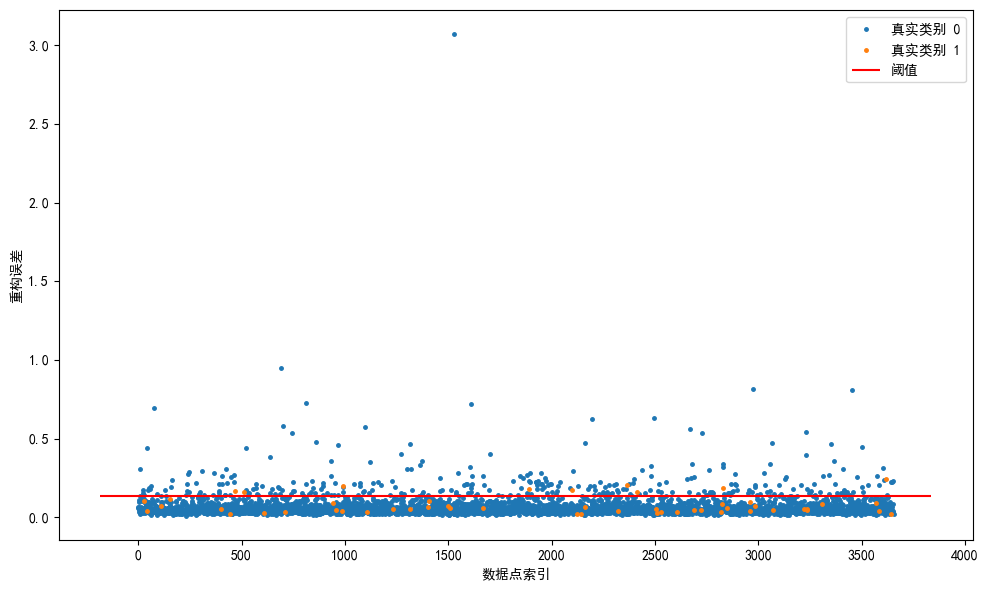

In [43]:
# 绘制重构误差随时间变化图
error_df = pd.DataFrame({'Reconstruction_error': test_mse, 'True_class': ds_bundle.error_df_test_true})
groups = error_df.groupby('True_class')
plt.figure(figsize=(10, 6))
ax = plt.gca()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=2.5, linestyle='', label=f"真实类别 {int(name)}")
ax.hlines(best_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='阈值')
ax.set_ylabel("重构误差")
ax.set_xlabel("数据点索引")
ax.legend()
plt.tight_layout()
plt.show()

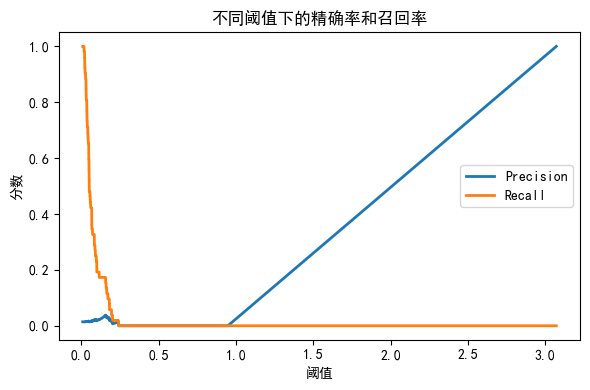

In [44]:
# 绘制精确率-召回率 vs 阈值曲线
precision_rt, recall_rt, threshold_rt = precision_recall_curve(ds_bundle.error_df_test_true, test_mse)
plt.figure(figsize=(6, 4))
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=2)
plt.title('不同阈值下的精确率和召回率')
plt.xlabel('阈值')
plt.ylabel('分数')
plt.legend()
plt.tight_layout()
plt.show()

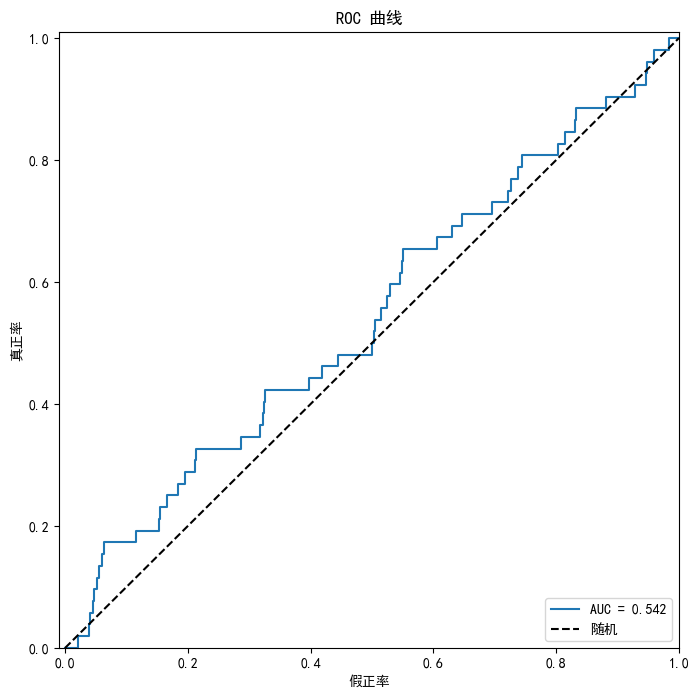

In [45]:
# 绘制ROC曲线
fpr, tpr, _ = roc_curve(ds_bundle.error_df_test_true, test_mse)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='AUC = %0.3f'% roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='随机')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.title('ROC 曲线')
plt.legend(loc='lower right')
plt.show()


最终测试结果:
使用最佳阈值 0.1373 的混淆矩阵:


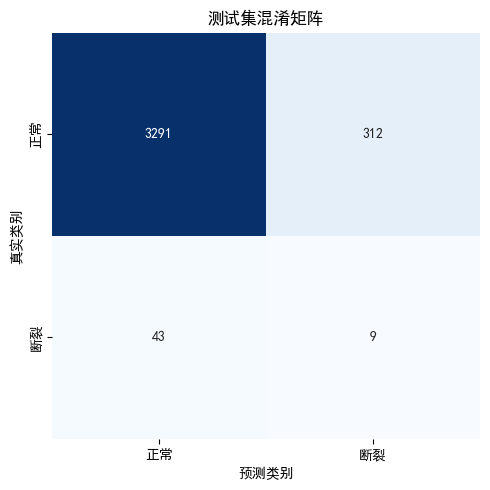

In [47]:
# 绘制测试集混淆矩阵
test_pred = (test_mse > best_threshold).astype(int)
test_cm = confusion_matrix(ds_bundle.error_df_test_true, test_pred)

print(f"\n最终测试结果:")
# print(f"测试集AUC: {test_auc:.4f}")
print(f"使用最佳阈值 {best_threshold:.4f} 的混淆矩阵:")

# 绘制测试集混淆矩阵图表
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['正常', '断裂'], 
            yticklabels=['正常', '断裂'])
plt.title('测试集混淆矩阵')
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.tight_layout()
plt.show()